In [2]:
import os
import csv
import numpy as np
import scipy.io as sio

from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE
from nilearn import connectome

from scipy.spatial import distance


# Reading and computing the input data

# Selected pipeline
pipeline = 'cpac'

# Input data variables
root_folder = '../ABIDE/'
data_folder = os.path.join(root_folder, 'ABIDE_pcp/cpac/filt_noglobal')
phenotype = os.path.join(root_folder, 'ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv')


def fetch_filenames(subject_IDs, file_type):

    """
        subject_list : list of short subject IDs in string format
        file_type    : must be one of the available file types

    returns:

        filenames    : list of filetypes (same length as subject_list)
    """

    import glob

    # Specify file mappings for the possible file types
    filemapping = {'func_preproc': '_func_preproc.nii.gz',
                   'rois_ho': '_rois_ho.1D'}

    # The list to be filled
    filenames = []

    # Fill list with requested file paths
    for i in range(len(subject_IDs)):
        os.chdir(data_folder)  # os.path.join(data_folder, subject_IDs[i]))
        try:
            filenames.append(glob.glob('*' + subject_IDs[i] + filemapping[file_type])[0])
        except IndexError:
            # Return N/A if subject ID is not found
            filenames.append('N/A')

    return filenames


# Get timeseries arrays for list of subjects
def get_timeseries(subject_list, atlas_name):
    """
        subject_list : list of short subject IDs in string format
        atlas_name   : the atlas based on which the timeseries are generated e.g. aal, cc200

    returns:
        time_series  : list of timeseries arrays, each of shape (timepoints x regions)
    """

    timeseries = []
    for i in range(len(subject_list)):
        subject_folder = os.path.join(data_folder, subject_list[i])
        ro_file = [f for f in os.listdir(subject_folder) if f.endswith('_rois_' + atlas_name + '.1D')]
        fl = os.path.join(subject_folder, ro_file[0])
        print("Reading timeseries file %s" %fl)
        timeseries.append(np.loadtxt(fl, skiprows=0))

    return timeseries


# Compute connectivity matrices
def subject_connectivity(timeseries, subject, atlas_name, kind, save=True, save_path=data_folder):
    """
        timeseries   : timeseries table for subject (timepoints x regions)
        subject      : the subject ID
        atlas_name   : name of the parcellation atlas used
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        save         : save the connectivity matrix to a file
        save_path    : specify path to save the matrix if different from subject folder

    returns:
        connectivity : connectivity matrix (regions x regions)
    """

    print("Estimating %s matrix for subject %s" % (kind, subject))

    if kind in ['tangent', 'partial correlation', 'correlation']:
        conn_measure = connectome.ConnectivityMeasure(kind=kind)
        connectivity = conn_measure.fit_transform([timeseries])[0]

    if save:
        subject_file = os.path.join(save_path, subject,
                                    subject + '_' + atlas_name + '_' + kind.replace(' ', '_') + '.mat')
        sio.savemat(subject_file, {'connectivity': connectivity})

    return connectivity


# Get the list of subject IDs
def get_ids(num_subjects=None):
    """

    return:
        subject_IDs    : list of all subject IDs
    """

    subject_IDs = np.genfromtxt(os.path.join(data_folder, 'subject_IDs.txt'), dtype=str)

    if num_subjects is not None:
        subject_IDs = subject_IDs[:num_subjects]

    return subject_IDs


# Get phenotype values for a list of subjects
def get_subject_score(subject_list, score):
    scores_dict = {}

    with open(phenotype) as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row['SUB_ID'] in subject_list:
                scores_dict[row['SUB_ID']] = row[score]

    return scores_dict


# Dimensionality reduction step for the feature vector using a ridge classifier
def feature_selection(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())
    x_data = selector.transform(matrix)

    print("Number of labeled samples %d" % len(train_ind))
    print("Number of features selected %d" % x_data.shape[1])

    return x_data


# Make sure each site is represented in the training set when selecting a subset of the training set
def site_percentage(train_ind, perc, subject_list):
    """
        train_ind    : indices of the training samples
        perc         : percentage of training set used
        subject_list : list of subject IDs

    return:
        labeled_indices      : indices of the subset of training samples
    """

    train_list = subject_list[train_ind]
    sites = get_subject_score(train_list, score='SITE_ID')
    unique = np.unique(list(sites.values())).tolist()
    site = np.array([unique.index(sites[train_list[x]]) for x in range(len(train_list))])

    labeled_indices = []

    for i in np.unique(site):
        id_in_site = np.argwhere(site == i).flatten()

        num_nodes = len(id_in_site)
        labeled_num = int(round(perc * num_nodes))
        labeled_indices.extend(train_ind[id_in_site[:labeled_num]])

    return labeled_indices


# Load precomputed fMRI connectivity networks
def get_networks(subject_list, kind, atlas_name="aal", variable='connectivity'):
    """
        subject_list : list of subject IDs
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        atlas_name   : name of the parcellation atlas used
        variable     : variable name in the .mat file that has been used to save the precomputed networks


    return:
        matrix      : feature matrix of connectivity networks (num_subjects x network_size)
    """

    all_networks = []
    for subject1 in subject_list:
        fl = f'../Datasets/all_fc_matrix_rois_cc400/matrix_rois_cc400_{subject1}.mat'
        try:  
            matrix = sio.loadmat(fl)[variable]
            all_networks.append(matrix)
        except FileNotFoundError:
            fl = f'../Datasets/all_fc_matrix_rois_cc400/matrix_rois_cc400_{50002}.mat'
            matrix = sio.loadmat(fl)[variable]
            all_networks.append(matrix)
            
            
    # all_networks=np.array(all_networks)

    idx = np.triu_indices_from(all_networks[0], 1)
    norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]
    vec_networks = [mat[idx] for mat in norm_networks]
    matrix = np.vstack(vec_networks)

    return matrix


# Construct the adjacency matrix of the population from phenotypic scores
def create_affinity_graph_from_scores(scores, pd_dict):
    num_nodes = len(pd_dict[scores[0]]) 
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = pd_dict[l]

        if l in ['AGE_AT_SCAN', 'FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[k]) - float(label_dict[j]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[k] == label_dict[j]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

def get_static_affinity_adj(features, pd_dict):
    pd_affinity = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], pd_dict) 
    distv = distance.pdist(features, metric='correlation') 
    dist = distance.squareform(distv)  
    sigma = np.mean(dist)
    feature_sim = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adj = pd_affinity * feature_sim  

    return adj


In [3]:
import numpy as np
import scipy.sparse as sp
import torch


from sklearn.model_selection import StratifiedKFold
from scipy.spatial import distance
from scipy.sparse.linalg.eigen import eigsh


def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def get_train_test_masks(labels, idx_train, idx_val, idx_test):
    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return y_train, y_val, y_test, train_mask, val_mask, test_mask

def load_data(subject_IDs, params): 
    
    # labels
    num_classes = 2
    num_nodes = len(subject_IDs)
    
    # 初始化y_data(), y
    y_data = np.zeros([num_nodes, num_classes])
    y = np.zeros([num_nodes, 1])
    
    labels = get_subject_score(subject_IDs, score='DX_GROUP')
    features = get_networks(subject_IDs, kind=params['connectivity'], atlas_name=params['atlas'])
    
    for i in range(num_nodes):
        y_data[i, int(labels[subject_IDs[i]]) - 1] = 1 # (871,2)
        y[i] = int(labels[subject_IDs[i]]) # (871,)
        
    skf = StratifiedKFold(n_splits=10)
    cv_splits = list(skf.split(features, np.squeeze(y)))
    train = cv_splits[params['folds']][0]
    test = cv_splits[params['folds']][1]
    val = test
    
    print('Number of train sample:{}' .format(len(train)))
        
    y_train, y_val, y_test, train_mask, val_mask, test_mask = get_train_test_masks(y_data, train, val, test)
    
    y_data = torch.LongTensor(np.where(y_data)[1])
    y = torch.LongTensor(y)
    y_train = torch.LongTensor(y_train[1])
    y_val = torch.LongTensor(y_val[1])
    y_test = torch.LongTensor(y_test[1])
    
    train = torch.LongTensor(train)
    val = torch.LongTensor(val)
    test = torch.LongTensor(test)
    train_mask = torch.LongTensor(train_mask)
    val_mask = torch.LongTensor(val_mask)
    test_mask = torch.LongTensor(test_mask)
    
    # Eigenvector
    labeled_ind = site_percentage(train, params['num_training'], subject_IDs)
    x_data = feature_selection(features, y, labeled_ind, params['num_features'])
    features = preprocess_features(sp.coo_matrix(x_data).tolil())
    features = torch.FloatTensor(np.array(features.todense()))
    
    # Adjacency matrix
    graph = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], subject_IDs)
    distv = distance.pdist(x_data, metric='correlation')
    dist = distance.squareform(distv)
    sigma = np.mean(dist)
    sparse_graph = np.exp(- dist ** 2 / (2 * sigma ** 2))
    final_graph = graph * sparse_graph

    return final_graph, features, y, y_data, y_train, y_val, y_test, train, val, test, train_mask, val_mask, test_mask


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        coords = torch.from_numpy(coords)
        values = torch.from_numpy(values)
        shape = torch.tensor(shape)
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def preprocess_features(features):
    """Row-normalize feature matrix"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj_normalized

def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return t_k



C:\Users\KSB\AppData\Local\Temp\ipykernel_21656\3119403776.py:8: DeprecationWarning: Please use `eigsh` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.eigen` namespace is deprecated.
  from scipy.sparse.linalg.eigen import eigsh


In [4]:
import numpy as np
import torch
# from utils import preprocess_features
from sklearn.model_selection import StratifiedKFold


class dataloader():
    def __init__(self): 
        self.pd_dict = {}
        self.node_ftr_dim = 2000
        self.num_classes = 2 

    def load_data(self, params, connectivity='correlation', atlas='cc400'):
        ''' load multimodal data from ABIDE
        return: imaging features (raw), labels, non-image data
        '''
        subject_IDs = get_ids()
        labels = get_subject_score(subject_IDs, score='DX_GROUP')
        num_nodes = len(subject_IDs)

        sites = get_subject_score(subject_IDs, score='SITE_ID')
        unique = np.unique(list(sites.values())).tolist()
        ages = get_subject_score(subject_IDs, score='AGE_AT_SCAN')
        genders = get_subject_score(subject_IDs, score='SEX') 

        y_onehot = np.zeros([num_nodes, self.num_classes])
        y = np.zeros([num_nodes])
        site = np.zeros([num_nodes], dtype=int)
        age = np.zeros([num_nodes], dtype=np.float32)
        gender = np.zeros([num_nodes], dtype=int)
        for i in range(num_nodes):
            y_onehot[i, int(labels[subject_IDs[i]])-1] = 1
            y[i] = int(labels[subject_IDs[i]])
            site[i] = unique.index(sites[subject_IDs[i]])
            age[i] = float(ages[subject_IDs[i]])
            gender[i] = genders[subject_IDs[i]]
        
        self.y = y -1  

        self.raw_features = get_networks(subject_IDs, kind=connectivity, atlas_name=atlas)

        phonetic_data = np.zeros([num_nodes, 3], dtype=np.float32)
        phonetic_data[:,0] = site 
        phonetic_data[:,1] = gender 
        phonetic_data[:,2] = age 

        self.pd_dict['SITE_ID'] = np.copy(phonetic_data[:,0])
        self.pd_dict['SEX'] = np.copy(phonetic_data[:,1])
        self.pd_dict['AGE_AT_SCAN'] = np.copy(phonetic_data[:,2]) 
        
        return self.raw_features, self.y, phonetic_data

    def data_split(self, n_folds):
        # split data by k-fold CV
        skf = StratifiedKFold(n_splits=n_folds)
        cv_splits = list(skf.split(self.raw_features, self.y))
        return cv_splits 

    def get_node_features(self, train_ind):
        '''preprocess node features for wl-deepgcn
        '''
        node_ftr = feature_selection(self.raw_features, self.y, train_ind, self.node_ftr_dim)
        self.node_ftr = preprocess_features(node_ftr) 
        return self.node_ftr

    def get_WL_inputs(self, nonimg):
        '''get WL inputs for wl-deepgcn 
        '''
        # construct edge network inputs 
        n = self.node_ftr.shape[0] 
        num_edge = n*(1+n)//2 - n  # n*(n-1)//2,HO=6105
        pd_ftr_dim = nonimg.shape[1]
        edge_index = np.zeros([2, num_edge], dtype=np.int64) 
        edgenet_input = np.zeros([num_edge, 2*pd_ftr_dim], dtype=np.float32)  
        aff_score = np.zeros(num_edge, dtype=np.float32)
        # static affinity score used to pre-prune edges 
        aff_adj = get_static_affinity_adj(self.node_ftr, self.pd_dict)  
        flatten_ind = 0 
        for i in range(n):
            for j in range(i+1, n):
                edge_index[:,flatten_ind] = [i,j]
                edgenet_input[flatten_ind]  = np.concatenate((nonimg[i], nonimg[j]))
                aff_score[flatten_ind] = aff_adj[i][j]  
                flatten_ind +=1

        assert flatten_ind == num_edge, "Error in computing edge input"
        
        keep_ind = np.where(aff_score > 1.1)[0]  
        edge_index = edge_index[:, keep_ind]
        edgenet_input = edgenet_input[keep_ind]

        return edge_index, edgenet_input
    

In [5]:

import torch
from torch.nn import Linear as Lin, Sequential as Seq
import torch.nn.functional as F
from torch import nn

class WL(torch.nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super(WL, self).__init__()
        h1=256
        h2=128
        self.parser =nn.Sequential(
                nn.Linear(input_dim, h1, bias=True),
                nn.LeakyReLU(inplace=True),
                nn.BatchNorm1d(h1),
                nn.Dropout(dropout),
                nn.Linear(h1, h2, bias=True),
                nn.LeakyReLU(inplace=True),
                nn.BatchNorm1d(h2),
                nn.Dropout(dropout),
                nn.Linear(h2, h2, bias=True),
                )
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        self.input_dim = input_dim
        self.model_init()
        self.relu = nn.ReLU(inplace=True)
        self.elu = nn.ReLU()

    def forward(self, x):
        x1 = x[:,0:self.input_dim]
        x2 = x[:,self.input_dim:]
        h1 = self.parser(x1) 
        h2 = self.parser(x2) 
        p = (self.cos(h1,h2) + 1)*0.5
        return p

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Linear as Lin, Sequential as Seq
import torch_geometric as tg
from wl import WL


class MLP(nn.Module):
    def __init__(self, input_dim, nhid):
        super(MLP,self).__init__()
        self.cls = nn.Sequential(
            torch.nn.Linear(input_dim,nhid))
        
    def forward(self, features):
        output = self.cls(features)
        return output
            
class GCN(nn.Module):
    def __init__(self, input_dim, nhid, num_classes, ngl, dropout, edge_dropout, edgenet_input_dim):
        super(GCN, self).__init__()
        K=3   
        hidden = [nhid for i in range(ngl)] 
        self.dropout = dropout
        self.edge_dropout = edge_dropout 
        bias = False 
        self.relu = torch.nn.ReLU(inplace=True) 
        self.ngl = ngl 
        self.gconv = nn.ModuleList()
        for i in range(ngl):
            in_channels = input_dim if i==0  else hidden[i-1]
            self.gconv.append(tg.nn.ChebConv(in_channels, hidden[i], K, normalization='sym', bias=bias)) 
          
        self.cls = nn.Sequential(
                torch.nn.Linear(16, 128),
                torch.nn.ReLU(inplace=True),
                nn.BatchNorm1d(128), 
                torch.nn.Linear(128, num_classes))

        self.edge_net = WL(input_dim=edgenet_input_dim//2, dropout=dropout)
        self.model_init()

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight) # He init
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, features, edge_index, edgenet_input, enforce_edropout=False): 
        if self.edge_dropout>0:
            if enforce_edropout or self.training:
                one_mask = torch.ones([edgenet_input.shape[0],1])
                self.drop_mask = F.dropout(one_mask, self.edge_dropout, True)
                self.bool_mask = torch.squeeze(self.drop_mask.type(torch.bool))
                edge_index = edge_index[:, self.bool_mask] 
                edgenet_input = edgenet_input[self.bool_mask] # Weights
            
        edge_weight = torch.squeeze(self.edge_net(edgenet_input))
        

        # GCN residual connection
        # input layer
        features = F.dropout(features, self.dropout, self.training)
        x = self.relu(self.gconv[0](features, edge_index, edge_weight)) 
        x_temp = x
        
        # hidden layers
        for i in range(1, self.ngl - 1): # self.ngl→7
            x = F.dropout(x_temp, self.dropout, self.training)
            x = self.relu(self.gconv[i](x, edge_index, edge_weight)) 
            x_temp = x_temp + x # ([871,64])

        # output layer
        x = F.dropout(x_temp, self.dropout, self.training)
        x = self.relu(self.gconv[self.ngl - 1](x, edge_index, edge_weight))
        x_temp = x_temp + x

        output = x # Final output is not cumulative
        output = self.cls(output) 
        
        return output, edge_weight
    

    



In [7]:
import torch
import torchmetrics
from torchmetrics.classification import MulticlassSpecificity
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.metrics import precision_recall_fscore_support

def torchmetrics_accuracy(preds, labels):
    acc = torchmetrics.functional.accuracy(preds, labels,task="multiclass", num_classes=2)
    return acc

def torchmetrics_spef(preds, labels):
    metric = MulticlassSpecificity(num_classes=2)
    spef = metric(preds, labels)
    return spef

def torchmetrics_auc(preds, labels):
    auc = torchmetrics.functional.auroc(preds, labels, task="multiclass", num_classes=2)
    return auc

def confusion_matrix(preds, labels):
    conf_matrix = torch.zeros(2, 2)
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[t, p] += 1 
    return conf_matrix
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : computer the value of confusion matrix
    - normalize : True: %, False: 123
    """
    classes = ['0:ASD','1:TC']
    if normalize:
        cm = cm.numpy()
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def correct_num(preds, labels):
    """Accuracy, auc with masking.Acc of the masked samples"""
    correct_prediction = np.equal(np.argmax(preds, 1), labels).astype(np.float32)
    return np.sum(correct_prediction)

def prf(preds, labels, is_logit=True):
    ''' input: logits, labels  ''' 
    pred_lab= np.argmax(preds, 1)
    p,r,f,s  = precision_recall_fscore_support(labels, pred_lab, average='binary')
    return [p,r,f]







In [14]:
import argparse
parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()

In [38]:
from __future__ import division
from __future__ import print_function

import os
import time
import argparse
import numpy as np
import io
import sys

import torch
import torch.optim as optim

from models import GCN

from metrics import torchmetrics_accuracy, torchmetrics_auc, correct_num, prf

# from dataloader import dataloader

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

if hasattr(sys.stdout, 'buffer'):
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')

class Args:
    def __init__(self):
        self.no_cuda = False
        self.seed = 46
        self.epochs = 200
        self.lr = 0.001
        self.weight_decay = 5e-5
        self.hidden = 16
        self.dropout = 0.2
        self.atlas = 'cc400'
        self.num_features = 2000
        self.folds = 10
        self.connectivity = 'correlation'
        self.max_degree = 3
        self.ngl = 8
        self.edropout = 0.3
        self.train = 1
        self.ckpt_path = '../folds/rois_cc400_pth'
        self.early_stopping = True
        self.early_stopping_patience = 20

# Instantiate Args class
args = Args()

# Check if CUDA is available
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Create params dictionary
params = vars(args)

# Print Hyperparameters
print('Hyperparameters:')
for key, value in params.items():
    print(key + ":", value)

corrects = np.zeros(args.folds, dtype=np.int32) 
accs = np.zeros(args.folds, dtype=np.float32) 
aucs = np.zeros(args.folds, dtype=np.float32)
prfs = np.zeros([args.folds,3], dtype=np.float32) # Save Precision, Recall, F1
test_num = np.zeros(args.folds, dtype=np.float32)

print('  Loading dataset ...')
dataloader = dataloader()
raw_features, y, nonimg = dataloader.load_data(params) 
cv_splits = dataloader.data_split(args.folds)
features=raw_features

t1 = time.time()

for i in range(args.folds):
    t_start = time.time()
    train_ind, test_ind = cv_splits[i]

    train_ind, valid_ind = train_test_split(train_ind, test_size=0.1, random_state = 24)
    
    cv_splits[i] = (train_ind, valid_ind)
    cv_splits[i] = cv_splits[i] + (test_ind,)
    print('Size of the {}-fold Training, Validation, and Test Sets:{},{},{}' .format(i+1, len(cv_splits[i][0]), len(cv_splits[i][1]), len(cv_splits[i][2])))

    if args.train == 1:
        for j in range(args.folds):
            print(' Starting the {}-{} Fold:：'.format(i+1,j+1))
            node_ftr = dataloader.get_node_features(train_ind)
            edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
            edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
            
            model = GCN(input_dim = args.num_features,
                        nhid = args.hidden, 
                        num_classes = 2, 
                        ngl = args.ngl, 
                        dropout = args.dropout, 
                        edge_dropout = args.edropout, 
                        edgenet_input_dim = 2*nonimg.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
            
#             if args.cuda:
            model
            features = torch.tensor(node_ftr, dtype=torch.float32)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
            labels = torch.tensor(y, dtype=torch.long)
            fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
                
            acc = 0
            best_val_loss = float('inf') # early stoppping: Initialized to positive infinity
            current_patience = 0 # early stopping: Used to record the epochs of the current early stopping

            for epoch in range(args.epochs):
                # train
                model.train()
                with torch.set_grad_enabled(True):
                    optimizer.zero_grad()
                    output, edge_weights = model(features, edge_index, edgenet_input)
                    loss_train = torch.nn.CrossEntropyLoss()(output[train_ind], labels[train_ind])
                    loss_train.backward()
                    optimizer.step()
                acc_train = torchmetrics_accuracy(output[train_ind], labels[train_ind])
                auc_train = torchmetrics_auc(output[train_ind], labels[train_ind])
                logits_train = output[train_ind].detach().cpu().numpy()
                prf_train = prf(logits_train, y[train_ind])

                
                # valid
                model.eval()
                with torch.set_grad_enabled(False):
                    output, edge_weights = model(features, edge_index, edgenet_input)
                loss_val = torch.nn.CrossEntropyLoss()(output[valid_ind], labels[valid_ind])
                acc_val = torchmetrics_accuracy(output[valid_ind], labels[valid_ind])
                auc_val = torchmetrics_auc(output[valid_ind], labels[valid_ind])
                logits_val = output[valid_ind].detach().cpu().numpy()
                prf_val = prf(logits_val, y[valid_ind])

                
                print('Epoch:{:04d}'.format(epoch+1))
                print('acc_train:{:.4f}'.format(acc_train),
                      'pre_train:{:.4f}'.format(prf_train[0]),
                      'recall_train:{:.4f}'.format(prf_train[1]),
                      'F1_train:{:.4f}'.format(prf_train[2]),
                      'AUC_train:{:.4f}'.format(auc_train))
                print('acc_val:{:.4f}'.format(acc_val),
                      'pre_val:{:.4f}'.format(prf_val[0]),
                      'recall_val:{:.4f}'.format(prf_val[1]),
                      'F1_val:{:4f}'.format(prf_val[2]),
                      'AUC_val:{:.4f}'.format(auc_val))
                
                # save pth
                if acc_val > acc and epoch > 50:
                    acc = acc_val
                    if args.ckpt_path != '':
                        if not os.path.exists(args.ckpt_path):
                            os.makedirs(args.ckpt_path)
                        torch.save(model.state_dict(), fold_model_path)
                
                # Early Stopping
                if epoch > 50 and args.early_stopping == True:
                    if loss_val < best_val_loss:
                        best_val_loss = loss_val
                        current_patience = 0
                    else:
                        current_patience += 1
                    if current_patience >= args.early_stopping_patience:
                        print('Early Stopping!!! epoch：{}'.format(epoch))
                        break
                        
        # test
        print("Loading the Model for the {}-th Fold:... ...".format(i+1),
              "Size of samples in the test set:{}".format(len(test_ind)))
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)
    
    
    if args.train == 0:
        node_ftr = dataloader.get_node_features(train_ind)
        edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
        edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
        
        model = GCN(input_dim = args.num_features,
                    nhid = args.hidden, 
                    num_classes = 2, 
                    ngl = args.ngl, 
                    dropout = args.dropout, 
                    edge_dropout = args.edropout, 
                    edgenet_input_dim = 2*nonimg.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        
#         if args.cuda
        model
        features = torch.tensor(node_ftr, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
        labels = torch.tensor(y, dtype=torch.long)
        fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
        
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)

t2 = time.time()

print('\r\n======Finish Results for Nested 10-fold cross-validation======')
Nested10kCV_acc = np.sum(corrects) / np.sum(test_num)
Nested10kCV_auc = np.mean(aucs)
Nested10kCV_precision, Nested10kCV_recall, Nested10kCV_F1 = np.mean(prfs, axis=0)
print('Test:',
      'acc:{}'.format(Nested10kCV_acc),
      'precision:{}'.format(Nested10kCV_precision),
      'recall:{}'.format(Nested10kCV_recall),
      'F1:{}'.format(Nested10kCV_F1),
      'AUC:{}'.format(Nested10kCV_auc))
print('Total duration:{}'.format(t2 - t1))



Hyperparameters:
no_cuda: False
seed: 46
epochs: 200
lr: 0.001
weight_decay: 5e-05
hidden: 16
dropout: 0.2
atlas: cc400
num_features: 2000
folds: 10
connectivity: correlation
max_degree: 3
ngl: 8
edropout: 0.3
train: 1
ckpt_path: ./pth
early_stopping: True
early_stopping_patience: 20
cuda: False
  Loading dataset ...


C:\Users\KSB\AppData\Local\Temp\ipykernel_23528\2891479116.py:216: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]


Size of the 1-fold Training, Validation, and Test Sets:900,100,112
 Starting the 1-1 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting est

Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53

Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32

Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11

Epoch:0022
acc_train:0.5822 pre_train:0.5945 recall_train:0.6022 F1_train:0.5983 AUC_train:0.6136
acc_val:0.6400 pre_val:0.6250 recall_val:0.7000 F1_val:0.660377 AUC_val:0.6740
Epoch:0023
acc_train:0.5956 pre_train:0.5888 recall_train:0.7204 F1_train:0.6480 AUC_train:0.6452
acc_val:0.6500 pre_val:0.6316 recall_val:0.7200 F1_val:0.672897 AUC_val:0.6756
Epoch:0024
acc_train:0.5900 pre_train:0.5882 recall_train:0.6882 F1_train:0.6343 AUC_train:0.6259
acc_val:0.6500 pre_val:0.6316 recall_val:0.7200 F1_val:0.672897 AUC_val:0.6764
Epoch:0025
acc_train:0.5722 pre_train:0.5735 recall_train:0.6710 F1_train:0.6184 AUC_train:0.6043
acc_val:0.6400 pre_val:0.6250 recall_val:0.7000 F1_val:0.660377 AUC_val:0.6784
Epoch:0026
acc_train:0.5400 pre_train:0.5443 recall_train:0.6731 F1_train:0.6019 AUC_train:0.5738
acc_val:0.6300 pre_val:0.6182 recall_val:0.6800 F1_val:0.647619 AUC_val:0.6768
Epoch:0027
acc_train:0.5878 pre_train:0.5890 recall_train:0.6688 F1_train:0.6264 AUC_train:0.6177
acc_val:0.6300 pr

Epoch:0069
acc_train:0.6344 pre_train:0.6604 recall_train:0.6022 F1_train:0.6299 AUC_train:0.6872
acc_val:0.6400 pre_val:0.6667 recall_val:0.5600 F1_val:0.608696 AUC_val:0.7108
Epoch:0070
acc_train:0.6344 pre_train:0.6667 recall_train:0.5849 F1_train:0.6231 AUC_train:0.7086
acc_val:0.6500 pre_val:0.6829 recall_val:0.5600 F1_val:0.615385 AUC_val:0.7156
Epoch:0071
acc_train:0.6533 pre_train:0.6880 recall_train:0.6022 F1_train:0.6422 AUC_train:0.7201
acc_val:0.6600 pre_val:0.6818 recall_val:0.6000 F1_val:0.638298 AUC_val:0.7168
Epoch:0072
acc_train:0.6622 pre_train:0.6998 recall_train:0.6065 F1_train:0.6498 AUC_train:0.7320
acc_val:0.6700 pre_val:0.6977 recall_val:0.6000 F1_val:0.645161 AUC_val:0.7240
Epoch:0073
acc_train:0.6411 pre_train:0.6732 recall_train:0.5935 F1_train:0.6309 AUC_train:0.7242
acc_val:0.6600 pre_val:0.6905 recall_val:0.5800 F1_val:0.630435 AUC_val:0.7356
Epoch:0074
acc_train:0.6467 pre_train:0.6797 recall_train:0.5978 F1_train:0.6362 AUC_train:0.7343
acc_val:0.6700 pr

Epoch:0116
acc_train:0.9378 pre_train:0.9165 recall_train:0.9677 F1_train:0.9414 AUC_train:0.9795
acc_val:0.8400 pre_val:0.7931 recall_val:0.9200 F1_val:0.851852 AUC_val:0.9080
Epoch:0117
acc_train:0.9578 pre_train:0.9313 recall_train:0.9914 F1_train:0.9604 AUC_train:0.9867
acc_val:0.8400 pre_val:0.7931 recall_val:0.9200 F1_val:0.851852 AUC_val:0.9082
Epoch:0118
acc_train:0.9433 pre_train:0.9224 recall_train:0.9720 F1_train:0.9466 AUC_train:0.9817
acc_val:0.8100 pre_val:0.7541 recall_val:0.9200 F1_val:0.828829 AUC_val:0.9046
Epoch:0119
acc_train:0.9500 pre_train:0.9339 recall_train:0.9720 F1_train:0.9526 AUC_train:0.9869
acc_val:0.8100 pre_val:0.7541 recall_val:0.9200 F1_val:0.828829 AUC_val:0.9054
Epoch:0120
acc_train:0.9556 pre_train:0.9363 recall_train:0.9806 F1_train:0.9580 AUC_train:0.9835
acc_val:0.8300 pre_val:0.7895 recall_val:0.9000 F1_val:0.841121 AUC_val:0.9030
Epoch:0121
acc_train:0.9456 pre_train:0.9351 recall_train:0.9613 F1_train:0.9480 AUC_train:0.9826
acc_val:0.8300 pr

Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65

Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43

Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22

Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4267 pre_train:0.4588 recall_train:0.6108 F1_train:0.5240 AUC_train:0.4292
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4244
Epoch:0002
acc_train:0.4244 pre_train:0.4528 recall_train:0.5462 F1_train:0.4951 AUC_train:0.4056
acc_val:0.5100 pre_val:0.5714 recall_val:0.0800 F1_val:0.140351 AUC_val:0.4232
Epoch:0003
acc_train:0.4456 pre_train:0.4686 recall_train:0.5462 F1_train:0.5045 AUC_train:0.4169
acc_val:0.5400 pre_val:0.7000 recall_val:0.1400 F1_val:0.233333 AUC_val:0.4568
Epoch:0004
acc_train:0.4578 pre_train:0.4778 recall_train:0.5312 F1_train:0.5031 AUC_train:0.4279
acc_val:0.5700 pre_val:0.7333 recall_val:0.2200 F1_val:0.338462 AUC_val:0.4880
Epoch:0005
acc_train:0.4811 pre_train:0.4980 recall_train:0.5398 F1_train:0.5181 AUC_train:0.4679
acc_val:0.5800 pre_val:0.7222 recall_val:0.2600 F1_val:0.382353 AUC_val:0.5568
Epoch:0006
acc_train:0.5033 pre_train:0.5216 recall_train:0.4667 F1_train:0.4926 AUC_train:0.5116
acc_val:0.6100 pr

Epoch:0048
acc_train:0.6078 pre_train:0.6111 recall_train:0.6624 F1_train:0.6357 AUC_train:0.6468
acc_val:0.6500 pre_val:0.6744 recall_val:0.5800 F1_val:0.623656 AUC_val:0.6980
Epoch:0049
acc_train:0.6211 pre_train:0.6270 recall_train:0.6581 F1_train:0.6422 AUC_train:0.6657
acc_val:0.6500 pre_val:0.6744 recall_val:0.5800 F1_val:0.623656 AUC_val:0.7016
Epoch:0050
acc_train:0.6178 pre_train:0.6217 recall_train:0.6645 F1_train:0.6424 AUC_train:0.6804
acc_val:0.6600 pre_val:0.6905 recall_val:0.5800 F1_val:0.630435 AUC_val:0.7064
Epoch:0051
acc_train:0.6322 pre_train:0.6351 recall_train:0.6774 F1_train:0.6556 AUC_train:0.6751
acc_val:0.6600 pre_val:0.6905 recall_val:0.5800 F1_val:0.630435 AUC_val:0.7068
Epoch:0052
acc_train:0.6189 pre_train:0.6255 recall_train:0.6538 F1_train:0.6393 AUC_train:0.6771
acc_val:0.6500 pre_val:0.6744 recall_val:0.5800 F1_val:0.623656 AUC_val:0.7136
Epoch:0053
acc_train:0.6356 pre_train:0.6341 recall_train:0.6968 F1_train:0.6639 AUC_train:0.6775
acc_val:0.6500 pr

Epoch:0095
acc_train:0.9300 pre_train:0.9004 recall_train:0.9720 F1_train:0.9349 AUC_train:0.9684
acc_val:0.7700 pre_val:0.7368 recall_val:0.8400 F1_val:0.785047 AUC_val:0.8324
Epoch:0096
acc_train:0.9344 pre_train:0.9093 recall_train:0.9699 F1_train:0.9386 AUC_train:0.9724
acc_val:0.8000 pre_val:0.7778 recall_val:0.8400 F1_val:0.807692 AUC_val:0.8388
Epoch:0097
acc_train:0.9322 pre_train:0.9089 recall_train:0.9656 F1_train:0.9364 AUC_train:0.9706
acc_val:0.8000 pre_val:0.7679 recall_val:0.8600 F1_val:0.811321 AUC_val:0.8436
Epoch:0098
acc_train:0.9311 pre_train:0.8974 recall_train:0.9785 F1_train:0.9362 AUC_train:0.9638
acc_val:0.8100 pre_val:0.7719 recall_val:0.8800 F1_val:0.822430 AUC_val:0.8544
Epoch:0099
acc_train:0.9022 pre_train:0.8646 recall_train:0.9613 F1_train:0.9104 AUC_train:0.9643
acc_val:0.7600 pre_val:0.7167 recall_val:0.8600 F1_val:0.781818 AUC_val:0.8520
Epoch:0100
acc_train:0.9289 pre_train:0.8893 recall_train:0.9849 F1_train:0.9347 AUC_train:0.9758
acc_val:0.7300 pr

Fitting estimator with 72536 features.
Fitting estimator with 72436 features.
Fitting estimator with 72336 features.
Fitting estimator with 72236 features.
Fitting estimator with 72136 features.
Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71836 features.
Fitting estimator with 71736 features.
Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70

Fitting estimator with 51436 features.
Fitting estimator with 51336 features.
Fitting estimator with 51236 features.
Fitting estimator with 51136 features.
Fitting estimator with 51036 features.
Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50736 features.
Fitting estimator with 50636 features.
Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48

Fitting estimator with 30336 features.
Fitting estimator with 30236 features.
Fitting estimator with 30136 features.
Fitting estimator with 30036 features.
Fitting estimator with 29936 features.
Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29636 features.
Fitting estimator with 29536 features.
Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27

Fitting estimator with 9236 features.
Fitting estimator with 9136 features.
Fitting estimator with 9036 features.
Fitting estimator with 8936 features.
Fitting estimator with 8836 features.
Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
Fitting estimator with 8436 features.
Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting esti

Epoch:0032
acc_train:0.6133 pre_train:0.6321 recall_train:0.6022 F1_train:0.6167 AUC_train:0.6522
acc_val:0.6500 pre_val:0.6596 recall_val:0.6200 F1_val:0.639175 AUC_val:0.7304
Epoch:0033
acc_train:0.6211 pre_train:0.6354 recall_train:0.6258 F1_train:0.6306 AUC_train:0.6635
acc_val:0.6500 pre_val:0.6596 recall_val:0.6200 F1_val:0.639175 AUC_val:0.7284
Epoch:0034
acc_train:0.5744 pre_train:0.5827 recall_train:0.6215 F1_train:0.6015 AUC_train:0.6190
acc_val:0.6400 pre_val:0.6522 recall_val:0.6000 F1_val:0.625000 AUC_val:0.7324
Epoch:0035
acc_train:0.6311 pre_train:0.6587 recall_train:0.5935 F1_train:0.6244 AUC_train:0.6658
acc_val:0.6500 pre_val:0.6596 recall_val:0.6200 F1_val:0.639175 AUC_val:0.7300
Epoch:0036
acc_train:0.6056 pre_train:0.6239 recall_train:0.5957 F1_train:0.6095 AUC_train:0.6216
acc_val:0.6500 pre_val:0.6596 recall_val:0.6200 F1_val:0.639175 AUC_val:0.7292
Epoch:0037
acc_train:0.6056 pre_train:0.6201 recall_train:0.6108 F1_train:0.6154 AUC_train:0.6263
acc_val:0.6400 pr

Epoch:0079
acc_train:0.8256 pre_train:0.7862 recall_train:0.9097 F1_train:0.8435 AUC_train:0.9119
acc_val:0.6400 pre_val:0.5946 recall_val:0.8800 F1_val:0.709677 AUC_val:0.8528
Epoch:0080
acc_train:0.8078 pre_train:0.7544 recall_train:0.9312 F1_train:0.8335 AUC_train:0.9116
acc_val:0.7300 pre_val:0.6716 recall_val:0.9000 F1_val:0.769231 AUC_val:0.8740
Epoch:0081
acc_train:0.8178 pre_train:0.7731 recall_train:0.9161 F1_train:0.8386 AUC_train:0.9077
acc_val:0.7600 pre_val:0.7031 recall_val:0.9000 F1_val:0.789474 AUC_val:0.8732
Epoch:0082
acc_train:0.8311 pre_train:0.8004 recall_train:0.8968 F1_train:0.8458 AUC_train:0.9160
acc_val:0.7100 pre_val:0.6567 recall_val:0.8800 F1_val:0.752137 AUC_val:0.8748
Epoch:0083
acc_train:0.8478 pre_train:0.8060 recall_train:0.9290 F1_train:0.8631 AUC_train:0.9195
acc_val:0.6900 pre_val:0.6377 recall_val:0.8800 F1_val:0.739496 AUC_val:0.8676
Epoch:0084
acc_train:0.8433 pre_train:0.7935 recall_train:0.9419 F1_train:0.8614 AUC_train:0.9369
acc_val:0.7200 pr

Epoch:0126
acc_train:0.9489 pre_train:0.9249 recall_train:0.9806 F1_train:0.9520 AUC_train:0.9807
acc_val:0.7800 pre_val:0.7258 recall_val:0.9000 F1_val:0.803571 AUC_val:0.8848
Epoch:0127
acc_train:0.9511 pre_train:0.9305 recall_train:0.9785 F1_train:0.9539 AUC_train:0.9820
acc_val:0.7800 pre_val:0.7258 recall_val:0.9000 F1_val:0.803571 AUC_val:0.8860
Epoch:0128
acc_train:0.9444 pre_train:0.9226 recall_train:0.9742 F1_train:0.9477 AUC_train:0.9850
acc_val:0.7900 pre_val:0.7377 recall_val:0.9000 F1_val:0.810811 AUC_val:0.8880
Epoch:0129
acc_train:0.9600 pre_train:0.9535 recall_train:0.9699 F1_train:0.9616 AUC_train:0.9877
acc_val:0.7900 pre_val:0.7377 recall_val:0.9000 F1_val:0.810811 AUC_val:0.8912
Epoch:0130
acc_train:0.9611 pre_train:0.9517 recall_train:0.9742 F1_train:0.9628 AUC_train:0.9859
acc_val:0.8200 pre_val:0.7759 recall_val:0.9000 F1_val:0.833333 AUC_val:0.8928
Epoch:0131
acc_train:0.9644 pre_train:0.9464 recall_train:0.9871 F1_train:0.9663 AUC_train:0.9871
acc_val:0.8200 pr

Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57

Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36

Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15

Epoch:0013
acc_train:0.5922 pre_train:0.6124 recall_train:0.5742 F1_train:0.5927 AUC_train:0.6258
acc_val:0.5800 pre_val:0.5541 recall_val:0.8200 F1_val:0.661290 AUC_val:0.6680
Epoch:0014
acc_train:0.6078 pre_train:0.6366 recall_train:0.5613 F1_train:0.5966 AUC_train:0.6458
acc_val:0.5800 pre_val:0.5541 recall_val:0.8200 F1_val:0.661290 AUC_val:0.6676
Epoch:0015
acc_train:0.5811 pre_train:0.5995 recall_train:0.5699 F1_train:0.5843 AUC_train:0.6235
acc_val:0.5800 pre_val:0.5541 recall_val:0.8200 F1_val:0.661290 AUC_val:0.6684
Epoch:0016
acc_train:0.6078 pre_train:0.6308 recall_train:0.5806 F1_train:0.6047 AUC_train:0.6340
acc_val:0.5800 pre_val:0.5541 recall_val:0.8200 F1_val:0.661290 AUC_val:0.6700
Epoch:0017
acc_train:0.6167 pre_train:0.6220 recall_train:0.6581 F1_train:0.6395 AUC_train:0.6581
acc_val:0.6000 pre_val:0.5694 recall_val:0.8200 F1_val:0.672131 AUC_val:0.6748
Epoch:0018
acc_train:0.6100 pre_train:0.6135 recall_train:0.6624 F1_train:0.6370 AUC_train:0.6477
acc_val:0.6100 pr

Epoch:0060
acc_train:0.7789 pre_train:0.8107 recall_train:0.7462 F1_train:0.7772 AUC_train:0.8693
acc_val:0.6900 pre_val:0.8276 recall_val:0.4800 F1_val:0.607595 AUC_val:0.8516
Epoch:0061
acc_train:0.8167 pre_train:0.8233 recall_train:0.8215 F1_train:0.8224 AUC_train:0.8845
acc_val:0.7200 pre_val:0.8667 recall_val:0.5200 F1_val:0.650000 AUC_val:0.8616
Epoch:0062
acc_train:0.8278 pre_train:0.8284 recall_train:0.8409 F1_train:0.8346 AUC_train:0.8963
acc_val:0.7800 pre_val:0.7800 recall_val:0.7800 F1_val:0.780000 AUC_val:0.8480
Epoch:0063
acc_train:0.8467 pre_train:0.8290 recall_train:0.8860 F1_train:0.8565 AUC_train:0.9086
acc_val:0.7700 pre_val:0.7755 recall_val:0.7600 F1_val:0.767677 AUC_val:0.8432
Epoch:0064
acc_train:0.8111 pre_train:0.7968 recall_train:0.8516 F1_train:0.8233 AUC_train:0.8816
acc_val:0.7900 pre_val:0.7843 recall_val:0.8000 F1_val:0.792079 AUC_val:0.8476
Epoch:0065
acc_train:0.8178 pre_train:0.8040 recall_train:0.8559 F1_train:0.8292 AUC_train:0.9031
acc_val:0.7900 pr

Epoch:0107
acc_train:0.9556 pre_train:0.9550 recall_train:0.9591 F1_train:0.9571 AUC_train:0.9907
acc_val:0.7900 pre_val:0.7636 recall_val:0.8400 F1_val:0.800000 AUC_val:0.8748
Epoch:0108
acc_train:0.9567 pre_train:0.9494 recall_train:0.9677 F1_train:0.9585 AUC_train:0.9810
acc_val:0.8100 pre_val:0.7925 recall_val:0.8400 F1_val:0.815534 AUC_val:0.8776
Epoch:0109
acc_train:0.9589 pre_train:0.9612 recall_train:0.9591 F1_train:0.9602 AUC_train:0.9905
acc_val:0.8100 pre_val:0.7818 recall_val:0.8600 F1_val:0.819048 AUC_val:0.8840
Epoch:0110
acc_train:0.9544 pre_train:0.9492 recall_train:0.9634 F1_train:0.9562 AUC_train:0.9887
acc_val:0.7700 pre_val:0.7213 recall_val:0.8800 F1_val:0.792793 AUC_val:0.9016
Epoch:0111
acc_train:0.9622 pre_train:0.9499 recall_train:0.9785 F1_train:0.9640 AUC_train:0.9920
acc_val:0.7600 pre_val:0.7167 recall_val:0.8600 F1_val:0.781818 AUC_val:0.9000
Epoch:0112
acc_train:0.9667 pre_train:0.9560 recall_train:0.9806 F1_train:0.9682 AUC_train:0.9926
acc_val:0.7600 pr

Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60

Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38

Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17

Epoch:0007
acc_train:0.5367 pre_train:0.5412 recall_train:0.6774 F1_train:0.6017 AUC_train:0.5763
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6556
Epoch:0008
acc_train:0.5667 pre_train:0.5835 recall_train:0.5634 F1_train:0.5733 AUC_train:0.5817
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6572
Epoch:0009
acc_train:0.5700 pre_train:0.5990 recall_train:0.5075 F1_train:0.5495 AUC_train:0.5946
acc_val:0.5900 pre_val:0.5672 recall_val:0.7600 F1_val:0.649573 AUC_val:0.6544
Epoch:0010
acc_train:0.5522 pre_train:0.5738 recall_train:0.5183 F1_train:0.5446 AUC_train:0.5736
acc_val:0.6200 pre_val:0.6304 recall_val:0.5800 F1_val:0.604167 AUC_val:0.6544
Epoch:0011
acc_train:0.5722 pre_train:0.6124 recall_train:0.4688 F1_train:0.5311 AUC_train:0.5914
acc_val:0.6600 pre_val:0.7105 recall_val:0.5400 F1_val:0.613636 AUC_val:0.6620
Epoch:0012
acc_train:0.5644 pre_train:0.6299 recall_train:0.3806 F1_train:0.4745 AUC_train:0.5947
acc_val:0.6800 pr

Epoch:0054
acc_train:0.6211 pre_train:0.6416 recall_train:0.6043 F1_train:0.6224 AUC_train:0.6850
acc_val:0.6400 pre_val:0.6667 recall_val:0.5600 F1_val:0.608696 AUC_val:0.7144
Epoch:0055
acc_train:0.6056 pre_train:0.6136 recall_train:0.6387 F1_train:0.6259 AUC_train:0.6657
acc_val:0.6400 pre_val:0.6667 recall_val:0.5600 F1_val:0.608696 AUC_val:0.7152
Epoch:0056
acc_train:0.6056 pre_train:0.6165 recall_train:0.6258 F1_train:0.6211 AUC_train:0.6645
acc_val:0.6500 pre_val:0.6744 recall_val:0.5800 F1_val:0.623656 AUC_val:0.7172
Epoch:0057
acc_train:0.6144 pre_train:0.6277 recall_train:0.6237 F1_train:0.6257 AUC_train:0.6836
acc_val:0.6400 pre_val:0.6667 recall_val:0.5600 F1_val:0.608696 AUC_val:0.7204
Epoch:0058
acc_train:0.6089 pre_train:0.6025 recall_train:0.7140 F1_train:0.6535 AUC_train:0.6643
acc_val:0.6400 pre_val:0.6667 recall_val:0.5600 F1_val:0.608696 AUC_val:0.7232
Epoch:0059
acc_train:0.6300 pre_train:0.6416 recall_train:0.6430 F1_train:0.6423 AUC_train:0.6899
acc_val:0.6600 pr

Epoch:0101
acc_train:0.8778 pre_train:0.8381 recall_train:0.9462 F1_train:0.8889 AUC_train:0.9423
acc_val:0.7700 pre_val:0.7368 recall_val:0.8400 F1_val:0.785047 AUC_val:0.8236
Epoch:0102
acc_train:0.8767 pre_train:0.8404 recall_train:0.9398 F1_train:0.8873 AUC_train:0.9293
acc_val:0.7800 pre_val:0.7692 recall_val:0.8000 F1_val:0.784314 AUC_val:0.8216
Epoch:0103
acc_train:0.8711 pre_train:0.8375 recall_train:0.9312 F1_train:0.8819 AUC_train:0.9250
acc_val:0.7800 pre_val:0.7800 recall_val:0.7800 F1_val:0.780000 AUC_val:0.8368
Epoch:0104
acc_train:0.8733 pre_train:0.8268 recall_train:0.9548 F1_train:0.8862 AUC_train:0.9417
acc_val:0.7900 pre_val:0.7843 recall_val:0.8000 F1_val:0.792079 AUC_val:0.8472
Epoch:0105
acc_train:0.8811 pre_train:0.8352 recall_train:0.9591 F1_train:0.8929 AUC_train:0.9388
acc_val:0.7800 pre_val:0.7800 recall_val:0.7800 F1_val:0.780000 AUC_val:0.8408
Epoch:0106
acc_train:0.9033 pre_train:0.8735 recall_train:0.9505 F1_train:0.9104 AUC_train:0.9520
acc_val:0.7700 pr

Epoch:0148
acc_train:0.9511 pre_train:0.9270 recall_train:0.9828 F1_train:0.9541 AUC_train:0.9899
acc_val:0.8400 pre_val:0.8148 recall_val:0.8800 F1_val:0.846154 AUC_val:0.8976
Epoch:0149
acc_train:0.9622 pre_train:0.9462 recall_train:0.9828 F1_train:0.9641 AUC_train:0.9886
acc_val:0.8300 pre_val:0.7895 recall_val:0.9000 F1_val:0.841121 AUC_val:0.8948
Epoch:0150
acc_train:0.9689 pre_train:0.9562 recall_train:0.9849 F1_train:0.9703 AUC_train:0.9924
acc_val:0.8200 pre_val:0.7667 recall_val:0.9200 F1_val:0.836364 AUC_val:0.8896
Epoch:0151
acc_train:0.9589 pre_train:0.9385 recall_train:0.9849 F1_train:0.9612 AUC_train:0.9899
acc_val:0.8300 pre_val:0.7895 recall_val:0.9000 F1_val:0.841121 AUC_val:0.8956
Epoch:0152
acc_train:0.9711 pre_train:0.9602 recall_train:0.9849 F1_train:0.9724 AUC_train:0.9911
acc_val:0.8400 pre_val:0.8269 recall_val:0.8600 F1_val:0.843137 AUC_val:0.8968
Epoch:0153
acc_train:0.9733 pre_train:0.9565 recall_train:0.9935 F1_train:0.9747 AUC_train:0.9921
acc_val:0.8500 pr

Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62

Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41

Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20

Epoch:0001
acc_train:0.4544 pre_train:0.4758 recall_train:0.5505 F1_train:0.5105 AUC_train:0.4302
acc_val:0.5800 pre_val:0.8333 recall_val:0.2000 F1_val:0.322581 AUC_val:0.6088
Epoch:0002
acc_train:0.5222 pre_train:0.5428 recall_train:0.4774 F1_train:0.5080 AUC_train:0.5135
acc_val:0.6000 pre_val:0.8125 recall_val:0.2600 F1_val:0.393939 AUC_val:0.5848
Epoch:0003
acc_train:0.5044 pre_train:0.5268 recall_train:0.4022 F1_train:0.4561 AUC_train:0.5086
acc_val:0.6000 pre_val:0.7500 recall_val:0.3000 F1_val:0.428571 AUC_val:0.5772
Epoch:0004
acc_train:0.5189 pre_train:0.5460 recall_train:0.4086 F1_train:0.4674 AUC_train:0.5201
acc_val:0.6200 pre_val:0.7500 recall_val:0.3600 F1_val:0.486486 AUC_val:0.5604
Epoch:0005
acc_train:0.5544 pre_train:0.5744 recall_train:0.5312 F1_train:0.5520 AUC_train:0.5600
acc_val:0.6300 pre_val:0.7407 recall_val:0.4000 F1_val:0.519481 AUC_val:0.5776
Epoch:0006
acc_train:0.5478 pre_train:0.5863 recall_train:0.4237 F1_train:0.4919 AUC_train:0.5449
acc_val:0.6400 pr

Epoch:0048
acc_train:0.5944 pre_train:0.5977 recall_train:0.6581 F1_train:0.6264 AUC_train:0.6367
acc_val:0.6500 pre_val:0.7419 recall_val:0.4600 F1_val:0.567901 AUC_val:0.7180
Epoch:0049
acc_train:0.6256 pre_train:0.6362 recall_train:0.6430 F1_train:0.6396 AUC_train:0.6548
acc_val:0.6500 pre_val:0.7419 recall_val:0.4600 F1_val:0.567901 AUC_val:0.7240
Epoch:0050
acc_train:0.6278 pre_train:0.6512 recall_train:0.6022 F1_train:0.6257 AUC_train:0.6725
acc_val:0.6500 pre_val:0.7419 recall_val:0.4600 F1_val:0.567901 AUC_val:0.7284
Epoch:0051
acc_train:0.6333 pre_train:0.6627 recall_train:0.5914 F1_train:0.6250 AUC_train:0.6643
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.7328
Epoch:0052
acc_train:0.6156 pre_train:0.6247 recall_train:0.6409 F1_train:0.6327 AUC_train:0.6406
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.7344
Epoch:0053
acc_train:0.6267 pre_train:0.6532 recall_train:0.5914 F1_train:0.6208 AUC_train:0.6537
acc_val:0.6500 pr

Epoch:0095
acc_train:0.8744 pre_train:0.8346 recall_train:0.9441 F1_train:0.8860 AUC_train:0.9329
acc_val:0.6700 pre_val:0.6104 recall_val:0.9400 F1_val:0.740157 AUC_val:0.8240
Epoch:0096
acc_train:0.8656 pre_train:0.8197 recall_train:0.9484 F1_train:0.8794 AUC_train:0.9377
acc_val:0.6900 pre_val:0.6338 recall_val:0.9000 F1_val:0.743802 AUC_val:0.8284
Epoch:0097
acc_train:0.8678 pre_train:0.8216 recall_train:0.9505 F1_train:0.8814 AUC_train:0.9319
acc_val:0.7100 pre_val:0.6667 recall_val:0.8400 F1_val:0.743363 AUC_val:0.8388
Epoch:0098
acc_train:0.8611 pre_train:0.8282 recall_train:0.9226 F1_train:0.8728 AUC_train:0.9123
acc_val:0.7200 pre_val:0.6719 recall_val:0.8600 F1_val:0.754386 AUC_val:0.8488
Epoch:0099
acc_train:0.8478 pre_train:0.8166 recall_train:0.9097 F1_train:0.8606 AUC_train:0.9146
acc_val:0.7600 pre_val:0.7097 recall_val:0.8800 F1_val:0.785714 AUC_val:0.8728
Epoch:0100
acc_train:0.8456 pre_train:0.7985 recall_train:0.9376 F1_train:0.8625 AUC_train:0.9293
acc_val:0.7300 pr

Epoch:0142
acc_train:0.9700 pre_train:0.9506 recall_train:0.9935 F1_train:0.9716 AUC_train:0.9932
acc_val:0.8100 pre_val:0.7719 recall_val:0.8800 F1_val:0.822430 AUC_val:0.8912
Epoch:0143
acc_train:0.9633 pre_train:0.9463 recall_train:0.9849 F1_train:0.9652 AUC_train:0.9905
acc_val:0.8200 pre_val:0.7963 recall_val:0.8600 F1_val:0.826923 AUC_val:0.8880
Epoch:0144
acc_train:0.9522 pre_train:0.9360 recall_train:0.9742 F1_train:0.9547 AUC_train:0.9797
acc_val:0.8000 pre_val:0.7679 recall_val:0.8600 F1_val:0.811321 AUC_val:0.8860
Epoch:0145
acc_train:0.9567 pre_train:0.9456 recall_train:0.9720 F1_train:0.9586 AUC_train:0.9894
acc_val:0.7600 pre_val:0.7167 recall_val:0.8600 F1_val:0.781818 AUC_val:0.8912
Epoch:0146
acc_train:0.9656 pre_train:0.9521 recall_train:0.9828 F1_train:0.9672 AUC_train:0.9923
acc_val:0.7800 pre_val:0.7258 recall_val:0.9000 F1_val:0.803571 AUC_val:0.9032
Epoch:0147
acc_train:0.9633 pre_train:0.9463 recall_train:0.9849 F1_train:0.9652 AUC_train:0.9821
acc_val:0.7800 pr

Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68

Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47

Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26936 features.
Fitting estimator with 26836 features.
Fitting estimator with 26736 features.
Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26

Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting estimator with 5736 features.
Fitting estimator with 5636 features.
Fitting estimator with 5536 features.
Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting esti

Epoch:0036
acc_train:0.7378 pre_train:0.7198 recall_train:0.8065 F1_train:0.7606 AUC_train:0.7766
acc_val:0.6900 pre_val:0.7111 recall_val:0.6400 F1_val:0.673684 AUC_val:0.7848
Epoch:0037
acc_train:0.7367 pre_train:0.7218 recall_train:0.7978 F1_train:0.7579 AUC_train:0.7918
acc_val:0.6900 pre_val:0.7209 recall_val:0.6200 F1_val:0.666667 AUC_val:0.7792
Epoch:0038
acc_train:0.7556 pre_train:0.7455 recall_train:0.8000 F1_train:0.7718 AUC_train:0.7914
acc_val:0.7100 pre_val:0.7234 recall_val:0.6800 F1_val:0.701031 AUC_val:0.7748
Epoch:0039
acc_train:0.7489 pre_train:0.7201 recall_train:0.8409 F1_train:0.7758 AUC_train:0.7838
acc_val:0.6900 pre_val:0.7021 recall_val:0.6600 F1_val:0.680412 AUC_val:0.7692
Epoch:0040
acc_train:0.7411 pre_train:0.7140 recall_train:0.8323 F1_train:0.7686 AUC_train:0.7833
acc_val:0.6900 pre_val:0.7021 recall_val:0.6600 F1_val:0.680412 AUC_val:0.7768
Epoch:0041
acc_train:0.7522 pre_train:0.7216 recall_train:0.8473 F1_train:0.7794 AUC_train:0.7832
acc_val:0.6800 pr

Epoch:0083
acc_train:0.8422 pre_train:0.7789 recall_train:0.9699 F1_train:0.8640 AUC_train:0.8727
acc_val:0.7400 pre_val:0.6818 recall_val:0.9000 F1_val:0.775862 AUC_val:0.8356
Epoch:0084
acc_train:0.8467 pre_train:0.7834 recall_train:0.9720 F1_train:0.8676 AUC_train:0.8959
acc_val:0.7400 pre_val:0.6875 recall_val:0.8800 F1_val:0.771930 AUC_val:0.8294
Epoch:0085
acc_train:0.8400 pre_train:0.7762 recall_train:0.9699 F1_train:0.8623 AUC_train:0.8890
acc_val:0.7500 pre_val:0.7273 recall_val:0.8000 F1_val:0.761905 AUC_val:0.8276
Epoch:0086
acc_train:0.8478 pre_train:0.7837 recall_train:0.9742 F1_train:0.8686 AUC_train:0.8895
acc_val:0.7500 pre_val:0.7273 recall_val:0.8000 F1_val:0.761905 AUC_val:0.8256
Epoch:0087
acc_train:0.8522 pre_train:0.7892 recall_train:0.9742 F1_train:0.8720 AUC_train:0.8824
acc_val:0.7700 pre_val:0.7368 recall_val:0.8400 F1_val:0.785047 AUC_val:0.8240
Epoch:0088
acc_train:0.8522 pre_train:0.7923 recall_train:0.9677 F1_train:0.8712 AUC_train:0.8930
acc_val:0.7400 pr

Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61

Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40

Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19

Epoch:0004
acc_train:0.5467 pre_train:0.6629 recall_train:0.2495 F1_train:0.3625 AUC_train:0.5152
acc_val:0.4800 pre_val:0.4891 recall_val:0.9000 F1_val:0.633803 AUC_val:0.5200
Epoch:0005
acc_train:0.5433 pre_train:0.6378 recall_train:0.2688 F1_train:0.3782 AUC_train:0.5231
acc_val:0.4800 pre_val:0.4894 recall_val:0.9200 F1_val:0.638889 AUC_val:0.4880
Epoch:0006
acc_train:0.4889 pre_train:0.5064 recall_train:0.4237 F1_train:0.4614 AUC_train:0.4824
acc_val:0.4500 pre_val:0.4731 recall_val:0.8800 F1_val:0.615385 AUC_val:0.4904
Epoch:0007
acc_train:0.5522 pre_train:0.6722 recall_train:0.2602 F1_train:0.3752 AUC_train:0.5252
acc_val:0.4900 pre_val:0.4948 recall_val:0.9600 F1_val:0.653061 AUC_val:0.4840
Epoch:0008
acc_train:0.5656 pre_train:0.6796 recall_train:0.3011 F1_train:0.4173 AUC_train:0.5737
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.5340
Epoch:0009
acc_train:0.5167 pre_train:0.5339 recall_train:0.5075 F1_train:0.5204 AUC_train:0.5105
acc_val:0.4900 pr

Epoch:0051
acc_train:0.5822 pre_train:0.6816 recall_train:0.3591 F1_train:0.4704 AUC_train:0.5980
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.6180
Epoch:0052
acc_train:0.6133 pre_train:0.7143 recall_train:0.4194 F1_train:0.5285 AUC_train:0.6218
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.6260
Epoch:0053
acc_train:0.6233 pre_train:0.7100 recall_train:0.4581 F1_train:0.5569 AUC_train:0.6210
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.6276
Epoch:0054
acc_train:0.6067 pre_train:0.6808 recall_train:0.4495 F1_train:0.5415 AUC_train:0.6022
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.6316
Epoch:0055
acc_train:0.5622 pre_train:0.5703 recall_train:0.6194 F1_train:0.5938 AUC_train:0.6028
acc_val:0.6700 pre_val:0.7429 recall_val:0.5200 F1_val:0.611765 AUC_val:0.6436
Epoch:0056
acc_train:0.5522 pre_train:0.5525 recall_train:0.7011 F1_train:0.6180 AUC_train:0.6112
acc_val:0.6600 pr

Epoch:0098
acc_train:0.6389 pre_train:0.7096 recall_train:0.5097 F1_train:0.5932 AUC_train:0.6950
acc_val:0.6700 pre_val:0.7576 recall_val:0.5000 F1_val:0.602410 AUC_val:0.7000
Epoch:0099
acc_train:0.6467 pre_train:0.7304 recall_train:0.5011 F1_train:0.5944 AUC_train:0.7015
acc_val:0.6800 pre_val:0.7647 recall_val:0.5200 F1_val:0.619048 AUC_val:0.6966
Epoch:0100
acc_train:0.6522 pre_train:0.7390 recall_train:0.5054 F1_train:0.6003 AUC_train:0.6910
acc_val:0.6800 pre_val:0.7500 recall_val:0.5400 F1_val:0.627907 AUC_val:0.6994
Epoch:0101
acc_train:0.6311 pre_train:0.6916 recall_train:0.5161 F1_train:0.5911 AUC_train:0.6700
acc_val:0.6700 pre_val:0.7297 recall_val:0.5400 F1_val:0.620690 AUC_val:0.6994
Epoch:0102
acc_train:0.6289 pre_train:0.7015 recall_train:0.4903 F1_train:0.5772 AUC_train:0.6842
acc_val:0.6700 pre_val:0.7297 recall_val:0.5400 F1_val:0.620690 AUC_val:0.6885
Epoch:0103
acc_train:0.6556 pre_train:0.7273 recall_train:0.5333 F1_train:0.6154 AUC_train:0.7052
acc_val:0.6700 pr

Epoch:0145
acc_train:0.8689 pre_train:0.9460 recall_train:0.7914 F1_train:0.8618 AUC_train:0.9597
acc_val:0.7800 pre_val:0.7917 recall_val:0.7600 F1_val:0.775510 AUC_val:0.8304
Epoch:0146
acc_train:0.8733 pre_train:0.9333 recall_train:0.8129 F1_train:0.8690 AUC_train:0.9602
acc_val:0.7300 pre_val:0.7091 recall_val:0.7800 F1_val:0.742857 AUC_val:0.8000
Epoch:0147
acc_train:0.8789 pre_train:0.9428 recall_train:0.8151 F1_train:0.8743 AUC_train:0.9533
acc_val:0.7400 pre_val:0.7222 recall_val:0.7800 F1_val:0.750000 AUC_val:0.8172
Epoch:0148
acc_train:0.8778 pre_train:0.9404 recall_train:0.8151 F1_train:0.8733 AUC_train:0.9569
acc_val:0.7900 pre_val:0.8372 recall_val:0.7200 F1_val:0.774194 AUC_val:0.8672
Epoch:0149
acc_train:0.8911 pre_train:0.9531 recall_train:0.8301 F1_train:0.8874 AUC_train:0.9716
acc_val:0.7600 pre_val:0.8824 recall_val:0.6000 F1_val:0.714286 AUC_val:0.8736
Epoch:0150
acc_train:0.8867 pre_train:0.9714 recall_train:0.8043 F1_train:0.8800 AUC_train:0.9696
acc_val:0.7800 pr

Epoch:0192
acc_train:0.9644 pre_train:0.9737 recall_train:0.9570 F1_train:0.9653 AUC_train:0.9930
acc_val:0.7700 pre_val:0.7872 recall_val:0.7400 F1_val:0.762887 AUC_val:0.8690
Epoch:0193
acc_train:0.9533 pre_train:0.9628 recall_train:0.9462 F1_train:0.9544 AUC_train:0.9908
acc_val:0.7700 pre_val:0.8140 recall_val:0.7000 F1_val:0.752688 AUC_val:0.8714
Epoch:0194
acc_train:0.9522 pre_train:0.9817 recall_train:0.9247 F1_train:0.9524 AUC_train:0.9942
acc_val:0.7700 pre_val:0.8140 recall_val:0.7000 F1_val:0.752688 AUC_val:0.8684
Epoch:0195
acc_train:0.9700 pre_train:0.9824 recall_train:0.9591 F1_train:0.9706 AUC_train:0.9962
acc_val:0.7900 pre_val:0.8222 recall_val:0.7400 F1_val:0.778947 AUC_val:0.8688
Early Stopping!!! epoch：194
 Starting the 1-9 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitti

Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55

Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33

Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12

Epoch:0018
acc_train:0.6389 pre_train:0.6759 recall_train:0.5785 F1_train:0.6234 AUC_train:0.6862
acc_val:0.6700 pre_val:0.6441 recall_val:0.7600 F1_val:0.697248 AUC_val:0.7052
Epoch:0019
acc_train:0.6544 pre_train:0.7251 recall_train:0.5333 F1_train:0.6146 AUC_train:0.6992
acc_val:0.6300 pre_val:0.6226 recall_val:0.6600 F1_val:0.640777 AUC_val:0.7024
Epoch:0020
acc_train:0.6256 pre_train:0.6768 recall_train:0.5269 F1_train:0.5925 AUC_train:0.6798
acc_val:0.6500 pre_val:0.6596 recall_val:0.6200 F1_val:0.639175 AUC_val:0.6976
Epoch:0021
acc_train:0.6278 pre_train:0.7241 recall_train:0.4516 F1_train:0.5563 AUC_train:0.6873
acc_val:0.6900 pre_val:0.7209 recall_val:0.6200 F1_val:0.666667 AUC_val:0.7072
Epoch:0022
acc_train:0.6656 pre_train:0.7092 recall_train:0.5978 F1_train:0.6488 AUC_train:0.7110
acc_val:0.6800 pre_val:0.7250 recall_val:0.5800 F1_val:0.644444 AUC_val:0.7148
Epoch:0023
acc_train:0.6322 pre_train:0.6692 recall_train:0.5699 F1_train:0.6156 AUC_train:0.6946
acc_val:0.6700 pr

Epoch:0065
acc_train:0.8078 pre_train:0.7598 recall_train:0.9183 F1_train:0.8315 AUC_train:0.8527
acc_val:0.6700 pre_val:0.7073 recall_val:0.5800 F1_val:0.637363 AUC_val:0.7732
Epoch:0066
acc_train:0.7756 pre_train:0.7378 recall_train:0.8774 F1_train:0.8016 AUC_train:0.8314
acc_val:0.6600 pre_val:0.7000 recall_val:0.5600 F1_val:0.622222 AUC_val:0.7600
Epoch:0067
acc_train:0.7678 pre_train:0.7406 recall_train:0.8473 F1_train:0.7904 AUC_train:0.8199
acc_val:0.6700 pre_val:0.7297 recall_val:0.5400 F1_val:0.620690 AUC_val:0.7632
Epoch:0068
acc_train:0.7744 pre_train:0.7481 recall_train:0.8495 F1_train:0.7956 AUC_train:0.8298
acc_val:0.6700 pre_val:0.7179 recall_val:0.5600 F1_val:0.629213 AUC_val:0.7720
Epoch:0069
acc_train:0.7978 pre_train:0.7568 recall_train:0.8968 F1_train:0.8209 AUC_train:0.8554
acc_val:0.7100 pre_val:0.7442 recall_val:0.6400 F1_val:0.688172 AUC_val:0.7852
Epoch:0070
acc_train:0.8111 pre_train:0.7611 recall_train:0.9247 F1_train:0.8350 AUC_train:0.8644
acc_val:0.6700 pr

Epoch:0112
acc_train:0.9311 pre_train:0.9697 recall_train:0.8946 F1_train:0.9306 AUC_train:0.9791
acc_val:0.8100 pre_val:0.8444 recall_val:0.7600 F1_val:0.800000 AUC_val:0.8440
Epoch:0113
acc_train:0.9189 pre_train:0.9516 recall_train:0.8882 F1_train:0.9188 AUC_train:0.9742
acc_val:0.8200 pre_val:0.8636 recall_val:0.7600 F1_val:0.808511 AUC_val:0.8548
Epoch:0114
acc_train:0.9367 pre_train:0.9513 recall_train:0.9247 F1_train:0.9378 AUC_train:0.9854
acc_val:0.8200 pre_val:0.8636 recall_val:0.7600 F1_val:0.808511 AUC_val:0.8584
Epoch:0115
acc_train:0.9256 pre_train:0.9543 recall_train:0.8989 F1_train:0.9258 AUC_train:0.9799
acc_val:0.8100 pre_val:0.8605 recall_val:0.7400 F1_val:0.795699 AUC_val:0.8664
Epoch:0116
acc_train:0.9456 pre_train:0.9860 recall_train:0.9075 F1_train:0.9451 AUC_train:0.9855
acc_val:0.7800 pre_val:0.8500 recall_val:0.6800 F1_val:0.755556 AUC_val:0.8732
Epoch:0117
acc_train:0.9311 pre_train:0.9611 recall_train:0.9032 F1_train:0.9313 AUC_train:0.9770
acc_val:0.7900 pr

Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71836 features.
Fitting estimator with 71736 features.
Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69

Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50736 features.
Fitting estimator with 50636 features.
Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48

Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29636 features.
Fitting estimator with 29536 features.
Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27

Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
Fitting estimator with 8436 features.
Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting esti

Epoch:0033
acc_train:0.5522 pre_train:0.5674 recall_train:0.5613 F1_train:0.5643 AUC_train:0.5696
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6912
Epoch:0034
acc_train:0.5478 pre_train:0.5516 recall_train:0.6667 F1_train:0.6037 AUC_train:0.5830
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6968
Epoch:0035
acc_train:0.5244 pre_train:0.5247 recall_train:0.8452 F1_train:0.6474 AUC_train:0.6015
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6968
Epoch:0036
acc_train:0.5967 pre_train:0.6545 recall_train:0.4645 F1_train:0.5434 AUC_train:0.6129
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6972
Epoch:0037
acc_train:0.5456 pre_train:0.5405 recall_train:0.8043 F1_train:0.6465 AUC_train:0.6063
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.6872
Epoch:0038
acc_train:0.5556 pre_train:0.5554 recall_train:0.7011 F1_train:0.6198 AUC_train:0.5705
acc_val:0.5000 pr

Epoch:0080
acc_train:0.7189 pre_train:0.7154 recall_train:0.7570 F1_train:0.7356 AUC_train:0.8051
acc_val:0.7100 pre_val:0.7143 recall_val:0.7000 F1_val:0.707071 AUC_val:0.7748
Epoch:0081
acc_train:0.7211 pre_train:0.7220 recall_train:0.7484 F1_train:0.7350 AUC_train:0.7982
acc_val:0.6900 pre_val:0.7021 recall_val:0.6600 F1_val:0.680412 AUC_val:0.7788
Epoch:0082
acc_train:0.7333 pre_train:0.7301 recall_train:0.7677 F1_train:0.7484 AUC_train:0.8124
acc_val:0.6900 pre_val:0.7021 recall_val:0.6600 F1_val:0.680412 AUC_val:0.7832
Epoch:0083
acc_train:0.7367 pre_train:0.7405 recall_train:0.7548 F1_train:0.7476 AUC_train:0.8182
acc_val:0.7000 pre_val:0.7083 recall_val:0.6800 F1_val:0.693878 AUC_val:0.7864
Epoch:0084
acc_train:0.7467 pre_train:0.7375 recall_train:0.7914 F1_train:0.7635 AUC_train:0.8384
acc_val:0.7200 pre_val:0.7200 recall_val:0.7200 F1_val:0.720000 AUC_val:0.7864
Epoch:0085
acc_train:0.7456 pre_train:0.7314 recall_train:0.8022 F1_train:0.7651 AUC_train:0.8331
acc_val:0.7600 pr

Epoch:0127
acc_train:0.9333 pre_train:0.9613 recall_train:0.9075 F1_train:0.9336 AUC_train:0.9774
acc_val:0.7700 pre_val:0.7213 recall_val:0.8800 F1_val:0.792793 AUC_val:0.8676
Epoch:0128
acc_train:0.9156 pre_train:0.9371 recall_train:0.8968 F1_train:0.9165 AUC_train:0.9772
acc_val:0.7900 pre_val:0.7458 recall_val:0.8800 F1_val:0.807339 AUC_val:0.8736
Epoch:0129
acc_train:0.9344 pre_train:0.9677 recall_train:0.9032 F1_train:0.9344 AUC_train:0.9778
acc_val:0.8000 pre_val:0.7586 recall_val:0.8800 F1_val:0.814815 AUC_val:0.8712
Epoch:0130
acc_train:0.9400 pre_train:0.9536 recall_train:0.9290 F1_train:0.9412 AUC_train:0.9796
acc_val:0.8400 pre_val:0.8269 recall_val:0.8600 F1_val:0.843137 AUC_val:0.8798
Epoch:0131
acc_train:0.9267 pre_train:0.9565 recall_train:0.8989 F1_train:0.9268 AUC_train:0.9803
acc_val:0.8100 pre_val:0.8163 recall_val:0.8000 F1_val:0.808081 AUC_val:0.8780
Epoch:0132
acc_train:0.9389 pre_train:0.9617 recall_train:0.9183 F1_train:0.9395 AUC_train:0.9816
acc_val:0.8400 pr

Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74136 features.
Fitting estimator with 74036 features.
Fitting estimator with 73936 features.
Fitting estimator with 73

Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53336 features.
Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53036 features.
Fitting estimator with 52936 features.
Fitting estimator with 52836 features.
Fitting estimator with 52

Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32236 features.
Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31936 features.
Fitting estimator with 31836 features.
Fitting estimator with 31736 features.
Fitting estimator with 31

Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11136 features.
Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10836 features.
Fitting estimator with 10736 features.
Fitting estimator with 10636 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5433 pre_train:0.5523 recall_train:0.6129 F1_train:0.5810 AUC_train:0.5590
acc_val:0.6600 pre_val:0.6379 recall_val:0.7400 F1_val:0.685185 AUC_val:0.7080
Epoch:0024
acc_train:0.5689 pre_train:0.5817 recall_train:0.5892 F1_train:0.5855 AUC_train:0.6024
acc_val:0.6200 pre_val:0.6111 recall_val:0.6600 F1_val:0.634615 AUC_val:0.7084
Epoch:0025
acc_train:0.5578 pre_train:0.5579 recall_train:0.6946 F1_train:0.6188 AUC_train:0.5944
acc_val:0.6200 pre_val:0.6111 recall_val:0.6600 F1_val:0.634615 AUC_val:0.7096
Epoch:0026
acc_train:0.5856 pre_train:0.5975 recall_train:0.6065 F1_train:0.6019 AUC_train:0.6169
acc_val:0.6200 pre_val:0.6111 recall_val:0.6600 F1_val:0.634615 AUC_val:0.7100
Epoch:0027
acc_train:0.5944 pre_train:0.6037 recall_train:0.6258 F1_train:0.6146 AUC_train:0.6323
acc_val:0.6200 pre_val:0.6154 recall_val:0.6400 F1_val:0.627451 AUC_val:0.7128
Epoch:0028
acc_train:0.5733 pre_train:0.5867 recall_train:0.5892 F1_train:0.5880 AUC_train:0.6069
acc_val:0.6300 pr

Epoch:0070
acc_train:0.8011 pre_train:0.7826 recall_train:0.8516 F1_train:0.8157 AUC_train:0.8479
acc_val:0.7800 pre_val:0.7692 recall_val:0.8000 F1_val:0.784314 AUC_val:0.8466
Epoch:0071
acc_train:0.8067 pre_train:0.7650 recall_train:0.9032 F1_train:0.8284 AUC_train:0.8554
acc_val:0.8000 pre_val:0.7778 recall_val:0.8400 F1_val:0.807692 AUC_val:0.8432
Epoch:0072
acc_train:0.8156 pre_train:0.7637 recall_train:0.9312 F1_train:0.8391 AUC_train:0.8618
acc_val:0.7900 pre_val:0.7458 recall_val:0.8800 F1_val:0.807339 AUC_val:0.8446
Epoch:0073
acc_train:0.8344 pre_train:0.7883 recall_train:0.9290 F1_train:0.8529 AUC_train:0.8839
acc_val:0.7900 pre_val:0.7458 recall_val:0.8800 F1_val:0.807339 AUC_val:0.8552
Epoch:0074
acc_train:0.8344 pre_train:0.7852 recall_train:0.9355 F1_train:0.8538 AUC_train:0.8897
acc_val:0.8100 pre_val:0.7541 recall_val:0.9200 F1_val:0.828829 AUC_val:0.8756
Epoch:0075
acc_train:0.8122 pre_train:0.7561 recall_train:0.9398 F1_train:0.8380 AUC_train:0.8878
acc_val:0.8200 pr

Epoch:0117
acc_train:0.9300 pre_train:0.9119 recall_train:0.9570 F1_train:0.9339 AUC_train:0.9642
acc_val:0.7600 pre_val:0.7241 recall_val:0.8400 F1_val:0.777778 AUC_val:0.8892
Epoch:0118
acc_train:0.9367 pre_train:0.9096 recall_train:0.9742 F1_train:0.9408 AUC_train:0.9756
acc_val:0.7800 pre_val:0.7500 recall_val:0.8400 F1_val:0.792453 AUC_val:0.8860
Epoch:0119
acc_train:0.9344 pre_train:0.9093 recall_train:0.9699 F1_train:0.9386 AUC_train:0.9779
acc_val:0.7700 pre_val:0.7288 recall_val:0.8600 F1_val:0.788991 AUC_val:0.8844
Epoch:0120
acc_train:0.9422 pre_train:0.9138 recall_train:0.9806 F1_train:0.9461 AUC_train:0.9763
acc_val:0.7700 pre_val:0.7288 recall_val:0.8600 F1_val:0.788991 AUC_val:0.8824
Epoch:0121
acc_train:0.9478 pre_train:0.9283 recall_train:0.9742 F1_train:0.9507 AUC_train:0.9881
acc_val:0.7200 pre_val:0.6774 recall_val:0.8400 F1_val:0.750000 AUC_val:0.8836
Epoch:0122
acc_train:0.9378 pre_train:0.9131 recall_train:0.9720 F1_train:0.9417 AUC_train:0.9782
acc_val:0.7300 pr

Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60

Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39

Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18

Epoch:0005
acc_train:0.5300 pre_train:0.5538 recall_train:0.4645 F1_train:0.5053 AUC_train:0.5289
acc_val:0.5900 pre_val:0.7368 recall_val:0.2800 F1_val:0.405797 AUC_val:0.5024
Epoch:0006
acc_train:0.5133 pre_train:0.5275 recall_train:0.5570 F1_train:0.5418 AUC_train:0.5278
acc_val:0.6200 pre_val:0.6500 recall_val:0.5200 F1_val:0.577778 AUC_val:0.5752
Epoch:0007
acc_train:0.5356 pre_train:0.5483 recall_train:0.5742 F1_train:0.5609 AUC_train:0.5514
acc_val:0.5600 pre_val:0.5577 recall_val:0.5800 F1_val:0.568627 AUC_val:0.5916
Epoch:0008
acc_train:0.5589 pre_train:0.5783 recall_train:0.5398 F1_train:0.5584 AUC_train:0.5775
acc_val:0.5400 pre_val:0.5323 recall_val:0.6600 F1_val:0.589286 AUC_val:0.5980
Epoch:0009
acc_train:0.5411 pre_train:0.5674 recall_train:0.4710 F1_train:0.5147 AUC_train:0.5450
acc_val:0.5200 pre_val:0.5122 recall_val:0.8400 F1_val:0.636364 AUC_val:0.6104
Epoch:0010
acc_train:0.5900 pre_train:0.6290 recall_train:0.5032 F1_train:0.5591 AUC_train:0.5882
acc_val:0.5000 pr

Epoch:0052
acc_train:0.5978 pre_train:0.6117 recall_train:0.6065 F1_train:0.6091 AUC_train:0.6231
acc_val:0.6400 pre_val:0.6346 recall_val:0.6600 F1_val:0.647059 AUC_val:0.7064
Epoch:0053
acc_train:0.5956 pre_train:0.6086 recall_train:0.6086 F1_train:0.6086 AUC_train:0.6194
acc_val:0.6400 pre_val:0.6346 recall_val:0.6600 F1_val:0.647059 AUC_val:0.7048
Epoch:0054
acc_train:0.5922 pre_train:0.6084 recall_train:0.5914 F1_train:0.5998 AUC_train:0.6383
acc_val:0.6400 pre_val:0.6346 recall_val:0.6600 F1_val:0.647059 AUC_val:0.7048
Epoch:0055
acc_train:0.5756 pre_train:0.5770 recall_train:0.6688 F1_train:0.6195 AUC_train:0.6246
acc_val:0.6400 pre_val:0.6346 recall_val:0.6600 F1_val:0.647059 AUC_val:0.7052
Epoch:0056
acc_train:0.5856 pre_train:0.6133 recall_train:0.5355 F1_train:0.5718 AUC_train:0.6034
acc_val:0.6300 pre_val:0.6275 recall_val:0.6400 F1_val:0.633663 AUC_val:0.7040
Epoch:0057
acc_train:0.5811 pre_train:0.5870 recall_train:0.6387 F1_train:0.6117 AUC_train:0.6380
acc_val:0.6300 pr

Epoch:0099
acc_train:0.8278 pre_train:0.8004 recall_train:0.8882 F1_train:0.8420 AUC_train:0.8625
acc_val:0.7800 pre_val:0.7333 recall_val:0.8800 F1_val:0.800000 AUC_val:0.8466
Epoch:0100
acc_train:0.8533 pre_train:0.8089 recall_train:0.9376 F1_train:0.8685 AUC_train:0.9036
acc_val:0.8000 pre_val:0.7419 recall_val:0.9200 F1_val:0.821429 AUC_val:0.8518
Epoch:0101
acc_train:0.8611 pre_train:0.8208 recall_train:0.9355 F1_train:0.8744 AUC_train:0.8941
acc_val:0.7900 pre_val:0.7302 recall_val:0.9200 F1_val:0.814159 AUC_val:0.8590
Epoch:0102
acc_train:0.8411 pre_train:0.7927 recall_train:0.9376 F1_train:0.8591 AUC_train:0.9000
acc_val:0.8000 pre_val:0.7419 recall_val:0.9200 F1_val:0.821429 AUC_val:0.8646
Epoch:0103
acc_train:0.8656 pre_train:0.8373 recall_train:0.9183 F1_train:0.8759 AUC_train:0.8971
acc_val:0.8100 pre_val:0.7627 recall_val:0.9000 F1_val:0.825688 AUC_val:0.8558
Epoch:0104
acc_train:0.8756 pre_train:0.8401 recall_train:0.9376 F1_train:0.8862 AUC_train:0.9106
acc_val:0.7900 pr

Epoch:0146
acc_train:0.9511 pre_train:0.9358 recall_train:0.9720 F1_train:0.9536 AUC_train:0.9836
acc_val:0.8000 pre_val:0.7586 recall_val:0.8800 F1_val:0.814815 AUC_val:0.8860
Epoch:0147
acc_train:0.9611 pre_train:0.9442 recall_train:0.9828 F1_train:0.9631 AUC_train:0.9893
acc_val:0.7700 pre_val:0.7213 recall_val:0.8800 F1_val:0.792793 AUC_val:0.8926
Epoch:0148
acc_train:0.9722 pre_train:0.9583 recall_train:0.9892 F1_train:0.9735 AUC_train:0.9887
acc_val:0.7000 pre_val:0.6471 recall_val:0.8800 F1_val:0.745763 AUC_val:0.8872
Epoch:0149
acc_train:0.9722 pre_train:0.9641 recall_train:0.9828 F1_train:0.9734 AUC_train:0.9905
acc_val:0.7500 pre_val:0.6984 recall_val:0.8800 F1_val:0.778761 AUC_val:0.8880
Epoch:0150
acc_train:0.9589 pre_train:0.9421 recall_train:0.9806 F1_train:0.9610 AUC_train:0.9918
acc_val:0.7700 pre_val:0.7288 recall_val:0.8600 F1_val:0.788991 AUC_val:0.9012
Epoch:0151
acc_train:0.9556 pre_train:0.9474 recall_train:0.9677 F1_train:0.9574 AUC_train:0.9864
acc_val:0.7900 pr

Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65

Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44

Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23

Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of la

Epoch:0042
acc_train:0.5667 pre_train:0.5858 recall_train:0.5505 F1_train:0.5676 AUC_train:0.5863
acc_val:0.6700 pre_val:0.6441 recall_val:0.7600 F1_val:0.697248 AUC_val:0.7304
Epoch:0043
acc_train:0.5922 pre_train:0.6244 recall_train:0.5290 F1_train:0.5728 AUC_train:0.6153
acc_val:0.6700 pre_val:0.6441 recall_val:0.7600 F1_val:0.697248 AUC_val:0.7372
Epoch:0044
acc_train:0.5733 pre_train:0.5931 recall_train:0.5548 F1_train:0.5733 AUC_train:0.5779
acc_val:0.6700 pre_val:0.6491 recall_val:0.7400 F1_val:0.691589 AUC_val:0.7356
Epoch:0045
acc_train:0.5956 pre_train:0.6223 recall_train:0.5527 F1_train:0.5854 AUC_train:0.6275
acc_val:0.6800 pre_val:0.6667 recall_val:0.7200 F1_val:0.692308 AUC_val:0.7344
Epoch:0046
acc_train:0.5878 pre_train:0.5979 recall_train:0.6172 F1_train:0.6074 AUC_train:0.6199
acc_val:0.6700 pre_val:0.6491 recall_val:0.7400 F1_val:0.691589 AUC_val:0.7280
Epoch:0047
acc_train:0.5544 pre_train:0.5653 recall_train:0.5957 F1_train:0.5801 AUC_train:0.5944
acc_val:0.7000 pr

Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67

Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46

Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26936 features.
Fitting estimator with 26836 features.
Fitting estimator with 26736 features.
Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25

Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting estimator with 5736 features.
Fitting estimator with 5636 features.
Fitting estimator with 5536 features.
Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting esti

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4889 pre_train:0.5036 recall_train:0.7591 F1_train:0.6055 AUC_train:0.4521
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4340


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4778 pre_train:0.4965 recall_train:0.7527 F1_train:0.5983 AUC_train:0.4374
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5048
Epoch:0003
acc_train:0.4711 pre_train:0.4916 recall_train:0.6882 F1_train:0.5735 AUC_train:0.4666
acc_val:0.5300 pre_val:0.8000 recall_val:0.0800 F1_val:0.145455 AUC_val:0.5560
Epoch:0004
acc_train:0.4889 pre_train:0.5038 recall_train:0.7075 F1_train:0.5886 AUC_train:0.4884
acc_val:0.5800 pre_val:0.7222 recall_val:0.2600 F1_val:0.382353 AUC_val:0.6336
Epoch:0005
acc_train:0.5022 pre_train:0.5131 recall_train:0.7140 F1_train:0.5971 AUC_train:0.4868
acc_val:0.6300 pre_val:0.7600 recall_val:0.3800 F1_val:0.506667 AUC_val:0.6544
Epoch:0006
acc_train:0.5422 pre_train:0.5483 recall_train:0.6473 F1_train:0.5937 AUC_train:0.5597
acc_val:0.6400 pre_val:0.7500 recall_val:0.4200 F1_val:0.538462 AUC_val:0.6588
Epoch:0007
acc_train:0.4989 pre_train:0.5134 recall_train:0.5763 F1_train:0.5431 AUC_train:0.5018
acc_val:0.6500 pr

Epoch:0049
acc_train:0.5944 pre_train:0.6082 recall_train:0.6043 F1_train:0.6063 AUC_train:0.6237
acc_val:0.6400 pre_val:0.6522 recall_val:0.6000 F1_val:0.625000 AUC_val:0.7504
Epoch:0050
acc_train:0.5944 pre_train:0.6087 recall_train:0.6022 F1_train:0.6054 AUC_train:0.6212
acc_val:0.6400 pre_val:0.6522 recall_val:0.6000 F1_val:0.625000 AUC_val:0.7548
Epoch:0051
acc_train:0.5922 pre_train:0.6079 recall_train:0.5935 F1_train:0.6007 AUC_train:0.6316
acc_val:0.6500 pre_val:0.6667 recall_val:0.6000 F1_val:0.631579 AUC_val:0.7588
Epoch:0052
acc_train:0.5856 pre_train:0.5909 recall_train:0.6430 F1_train:0.6159 AUC_train:0.6313
acc_val:0.6400 pre_val:0.6522 recall_val:0.6000 F1_val:0.625000 AUC_val:0.7616
Epoch:0053
acc_train:0.6011 pre_train:0.6210 recall_train:0.5849 F1_train:0.6024 AUC_train:0.6393
acc_val:0.6400 pre_val:0.6522 recall_val:0.6000 F1_val:0.625000 AUC_val:0.7644
Epoch:0054
acc_train:0.6011 pre_train:0.6142 recall_train:0.6129 F1_train:0.6136 AUC_train:0.6200
acc_val:0.6400 pr

Epoch:0096
acc_train:0.8578 pre_train:0.8115 recall_train:0.9441 F1_train:0.8728 AUC_train:0.9349
acc_val:0.8200 pre_val:0.7759 recall_val:0.9000 F1_val:0.833333 AUC_val:0.8646
Epoch:0097
acc_train:0.8711 pre_train:0.8375 recall_train:0.9312 F1_train:0.8819 AUC_train:0.9388
acc_val:0.8100 pre_val:0.7541 recall_val:0.9200 F1_val:0.828829 AUC_val:0.8622
Epoch:0098
acc_train:0.8767 pre_train:0.8315 recall_train:0.9548 F1_train:0.8889 AUC_train:0.9387
acc_val:0.8100 pre_val:0.7627 recall_val:0.9000 F1_val:0.825688 AUC_val:0.8734
Epoch:0099
acc_train:0.8822 pre_train:0.8459 recall_train:0.9441 F1_train:0.8923 AUC_train:0.9548
acc_val:0.8100 pre_val:0.7818 recall_val:0.8600 F1_val:0.819048 AUC_val:0.8818
Epoch:0100
acc_train:0.8822 pre_train:0.8406 recall_train:0.9527 F1_train:0.8931 AUC_train:0.9485
acc_val:0.8200 pre_val:0.8200 recall_val:0.8200 F1_val:0.820000 AUC_val:0.8644
Epoch:0101
acc_train:0.8767 pre_train:0.8378 recall_train:0.9441 F1_train:0.8878 AUC_train:0.9428
acc_val:0.8000 pr

Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69

Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48

Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26

Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting esti

Epoch:0034
acc_train:0.5978 pre_train:0.6711 recall_train:0.4344 F1_train:0.5274 AUC_train:0.6042
acc_val:0.6400 pre_val:0.7188 recall_val:0.4600 F1_val:0.560976 AUC_val:0.7040
Epoch:0035
acc_train:0.5511 pre_train:0.5604 recall_train:0.6086 F1_train:0.5835 AUC_train:0.5698
acc_val:0.6600 pre_val:0.7105 recall_val:0.5400 F1_val:0.613636 AUC_val:0.7076
Epoch:0036
acc_train:0.5811 pre_train:0.5961 recall_train:0.5871 F1_train:0.5915 AUC_train:0.6251
acc_val:0.6700 pre_val:0.7073 recall_val:0.5800 F1_val:0.637363 AUC_val:0.7112
Epoch:0037
acc_train:0.5956 pre_train:0.6150 recall_train:0.5806 F1_train:0.5973 AUC_train:0.6117
acc_val:0.6800 pre_val:0.7143 recall_val:0.6000 F1_val:0.652174 AUC_val:0.7120
Epoch:0038
acc_train:0.6156 pre_train:0.6499 recall_train:0.5548 F1_train:0.5986 AUC_train:0.6153
acc_val:0.6800 pre_val:0.7143 recall_val:0.6000 F1_val:0.652174 AUC_val:0.7160
Epoch:0039
acc_train:0.5833 pre_train:0.5970 recall_train:0.5957 F1_train:0.5963 AUC_train:0.6102
acc_val:0.6700 pr

Epoch:0081
acc_train:0.6067 pre_train:0.6344 recall_train:0.5634 F1_train:0.5968 AUC_train:0.6404
acc_val:0.6900 pre_val:0.7714 recall_val:0.5400 F1_val:0.635294 AUC_val:0.7396
Epoch:0082
acc_train:0.6067 pre_train:0.6337 recall_train:0.5656 F1_train:0.5977 AUC_train:0.6459
acc_val:0.6900 pre_val:0.7714 recall_val:0.5400 F1_val:0.635294 AUC_val:0.7460
Epoch:0083
acc_train:0.6189 pre_train:0.6533 recall_train:0.5591 F1_train:0.6025 AUC_train:0.6668
acc_val:0.6900 pre_val:0.7714 recall_val:0.5400 F1_val:0.635294 AUC_val:0.7464
Epoch:0084
acc_train:0.6222 pre_train:0.6513 recall_train:0.5785 F1_train:0.6128 AUC_train:0.6853
acc_val:0.7000 pre_val:0.7941 recall_val:0.5400 F1_val:0.642857 AUC_val:0.7480
Epoch:0085
acc_train:0.6167 pre_train:0.6485 recall_train:0.5634 F1_train:0.6030 AUC_train:0.6668
acc_val:0.6900 pre_val:0.7879 recall_val:0.5200 F1_val:0.626506 AUC_val:0.7548
Epoch:0086
acc_train:0.6200 pre_train:0.6631 recall_train:0.5376 F1_train:0.5938 AUC_train:0.6712
acc_val:0.6800 pr

Epoch:0128
acc_train:0.9200 pre_train:0.8801 recall_train:0.9785 F1_train:0.9267 AUC_train:0.9736
acc_val:0.7800 pre_val:0.7258 recall_val:0.9000 F1_val:0.803571 AUC_val:0.8860
Epoch:0129
acc_train:0.9122 pre_train:0.8712 recall_train:0.9742 F1_train:0.9198 AUC_train:0.9563
acc_val:0.8400 pre_val:0.8269 recall_val:0.8600 F1_val:0.843137 AUC_val:0.8816
Epoch:0130
acc_train:0.8922 pre_train:0.8608 recall_train:0.9441 F1_train:0.9005 AUC_train:0.9487
acc_val:0.8500 pre_val:0.8723 recall_val:0.8200 F1_val:0.845361 AUC_val:0.8664
Epoch:0131
acc_train:0.8822 pre_train:0.8527 recall_train:0.9333 F1_train:0.8912 AUC_train:0.9262
acc_val:0.8300 pre_val:0.8511 recall_val:0.8000 F1_val:0.824742 AUC_val:0.8784
Epoch:0132
acc_train:0.9089 pre_train:0.8807 recall_train:0.9527 F1_train:0.9153 AUC_train:0.9385
acc_val:0.8200 pre_val:0.7963 recall_val:0.8600 F1_val:0.826923 AUC_val:0.8818
Epoch:0133
acc_train:0.9156 pre_train:0.8851 recall_train:0.9613 F1_train:0.9216 AUC_train:0.9589
acc_val:0.8100 pr

Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74136 features.
Fitting estimator with 74036 features.
Fitting estimator with 73936 features.
Fitting estimator with 73836 features.
Fitting estimator with 73736 features.
Fitting estimator with 73636 features.
Fitting estimator with 73536 features.
Fitting estimator with 73436 features.
Fitting estimator with 73336 features.
Fitting estimator with 73236 features.
Fitting estimator with 73136 features.
Fitting estimator with 73036 features.
Fitting estimator with 72936 features.
Fitting estimator with 72836 features.
Fitting estimator with 72736 features.
Fitting estimator with 72636 features.
Fitting estimator with 72536 features.
Fitting estimator with 72436 features.
Fitting estimator with 72336 features.
Fitting estimator with 72236 features.
Fitting estimator with 72136 features.
Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71

Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53036 features.
Fitting estimator with 52936 features.
Fitting estimator with 52836 features.
Fitting estimator with 52736 features.
Fitting estimator with 52636 features.
Fitting estimator with 52536 features.
Fitting estimator with 52436 features.
Fitting estimator with 52336 features.
Fitting estimator with 52236 features.
Fitting estimator with 52136 features.
Fitting estimator with 52036 features.
Fitting estimator with 51936 features.
Fitting estimator with 51836 features.
Fitting estimator with 51736 features.
Fitting estimator with 51636 features.
Fitting estimator with 51536 features.
Fitting estimator with 51436 features.
Fitting estimator with 51336 features.
Fitting estimator with 51236 features.
Fitting estimator with 51136 features.
Fitting estimator with 51036 features.
Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50

Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31936 features.
Fitting estimator with 31836 features.
Fitting estimator with 31736 features.
Fitting estimator with 31636 features.
Fitting estimator with 31536 features.
Fitting estimator with 31436 features.
Fitting estimator with 31336 features.
Fitting estimator with 31236 features.
Fitting estimator with 31136 features.
Fitting estimator with 31036 features.
Fitting estimator with 30936 features.
Fitting estimator with 30836 features.
Fitting estimator with 30736 features.
Fitting estimator with 30636 features.
Fitting estimator with 30536 features.
Fitting estimator with 30436 features.
Fitting estimator with 30336 features.
Fitting estimator with 30236 features.
Fitting estimator with 30136 features.
Fitting estimator with 30036 features.
Fitting estimator with 29936 features.
Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29

Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10836 features.
Fitting estimator with 10736 features.
Fitting estimator with 10636 features.
Fitting estimator with 10536 features.
Fitting estimator with 10436 features.
Fitting estimator with 10336 features.
Fitting estimator with 10236 features.
Fitting estimator with 10136 features.
Fitting estimator with 10036 features.
Fitting estimator with 9936 features.
Fitting estimator with 9836 features.
Fitting estimator with 9736 features.
Fitting estimator with 9636 features.
Fitting estimator with 9536 features.
Fitting estimator with 9436 features.
Fitting estimator with 9336 features.
Fitting estimator with 9236 features.
Fitting estimator with 9136 features.
Fitting estimator with 9036 features.
Fitting estimator with 8936 features.
Fitting estimator with 8836 features.
Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
F

Epoch:0028
acc_train:0.5844 pre_train:0.6435 recall_train:0.4387 F1_train:0.5217 AUC_train:0.6083
acc_val:0.6300 pre_val:0.6327 recall_val:0.6200 F1_val:0.626263 AUC_val:0.6965
Epoch:0029
acc_train:0.5589 pre_train:0.5702 recall_train:0.5935 F1_train:0.5817 AUC_train:0.5834
acc_val:0.6100 pre_val:0.6078 recall_val:0.6200 F1_val:0.613861 AUC_val:0.7008
Epoch:0030
acc_train:0.5756 pre_train:0.5972 recall_train:0.5484 F1_train:0.5717 AUC_train:0.6136
acc_val:0.6200 pre_val:0.6200 recall_val:0.6200 F1_val:0.620000 AUC_val:0.7172
Epoch:0031
acc_train:0.5667 pre_train:0.6866 recall_train:0.2968 F1_train:0.4144 AUC_train:0.6149
acc_val:0.6300 pre_val:0.6327 recall_val:0.6200 F1_val:0.626263 AUC_val:0.7264
Epoch:0032
acc_train:0.5767 pre_train:0.6040 recall_train:0.5247 F1_train:0.5616 AUC_train:0.6051
acc_val:0.6700 pre_val:0.6604 recall_val:0.7000 F1_val:0.679612 AUC_val:0.7408
Epoch:0033
acc_train:0.5700 pre_train:0.5947 recall_train:0.5269 F1_train:0.5587 AUC_train:0.5871
acc_val:0.6700 pr

Epoch:0075
acc_train:0.6211 pre_train:0.6782 recall_train:0.5075 F1_train:0.5806 AUC_train:0.6266
acc_val:0.6700 pre_val:0.7742 recall_val:0.4800 F1_val:0.592593 AUC_val:0.6616
Early Stopping!!! epoch：74
 Starting the 2-7 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 f

Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53

Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32

Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11

Epoch:0021
acc_train:0.5900 pre_train:0.6067 recall_train:0.5871 F1_train:0.5967 AUC_train:0.6391
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.6984
Epoch:0022
acc_train:0.5944 pre_train:0.6064 recall_train:0.6129 F1_train:0.6096 AUC_train:0.6344
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.7012
Epoch:0023
acc_train:0.6033 pre_train:0.6280 recall_train:0.5699 F1_train:0.5975 AUC_train:0.6502
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.7036
Epoch:0024
acc_train:0.5756 pre_train:0.5863 recall_train:0.6065 F1_train:0.5962 AUC_train:0.6301
acc_val:0.6700 pre_val:0.7576 recall_val:0.5000 F1_val:0.602410 AUC_val:0.7032
Epoch:0025
acc_train:0.6067 pre_train:0.6199 recall_train:0.6172 F1_train:0.6185 AUC_train:0.6429
acc_val:0.6800 pre_val:0.7647 recall_val:0.5200 F1_val:0.619048 AUC_val:0.7008
Epoch:0026
acc_train:0.5800 pre_train:0.5908 recall_train:0.6086 F1_train:0.5996 AUC_train:0.6196
acc_val:0.6800 pr

Epoch:0068
acc_train:0.8778 pre_train:0.8318 recall_train:0.9570 F1_train:0.8900 AUC_train:0.9218
acc_val:0.8000 pre_val:0.7500 recall_val:0.9000 F1_val:0.818182 AUC_val:0.8754
Epoch:0069
acc_train:0.8744 pre_train:0.8247 recall_train:0.9613 F1_train:0.8878 AUC_train:0.9365
acc_val:0.8100 pre_val:0.7460 recall_val:0.9400 F1_val:0.831858 AUC_val:0.8934
Epoch:0070
acc_train:0.8944 pre_train:0.8642 recall_train:0.9441 F1_train:0.9024 AUC_train:0.9448
acc_val:0.8300 pre_val:0.7705 recall_val:0.9400 F1_val:0.846847 AUC_val:0.8982
Epoch:0071
acc_train:0.8844 pre_train:0.8386 recall_train:0.9613 F1_train:0.8958 AUC_train:0.9500
acc_val:0.8200 pre_val:0.7581 recall_val:0.9400 F1_val:0.839286 AUC_val:0.8926
Epoch:0072
acc_train:0.8989 pre_train:0.8681 recall_train:0.9484 F1_train:0.9065 AUC_train:0.9447
acc_val:0.8300 pre_val:0.7797 recall_val:0.9200 F1_val:0.844037 AUC_val:0.8982
Epoch:0073
acc_train:0.8900 pre_train:0.8479 recall_train:0.9591 F1_train:0.9001 AUC_train:0.9448
acc_val:0.8400 pr

Epoch:0115
acc_train:0.9633 pre_train:0.9519 recall_train:0.9785 F1_train:0.9650 AUC_train:0.9909
acc_val:0.7800 pre_val:0.7258 recall_val:0.9000 F1_val:0.803571 AUC_val:0.8816
Epoch:0116
acc_train:0.9400 pre_train:0.9255 recall_train:0.9613 F1_train:0.9430 AUC_train:0.9808
acc_val:0.7700 pre_val:0.7143 recall_val:0.9000 F1_val:0.796460 AUC_val:0.8892
Epoch:0117
acc_train:0.9522 pre_train:0.9342 recall_train:0.9763 F1_train:0.9548 AUC_train:0.9854
acc_val:0.7300 pre_val:0.6716 recall_val:0.9000 F1_val:0.769231 AUC_val:0.8840
Epoch:0118
acc_train:0.9544 pre_train:0.9309 recall_train:0.9849 F1_train:0.9572 AUC_train:0.9903
acc_val:0.7400 pre_val:0.6765 recall_val:0.9200 F1_val:0.779661 AUC_val:0.8660
Epoch:0119
acc_train:0.9622 pre_train:0.9354 recall_train:0.9957 F1_train:0.9646 AUC_train:0.9914
acc_val:0.7600 pre_val:0.7097 recall_val:0.8800 F1_val:0.785714 AUC_val:0.8592
Epoch:0120
acc_train:0.9533 pre_train:0.9379 recall_train:0.9742 F1_train:0.9557 AUC_train:0.9866
acc_val:0.7700 pr

Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57

Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36

Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15

Epoch:0012
acc_train:0.5822 pre_train:0.6679 recall_train:0.3806 F1_train:0.4849 AUC_train:0.6079
acc_val:0.6900 pre_val:0.7714 recall_val:0.5400 F1_val:0.635294 AUC_val:0.7256
Epoch:0013
acc_train:0.5800 pre_train:0.6667 recall_train:0.3742 F1_train:0.4793 AUC_train:0.6226
acc_val:0.6700 pre_val:0.7576 recall_val:0.5000 F1_val:0.602410 AUC_val:0.7288
Epoch:0014
acc_train:0.6067 pre_train:0.7079 recall_train:0.4065 F1_train:0.5164 AUC_train:0.6617
acc_val:0.6700 pre_val:0.7742 recall_val:0.4800 F1_val:0.592593 AUC_val:0.7204
Epoch:0015
acc_train:0.5978 pre_train:0.6886 recall_train:0.4043 F1_train:0.5095 AUC_train:0.6497
acc_val:0.6700 pre_val:0.7742 recall_val:0.4800 F1_val:0.592593 AUC_val:0.7108
Epoch:0016
acc_train:0.6100 pre_train:0.6781 recall_train:0.4667 F1_train:0.5529 AUC_train:0.6481
acc_val:0.6700 pre_val:0.7742 recall_val:0.4800 F1_val:0.592593 AUC_val:0.7318
Epoch:0017
acc_train:0.6011 pre_train:0.6828 recall_train:0.4258 F1_train:0.5245 AUC_train:0.6861
acc_val:0.6700 pr

Epoch:0059
acc_train:0.7844 pre_train:0.7277 recall_train:0.9312 F1_train:0.8170 AUC_train:0.8404
acc_val:0.7400 pre_val:0.8750 recall_val:0.5600 F1_val:0.682927 AUC_val:0.8496
Epoch:0060
acc_train:0.7778 pre_train:0.7190 recall_train:0.9355 F1_train:0.8131 AUC_train:0.8491
acc_val:0.7400 pre_val:0.8750 recall_val:0.5600 F1_val:0.682927 AUC_val:0.8552
Epoch:0061
acc_train:0.7744 pre_train:0.7155 recall_train:0.9355 F1_train:0.8108 AUC_train:0.8531
acc_val:0.7400 pre_val:0.8750 recall_val:0.5600 F1_val:0.682927 AUC_val:0.8648
Epoch:0062
acc_train:0.7922 pre_train:0.7317 recall_train:0.9441 F1_train:0.8244 AUC_train:0.8456
acc_val:0.7300 pre_val:0.8710 recall_val:0.5400 F1_val:0.666667 AUC_val:0.8720
Epoch:0063
acc_train:0.7933 pre_train:0.7352 recall_train:0.9376 F1_train:0.8242 AUC_train:0.8496
acc_val:0.7500 pre_val:0.9032 recall_val:0.5600 F1_val:0.691358 AUC_val:0.8764
Epoch:0064
acc_train:0.7989 pre_train:0.7391 recall_train:0.9441 F1_train:0.8291 AUC_train:0.8502
acc_val:0.7600 pr

Epoch:0106
acc_train:0.9578 pre_train:0.9776 recall_train:0.9398 F1_train:0.9583 AUC_train:0.9941
acc_val:0.8300 pre_val:0.8235 recall_val:0.8400 F1_val:0.831683 AUC_val:0.8898
Epoch:0107
acc_train:0.9511 pre_train:0.9773 recall_train:0.9269 F1_train:0.9514 AUC_train:0.9885
acc_val:0.8500 pre_val:0.8431 recall_val:0.8600 F1_val:0.851485 AUC_val:0.8814
Epoch:0108
acc_train:0.9489 pre_train:0.9751 recall_train:0.9247 F1_train:0.9492 AUC_train:0.9909
acc_val:0.8400 pre_val:0.8400 recall_val:0.8400 F1_val:0.840000 AUC_val:0.8860
Epoch:0109
acc_train:0.9389 pre_train:0.9680 recall_train:0.9118 F1_train:0.9391 AUC_train:0.9874
acc_val:0.8500 pre_val:0.8723 recall_val:0.8200 F1_val:0.845361 AUC_val:0.8956
Epoch:0110
acc_train:0.9578 pre_train:0.9692 recall_train:0.9484 F1_train:0.9587 AUC_train:0.9939
acc_val:0.8600 pre_val:0.9091 recall_val:0.8000 F1_val:0.851064 AUC_val:0.9084
Epoch:0111
acc_train:0.9500 pre_train:0.9688 recall_train:0.9333 F1_train:0.9507 AUC_train:0.9898
acc_val:0.8500 pr

Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59

Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38

Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16

Epoch:0009
acc_train:0.5556 pre_train:0.5823 recall_train:0.4946 F1_train:0.5349 AUC_train:0.5672
acc_val:0.4900 pre_val:0.4921 recall_val:0.6200 F1_val:0.548673 AUC_val:0.5396
Epoch:0010
acc_train:0.5422 pre_train:0.5553 recall_train:0.5720 F1_train:0.5636 AUC_train:0.5572
acc_val:0.5000 pre_val:0.5000 recall_val:0.9400 F1_val:0.652778 AUC_val:0.5336
Epoch:0011
acc_train:0.5389 pre_train:0.5468 recall_train:0.6280 F1_train:0.5846 AUC_train:0.5402
acc_val:0.5000 pre_val:0.5000 recall_val:1.0000 F1_val:0.666667 AUC_val:0.5684
Epoch:0012
acc_train:0.5222 pre_train:0.5338 recall_train:0.5935 F1_train:0.5621 AUC_train:0.5467
acc_val:0.4900 pre_val:0.4949 recall_val:0.9800 F1_val:0.657718 AUC_val:0.5752
Epoch:0013
acc_train:0.5411 pre_train:0.5512 recall_train:0.6022 F1_train:0.5755 AUC_train:0.5426
acc_val:0.4900 pre_val:0.4949 recall_val:0.9800 F1_val:0.657718 AUC_val:0.5732
Epoch:0014
acc_train:0.5233 pre_train:0.5346 recall_train:0.5978 F1_train:0.5645 AUC_train:0.5426
acc_val:0.4900 pr

Epoch:0056
acc_train:0.6000 pre_train:0.6129 recall_train:0.6129 F1_train:0.6129 AUC_train:0.6339
acc_val:0.6500 pre_val:0.7273 recall_val:0.4800 F1_val:0.578313 AUC_val:0.7240
Epoch:0057
acc_train:0.5778 pre_train:0.5995 recall_train:0.5505 F1_train:0.5740 AUC_train:0.6029
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.7268
Epoch:0058
acc_train:0.6067 pre_train:0.6220 recall_train:0.6086 F1_train:0.6152 AUC_train:0.6583
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.7316
Epoch:0059
acc_train:0.5822 pre_train:0.6127 recall_train:0.5204 F1_train:0.5628 AUC_train:0.6071
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.7252
Epoch:0060
acc_train:0.6000 pre_train:0.6290 recall_train:0.5505 F1_train:0.5872 AUC_train:0.6246
acc_val:0.6600 pre_val:0.7500 recall_val:0.4800 F1_val:0.585366 AUC_val:0.7292
Epoch:0061
acc_train:0.5900 pre_train:0.6224 recall_train:0.5247 F1_train:0.5694 AUC_train:0.6237
acc_val:0.6600 pr

Epoch:0103
acc_train:0.8311 pre_train:0.7851 recall_train:0.9269 F1_train:0.8501 AUC_train:0.9014
acc_val:0.7500 pre_val:0.6812 recall_val:0.9400 F1_val:0.789916 AUC_val:0.8488
Epoch:0104
acc_train:0.8456 pre_train:0.7996 recall_train:0.9355 F1_train:0.8622 AUC_train:0.9316
acc_val:0.7500 pre_val:0.6812 recall_val:0.9400 F1_val:0.789916 AUC_val:0.8584
Epoch:0105
acc_train:0.8622 pre_train:0.8072 recall_train:0.9634 F1_train:0.8784 AUC_train:0.9354
acc_val:0.7600 pre_val:0.6912 recall_val:0.9400 F1_val:0.796610 AUC_val:0.8560
Epoch:0106
acc_train:0.8678 pre_train:0.8216 recall_train:0.9505 F1_train:0.8814 AUC_train:0.9349
acc_val:0.8000 pre_val:0.7419 recall_val:0.9200 F1_val:0.821429 AUC_val:0.8582
Epoch:0107
acc_train:0.8689 pre_train:0.8207 recall_train:0.9548 F1_train:0.8827 AUC_train:0.9304
acc_val:0.8200 pre_val:0.7667 recall_val:0.9200 F1_val:0.836364 AUC_val:0.8596
Epoch:0108
acc_train:0.8722 pre_train:0.8217 recall_train:0.9613 F1_train:0.8860 AUC_train:0.9246
acc_val:0.8100 pr

Epoch:0150
acc_train:0.9622 pre_train:0.9556 recall_train:0.9720 F1_train:0.9638 AUC_train:0.9910
acc_val:0.8100 pre_val:0.7460 recall_val:0.9400 F1_val:0.831858 AUC_val:0.9328
Epoch:0151
acc_train:0.9544 pre_train:0.9257 recall_train:0.9914 F1_train:0.9574 AUC_train:0.9917
acc_val:0.7900 pre_val:0.7377 recall_val:0.9000 F1_val:0.810811 AUC_val:0.9284
Epoch:0152
acc_train:0.9578 pre_train:0.9384 recall_train:0.9828 F1_train:0.9601 AUC_train:0.9892
acc_val:0.8300 pre_val:0.7895 recall_val:0.9000 F1_val:0.841121 AUC_val:0.9242
Epoch:0153
acc_train:0.9556 pre_train:0.9418 recall_train:0.9742 F1_train:0.9577 AUC_train:0.9918
acc_val:0.8300 pre_val:0.7895 recall_val:0.9000 F1_val:0.841121 AUC_val:0.9234
Epoch:0154
acc_train:0.9489 pre_train:0.9356 recall_train:0.9677 F1_train:0.9514 AUC_train:0.9849
acc_val:0.8100 pre_val:0.7719 recall_val:0.8800 F1_val:0.822430 AUC_val:0.9278
Epoch:0155
acc_train:0.9533 pre_train:0.9343 recall_train:0.9785 F1_train:0.9559 AUC_train:0.9849
acc_val:0.8000 pr

Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60

Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39

Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4756 pre_train:0.4942 recall_train:0.6409 F1_train:0.5581 AUC_train:0.4403
acc_val:0.5000 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3088
Epoch:0002
acc_train:0.4522 pre_train:0.4754 recall_train:0.5828 F1_train:0.5237 AUC_train:0.4381
acc_val:0.4700 pre_val:0.2857 recall_val:0.0400 F1_val:0.070175 AUC_val:0.3072
Epoch:0003
acc_train:0.4889 pre_train:0.5040 recall_train:0.6710 F1_train:0.5756 AUC_train:0.4497
acc_val:0.4700 pre_val:0.3333 recall_val:0.0600 F1_val:0.101695 AUC_val:0.3148
Epoch:0004
acc_train:0.4744 pre_train:0.4934 recall_train:0.6452 F1_train:0.5592 AUC_train:0.4744
acc_val:0.4500 pre_val:0.3333 recall_val:0.1000 F1_val:0.153846 AUC_val:0.3192
Epoch:0005
acc_train:0.5022 pre_train:0.5143 recall_train:0.6559 F1_train:0.5766 AUC_train:0.5001
acc_val:0.4000 pre_val:0.2917 recall_val:0.1400 F1_val:0.189189 AUC_val:0.3208
Epoch:0006
acc_train:0.5200 pre_train:0.5284 recall_train:0.6602 F1_train:0.5870 AUC_train:0.5304
acc_val:0.3900 pr

Epoch:0048
acc_train:0.6989 pre_train:0.6851 recall_train:0.7720 F1_train:0.7260 AUC_train:0.7349
acc_val:0.6900 pre_val:0.6418 recall_val:0.8600 F1_val:0.735043 AUC_val:0.7996
Epoch:0049
acc_train:0.7367 pre_train:0.7065 recall_train:0.8387 F1_train:0.7670 AUC_train:0.7945
acc_val:0.6600 pre_val:0.6026 recall_val:0.9400 F1_val:0.734375 AUC_val:0.8028
Epoch:0050
acc_train:0.7878 pre_train:0.7556 recall_train:0.8710 F1_train:0.8092 AUC_train:0.8622
acc_val:0.6500 pre_val:0.5926 recall_val:0.9600 F1_val:0.732824 AUC_val:0.8160
Epoch:0051
acc_train:0.7689 pre_train:0.7384 recall_train:0.8559 F1_train:0.7928 AUC_train:0.8446
acc_val:0.6200 pre_val:0.5714 recall_val:0.9600 F1_val:0.716418 AUC_val:0.8372
Epoch:0052
acc_train:0.8067 pre_train:0.7548 recall_train:0.9269 F1_train:0.8320 AUC_train:0.8883
acc_val:0.6600 pre_val:0.5976 recall_val:0.9800 F1_val:0.742424 AUC_val:0.8420
Epoch:0053
acc_train:0.8122 pre_train:0.7596 recall_train:0.9312 F1_train:0.8367 AUC_train:0.8945
acc_val:0.6300 pr

Epoch:0095
acc_train:0.9200 pre_train:0.8986 recall_train:0.9527 F1_train:0.9248 AUC_train:0.9648
acc_val:0.8400 pre_val:0.8148 recall_val:0.8800 F1_val:0.846154 AUC_val:0.8880
Epoch:0096
acc_train:0.9156 pre_train:0.8913 recall_train:0.9527 F1_train:0.9210 AUC_train:0.9674
acc_val:0.8500 pre_val:0.8431 recall_val:0.8600 F1_val:0.851485 AUC_val:0.8736
Epoch:0097
acc_train:0.9378 pre_train:0.9115 recall_train:0.9742 F1_train:0.9418 AUC_train:0.9850
acc_val:0.8400 pre_val:0.8269 recall_val:0.8600 F1_val:0.843137 AUC_val:0.8868
Epoch:0098
acc_train:0.9244 pre_train:0.9110 recall_train:0.9462 F1_train:0.9283 AUC_train:0.9747
acc_val:0.8500 pre_val:0.8182 recall_val:0.9000 F1_val:0.857143 AUC_val:0.8968
Epoch:0099
acc_train:0.9344 pre_train:0.9177 recall_train:0.9591 F1_train:0.9380 AUC_train:0.9745
acc_val:0.8600 pre_val:0.8333 recall_val:0.9000 F1_val:0.865385 AUC_val:0.8880
Epoch:0100
acc_train:0.9467 pre_train:0.9408 recall_train:0.9570 F1_train:0.9488 AUC_train:0.9797
acc_val:0.8500 pr

Epoch:0142
acc_train:0.9722 pre_train:0.9603 recall_train:0.9871 F1_train:0.9735 AUC_train:0.9941
acc_val:0.8500 pre_val:0.8182 recall_val:0.9000 F1_val:0.857143 AUC_val:0.9056
Epoch:0143
acc_train:0.9622 pre_train:0.9480 recall_train:0.9806 F1_train:0.9641 AUC_train:0.9898
acc_val:0.8500 pre_val:0.8431 recall_val:0.8600 F1_val:0.851485 AUC_val:0.9008
Epoch:0144
acc_train:0.9611 pre_train:0.9536 recall_train:0.9720 F1_train:0.9627 AUC_train:0.9910
acc_val:0.8700 pre_val:0.8491 recall_val:0.9000 F1_val:0.873786 AUC_val:0.9016
Early Stopping!!! epoch：143
Loading the Model for the 2-th Fold:... ... Size of samples in the test set:112
Fold 2 Results: test acc:0.8304 test_pre:0.8305 test_recall:0.8448 test_F1:0.8376 test_AUC:0.8943 time:6193.748s
Size of the 3-fold Training, Validation, and Test Sets:900,101,111
 Starting the 3-1 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.


Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55

Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34

Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13

Epoch:0018
acc_train:0.5389 pre_train:0.5380 recall_train:0.7613 F1_train:0.6305 AUC_train:0.5680
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.6545
Epoch:0019
acc_train:0.5700 pre_train:0.5833 recall_train:0.5871 F1_train:0.5852 AUC_train:0.5992
acc_val:0.4950 pre_val:0.5000 recall_val:0.9412 F1_val:0.653061 AUC_val:0.6510
Epoch:0020
acc_train:0.5489 pre_train:0.5616 recall_train:0.5785 F1_train:0.5699 AUC_train:0.5697
acc_val:0.5248 pre_val:0.5158 recall_val:0.9608 F1_val:0.671233 AUC_val:0.6580
Epoch:0021
acc_train:0.5578 pre_train:0.5800 recall_train:0.5226 F1_train:0.5498 AUC_train:0.5714
acc_val:0.4851 pre_val:0.4948 recall_val:0.9412 F1_val:0.648649 AUC_val:0.6180
Epoch:0022
acc_train:0.5900 pre_train:0.6379 recall_train:0.4774 F1_train:0.5461 AUC_train:0.6046
acc_val:0.4851 pre_val:0.4948 recall_val:0.9412 F1_val:0.648649 AUC_val:0.6373
Epoch:0023
acc_train:0.6044 pre_train:0.6416 recall_train:0.5312 F1_train:0.5812 AUC_train:0.6321
acc_val:0.5050 pr

Epoch:0065
acc_train:0.6500 pre_train:0.7049 recall_train:0.5548 F1_train:0.6209 AUC_train:0.6985
acc_val:0.6535 pre_val:0.6333 recall_val:0.7451 F1_val:0.684685 AUC_val:0.7490
Epoch:0066
acc_train:0.6122 pre_train:0.6224 recall_train:0.6344 F1_train:0.6283 AUC_train:0.7042
acc_val:0.6733 pre_val:0.6324 recall_val:0.8431 F1_val:0.722689 AUC_val:0.7533
Epoch:0067
acc_train:0.6200 pre_train:0.6208 recall_train:0.6796 F1_train:0.6489 AUC_train:0.7276
acc_val:0.6634 pre_val:0.6232 recall_val:0.8431 F1_val:0.716667 AUC_val:0.7702
Epoch:0068
acc_train:0.6122 pre_train:0.6174 recall_train:0.6559 F1_train:0.6361 AUC_train:0.7203
acc_val:0.6634 pre_val:0.6232 recall_val:0.8431 F1_val:0.716667 AUC_val:0.7765
Epoch:0069
acc_train:0.6211 pre_train:0.6292 recall_train:0.6495 F1_train:0.6392 AUC_train:0.7388
acc_val:0.6634 pre_val:0.6232 recall_val:0.8431 F1_val:0.716667 AUC_val:0.8024
Epoch:0070
acc_train:0.6233 pre_train:0.6121 recall_train:0.7398 F1_train:0.6699 AUC_train:0.7280
acc_val:0.7129 pr

Epoch:0112
acc_train:0.9189 pre_train:0.9356 recall_train:0.9054 F1_train:0.9202 AUC_train:0.9761
acc_val:0.8317 pre_val:0.8148 recall_val:0.8627 F1_val:0.838095 AUC_val:0.8918
Epoch:0113
acc_train:0.9344 pre_train:0.9452 recall_train:0.9269 F1_train:0.9359 AUC_train:0.9796
acc_val:0.8317 pre_val:0.8036 recall_val:0.8824 F1_val:0.841121 AUC_val:0.8886
Epoch:0114
acc_train:0.9222 pre_train:0.9229 recall_train:0.9269 F1_train:0.9249 AUC_train:0.9768
acc_val:0.8020 pre_val:0.7627 recall_val:0.8824 F1_val:0.818182 AUC_val:0.8812
Epoch:0115
acc_train:0.9411 pre_train:0.9498 recall_train:0.9355 F1_train:0.9426 AUC_train:0.9805
acc_val:0.8119 pre_val:0.7759 recall_val:0.8824 F1_val:0.825688 AUC_val:0.8851
Epoch:0116
acc_train:0.9311 pre_train:0.9224 recall_train:0.9462 F1_train:0.9342 AUC_train:0.9844
acc_val:0.8020 pre_val:0.7627 recall_val:0.8824 F1_val:0.818182 AUC_val:0.8914
Epoch:0117
acc_train:0.9378 pre_train:0.9287 recall_train:0.9527 F1_train:0.9406 AUC_train:0.9804
acc_val:0.8119 pr

Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62

Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41

Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4811 pre_train:0.4984 recall_train:0.6839 F1_train:0.5766 AUC_train:0.4513
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5251
Epoch:0002
acc_train:0.5100 pre_train:0.5195 recall_train:0.6882 F1_train:0.5920 AUC_train:0.4989
acc_val:0.5050 pre_val:0.5714 recall_val:0.0784 F1_val:0.137931 AUC_val:0.5796
Epoch:0003
acc_train:0.4900 pre_train:0.5059 recall_train:0.5548 F1_train:0.5292 AUC_train:0.4840
acc_val:0.5248 pre_val:0.6154 recall_val:0.1569 F1_val:0.250000 AUC_val:0.6000
Epoch:0004
acc_train:0.5211 pre_train:0.5312 recall_train:0.6215 F1_train:0.5728 AUC_train:0.5283
acc_val:0.5545 pre_val:0.6875 recall_val:0.2157 F1_val:0.328358 AUC_val:0.6055
Epoch:0005
acc_train:0.5567 pre_train:0.5673 recall_train:0.5978 F1_train:0.5822 AUC_train:0.5660
acc_val:0.5842 pre_val:0.6154 recall_val:0.4706 F1_val:0.533333 AUC_val:0.6353
Epoch:0006
acc_train:0.5578 pre_train:0.5663 recall_train:0.6151 F1_train:0.5897 AUC_train:0.5743
acc_val:0.6139 pr

Epoch:0048
acc_train:0.6156 pre_train:0.6319 recall_train:0.6129 F1_train:0.6223 AUC_train:0.6620
acc_val:0.6238 pre_val:0.6140 recall_val:0.6863 F1_val:0.648148 AUC_val:0.6784
Epoch:0049
acc_train:0.6044 pre_train:0.6101 recall_train:0.6495 F1_train:0.6292 AUC_train:0.6381
acc_val:0.6238 pre_val:0.6140 recall_val:0.6863 F1_val:0.648148 AUC_val:0.6843
Epoch:0050
acc_train:0.6011 pre_train:0.6100 recall_train:0.6323 F1_train:0.6209 AUC_train:0.6419
acc_val:0.6436 pre_val:0.6316 recall_val:0.7059 F1_val:0.666667 AUC_val:0.6949
Epoch:0051
acc_train:0.5978 pre_train:0.6036 recall_train:0.6452 F1_train:0.6237 AUC_train:0.6408
acc_val:0.6535 pre_val:0.6429 recall_val:0.7059 F1_val:0.672897 AUC_val:0.7051
Epoch:0052
acc_train:0.5989 pre_train:0.6032 recall_train:0.6538 F1_train:0.6275 AUC_train:0.6480
acc_val:0.6634 pre_val:0.6491 recall_val:0.7255 F1_val:0.685185 AUC_val:0.7075
Epoch:0053
acc_train:0.6156 pre_train:0.6258 recall_train:0.6366 F1_train:0.6311 AUC_train:0.6554
acc_val:0.6634 pr

Epoch:0095
acc_train:0.8922 pre_train:0.8446 recall_train:0.9699 F1_train:0.9029 AUC_train:0.9576
acc_val:0.7426 pre_val:0.6712 recall_val:0.9608 F1_val:0.790323 AUC_val:0.8325
Epoch:0096
acc_train:0.9067 pre_train:0.8615 recall_train:0.9763 F1_train:0.9153 AUC_train:0.9596
acc_val:0.7525 pre_val:0.6806 recall_val:0.9608 F1_val:0.796748 AUC_val:0.8396
Epoch:0097
acc_train:0.9122 pre_train:0.8655 recall_train:0.9828 F1_train:0.9204 AUC_train:0.9669
acc_val:0.7327 pre_val:0.6765 recall_val:0.9020 F1_val:0.773109 AUC_val:0.8392
Epoch:0098
acc_train:0.9111 pre_train:0.8695 recall_train:0.9742 F1_train:0.9189 AUC_train:0.9796
acc_val:0.7723 pre_val:0.7188 recall_val:0.9020 F1_val:0.800000 AUC_val:0.8310
Epoch:0099
acc_train:0.9267 pre_train:0.8935 recall_train:0.9742 F1_train:0.9321 AUC_train:0.9635
acc_val:0.7525 pre_val:0.6970 recall_val:0.9020 F1_val:0.786325 AUC_val:0.8365
Epoch:0100
acc_train:0.9222 pre_train:0.8990 recall_train:0.9570 F1_train:0.9271 AUC_train:0.9595
acc_val:0.7822 pr

Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65

Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44

Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23

Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting esti

Epoch:0041
acc_train:0.5767 pre_train:0.5963 recall_train:0.5591 F1_train:0.5771 AUC_train:0.5938
acc_val:0.6832 pre_val:0.6462 recall_val:0.8235 F1_val:0.724138 AUC_val:0.6871
Epoch:0042
acc_train:0.6044 pre_train:0.6253 recall_train:0.5849 F1_train:0.6044 AUC_train:0.6428
acc_val:0.6832 pre_val:0.6462 recall_val:0.8235 F1_val:0.724138 AUC_val:0.6906
Epoch:0043
acc_train:0.5844 pre_train:0.6013 recall_train:0.5806 F1_train:0.5908 AUC_train:0.6122
acc_val:0.6733 pre_val:0.6364 recall_val:0.8235 F1_val:0.717949 AUC_val:0.6914
Epoch:0044
acc_train:0.6011 pre_train:0.6047 recall_train:0.6581 F1_train:0.6303 AUC_train:0.6122
acc_val:0.6733 pre_val:0.6364 recall_val:0.8235 F1_val:0.717949 AUC_val:0.6925
Epoch:0045
acc_train:0.5733 pre_train:0.5842 recall_train:0.6043 F1_train:0.5941 AUC_train:0.6015
acc_val:0.6634 pre_val:0.6269 recall_val:0.8235 F1_val:0.711864 AUC_val:0.6973
Epoch:0046
acc_train:0.5967 pre_train:0.5970 recall_train:0.6753 F1_train:0.6337 AUC_train:0.6459
acc_val:0.6634 pr

Epoch:0088
acc_train:0.8533 pre_train:0.8000 recall_train:0.9548 F1_train:0.8706 AUC_train:0.9210
acc_val:0.6832 pre_val:0.6234 recall_val:0.9412 F1_val:0.750000 AUC_val:0.8335
Epoch:0089
acc_train:0.8489 pre_train:0.7964 recall_train:0.9505 F1_train:0.8667 AUC_train:0.9145
acc_val:0.6931 pre_val:0.6316 recall_val:0.9412 F1_val:0.755906 AUC_val:0.8276
Epoch:0090
acc_train:0.8433 pre_train:0.7978 recall_train:0.9333 F1_train:0.8603 AUC_train:0.9088
acc_val:0.7228 pre_val:0.6620 recall_val:0.9216 F1_val:0.770492 AUC_val:0.8271
Epoch:0091
acc_train:0.8656 pre_train:0.8221 recall_train:0.9441 F1_train:0.8789 AUC_train:0.9157
acc_val:0.7525 pre_val:0.6970 recall_val:0.9020 F1_val:0.786325 AUC_val:0.8251
Epoch:0092
acc_train:0.8644 pre_train:0.8206 recall_train:0.9441 F1_train:0.8780 AUC_train:0.9144
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8235
Epoch:0093
acc_train:0.8667 pre_train:0.8298 recall_train:0.9333 F1_train:0.8785 AUC_train:0.9066
acc_val:0.7228 pr

Epoch:0135
acc_train:0.9622 pre_train:0.9499 recall_train:0.9785 F1_train:0.9640 AUC_train:0.9921
acc_val:0.7525 pre_val:0.6970 recall_val:0.9020 F1_val:0.786325 AUC_val:0.8871
Epoch:0136
acc_train:0.9667 pre_train:0.9485 recall_train:0.9892 F1_train:0.9684 AUC_train:0.9889
acc_val:0.7426 pre_val:0.6923 recall_val:0.8824 F1_val:0.775862 AUC_val:0.8902
Epoch:0137
acc_train:0.9656 pre_train:0.9465 recall_train:0.9892 F1_train:0.9674 AUC_train:0.9933
acc_val:0.7525 pre_val:0.7031 recall_val:0.8824 F1_val:0.782609 AUC_val:0.8871
Epoch:0138
acc_train:0.9700 pre_train:0.9563 recall_train:0.9871 F1_train:0.9714 AUC_train:0.9865
acc_val:0.7822 pre_val:0.7377 recall_val:0.8824 F1_val:0.803571 AUC_val:0.8780
Epoch:0139
acc_train:0.9633 pre_train:0.9519 recall_train:0.9785 F1_train:0.9650 AUC_train:0.9916
acc_val:0.7723 pre_val:0.7258 recall_val:0.8824 F1_val:0.796460 AUC_val:0.8773
Epoch:0140
acc_train:0.9567 pre_train:0.9365 recall_train:0.9828 F1_train:0.9591 AUC_train:0.9888
acc_val:0.7624 pr

Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59

Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38

Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17

Epoch:0008
acc_train:0.5878 pre_train:0.5936 recall_train:0.6409 F1_train:0.6163 AUC_train:0.6136
acc_val:0.5941 pre_val:0.5625 recall_val:0.8824 F1_val:0.687023 AUC_val:0.6678
Epoch:0009
acc_train:0.5756 pre_train:0.5782 recall_train:0.6602 F1_train:0.6165 AUC_train:0.5908
acc_val:0.6139 pre_val:0.5811 recall_val:0.8431 F1_val:0.688000 AUC_val:0.6655
Epoch:0010
acc_train:0.5889 pre_train:0.5922 recall_train:0.6559 F1_train:0.6224 AUC_train:0.6135
acc_val:0.6337 pre_val:0.6000 recall_val:0.8235 F1_val:0.694215 AUC_val:0.6686
Epoch:0011
acc_train:0.5889 pre_train:0.5919 recall_train:0.6581 F1_train:0.6232 AUC_train:0.6134
acc_val:0.6337 pre_val:0.6000 recall_val:0.8235 F1_val:0.694215 AUC_val:0.6718
Epoch:0012
acc_train:0.5800 pre_train:0.5855 recall_train:0.6409 F1_train:0.6119 AUC_train:0.6094
acc_val:0.6436 pre_val:0.6154 recall_val:0.7843 F1_val:0.689655 AUC_val:0.6745
Epoch:0013
acc_train:0.5767 pre_train:0.5747 recall_train:0.6946 F1_train:0.6290 AUC_train:0.6250
acc_val:0.6436 pr

Epoch:0055
acc_train:0.8389 pre_train:0.7888 recall_train:0.9398 F1_train:0.8577 AUC_train:0.9041
acc_val:0.6238 pre_val:0.5802 recall_val:0.9216 F1_val:0.712121 AUC_val:0.8027
Epoch:0056
acc_train:0.8200 pre_train:0.7710 recall_train:0.9269 F1_train:0.8418 AUC_train:0.8889
acc_val:0.6535 pre_val:0.6000 recall_val:0.9412 F1_val:0.732824 AUC_val:0.7929
Epoch:0057
acc_train:0.8378 pre_train:0.8027 recall_train:0.9097 F1_train:0.8528 AUC_train:0.9010
acc_val:0.6535 pre_val:0.6000 recall_val:0.9412 F1_val:0.732824 AUC_val:0.7992
Epoch:0058
acc_train:0.8456 pre_train:0.7942 recall_train:0.9462 F1_train:0.8636 AUC_train:0.8960
acc_val:0.6238 pre_val:0.5783 recall_val:0.9412 F1_val:0.716418 AUC_val:0.8078
Epoch:0059
acc_train:0.8467 pre_train:0.7989 recall_train:0.9398 F1_train:0.8636 AUC_train:0.9200
acc_val:0.6139 pre_val:0.5714 recall_val:0.9412 F1_val:0.711111 AUC_val:0.8188
Epoch:0060
acc_train:0.8400 pre_train:0.7989 recall_train:0.9226 F1_train:0.8563 AUC_train:0.9106
acc_val:0.6634 pr

Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74136 features.
Fitting estimator with 74036 features.
Fitting estimator with 73936 features.
Fitting estimator with 73836 features.
Fitting estimator with 73736 features.
Fitting estimator with 73636 features.
Fitting estimator with 73536 features.
Fitting estimator with 73436 features.
Fitting estimator with 73336 features.
Fitting estimator with 73236 features.
Fitting estimator with 73136 features.
Fitting estimator with 73036 features.
Fitting estimator with 72936 features.
Fitting estimator with 72836 features.
Fitting estimator with 72

Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53336 features.
Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53036 features.
Fitting estimator with 52936 features.
Fitting estimator with 52836 features.
Fitting estimator with 52736 features.
Fitting estimator with 52636 features.
Fitting estimator with 52536 features.
Fitting estimator with 52436 features.
Fitting estimator with 52336 features.
Fitting estimator with 52236 features.
Fitting estimator with 52136 features.
Fitting estimator with 52036 features.
Fitting estimator with 51936 features.
Fitting estimator with 51836 features.
Fitting estimator with 51736 features.
Fitting estimator with 51

Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32236 features.
Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31936 features.
Fitting estimator with 31836 features.
Fitting estimator with 31736 features.
Fitting estimator with 31636 features.
Fitting estimator with 31536 features.
Fitting estimator with 31436 features.
Fitting estimator with 31336 features.
Fitting estimator with 31236 features.
Fitting estimator with 31136 features.
Fitting estimator with 31036 features.
Fitting estimator with 30936 features.
Fitting estimator with 30836 features.
Fitting estimator with 30736 features.
Fitting estimator with 30636 features.
Fitting estimator with 30

Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11136 features.
Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10836 features.
Fitting estimator with 10736 features.
Fitting estimator with 10636 features.
Fitting estimator with 10536 features.
Fitting estimator with 10436 features.
Fitting estimator with 10336 features.
Fitting estimator with 10236 features.
Fitting estimator with 10136 features.
Fitting estimator with 10036 features.
Fitting estimator with 9936 features.
Fitting estimator with 9836 features.
Fitting estimator with 9736 features.
Fitting estimator with 9636 features.
Fitting estimator with 9536 features.
Fitting estimator with 9436 fe

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4956 pre_train:0.5089 recall_train:0.6774 F1_train:0.5812 AUC_train:0.4785
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5075
Epoch:0002
acc_train:0.5400 pre_train:0.5450 recall_train:0.6645 F1_train:0.5988 AUC_train:0.5474
acc_val:0.5248 pre_val:1.0000 recall_val:0.0588 F1_val:0.111111 AUC_val:0.5824
Epoch:0003
acc_train:0.5544 pre_train:0.5597 recall_train:0.6452 F1_train:0.5994 AUC_train:0.5642
acc_val:0.5545 pre_val:0.6875 recall_val:0.2157 F1_val:0.328358 AUC_val:0.6510
Epoch:0004
acc_train:0.5511 pre_train:0.5566 recall_train:0.6452 F1_train:0.5976 AUC_train:0.5590
acc_val:0.5644 pre_val:0.6296 recall_val:0.3333 F1_val:0.435897 AUC_val:0.6565
Epoch:0005
acc_train:0.5378 pre_train:0.5460 recall_train:0.6258 F1_train:0.5832 AUC_train:0.5604
acc_val:0.6139 pre_val:0.6875 recall_val:0.4314 F1_val:0.530120 AUC_val:0.6518
Epoch:0006
acc_train:0.5533 pre_train:0.5614 recall_train:0.6194 F1_train:0.5890 AUC_train:0.5749
acc_val:0.6040 pr

Epoch:0048
acc_train:0.8478 pre_train:0.7993 recall_train:0.9419 F1_train:0.8648 AUC_train:0.9259
acc_val:0.7426 pre_val:0.6761 recall_val:0.9412 F1_val:0.786885 AUC_val:0.8765
Epoch:0049
acc_train:0.8589 pre_train:0.8073 recall_train:0.9548 F1_train:0.8749 AUC_train:0.9268
acc_val:0.7030 pre_val:0.6479 recall_val:0.9020 F1_val:0.754098 AUC_val:0.8663
Epoch:0050
acc_train:0.8622 pre_train:0.8187 recall_train:0.9419 F1_train:0.8760 AUC_train:0.9451
acc_val:0.7426 pre_val:0.6812 recall_val:0.9216 F1_val:0.783333 AUC_val:0.8588
Epoch:0051
acc_train:0.8700 pre_train:0.8271 recall_train:0.9462 F1_train:0.8826 AUC_train:0.9362
acc_val:0.7723 pre_val:0.7188 recall_val:0.9020 F1_val:0.800000 AUC_val:0.8531
Epoch:0052
acc_train:0.8756 pre_train:0.8239 recall_train:0.9656 F1_train:0.8891 AUC_train:0.9568
acc_val:0.7624 pre_val:0.7455 recall_val:0.8039 F1_val:0.773585 AUC_val:0.8384
Epoch:0053
acc_train:0.8700 pre_train:0.8346 recall_train:0.9333 F1_train:0.8812 AUC_train:0.9304
acc_val:0.7723 pr

Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74136 features.
Fitting estimator with 74036 features.
Fitting estimator with 73936 features.
Fitting estimator with 73836 features.
Fitting estimator with 73736 features.
Fitting estimator with 73

Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53336 features.
Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53036 features.
Fitting estimator with 52936 features.
Fitting estimator with 52836 features.
Fitting estimator with 52736 features.
Fitting estimator with 52636 features.
Fitting estimator with 52

Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32236 features.
Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31936 features.
Fitting estimator with 31836 features.
Fitting estimator with 31736 features.
Fitting estimator with 31636 features.
Fitting estimator with 31536 features.
Fitting estimator with 31

Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11136 features.
Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10836 features.
Fitting estimator with 10736 features.
Fitting estimator with 10636 features.
Fitting estimator with 10536 features.
Fitting estimator with 10436 features.
Fitting estimator with 10

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.5322 pre_train:0.5362 recall_train:0.7011 F1_train:0.6076 AUC_train:0.5306
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3910


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.5500 pre_train:0.5503 recall_train:0.7054 F1_train:0.6183 AUC_train:0.5462
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3855
Epoch:0003
acc_train:0.5500 pre_train:0.5503 recall_train:0.7054 F1_train:0.6183 AUC_train:0.5453
acc_val:0.5347 pre_val:0.7500 recall_val:0.1176 F1_val:0.203390 AUC_val:0.5110
Epoch:0004
acc_train:0.5867 pre_train:0.5844 recall_train:0.6925 F1_train:0.6339 AUC_train:0.5971
acc_val:0.5446 pre_val:0.7273 recall_val:0.1569 F1_val:0.258065 AUC_val:0.5878
Epoch:0005
acc_train:0.5611 pre_train:0.5618 recall_train:0.6839 F1_train:0.6169 AUC_train:0.5814
acc_val:0.5446 pre_val:0.7273 recall_val:0.1569 F1_val:0.258065 AUC_val:0.5976
Epoch:0006
acc_train:0.5544 pre_train:0.5582 recall_train:0.6602 F1_train:0.6049 AUC_train:0.5873
acc_val:0.5347 pre_val:0.6667 recall_val:0.1569 F1_val:0.253968 AUC_val:0.6424
Epoch:0007
acc_train:0.5511 pre_train:0.5544 recall_train:0.6688 F1_train:0.6062 AUC_train:0.5762
acc_val:0.5644 pr

Epoch:0049
acc_train:0.8356 pre_train:0.7766 recall_train:0.9570 F1_train:0.8574 AUC_train:0.9187
acc_val:0.6733 pre_val:0.6154 recall_val:0.9412 F1_val:0.744186 AUC_val:0.8157
Epoch:0050
acc_train:0.8489 pre_train:0.7932 recall_train:0.9570 F1_train:0.8674 AUC_train:0.9293
acc_val:0.6832 pre_val:0.6234 recall_val:0.9412 F1_val:0.750000 AUC_val:0.8194
Epoch:0051
acc_train:0.8367 pre_train:0.7751 recall_train:0.9634 F1_train:0.8591 AUC_train:0.9207
acc_val:0.6733 pre_val:0.6154 recall_val:0.9412 F1_val:0.744186 AUC_val:0.8182
Epoch:0052
acc_train:0.8567 pre_train:0.7937 recall_train:0.9763 F1_train:0.8756 AUC_train:0.9537
acc_val:0.6832 pre_val:0.6234 recall_val:0.9412 F1_val:0.750000 AUC_val:0.8371
Epoch:0053
acc_train:0.8400 pre_train:0.7821 recall_train:0.9570 F1_train:0.8607 AUC_train:0.9304
acc_val:0.6931 pre_val:0.6282 recall_val:0.9608 F1_val:0.759690 AUC_val:0.8508
Epoch:0054
acc_train:0.8433 pre_train:0.7793 recall_train:0.9720 F1_train:0.8651 AUC_train:0.9391
acc_val:0.7129 pr

Epoch:0096
acc_train:0.9456 pre_train:0.9245 recall_train:0.9742 F1_train:0.9487 AUC_train:0.9830
acc_val:0.7327 pre_val:0.6714 recall_val:0.9216 F1_val:0.776860 AUC_val:0.8427
Epoch:0097
acc_train:0.9556 pre_train:0.9381 recall_train:0.9785 F1_train:0.9579 AUC_train:0.9878
acc_val:0.7327 pre_val:0.6714 recall_val:0.9216 F1_val:0.776860 AUC_val:0.8475
Epoch:0098
acc_train:0.9611 pre_train:0.9461 recall_train:0.9806 F1_train:0.9630 AUC_train:0.9858
acc_val:0.7129 pre_val:0.6528 recall_val:0.9216 F1_val:0.764228 AUC_val:0.8447
Epoch:0099
acc_train:0.9622 pre_train:0.9371 recall_train:0.9935 F1_train:0.9645 AUC_train:0.9934
acc_val:0.7228 pre_val:0.6575 recall_val:0.9412 F1_val:0.774194 AUC_val:0.8467
Epoch:0100
acc_train:0.9700 pre_train:0.9582 recall_train:0.9849 F1_train:0.9714 AUC_train:0.9928
acc_val:0.7129 pre_val:0.6528 recall_val:0.9216 F1_val:0.764228 AUC_val:0.8431
Epoch:0101
acc_train:0.9556 pre_train:0.9310 recall_train:0.9871 F1_train:0.9582 AUC_train:0.9930
acc_val:0.7129 pr

Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56

Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35

Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14

Epoch:0014
acc_train:0.5256 pre_train:0.5279 recall_train:0.7720 F1_train:0.6271 AUC_train:0.5665
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.6055
Epoch:0015
acc_train:0.5444 pre_train:0.5399 recall_train:0.8000 F1_train:0.6447 AUC_train:0.5556
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.6047
Epoch:0016
acc_train:0.5567 pre_train:0.5589 recall_train:0.6731 F1_train:0.6107 AUC_train:0.5863
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.6004
Epoch:0017
acc_train:0.5511 pre_train:0.5534 recall_train:0.6796 F1_train:0.6100 AUC_train:0.5835
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.6024
Epoch:0018
acc_train:0.5567 pre_train:0.5546 recall_train:0.7204 F1_train:0.6268 AUC_train:0.5887
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.5996
Epoch:0019
acc_train:0.5578 pre_train:0.5543 recall_train:0.7355 F1_train:0.6322 AUC_train:0.5888
acc_val:0.4851 pr

Epoch:0061
acc_train:0.6211 pre_train:0.6245 recall_train:0.6688 F1_train:0.6459 AUC_train:0.6575
acc_val:0.6634 pre_val:0.6667 recall_val:0.6667 F1_val:0.666667 AUC_val:0.6953
Epoch:0062
acc_train:0.6000 pre_train:0.6124 recall_train:0.6151 F1_train:0.6137 AUC_train:0.6468
acc_val:0.6535 pre_val:0.6600 recall_val:0.6471 F1_val:0.653465 AUC_val:0.6961
Epoch:0063
acc_train:0.6200 pre_train:0.6311 recall_train:0.6366 F1_train:0.6338 AUC_train:0.6509
acc_val:0.6436 pre_val:0.6471 recall_val:0.6471 F1_val:0.647059 AUC_val:0.6984
Epoch:0064
acc_train:0.5878 pre_train:0.6013 recall_train:0.6000 F1_train:0.6006 AUC_train:0.6277
acc_val:0.6337 pre_val:0.6346 recall_val:0.6471 F1_val:0.640777 AUC_val:0.6980
Epoch:0065
acc_train:0.5900 pre_train:0.6026 recall_train:0.6065 F1_train:0.6045 AUC_train:0.6234
acc_val:0.6337 pre_val:0.6346 recall_val:0.6471 F1_val:0.640777 AUC_val:0.6988
Epoch:0066
acc_train:0.6100 pre_train:0.6192 recall_train:0.6366 F1_train:0.6278 AUC_train:0.6558
acc_val:0.6238 pr

Epoch:0108
acc_train:0.9311 pre_train:0.9054 recall_train:0.9677 F1_train:0.9356 AUC_train:0.9730
acc_val:0.8020 pre_val:0.7460 recall_val:0.9216 F1_val:0.824561 AUC_val:0.8745
Epoch:0109
acc_train:0.9156 pre_train:0.9044 recall_train:0.9355 F1_train:0.9197 AUC_train:0.9717
acc_val:0.8119 pre_val:0.7581 recall_val:0.9216 F1_val:0.831858 AUC_val:0.8769
Epoch:0110
acc_train:0.9278 pre_train:0.9098 recall_train:0.9548 F1_train:0.9318 AUC_train:0.9737
acc_val:0.8020 pre_val:0.7627 recall_val:0.8824 F1_val:0.818182 AUC_val:0.8747
Epoch:0111
acc_train:0.9333 pre_train:0.9074 recall_train:0.9699 F1_train:0.9376 AUC_train:0.9801
acc_val:0.7921 pre_val:0.7586 recall_val:0.8627 F1_val:0.807339 AUC_val:0.8661
Epoch:0112
acc_train:0.9289 pre_train:0.9034 recall_train:0.9656 F1_train:0.9335 AUC_train:0.9752
acc_val:0.7723 pre_val:0.7333 recall_val:0.8627 F1_val:0.792793 AUC_val:0.8584
Epoch:0113
acc_train:0.9344 pre_train:0.9109 recall_train:0.9677 F1_train:0.9385 AUC_train:0.9723
acc_val:0.7624 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4844 pre_train:0.5007 recall_train:0.7290 F1_train:0.5937 AUC_train:0.4620
acc_val:0.4950 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3510
Epoch:0002
acc_train:0.4900 pre_train:0.5044 recall_train:0.7462 F1_train:0.6019 AUC_train:0.4835
acc_val:0.4356 pre_val:0.2500 recall_val:0.0588 F1_val:0.095238 AUC_val:0.3404
Epoch:0003
acc_train:0.4822 pre_train:0.4992 recall_train:0.6538 F1_train:0.5661 AUC_train:0.4823
acc_val:0.3861 pre_val:0.3590 recall_val:0.2745 F1_val:0.311111 AUC_val:0.3380
Epoch:0004
acc_train:0.4800 pre_train:0.4964 recall_train:0.4452 F1_train:0.4694 AUC_train:0.4770
acc_val:0.3663 pre_val:0.3860 recall_val:0.4314 F1_val:0.407407 AUC_val:0.3478
Epoch:0005
acc_train:0.5444 pre_train:0.6132 recall_train:0.3204 F1_train:0.4209 AUC_train:0.5465
acc_val:0.3960 pre_val:0.4219 recall_val:0.5294 F1_val:0.469565 AUC_val:0.3467
Epoch:0006
acc_train:0.5433 pre_train:0.5918 recall_train:0.3742 F1_train:0.4585 AUC_train:0.5419
acc_val:0.4059 pr

Epoch:0048
acc_train:0.5944 pre_train:0.6852 recall_train:0.3978 F1_train:0.5034 AUC_train:0.6017
acc_val:0.6139 pre_val:0.5769 recall_val:0.8824 F1_val:0.697674 AUC_val:0.6749
Epoch:0049
acc_train:0.5689 pre_train:0.5821 recall_train:0.5871 F1_train:0.5846 AUC_train:0.5948
acc_val:0.6634 pre_val:0.6232 recall_val:0.8431 F1_val:0.716667 AUC_val:0.6757
Epoch:0050
acc_train:0.5600 pre_train:0.6109 recall_train:0.4086 F1_train:0.4897 AUC_train:0.5849
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.6765
Epoch:0051
acc_train:0.5622 pre_train:0.5679 recall_train:0.6387 F1_train:0.6012 AUC_train:0.6015
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.6769
Epoch:0052
acc_train:0.5678 pre_train:0.5819 recall_train:0.5806 F1_train:0.5813 AUC_train:0.6003
acc_val:0.6535 pre_val:0.6212 recall_val:0.8039 F1_val:0.700855 AUC_val:0.6737
Epoch:0053
acc_train:0.5267 pre_train:0.5314 recall_train:0.7097 F1_train:0.6077 AUC_train:0.5782
acc_val:0.6733 pr

Epoch:0095
acc_train:0.6233 pre_train:0.6090 recall_train:0.7570 F1_train:0.6750 AUC_train:0.6790
acc_val:0.6139 pre_val:0.5698 recall_val:0.9608 F1_val:0.715328 AUC_val:0.7455
Epoch:0096
acc_train:0.6322 pre_train:0.6288 recall_train:0.7032 F1_train:0.6640 AUC_train:0.6925
acc_val:0.6337 pre_val:0.5875 recall_val:0.9216 F1_val:0.717557 AUC_val:0.7533
Epoch:0097
acc_train:0.6322 pre_train:0.6314 recall_train:0.6925 F1_train:0.6605 AUC_train:0.7055
acc_val:0.6436 pre_val:0.6027 recall_val:0.8627 F1_val:0.709677 AUC_val:0.7502
Epoch:0098
acc_train:0.6589 pre_train:0.6447 recall_train:0.7570 F1_train:0.6963 AUC_train:0.7137
acc_val:0.6733 pre_val:0.6286 recall_val:0.8627 F1_val:0.727273 AUC_val:0.7506
Epoch:0099
acc_train:0.6678 pre_train:0.6647 recall_train:0.7204 F1_train:0.6914 AUC_train:0.7102
acc_val:0.6535 pre_val:0.6176 recall_val:0.8235 F1_val:0.705882 AUC_val:0.7533
Epoch:0100
acc_train:0.6500 pre_train:0.6374 recall_train:0.7484 F1_train:0.6884 AUC_train:0.7066
acc_val:0.6733 pr

Epoch:0142
acc_train:0.9267 pre_train:0.9424 recall_train:0.9140 F1_train:0.9279 AUC_train:0.9831
acc_val:0.7822 pre_val:0.8222 recall_val:0.7255 F1_val:0.770833 AUC_val:0.8649
Epoch:0143
acc_train:0.9322 pre_train:0.9676 recall_train:0.8989 F1_train:0.9320 AUC_train:0.9778
acc_val:0.8119 pre_val:0.8200 recall_val:0.8039 F1_val:0.811881 AUC_val:0.8571
Epoch:0144
acc_train:0.9222 pre_train:0.9193 recall_train:0.9312 F1_train:0.9252 AUC_train:0.9761
acc_val:0.7921 pre_val:0.7586 recall_val:0.8627 F1_val:0.807339 AUC_val:0.8639
Epoch:0145
acc_train:0.9322 pre_train:0.9489 recall_train:0.9183 F1_train:0.9333 AUC_train:0.9789
acc_val:0.7822 pre_val:0.7302 recall_val:0.9020 F1_val:0.807018 AUC_val:0.8557
Epoch:0146
acc_train:0.9356 pre_train:0.9553 recall_train:0.9183 F1_train:0.9364 AUC_train:0.9826
acc_val:0.7723 pre_val:0.7414 recall_val:0.8431 F1_val:0.788991 AUC_val:0.8569
Epoch:0147
acc_train:0.9500 pre_train:0.9585 recall_train:0.9441 F1_train:0.9512 AUC_train:0.9881
acc_val:0.8020 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5556 pre_train:0.5823 recall_train:0.4946 F1_train:0.5349 AUC_train:0.5672
acc_val:0.5050 pre_val:0.5050 recall_val:1.0000 F1_val:0.671053 AUC_val:0.6459
Epoch:0002
acc_train:0.5489 pre_train:0.5937 recall_train:0.4022 F1_train:0.4795 AUC_train:0.5556
acc_val:0.4950 pre_val:0.5000 recall_val:0.9608 F1_val:0.657718 AUC_val:0.6396
Epoch:0003
acc_train:0.5300 pre_train:0.5607 recall_train:0.4172 F1_train:0.4784 AUC_train:0.5440
acc_val:0.5248 pre_val:0.5165 recall_val:0.9216 F1_val:0.661972 AUC_val:0.6404
Epoch:0004
acc_train:0.5233 pre_train:0.5526 recall_train:0.4065 F1_train:0.4684 AUC_train:0.5439
acc_val:0.5446 pre_val:0.5309 recall_val:0.8431 F1_val:0.651515 AUC_val:0.6576
Epoch:0005
acc_train:0.5522 pre_train:0.6047 recall_train:0.3849 F1_train:0.4704 AUC_train:0.5547
acc_val:0.5050 pr

Epoch:0047
acc_train:0.5956 pre_train:0.6172 recall_train:0.5720 F1_train:0.5938 AUC_train:0.6373
acc_val:0.6832 pre_val:0.7111 recall_val:0.6275 F1_val:0.666667 AUC_val:0.7184
Epoch:0048
acc_train:0.5856 pre_train:0.6070 recall_train:0.5613 F1_train:0.5832 AUC_train:0.6149
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.7239
Epoch:0049
acc_train:0.5789 pre_train:0.5892 recall_train:0.6108 F1_train:0.5998 AUC_train:0.6294
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.7282
Epoch:0050
acc_train:0.6111 pre_train:0.6340 recall_train:0.5849 F1_train:0.6085 AUC_train:0.6226
acc_val:0.6733 pre_val:0.6957 recall_val:0.6275 F1_val:0.659794 AUC_val:0.7278
Epoch:0051
acc_train:0.6033 pre_train:0.6298 recall_train:0.5634 F1_train:0.5948 AUC_train:0.6122
acc_val:0.6535 pre_val:0.6667 recall_val:0.6275 F1_val:0.646465 AUC_val:0.7278
Epoch:0052
acc_train:0.5867 pre_train:0.6022 recall_train:0.5892 F1_train:0.5957 AUC_train:0.6222
acc_val:0.6436 pr

Epoch:0094
acc_train:0.8322 pre_train:0.7784 recall_train:0.9441 F1_train:0.8533 AUC_train:0.8984
acc_val:0.7921 pre_val:0.7586 recall_val:0.8627 F1_val:0.807339 AUC_val:0.8400
Epoch:0095
acc_train:0.8456 pre_train:0.7911 recall_train:0.9527 F1_train:0.8644 AUC_train:0.9092
acc_val:0.8020 pre_val:0.7719 recall_val:0.8627 F1_val:0.814815 AUC_val:0.8425
Epoch:0096
acc_train:0.8544 pre_train:0.7951 recall_train:0.9677 F1_train:0.8729 AUC_train:0.9160
acc_val:0.8119 pre_val:0.8077 recall_val:0.8235 F1_val:0.815534 AUC_val:0.8449
Epoch:0097
acc_train:0.8444 pre_train:0.7836 recall_train:0.9656 F1_train:0.8651 AUC_train:0.9233
acc_val:0.7129 pre_val:0.7895 recall_val:0.5882 F1_val:0.674157 AUC_val:0.8357
Epoch:0098
acc_train:0.8733 pre_train:0.8128 recall_train:0.9806 F1_train:0.8889 AUC_train:0.9158
acc_val:0.7030 pre_val:0.7838 recall_val:0.5686 F1_val:0.659091 AUC_val:0.8331
Epoch:0099
acc_train:0.8722 pre_train:0.8253 recall_train:0.9548 F1_train:0.8853 AUC_train:0.9202
acc_val:0.7030 pr

Epoch:0141
acc_train:0.9522 pre_train:0.9324 recall_train:0.9785 F1_train:0.9549 AUC_train:0.9833
acc_val:0.7723 pre_val:0.7414 recall_val:0.8431 F1_val:0.788991 AUC_val:0.8788
Epoch:0142
acc_train:0.9567 pre_train:0.9365 recall_train:0.9828 F1_train:0.9591 AUC_train:0.9893
acc_val:0.7624 pre_val:0.7288 recall_val:0.8431 F1_val:0.781818 AUC_val:0.8843
Epoch:0143
acc_train:0.9567 pre_train:0.9437 recall_train:0.9742 F1_train:0.9587 AUC_train:0.9876
acc_val:0.8119 pre_val:0.7581 recall_val:0.9216 F1_val:0.831858 AUC_val:0.8812
Epoch:0144
acc_train:0.9578 pre_train:0.9402 recall_train:0.9806 F1_train:0.9600 AUC_train:0.9838
acc_val:0.7822 pre_val:0.7302 recall_val:0.9020 F1_val:0.807018 AUC_val:0.8808
Epoch:0145
acc_train:0.9667 pre_train:0.9541 recall_train:0.9828 F1_train:0.9682 AUC_train:0.9948
acc_val:0.7624 pre_val:0.7015 recall_val:0.9216 F1_val:0.796610 AUC_val:0.8798
Epoch:0146
acc_train:0.9600 pre_train:0.9423 recall_train:0.9828 F1_train:0.9621 AUC_train:0.9874
acc_val:0.7624 pr

Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57

Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36

Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15

Epoch:0013
acc_train:0.5400 pre_train:0.5831 recall_train:0.3849 F1_train:0.4637 AUC_train:0.5494
acc_val:0.4950 pre_val:0.5000 recall_val:0.9412 F1_val:0.653061 AUC_val:0.4325
Epoch:0014
acc_train:0.5867 pre_train:0.6281 recall_train:0.4903 F1_train:0.5507 AUC_train:0.6135
acc_val:0.4950 pre_val:0.5000 recall_val:0.9608 F1_val:0.657718 AUC_val:0.5333
Epoch:0015
acc_train:0.5344 pre_train:0.5569 recall_train:0.4839 F1_train:0.5178 AUC_train:0.5350
acc_val:0.4950 pre_val:0.5000 recall_val:0.9608 F1_val:0.657718 AUC_val:0.5278
Epoch:0016
acc_train:0.5522 pre_train:0.5711 recall_train:0.5355 F1_train:0.5527 AUC_train:0.5703
acc_val:0.4950 pre_val:0.5000 recall_val:0.9608 F1_val:0.657718 AUC_val:0.5471
Epoch:0017
acc_train:0.5911 pre_train:0.6057 recall_train:0.5978 F1_train:0.6017 AUC_train:0.6205
acc_val:0.4950 pre_val:0.5000 recall_val:0.9608 F1_val:0.657718 AUC_val:0.6027
Epoch:0018
acc_train:0.5944 pre_train:0.6163 recall_train:0.5699 F1_train:0.5922 AUC_train:0.6160
acc_val:0.4950 pr

Epoch:0060
acc_train:0.5800 pre_train:0.6058 recall_train:0.5355 F1_train:0.5685 AUC_train:0.5914
acc_val:0.5941 pre_val:0.5893 recall_val:0.6471 F1_val:0.616822 AUC_val:0.7024
Epoch:0061
acc_train:0.5967 pre_train:0.6328 recall_train:0.5226 F1_train:0.5724 AUC_train:0.6064
acc_val:0.5941 pre_val:0.5893 recall_val:0.6471 F1_val:0.616822 AUC_val:0.7047
Epoch:0062
acc_train:0.5544 pre_train:0.5860 recall_train:0.4688 F1_train:0.5209 AUC_train:0.5805
acc_val:0.5941 pre_val:0.5893 recall_val:0.6471 F1_val:0.616822 AUC_val:0.7063
Epoch:0063
acc_train:0.5733 pre_train:0.6063 recall_train:0.4968 F1_train:0.5461 AUC_train:0.5879
acc_val:0.5941 pre_val:0.5893 recall_val:0.6471 F1_val:0.616822 AUC_val:0.7082
Epoch:0064
acc_train:0.5944 pre_train:0.6302 recall_train:0.5204 F1_train:0.5701 AUC_train:0.6032
acc_val:0.5941 pre_val:0.5893 recall_val:0.6471 F1_val:0.616822 AUC_val:0.7082
Epoch:0065
acc_train:0.5722 pre_train:0.6111 recall_train:0.4731 F1_train:0.5333 AUC_train:0.6048
acc_val:0.5941 pr

Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66

Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45

Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23

Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting esti

Epoch:0040
acc_train:0.6356 pre_train:0.7096 recall_train:0.5064 F1_train:0.5910 AUC_train:0.6556
acc_val:0.6139 pre_val:0.6364 recall_val:0.4375 F1_val:0.518519 AUC_val:0.6329
Epoch:0041
acc_train:0.6567 pre_train:0.7345 recall_train:0.5321 F1_train:0.6171 AUC_train:0.6813
acc_val:0.6238 pre_val:0.6471 recall_val:0.4583 F1_val:0.536585 AUC_val:0.6329
Epoch:0042
acc_train:0.6589 pre_train:0.7347 recall_train:0.5385 F1_train:0.6215 AUC_train:0.6752
acc_val:0.6139 pre_val:0.6364 recall_val:0.4375 F1_val:0.518519 AUC_val:0.6313
Epoch:0043
acc_train:0.6378 pre_train:0.7336 recall_train:0.4765 F1_train:0.5777 AUC_train:0.6688
acc_val:0.6139 pre_val:0.6452 recall_val:0.4167 F1_val:0.506329 AUC_val:0.6356
Epoch:0044
acc_train:0.6700 pre_train:0.7493 recall_train:0.5491 F1_train:0.6338 AUC_train:0.7096
acc_val:0.6238 pre_val:0.6562 recall_val:0.4375 F1_val:0.525000 AUC_val:0.6710
Epoch:0045
acc_train:0.6367 pre_train:0.7067 recall_train:0.5150 F1_train:0.5958 AUC_train:0.6585
acc_val:0.6139 pr

Epoch:0087
acc_train:0.7400 pre_train:0.8031 recall_train:0.6624 F1_train:0.7260 AUC_train:0.8283
acc_val:0.7327 pre_val:0.8182 recall_val:0.5625 F1_val:0.666667 AUC_val:0.8416
Epoch:0088
acc_train:0.7578 pre_train:0.8255 recall_train:0.6774 F1_train:0.7441 AUC_train:0.8487
acc_val:0.7228 pre_val:0.8333 recall_val:0.5208 F1_val:0.641026 AUC_val:0.8451
Epoch:0089
acc_train:0.7622 pre_train:0.8307 recall_train:0.6816 F1_train:0.7488 AUC_train:0.8597
acc_val:0.7426 pre_val:0.8438 recall_val:0.5625 F1_val:0.675000 AUC_val:0.8420
Epoch:0090
acc_train:0.7744 pre_train:0.8630 recall_train:0.6731 F1_train:0.7563 AUC_train:0.8689
acc_val:0.7030 pre_val:0.8462 recall_val:0.4583 F1_val:0.594595 AUC_val:0.8443
Epoch:0091
acc_train:0.7889 pre_train:0.8510 recall_train:0.7201 F1_train:0.7801 AUC_train:0.8837
acc_val:0.7030 pre_val:0.8462 recall_val:0.4583 F1_val:0.594595 AUC_val:0.8498
Epoch:0092
acc_train:0.8011 pre_train:0.8874 recall_train:0.7073 F1_train:0.7872 AUC_train:0.9005
acc_val:0.7030 pr

Epoch:0134
acc_train:0.9300 pre_train:0.9470 recall_train:0.9167 F1_train:0.9316 AUC_train:0.9786
acc_val:0.8119 pre_val:0.8537 recall_val:0.7292 F1_val:0.786517 AUC_val:0.8730
Epoch:0135
acc_train:0.9289 pre_train:0.9654 recall_train:0.8953 F1_train:0.9290 AUC_train:0.9852
acc_val:0.8317 pre_val:0.9189 recall_val:0.7083 F1_val:0.800000 AUC_val:0.8644
Epoch:0136
acc_train:0.9244 pre_train:0.9630 recall_train:0.8889 F1_train:0.9244 AUC_train:0.9807
acc_val:0.7723 pre_val:0.7778 recall_val:0.7292 F1_val:0.752688 AUC_val:0.8424
Epoch:0137
acc_train:0.9244 pre_train:0.9587 recall_train:0.8932 F1_train:0.9248 AUC_train:0.9853
acc_val:0.7822 pre_val:0.7826 recall_val:0.7500 F1_val:0.765957 AUC_val:0.8475
Epoch:0138
acc_train:0.9144 pre_train:0.9622 recall_train:0.8697 F1_train:0.9136 AUC_train:0.9774
acc_val:0.8317 pre_val:0.8444 recall_val:0.7917 F1_val:0.817204 AUC_val:0.8750
Epoch:0139
acc_train:0.9278 pre_train:0.9654 recall_train:0.8932 F1_train:0.9279 AUC_train:0.9849
acc_val:0.8119 pr

Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62

Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41

Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20

Epoch:0001
acc_train:0.5911 pre_train:0.6969 recall_train:0.3782 F1_train:0.4903 AUC_train:0.6067
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7520
Epoch:0002
acc_train:0.5867 pre_train:0.6655 recall_train:0.4124 F1_train:0.5092 AUC_train:0.6363
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7559
Epoch:0003
acc_train:0.6400 pre_train:0.7209 recall_train:0.5021 F1_train:0.5919 AUC_train:0.6800
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7579
Epoch:0004
acc_train:0.6056 pre_train:0.6877 recall_train:0.4423 F1_train:0.5384 AUC_train:0.6615
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7520
Epoch:0005
acc_train:0.5944 pre_train:0.6585 recall_train:0.4573 F1_train:0.5397 AUC_train:0.6532
acc_val:0.4752 pre_val:0.4752 recall_val:1.0000 F1_val:0.644295 AUC_val:0.7563
Epoch:0006
acc_train:0.6200 pre_train:0.6921 recall_train:0.4850 F1_train:0.5704 AUC_train:0.6562
acc_val:0.4752 pr

Epoch:0048
acc_train:0.6767 pre_train:0.7218 recall_train:0.6154 F1_train:0.6644 AUC_train:0.7329
acc_val:0.7228 pre_val:0.6852 recall_val:0.7708 F1_val:0.725490 AUC_val:0.8066
Epoch:0049
acc_train:0.7089 pre_train:0.7711 recall_train:0.6261 F1_train:0.6910 AUC_train:0.7435
acc_val:0.7228 pre_val:0.6852 recall_val:0.7708 F1_val:0.725490 AUC_val:0.8086
Epoch:0050
acc_train:0.6978 pre_train:0.7414 recall_train:0.6432 F1_train:0.6888 AUC_train:0.7466
acc_val:0.7327 pre_val:0.6981 recall_val:0.7708 F1_val:0.732673 AUC_val:0.8117
Epoch:0051
acc_train:0.7022 pre_train:0.7427 recall_train:0.6538 F1_train:0.6955 AUC_train:0.7628
acc_val:0.7327 pre_val:0.6981 recall_val:0.7708 F1_val:0.732673 AUC_val:0.8125
Epoch:0052
acc_train:0.7111 pre_train:0.7500 recall_train:0.6667 F1_train:0.7059 AUC_train:0.7714
acc_val:0.7228 pre_val:0.6923 recall_val:0.7500 F1_val:0.720000 AUC_val:0.8153
Epoch:0053
acc_train:0.7089 pre_train:0.7441 recall_train:0.6709 F1_train:0.7056 AUC_train:0.7726
acc_val:0.7327 pr

Epoch:0095
acc_train:0.9178 pre_train:0.9087 recall_train:0.9359 F1_train:0.9221 AUC_train:0.9627
acc_val:0.8119 pre_val:0.7544 recall_val:0.8958 F1_val:0.819048 AUC_val:0.8854
Epoch:0096
acc_train:0.9267 pre_train:0.9241 recall_train:0.9359 F1_train:0.9299 AUC_train:0.9666
acc_val:0.8020 pre_val:0.7414 recall_val:0.8958 F1_val:0.811321 AUC_val:0.8848
Epoch:0097
acc_train:0.9311 pre_train:0.9060 recall_train:0.9679 F1_train:0.9360 AUC_train:0.9710
acc_val:0.8119 pre_val:0.7377 recall_val:0.9375 F1_val:0.825688 AUC_val:0.9029
Epoch:0098
acc_train:0.9200 pre_train:0.8898 recall_train:0.9658 F1_train:0.9262 AUC_train:0.9771
acc_val:0.7723 pre_val:0.6984 recall_val:0.9167 F1_val:0.792793 AUC_val:0.9002
Epoch:0099
acc_train:0.9233 pre_train:0.8998 recall_train:0.9594 F1_train:0.9286 AUC_train:0.9689
acc_val:0.7327 pre_val:0.6522 recall_val:0.9375 F1_val:0.769231 AUC_val:0.8923
Epoch:0100
acc_train:0.9367 pre_train:0.9085 recall_train:0.9765 F1_train:0.9413 AUC_train:0.9822
acc_val:0.7525 pr

Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67

Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46

Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26936 features.
Fitting estimator with 26836 features.
Fitting estimator with 26736 features.
Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25

Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting estimator with 5736 features.
Fitting estimator with 5636 features.
Fitting estimator with 5536 features.
Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting esti

Epoch:0037
acc_train:0.6467 pre_train:0.6543 recall_train:0.6795 F1_train:0.6667 AUC_train:0.7011
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7799
Epoch:0038
acc_train:0.6622 pre_train:0.6687 recall_train:0.6944 F1_train:0.6813 AUC_train:0.7104
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7787
Epoch:0039
acc_train:0.6789 pre_train:0.6908 recall_train:0.6923 F1_train:0.6916 AUC_train:0.7027
acc_val:0.7030 pre_val:0.6667 recall_val:0.7500 F1_val:0.705882 AUC_val:0.7799
Epoch:0040
acc_train:0.6978 pre_train:0.7269 recall_train:0.6709 F1_train:0.6978 AUC_train:0.7406
acc_val:0.7327 pre_val:0.7059 recall_val:0.7500 F1_val:0.727273 AUC_val:0.7807
Epoch:0041
acc_train:0.6689 pre_train:0.6848 recall_train:0.6731 F1_train:0.6789 AUC_train:0.7012
acc_val:0.7327 pre_val:0.7059 recall_val:0.7500 F1_val:0.727273 AUC_val:0.7787
Epoch:0042
acc_train:0.6911 pre_train:0.7149 recall_train:0.6752 F1_train:0.6945 AUC_train:0.7297
acc_val:0.7228 pr

Epoch:0084
acc_train:0.8811 pre_train:0.8603 recall_train:0.9209 F1_train:0.8896 AUC_train:0.9408
acc_val:0.7921 pre_val:0.7288 recall_val:0.8958 F1_val:0.803738 AUC_val:0.8785
Epoch:0085
acc_train:0.9011 pre_train:0.8752 recall_train:0.9444 F1_train:0.9085 AUC_train:0.9497
acc_val:0.8020 pre_val:0.7333 recall_val:0.9167 F1_val:0.814815 AUC_val:0.8840
Epoch:0086
acc_train:0.9011 pre_train:0.8859 recall_train:0.9295 F1_train:0.9072 AUC_train:0.9500
acc_val:0.8218 pre_val:0.7500 recall_val:0.9375 F1_val:0.833333 AUC_val:0.8947
Epoch:0087
acc_train:0.9078 pre_train:0.8842 recall_train:0.9466 F1_train:0.9143 AUC_train:0.9607
acc_val:0.8020 pre_val:0.7258 recall_val:0.9375 F1_val:0.818182 AUC_val:0.8923
Epoch:0088
acc_train:0.8867 pre_train:0.8617 recall_train:0.9316 F1_train:0.8953 AUC_train:0.9450
acc_val:0.7723 pre_val:0.6923 recall_val:0.9375 F1_val:0.796460 AUC_val:0.8962
Epoch:0089
acc_train:0.9078 pre_train:0.8782 recall_train:0.9551 F1_train:0.9150 AUC_train:0.9576
acc_val:0.8119 pr

Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65

Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43

Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22

Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5233 pre_train:0.6000 recall_train:0.2500 F1_train:0.3529 AUC_train:0.5538
acc_val:0.4653 pre_val:0.4674 recall_val:

Epoch:0043
acc_train:0.6933 pre_train:0.7874 recall_train:0.5620 F1_train:0.6559 AUC_train:0.7093
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7614
Epoch:0044
acc_train:0.6667 pre_train:0.7593 recall_train:0.5256 F1_train:0.6212 AUC_train:0.7164
acc_val:0.7030 pre_val:0.7045 recall_val:0.6458 F1_val:0.673913 AUC_val:0.7586
Epoch:0045
acc_train:0.6833 pre_train:0.7833 recall_train:0.5406 F1_train:0.6397 AUC_train:0.7223
acc_val:0.6931 pre_val:0.6889 recall_val:0.6458 F1_val:0.666667 AUC_val:0.7559
Epoch:0046
acc_train:0.6778 pre_train:0.7500 recall_train:0.5705 F1_train:0.6481 AUC_train:0.7045
acc_val:0.7030 pre_val:0.6957 recall_val:0.6667 F1_val:0.680851 AUC_val:0.7563
Epoch:0047
acc_train:0.6800 pre_train:0.7571 recall_train:0.5662 F1_train:0.6479 AUC_train:0.7081
acc_val:0.7030 pre_val:0.6875 recall_val:0.6875 F1_val:0.687500 AUC_val:0.7559
Epoch:0048
acc_train:0.6633 pre_train:0.7177 recall_train:0.5812 F1_train:0.6423 AUC_train:0.6829
acc_val:0.7030 pr

Epoch:0090
acc_train:0.7678 pre_train:0.8567 recall_train:0.6645 F1_train:0.7485 AUC_train:0.9055
acc_val:0.7921 pre_val:0.8000 recall_val:0.7500 F1_val:0.774194 AUC_val:0.8662
Epoch:0091
acc_train:0.7689 pre_train:0.8514 recall_train:0.6731 F1_train:0.7518 AUC_train:0.8984
acc_val:0.7921 pre_val:0.8140 recall_val:0.7292 F1_val:0.769231 AUC_val:0.8679
Epoch:0092
acc_train:0.7744 pre_train:0.8797 recall_train:0.6560 F1_train:0.7515 AUC_train:0.9089
acc_val:0.8119 pre_val:0.8537 recall_val:0.7292 F1_val:0.786517 AUC_val:0.8542
Epoch:0093
acc_train:0.7778 pre_train:0.9110 recall_train:0.6346 F1_train:0.7481 AUC_train:0.9003
acc_val:0.8218 pre_val:0.8750 recall_val:0.7292 F1_val:0.795455 AUC_val:0.8455
Epoch:0094
acc_train:0.7678 pre_train:0.9137 recall_train:0.6111 F1_train:0.7324 AUC_train:0.8908
acc_val:0.8119 pre_val:0.8537 recall_val:0.7292 F1_val:0.786517 AUC_val:0.8449
Epoch:0095
acc_train:0.7956 pre_train:0.9610 recall_train:0.6325 F1_train:0.7629 AUC_train:0.9160
acc_val:0.7921 pr

Epoch:0137
acc_train:0.9133 pre_train:0.8779 recall_train:0.9679 F1_train:0.9207 AUC_train:0.9734
acc_val:0.7525 pre_val:0.6885 recall_val:0.8750 F1_val:0.770642 AUC_val:0.8646
Epoch:0138
acc_train:0.9311 pre_train:0.8904 recall_train:0.9893 F1_train:0.9372 AUC_train:0.9743
acc_val:0.7723 pre_val:0.7119 recall_val:0.8750 F1_val:0.785047 AUC_val:0.8658
Early Stopping!!! epoch：137
 Starting the 4-5 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting 

Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54

Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33

Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4900 pre_train:0.5071 recall_train:0.6859 F1_train:0.5831 AUC_train:0.4643
acc_val:0.5248 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3652


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4544 pre_train:0.4842 recall_train:0.7521 F1_train:0.5891 AUC_train:0.4088
acc_val:0.5248 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4285
Epoch:0003
acc_train:0.5089 pre_train:0.5204 recall_train:0.7094 F1_train:0.6004 AUC_train:0.5230
acc_val:0.5347 pre_val:0.6667 recall_val:0.0417 F1_val:0.078431 AUC_val:0.4493
Epoch:0004
acc_train:0.5011 pre_train:0.5152 recall_train:0.6880 F1_train:0.5892 AUC_train:0.4762
acc_val:0.5347 pre_val:0.6667 recall_val:0.0417 F1_val:0.078431 AUC_val:0.5244
Epoch:0005
acc_train:0.5211 pre_train:0.5311 recall_train:0.6752 F1_train:0.5945 AUC_train:0.5276
acc_val:0.5545 pre_val:0.8000 recall_val:0.0833 F1_val:0.150943 AUC_val:0.6847
Epoch:0006
acc_train:0.5833 pre_train:0.5967 recall_train:0.6132 F1_train:0.6048 AUC_train:0.5946
acc_val:0.6634 pre_val:0.7917 recall_val:0.3958 F1_val:0.527778 AUC_val:0.7602
Epoch:0007
acc_train:0.5689 pre_train:0.5760 recall_train:0.6474 F1_train:0.6097 AUC_train:0.5781
acc_val:0.6733 pr

Epoch:0049
acc_train:0.7333 pre_train:0.7253 recall_train:0.7842 F1_train:0.7536 AUC_train:0.7970
acc_val:0.7030 pre_val:0.6552 recall_val:0.7917 F1_val:0.716981 AUC_val:0.8019
Epoch:0050
acc_train:0.7500 pre_train:0.7387 recall_train:0.8034 F1_train:0.7697 AUC_train:0.8087
acc_val:0.7030 pre_val:0.6552 recall_val:0.7917 F1_val:0.716981 AUC_val:0.8023
Epoch:0051
acc_train:0.7278 pre_train:0.7182 recall_train:0.7842 F1_train:0.7497 AUC_train:0.8002
acc_val:0.7030 pre_val:0.6552 recall_val:0.7917 F1_val:0.716981 AUC_val:0.8039
Epoch:0052
acc_train:0.7389 pre_train:0.7178 recall_train:0.8205 F1_train:0.7657 AUC_train:0.7969
acc_val:0.7228 pre_val:0.6786 recall_val:0.7917 F1_val:0.730769 AUC_val:0.8058
Epoch:0053
acc_train:0.7356 pre_train:0.7255 recall_train:0.7906 F1_train:0.7566 AUC_train:0.8110
acc_val:0.7624 pre_val:0.7143 recall_val:0.8333 F1_val:0.769231 AUC_val:0.8125
Epoch:0054
acc_train:0.7456 pre_train:0.7366 recall_train:0.7949 F1_train:0.7646 AUC_train:0.8161
acc_val:0.7723 pr

Epoch:0096
acc_train:0.9467 pre_train:0.9339 recall_train:0.9658 F1_train:0.9496 AUC_train:0.9804
acc_val:0.7525 pre_val:0.6825 recall_val:0.8958 F1_val:0.774775 AUC_val:0.8544
Epoch:0097
acc_train:0.9467 pre_train:0.9303 recall_train:0.9701 F1_train:0.9498 AUC_train:0.9764
acc_val:0.8119 pre_val:0.7544 recall_val:0.8958 F1_val:0.819048 AUC_val:0.8575
Epoch:0098
acc_train:0.9533 pre_train:0.9365 recall_train:0.9765 F1_train:0.9561 AUC_train:0.9828
acc_val:0.8317 pre_val:0.7818 recall_val:0.8958 F1_val:0.834951 AUC_val:0.8536
Epoch:0099
acc_train:0.9211 pre_train:0.8994 recall_train:0.9551 F1_train:0.9264 AUC_train:0.9567
acc_val:0.8119 pre_val:0.7544 recall_val:0.8958 F1_val:0.819048 AUC_val:0.8548
Epoch:0100
acc_train:0.9244 pre_train:0.9065 recall_train:0.9530 F1_train:0.9292 AUC_train:0.9683
acc_val:0.7426 pre_val:0.6774 recall_val:0.8750 F1_val:0.763636 AUC_val:0.8559
Epoch:0101
acc_train:0.9522 pre_train:0.9310 recall_train:0.9808 F1_train:0.9553 AUC_train:0.9793
acc_val:0.6832 pr

Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63

Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42

Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21

Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4167 pre_train:0.4397 recall_train:0.4444 F1_train:0.4421 AUC_train:0.3859
acc_val:0.3663 pre_val:0.3750 recall_val:0.5000 F1_val:0.428571 AUC_val:0.3892
Epoch:0002
acc_train:0.4522 pre_train:0.4824 recall_train:0.7308 F1_train:0.5811 AUC_train:0.4723
acc_val:0.3465 pre_val:0.3784 recall_val:0.5833 F1_val:0.459016 AUC_val:0.3974
Epoch:0003
acc_train:0.4989 pre_train:0.5131 recall_train:0.7115 F1_train:0.5962 AUC_train:0.5267
acc_val:0.4257 pre_val:0.4419 recall_val:0.7917 F1_val:0.567164 AUC_val:0.5468
Epoch:0004
acc_train:0.5200 pre_train:0.5253 recall_train:0.7991 F1_train:0.6339 AUC_train:0.5775
acc_val:0.4554 pre_val:0.4624 recall_val:0

Epoch:0046
acc_train:0.6700 pre_train:0.6713 recall_train:0.7158 F1_train:0.6929 AUC_train:0.7352
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7826
Epoch:0047
acc_train:0.6833 pre_train:0.6798 recall_train:0.7393 F1_train:0.7083 AUC_train:0.7379
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7846
Epoch:0048
acc_train:0.6789 pre_train:0.6745 recall_train:0.7393 F1_train:0.7054 AUC_train:0.7420
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7838
Epoch:0049
acc_train:0.6556 pre_train:0.6561 recall_train:0.7094 F1_train:0.6817 AUC_train:0.7168
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7842
Epoch:0050
acc_train:0.6744 pre_train:0.6699 recall_train:0.7372 F1_train:0.7019 AUC_train:0.7316
acc_val:0.7030 pre_val:0.6607 recall_val:0.7708 F1_val:0.711538 AUC_val:0.7834
Epoch:0051
acc_train:0.6667 pre_train:0.6736 recall_train:0.6966 F1_train:0.6849 AUC_train:0.7323
acc_val:0.7129 pr

Epoch:0093
acc_train:0.9033 pre_train:0.8713 recall_train:0.9551 F1_train:0.9113 AUC_train:0.9597
acc_val:0.8317 pre_val:0.7818 recall_val:0.8958 F1_val:0.834951 AUC_val:0.8624
Epoch:0094
acc_train:0.9056 pre_train:0.8748 recall_train:0.9551 F1_train:0.9132 AUC_train:0.9588
acc_val:0.8119 pre_val:0.7544 recall_val:0.8958 F1_val:0.819048 AUC_val:0.8589
Epoch:0095
acc_train:0.9122 pre_train:0.8762 recall_train:0.9679 F1_train:0.9198 AUC_train:0.9684
acc_val:0.8119 pre_val:0.7544 recall_val:0.8958 F1_val:0.819048 AUC_val:0.8553
Epoch:0096
acc_train:0.9189 pre_train:0.8880 recall_train:0.9658 F1_train:0.9253 AUC_train:0.9573
acc_val:0.8119 pre_val:0.7458 recall_val:0.9167 F1_val:0.822430 AUC_val:0.8553
Epoch:0097
acc_train:0.9244 pre_train:0.8906 recall_train:0.9744 F1_train:0.9306 AUC_train:0.9629
acc_val:0.7921 pre_val:0.7288 recall_val:0.8958 F1_val:0.803738 AUC_val:0.8616
Epoch:0098
acc_train:0.9289 pre_train:0.8976 recall_train:0.9744 F1_train:0.9344 AUC_train:0.9664
acc_val:0.8020 pr

Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65

Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44

Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23

Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting esti

Epoch:0041
acc_train:0.6200 pre_train:0.7351 recall_train:0.4209 F1_train:0.5353 AUC_train:0.6605
acc_val:0.7129 pre_val:0.7568 recall_val:0.5833 F1_val:0.658824 AUC_val:0.7618
Epoch:0042
acc_train:0.6544 pre_train:0.7524 recall_train:0.5000 F1_train:0.6008 AUC_train:0.6824
acc_val:0.7129 pre_val:0.7568 recall_val:0.5833 F1_val:0.658824 AUC_val:0.7630
Epoch:0043
acc_train:0.6378 pre_train:0.7795 recall_train:0.4231 F1_train:0.5485 AUC_train:0.6878
acc_val:0.7129 pre_val:0.7568 recall_val:0.5833 F1_val:0.658824 AUC_val:0.7665
Epoch:0044
acc_train:0.6289 pre_train:0.7410 recall_train:0.4402 F1_train:0.5523 AUC_train:0.6752
acc_val:0.7129 pre_val:0.7568 recall_val:0.5833 F1_val:0.658824 AUC_val:0.7665
Epoch:0045
acc_train:0.6144 pre_train:0.7123 recall_train:0.4338 F1_train:0.5392 AUC_train:0.6555
acc_val:0.7129 pre_val:0.7568 recall_val:0.5833 F1_val:0.658824 AUC_val:0.7704
Epoch:0046
acc_train:0.6322 pre_train:0.7546 recall_train:0.4338 F1_train:0.5509 AUC_train:0.6946
acc_val:0.7129 pr

Epoch:0088
acc_train:0.6767 pre_train:0.7740 recall_train:0.5342 F1_train:0.6321 AUC_train:0.7064
acc_val:0.6931 pre_val:0.6977 recall_val:0.6250 F1_val:0.659341 AUC_val:0.7748
Epoch:0089
acc_train:0.6744 pre_train:0.7451 recall_train:0.5684 F1_train:0.6448 AUC_train:0.6980
acc_val:0.6931 pre_val:0.6977 recall_val:0.6250 F1_val:0.659341 AUC_val:0.7693
Early Stopping!!! epoch：88
 Starting the 4-8 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting e

Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54

Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33

Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11

Epoch:0020
acc_train:0.6600 pre_train:0.6588 recall_train:0.7179 F1_train:0.6871 AUC_train:0.7161
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7716
Epoch:0021
acc_train:0.6811 pre_train:0.6866 recall_train:0.7115 F1_train:0.6988 AUC_train:0.7253
acc_val:0.6832 pre_val:0.6333 recall_val:0.7917 F1_val:0.703704 AUC_val:0.7697
Epoch:0022
acc_train:0.6678 pre_train:0.6647 recall_train:0.7286 F1_train:0.6952 AUC_train:0.7280
acc_val:0.7030 pre_val:0.6452 recall_val:0.8333 F1_val:0.727273 AUC_val:0.7642
Epoch:0023
acc_train:0.6589 pre_train:0.6607 recall_train:0.7073 F1_train:0.6832 AUC_train:0.7133
acc_val:0.7030 pre_val:0.6452 recall_val:0.8333 F1_val:0.727273 AUC_val:0.7645
Epoch:0024
acc_train:0.7000 pre_train:0.7004 recall_train:0.7393 F1_train:0.7193 AUC_train:0.7414
acc_val:0.6931 pre_val:0.6393 recall_val:0.8125 F1_val:0.715596 AUC_val:0.7638
Epoch:0025
acc_train:0.6556 pre_train:0.6549 recall_train:0.7137 F1_train:0.6830 AUC_train:0.7185
acc_val:0.6832 pr

Epoch:0067
acc_train:0.9433 pre_train:0.9299 recall_train:0.9637 F1_train:0.9465 AUC_train:0.9806
acc_val:0.7228 pre_val:0.6515 recall_val:0.8958 F1_val:0.754386 AUC_val:0.8381
Epoch:0068
acc_train:0.9544 pre_train:0.9457 recall_train:0.9679 F1_train:0.9567 AUC_train:0.9852
acc_val:0.7327 pre_val:0.6615 recall_val:0.8958 F1_val:0.761062 AUC_val:0.8441
Epoch:0069
acc_train:0.9444 pre_train:0.9265 recall_train:0.9701 F1_train:0.9478 AUC_train:0.9815
acc_val:0.7723 pre_val:0.7049 recall_val:0.8958 F1_val:0.788991 AUC_val:0.8469
Epoch:0070
acc_train:0.9511 pre_train:0.9291 recall_train:0.9808 F1_train:0.9543 AUC_train:0.9767
acc_val:0.7426 pre_val:0.6719 recall_val:0.8958 F1_val:0.767857 AUC_val:0.8626
Epoch:0071
acc_train:0.9400 pre_train:0.9173 recall_train:0.9722 F1_train:0.9440 AUC_train:0.9785
acc_val:0.7822 pre_val:0.7167 recall_val:0.8958 F1_val:0.796296 AUC_val:0.8587
Epoch:0072
acc_train:0.9567 pre_train:0.9478 recall_train:0.9701 F1_train:0.9588 AUC_train:0.9845
acc_val:0.7921 pr

Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67

Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46

Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26936 features.
Fitting estimator with 26836 features.
Fitting estimator with 26736 features.
Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25

Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting estimator with 5736 features.
Fitting estimator with 5636 features.
Fitting estimator with 5536 features.
Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting esti

Epoch:0037
acc_train:0.6456 pre_train:0.6616 recall_train:0.6517 F1_train:0.6566 AUC_train:0.7091
acc_val:0.7228 pre_val:0.6923 recall_val:0.7500 F1_val:0.720000 AUC_val:0.7767
Epoch:0038
acc_train:0.6500 pre_train:0.6631 recall_train:0.6645 F1_train:0.6638 AUC_train:0.6877
acc_val:0.7228 pre_val:0.6923 recall_val:0.7500 F1_val:0.720000 AUC_val:0.7826
Epoch:0039
acc_train:0.6700 pre_train:0.6855 recall_train:0.6752 F1_train:0.6803 AUC_train:0.7083
acc_val:0.7228 pre_val:0.6923 recall_val:0.7500 F1_val:0.720000 AUC_val:0.7854
Epoch:0040
acc_train:0.6711 pre_train:0.6903 recall_train:0.6667 F1_train:0.6783 AUC_train:0.7101
acc_val:0.7228 pre_val:0.6923 recall_val:0.7500 F1_val:0.720000 AUC_val:0.7932
Epoch:0041
acc_train:0.6533 pre_train:0.6639 recall_train:0.6752 F1_train:0.6695 AUC_train:0.7132
acc_val:0.7228 pre_val:0.6923 recall_val:0.7500 F1_val:0.720000 AUC_val:0.7980
Epoch:0042
acc_train:0.6767 pre_train:0.7102 recall_train:0.6389 F1_train:0.6727 AUC_train:0.7230
acc_val:0.7228 pr

Epoch:0084
acc_train:0.9011 pre_train:0.8555 recall_train:0.9744 F1_train:0.9111 AUC_train:0.9320
acc_val:0.8218 pre_val:0.7679 recall_val:0.8958 F1_val:0.826923 AUC_val:0.8510
Epoch:0085
acc_train:0.8811 pre_train:0.8361 recall_train:0.9594 F1_train:0.8935 AUC_train:0.9208
acc_val:0.8119 pre_val:0.7636 recall_val:0.8750 F1_val:0.815534 AUC_val:0.8494
Epoch:0086
acc_train:0.8833 pre_train:0.8457 recall_train:0.9487 F1_train:0.8943 AUC_train:0.9326
acc_val:0.8218 pre_val:0.7778 recall_val:0.8750 F1_val:0.823529 AUC_val:0.8504
Epoch:0087
acc_train:0.9022 pre_train:0.8612 recall_train:0.9679 F1_train:0.9115 AUC_train:0.9357
acc_val:0.8218 pre_val:0.7778 recall_val:0.8750 F1_val:0.823529 AUC_val:0.8496
Epoch:0088
acc_train:0.8833 pre_train:0.8418 recall_train:0.9551 F1_train:0.8949 AUC_train:0.9316
acc_val:0.8020 pre_val:0.7500 recall_val:0.8750 F1_val:0.807692 AUC_val:0.8418
Epoch:0089
acc_train:0.8978 pre_train:0.8602 recall_train:0.9594 F1_train:0.9071 AUC_train:0.9384
acc_val:0.8218 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4111 pre_train:0.4462 recall_train:0.5491 F1_train:0.4923 AUC_train:0.3911
acc_val:0.5248 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.2410
Epoch:0002
acc_train:0.4733 pre_train:0.4950 recall_train:0.6346 F1_train:0.5562 AUC_train:0.4702
acc_val:0.2970 pre_val:0.2553 recall_val:0.2500 F1_val:0.252632 AUC_val:0.2573
Epoch:0003
acc_train:0.4689 pre_train:0.4931 recall_train:0.7650 F1_train:0.5997 AUC_train:0.4894
acc_val:0.2871 pre_val:0.3125 recall_val:0.4167 F1_val:0.357143 AUC_val:0.2559
Epoch:0004
acc_train:0.4733 pre_train:0.4953 recall_train:0.6709 F1_train:0.5699 AUC_train:0.4705
acc_val:0.3069 pre_val:0.3382 recall_val:0.4792 F1_val:0.396552 AUC_val:0.2669
Epoch:0005
acc_train:0.4778 pre_train:0.4984 recall_train:0.6709 F1_train:0.5719 AUC_train:0.4830
acc_val:0.3069 pre_val:0.3382 recall_val:0.4792 F1_val:0.396552 AUC_val:0.2756
Epoch:0006
acc_train:0.5122 pre_train:0.5297 recall_train:0.5534 F1_train:0.5413 AUC_train:0.5091
acc_val:0.3267 pr

Epoch:0048
acc_train:0.6933 pre_train:0.7051 recall_train:0.7051 F1_train:0.7051 AUC_train:0.7635
acc_val:0.7228 pre_val:0.6852 recall_val:0.7708 F1_val:0.725490 AUC_val:0.8086
Epoch:0049
acc_train:0.6878 pre_train:0.6928 recall_train:0.7179 F1_train:0.7051 AUC_train:0.7545
acc_val:0.7228 pre_val:0.6852 recall_val:0.7708 F1_val:0.725490 AUC_val:0.8156
Epoch:0050
acc_train:0.6911 pre_train:0.6979 recall_train:0.7158 F1_train:0.7068 AUC_train:0.7522
acc_val:0.7228 pre_val:0.6852 recall_val:0.7708 F1_val:0.725490 AUC_val:0.8180
Epoch:0051
acc_train:0.7011 pre_train:0.7104 recall_train:0.7179 F1_train:0.7141 AUC_train:0.7629
acc_val:0.7327 pre_val:0.6981 recall_val:0.7708 F1_val:0.732673 AUC_val:0.8239
Epoch:0052
acc_train:0.6911 pre_train:0.6915 recall_train:0.7329 F1_train:0.7116 AUC_train:0.7559
acc_val:0.7228 pre_val:0.6852 recall_val:0.7708 F1_val:0.725490 AUC_val:0.8251
Epoch:0053
acc_train:0.7011 pre_train:0.7196 recall_train:0.6966 F1_train:0.7079 AUC_train:0.7578
acc_val:0.7327 pr

Epoch:0095
acc_train:0.9244 pre_train:0.9016 recall_train:0.9594 F1_train:0.9296 AUC_train:0.9646
acc_val:0.8119 pre_val:0.7302 recall_val:0.9583 F1_val:0.828829 AUC_val:0.8603
Epoch:0096
acc_train:0.9378 pre_train:0.9120 recall_train:0.9744 F1_train:0.9421 AUC_train:0.9720
acc_val:0.7921 pre_val:0.7143 recall_val:0.9375 F1_val:0.810811 AUC_val:0.8730
Epoch:0097
acc_train:0.9367 pre_train:0.9022 recall_train:0.9850 F1_train:0.9418 AUC_train:0.9751
acc_val:0.7624 pre_val:0.6818 recall_val:0.9375 F1_val:0.789474 AUC_val:0.8819
Epoch:0098
acc_train:0.9389 pre_train:0.9172 recall_train:0.9701 F1_train:0.9429 AUC_train:0.9782
acc_val:0.7723 pre_val:0.6984 recall_val:0.9167 F1_val:0.792793 AUC_val:0.8842
Epoch:0099
acc_train:0.9367 pre_train:0.9135 recall_train:0.9701 F1_train:0.9409 AUC_train:0.9819
acc_val:0.8317 pre_val:0.7627 recall_val:0.9375 F1_val:0.841121 AUC_val:0.8823
Epoch:0100
acc_train:0.9478 pre_train:0.9358 recall_train:0.9658 F1_train:0.9506 AUC_train:0.9788
acc_val:0.8317 pr

Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65

Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44

Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23

Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting esti

Epoch:0042
acc_train:0.8633 pre_train:0.8448 recall_train:0.9011 F1_train:0.8720 AUC_train:0.9084
acc_val:0.7525 pre_val:0.6912 recall_val:0.9216 F1_val:0.789916 AUC_val:0.8580
Epoch:0043
acc_train:0.8711 pre_train:0.8658 recall_train:0.8882 F1_train:0.8769 AUC_train:0.9172
acc_val:0.7327 pre_val:0.6622 recall_val:0.9608 F1_val:0.784000 AUC_val:0.8633
Epoch:0044
acc_train:0.8511 pre_train:0.8201 recall_train:0.9118 F1_train:0.8635 AUC_train:0.9113
acc_val:0.7228 pre_val:0.6575 recall_val:0.9412 F1_val:0.774194 AUC_val:0.8563
Epoch:0045
acc_train:0.8778 pre_train:0.8355 recall_train:0.9505 F1_train:0.8893 AUC_train:0.9384
acc_val:0.7525 pre_val:0.6912 recall_val:0.9216 F1_val:0.789916 AUC_val:0.8584
Epoch:0046
acc_train:0.8744 pre_train:0.8636 recall_train:0.8989 F1_train:0.8809 AUC_train:0.9216
acc_val:0.7723 pre_val:0.7188 recall_val:0.9020 F1_val:0.800000 AUC_val:0.8518
Epoch:0047
acc_train:0.8667 pre_train:0.8694 recall_train:0.8731 F1_train:0.8712 AUC_train:0.9233
acc_val:0.7525 pr

Epoch:0089
acc_train:0.9556 pre_train:0.9493 recall_train:0.9656 F1_train:0.9574 AUC_train:0.9854
acc_val:0.6931 pre_val:0.6471 recall_val:0.8627 F1_val:0.739496 AUC_val:0.8365
Epoch:0090
acc_train:0.9489 pre_train:0.9337 recall_train:0.9699 F1_train:0.9515 AUC_train:0.9834
acc_val:0.7129 pre_val:0.6667 recall_val:0.8627 F1_val:0.752137 AUC_val:0.8312
Epoch:0091
acc_train:0.9589 pre_train:0.9458 recall_train:0.9763 F1_train:0.9608 AUC_train:0.9896
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8318
Epoch:0092
acc_train:0.9578 pre_train:0.9439 recall_train:0.9763 F1_train:0.9598 AUC_train:0.9893
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8329
Epoch:0093
acc_train:0.9611 pre_train:0.9555 recall_train:0.9699 F1_train:0.9626 AUC_train:0.9827
acc_val:0.7624 pre_val:0.7288 recall_val:0.8431 F1_val:0.781818 AUC_val:0.8355
Epoch:0094
acc_train:0.9678 pre_train:0.9580 recall_train:0.9806 F1_train:0.9692 AUC_train:0.9895
acc_val:0.7723 pr

Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60

Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39

Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18

Epoch:0005
acc_train:0.5711 pre_train:0.6000 recall_train:0.5097 F1_train:0.5512 AUC_train:0.5914
acc_val:0.6535 pre_val:0.6667 recall_val:0.6275 F1_val:0.646465 AUC_val:0.6941
Epoch:0006
acc_train:0.5467 pre_train:0.5547 recall_train:0.6215 F1_train:0.5862 AUC_train:0.5830
acc_val:0.6733 pre_val:0.7045 recall_val:0.6078 F1_val:0.652632 AUC_val:0.7071
Epoch:0007
acc_train:0.5756 pre_train:0.5908 recall_train:0.5806 F1_train:0.5857 AUC_train:0.6142
acc_val:0.6832 pre_val:0.7317 recall_val:0.5882 F1_val:0.652174 AUC_val:0.7208
Epoch:0008
acc_train:0.5567 pre_train:0.5625 recall_train:0.6387 F1_train:0.5982 AUC_train:0.5917
acc_val:0.6733 pre_val:0.7368 recall_val:0.5490 F1_val:0.629213 AUC_val:0.6835
Epoch:0009
acc_train:0.5489 pre_train:0.5517 recall_train:0.6774 F1_train:0.6081 AUC_train:0.5849
acc_val:0.6733 pre_val:0.7368 recall_val:0.5490 F1_val:0.629213 AUC_val:0.6639
Epoch:0010
acc_train:0.6089 pre_train:0.6794 recall_train:0.4602 F1_train:0.5487 AUC_train:0.6334
acc_val:0.7030 pr

Epoch:0052
acc_train:0.6589 pre_train:0.6639 recall_train:0.6882 F1_train:0.6758 AUC_train:0.7138
acc_val:0.7228 pre_val:0.7347 recall_val:0.7059 F1_val:0.720000 AUC_val:0.7808
Epoch:0053
acc_train:0.6911 pre_train:0.7055 recall_train:0.6903 F1_train:0.6978 AUC_train:0.7575
acc_val:0.7228 pre_val:0.7447 recall_val:0.6863 F1_val:0.714286 AUC_val:0.7796
Epoch:0054
acc_train:0.6578 pre_train:0.6524 recall_train:0.7226 F1_train:0.6857 AUC_train:0.7080
acc_val:0.7228 pre_val:0.7447 recall_val:0.6863 F1_val:0.714286 AUC_val:0.7816
Epoch:0055
acc_train:0.6744 pre_train:0.7150 recall_train:0.6151 F1_train:0.6613 AUC_train:0.7236
acc_val:0.7228 pre_val:0.7447 recall_val:0.6863 F1_val:0.714286 AUC_val:0.7812
Epoch:0056
acc_train:0.6711 pre_train:0.6865 recall_train:0.6688 F1_train:0.6776 AUC_train:0.7388
acc_val:0.7228 pre_val:0.7447 recall_val:0.6863 F1_val:0.714286 AUC_val:0.7827
Epoch:0057
acc_train:0.6856 pre_train:0.7252 recall_train:0.6301 F1_train:0.6743 AUC_train:0.7563
acc_val:0.7228 pr

Epoch:0099
acc_train:0.9444 pre_train:0.9462 recall_train:0.9462 F1_train:0.9462 AUC_train:0.9810
acc_val:0.7822 pre_val:0.7302 recall_val:0.9020 F1_val:0.807018 AUC_val:0.8545
Epoch:0100
acc_train:0.9544 pre_train:0.9670 recall_train:0.9441 F1_train:0.9554 AUC_train:0.9899
acc_val:0.7624 pre_val:0.7077 recall_val:0.9020 F1_val:0.793103 AUC_val:0.8349
Epoch:0101
acc_train:0.9478 pre_train:0.9524 recall_train:0.9462 F1_train:0.9493 AUC_train:0.9812
acc_val:0.7822 pre_val:0.7377 recall_val:0.8824 F1_val:0.803571 AUC_val:0.8471
Epoch:0102
acc_train:0.9489 pre_train:0.9645 recall_train:0.9355 F1_train:0.9498 AUC_train:0.9751
acc_val:0.8119 pre_val:0.7857 recall_val:0.8627 F1_val:0.822430 AUC_val:0.8565
Epoch:0103
acc_train:0.9478 pre_train:0.9583 recall_train:0.9398 F1_train:0.9490 AUC_train:0.9844
acc_val:0.7822 pre_val:0.7377 recall_val:0.8824 F1_val:0.803571 AUC_val:0.8565
Epoch:0104
acc_train:0.9600 pre_train:0.9633 recall_train:0.9591 F1_train:0.9612 AUC_train:0.9902
acc_val:0.7525 pr

Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61

Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40

Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5867 pre_train:0.6165 recall_train:0.5290 F1_train:0.5694 AUC_train:0.6153
acc_val:0.6832 pre_val:0.7317 recall_val:0.5882 F1_val:0.652174 AUC_val:0.7298
Epoch:0004
acc_train:0.6100 pre_train:0.6390 recall_train:0.5634 F1_train:0.5989 AUC_train:0.6450
acc_val:0.7030 pre_val:0.7442 recall_val:0.6275 F1_val:0.680851 AUC_val:0.7310
Epoch:0005
acc_train:0.6100 pre_train:0.6377 recall_train:0.5677 F1_train:0.6007 AUC_train:0.6476
acc_val:0.7129 pre_val:0.7391 recall_val:0.6667 F1_val:0.701031 AUC_val:0.7357
Epoch:0006
acc_train:0.6556 pre_train:0.6952 recall_train:0.5935 F1_train:0.6404 AUC_train:0.6819
acc_val:0.7129 pre_val:0.7292 recall_val:0.6863 F1_val:0.707071 AUC_val:0.7322
Epoch:0007
acc_train:0.6289 pre_train:0.6391 recall_train:0.6473 F1_train:0.6432 AUC_train:0.6703
acc_val:0.6931 pre_val:0.7000 recall_val:0.6863 F1_val:0.693069 AUC_val:0.7412
Epoch:0008
acc_train:0.6222 pre_train:0.6327 recall_train:0.6409 F1_train:0.6368 AUC_train:0.6555
acc_val:0.6931 pr

Epoch:0050
acc_train:0.9233 pre_train:0.8898 recall_train:0.9720 F1_train:0.9291 AUC_train:0.9697
acc_val:0.7921 pre_val:0.7344 recall_val:0.9216 F1_val:0.817391 AUC_val:0.8700
Epoch:0051
acc_train:0.9189 pre_train:0.8889 recall_train:0.9634 F1_train:0.9247 AUC_train:0.9648
acc_val:0.8218 pre_val:0.7619 recall_val:0.9412 F1_val:0.842105 AUC_val:0.8698
Epoch:0052
acc_train:0.9167 pre_train:0.8824 recall_train:0.9677 F1_train:0.9231 AUC_train:0.9705
acc_val:0.8317 pre_val:0.7742 recall_val:0.9412 F1_val:0.849558 AUC_val:0.8725
Epoch:0053
acc_train:0.9111 pre_train:0.8709 recall_train:0.9720 F1_train:0.9187 AUC_train:0.9682
acc_val:0.8416 pre_val:0.7966 recall_val:0.9216 F1_val:0.854545 AUC_val:0.8765
Epoch:0054
acc_train:0.9333 pre_train:0.9058 recall_train:0.9720 F1_train:0.9378 AUC_train:0.9732
acc_val:0.8515 pre_val:0.7903 recall_val:0.9608 F1_val:0.867257 AUC_val:0.8796
Epoch:0055
acc_train:0.9378 pre_train:0.9098 recall_train:0.9763 F1_train:0.9419 AUC_train:0.9753
acc_val:0.7822 pr

Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71836 features.
Fitting estimator with 71736 features.
Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69

Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50736 features.
Fitting estimator with 50636 features.
Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48

Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29636 features.
Fitting estimator with 29536 features.
Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27

Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
Fitting estimator with 8436 features.
Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting esti

Epoch:0033
acc_train:0.6922 pre_train:0.7080 recall_train:0.6882 F1_train:0.6979 AUC_train:0.7638
acc_val:0.7426 pre_val:0.7660 recall_val:0.7059 F1_val:0.734694 AUC_val:0.7663
Epoch:0034
acc_train:0.6722 pre_train:0.6793 recall_train:0.6925 F1_train:0.6858 AUC_train:0.7513
acc_val:0.7426 pre_val:0.7660 recall_val:0.7059 F1_val:0.734694 AUC_val:0.7733
Epoch:0035
acc_train:0.7044 pre_train:0.7196 recall_train:0.7011 F1_train:0.7102 AUC_train:0.7788
acc_val:0.7525 pre_val:0.7708 recall_val:0.7255 F1_val:0.747475 AUC_val:0.7827
Epoch:0036
acc_train:0.6833 pre_train:0.7332 recall_train:0.6086 F1_train:0.6651 AUC_train:0.7811
acc_val:0.7624 pre_val:0.7872 recall_val:0.7255 F1_val:0.755102 AUC_val:0.7922
Epoch:0037
acc_train:0.7033 pre_train:0.7605 recall_train:0.6215 F1_train:0.6840 AUC_train:0.8004
acc_val:0.7822 pre_val:0.7959 recall_val:0.7647 F1_val:0.780000 AUC_val:0.7973
Epoch:0038
acc_train:0.7056 pre_train:0.7463 recall_train:0.6516 F1_train:0.6958 AUC_train:0.7916
acc_val:0.7624 pr

Epoch:0080
acc_train:0.9567 pre_train:0.9383 recall_train:0.9806 F1_train:0.9590 AUC_train:0.9809
acc_val:0.7723 pre_val:0.7121 recall_val:0.9216 F1_val:0.803419 AUC_val:0.8675
Epoch:0081
acc_train:0.9489 pre_train:0.9320 recall_train:0.9720 F1_train:0.9516 AUC_train:0.9820
acc_val:0.7921 pre_val:0.7344 recall_val:0.9216 F1_val:0.817391 AUC_val:0.8684
Epoch:0082
acc_train:0.9578 pre_train:0.9439 recall_train:0.9763 F1_train:0.9598 AUC_train:0.9865
acc_val:0.7822 pre_val:0.7164 recall_val:0.9412 F1_val:0.813559 AUC_val:0.8669
Epoch:0083
acc_train:0.9656 pre_train:0.9465 recall_train:0.9892 F1_train:0.9674 AUC_train:0.9870
acc_val:0.7624 pre_val:0.7015 recall_val:0.9216 F1_val:0.796610 AUC_val:0.8639
Epoch:0084
acc_train:0.9667 pre_train:0.9522 recall_train:0.9849 F1_train:0.9683 AUC_train:0.9892
acc_val:0.7624 pre_val:0.7015 recall_val:0.9216 F1_val:0.796610 AUC_val:0.8643
Epoch:0085
acc_train:0.9633 pre_train:0.9463 recall_train:0.9849 F1_train:0.9652 AUC_train:0.9839
acc_val:0.7525 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4200 pre_train:0.4382 recall_train:0.4344 F1_train:0.4363 AUC_train:0.4068
acc_val:0.4257 pre_val:0.4588 recall_val:0.7647 F1_val:0.573529 AUC_val:0.4400
Epoch:0002
acc_train:0.4622 pre_train:0.4824 recall_train:0.5613 F1_train:0.5189 AUC_train:0.4435
acc_val:0.4851 pre_val:0.4945 recall_val:0.8824 F1_val:0.633803 AUC_val:0.5212
Epoch:0003
acc_train:0.4856 pre_train:0.5019 recall_train:0.5591 F1_train:0.5290 AUC_train:0.4767
acc_val:0.4950 pre_val:0.5000 recall_val:0.9412 F1_val:0.653061 AUC_val:0.6173
Epoch:0004
acc_train:0.4867 pre_train:0.5034 recall_train:0.4839 F1_train:0.4934 AUC_train:0.4943
acc_val:0.4752 pre_val:0.4898 recall_val:0.9412 F1_val:0.644295 AUC_val:0.6196
Epoch:0005
acc_train:0.4511 pre_train:0.4697 recall_train:0.4839 F1_train:0.4767 AUC_train:0.4771
acc_val:0.4851 pre_val:0.4949 recall_val:0.9608 F1_val:

Epoch:0047
acc_train:0.6467 pre_train:0.7070 recall_train:0.5398 F1_train:0.6122 AUC_train:0.6830
acc_val:0.7030 pre_val:0.7234 recall_val:0.6667 F1_val:0.693878 AUC_val:0.7125
Epoch:0048
acc_train:0.6622 pre_train:0.6903 recall_train:0.6280 F1_train:0.6577 AUC_train:0.6928
acc_val:0.7030 pre_val:0.7234 recall_val:0.6667 F1_val:0.693878 AUC_val:0.7149
Epoch:0049
acc_train:0.6489 pre_train:0.6778 recall_train:0.6108 F1_train:0.6425 AUC_train:0.6841
acc_val:0.7030 pre_val:0.7234 recall_val:0.6667 F1_val:0.693878 AUC_val:0.7224
Epoch:0050
acc_train:0.6178 pre_train:0.6170 recall_train:0.6860 F1_train:0.6497 AUC_train:0.6910
acc_val:0.7030 pre_val:0.7234 recall_val:0.6667 F1_val:0.693878 AUC_val:0.7275
Epoch:0051
acc_train:0.6711 pre_train:0.7380 recall_train:0.5634 F1_train:0.6390 AUC_train:0.6874
acc_val:0.7030 pre_val:0.7234 recall_val:0.6667 F1_val:0.693878 AUC_val:0.7180
Epoch:0052
acc_train:0.6522 pre_train:0.6735 recall_train:0.6344 F1_train:0.6534 AUC_train:0.6955
acc_val:0.7129 pr

Epoch:0094
acc_train:0.8178 pre_train:0.7878 recall_train:0.8860 F1_train:0.8340 AUC_train:0.8805
acc_val:0.7426 pre_val:0.6761 recall_val:0.9412 F1_val:0.786885 AUC_val:0.8639
Epoch:0095
acc_train:0.8244 pre_train:0.7969 recall_train:0.8860 F1_train:0.8391 AUC_train:0.8838
acc_val:0.6931 pre_val:0.6316 recall_val:0.9412 F1_val:0.755906 AUC_val:0.8549
Epoch:0096
acc_train:0.8300 pre_train:0.7921 recall_train:0.9097 F1_train:0.8468 AUC_train:0.9015
acc_val:0.7723 pre_val:0.7188 recall_val:0.9020 F1_val:0.800000 AUC_val:0.8286
Epoch:0097
acc_train:0.8578 pre_train:0.8446 recall_train:0.8882 F1_train:0.8658 AUC_train:0.9142
acc_val:0.7822 pre_val:0.7377 recall_val:0.8824 F1_val:0.803571 AUC_val:0.8255
Epoch:0098
acc_train:0.8678 pre_train:0.8665 recall_train:0.8796 F1_train:0.8730 AUC_train:0.9217
acc_val:0.7723 pre_val:0.7258 recall_val:0.8824 F1_val:0.796460 AUC_val:0.8345
Epoch:0099
acc_train:0.8656 pre_train:0.8496 recall_train:0.8989 F1_train:0.8736 AUC_train:0.9140
acc_val:0.7723 pr

Epoch:0141
acc_train:0.9589 pre_train:0.9612 recall_train:0.9591 F1_train:0.9602 AUC_train:0.9886
acc_val:0.7723 pre_val:0.7333 recall_val:0.8627 F1_val:0.792793 AUC_val:0.8784
Epoch:0142
acc_train:0.9444 pre_train:0.9387 recall_train:0.9548 F1_train:0.9467 AUC_train:0.9862
acc_val:0.8218 pre_val:0.8000 recall_val:0.8627 F1_val:0.830189 AUC_val:0.8741
Epoch:0143
acc_train:0.9500 pre_train:0.9506 recall_train:0.9527 F1_train:0.9517 AUC_train:0.9772
acc_val:0.8317 pre_val:0.8269 recall_val:0.8431 F1_val:0.834951 AUC_val:0.8649
Epoch:0144
acc_train:0.9500 pre_train:0.9545 recall_train:0.9484 F1_train:0.9515 AUC_train:0.9826
acc_val:0.8119 pre_val:0.7963 recall_val:0.8431 F1_val:0.819048 AUC_val:0.8708
Epoch:0145
acc_train:0.9578 pre_train:0.9591 recall_train:0.9591 F1_train:0.9591 AUC_train:0.9886
acc_val:0.8020 pre_val:0.7719 recall_val:0.8627 F1_val:0.814815 AUC_val:0.8727
Epoch:0146
acc_train:0.9678 pre_train:0.9658 recall_train:0.9720 F1_train:0.9689 AUC_train:0.9917
acc_val:0.7426 pr

Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59

Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38

Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16

Epoch:0009
acc_train:0.6244 pre_train:0.6966 recall_train:0.4839 F1_train:0.5711 AUC_train:0.6647
acc_val:0.7030 pre_val:0.7333 recall_val:0.6471 F1_val:0.687500 AUC_val:0.7098
Epoch:0010
acc_train:0.6589 pre_train:0.7423 recall_train:0.5204 F1_train:0.6119 AUC_train:0.6872
acc_val:0.7129 pre_val:0.7391 recall_val:0.6667 F1_val:0.701031 AUC_val:0.7067
Epoch:0011
acc_train:0.6278 pre_train:0.6806 recall_train:0.5269 F1_train:0.5939 AUC_train:0.6558
acc_val:0.7030 pre_val:0.7333 recall_val:0.6471 F1_val:0.687500 AUC_val:0.7055
Epoch:0012
acc_train:0.6456 pre_train:0.6941 recall_train:0.5613 F1_train:0.6207 AUC_train:0.6726
acc_val:0.7129 pre_val:0.7391 recall_val:0.6667 F1_val:0.701031 AUC_val:0.7059
Epoch:0013
acc_train:0.6289 pre_train:0.6506 recall_train:0.6086 F1_train:0.6289 AUC_train:0.6654
acc_val:0.6931 pre_val:0.7083 recall_val:0.6667 F1_val:0.686869 AUC_val:0.7051
Epoch:0014
acc_train:0.6022 pre_train:0.6015 recall_train:0.6817 F1_train:0.6391 AUC_train:0.6488
acc_val:0.6535 pr

Epoch:0056
acc_train:0.6989 pre_train:0.7500 recall_train:0.6258 F1_train:0.6823 AUC_train:0.8160
acc_val:0.7624 pre_val:0.7455 recall_val:0.8039 F1_val:0.773585 AUC_val:0.8075
Epoch:0057
acc_train:0.7189 pre_train:0.7704 recall_train:0.6495 F1_train:0.7048 AUC_train:0.8231
acc_val:0.7327 pre_val:0.7000 recall_val:0.8235 F1_val:0.756757 AUC_val:0.8098
Epoch:0058
acc_train:0.7711 pre_train:0.7403 recall_train:0.8581 F1_train:0.7948 AUC_train:0.8345
acc_val:0.7426 pre_val:0.7049 recall_val:0.8431 F1_val:0.767857 AUC_val:0.8149
Epoch:0059
acc_train:0.7689 pre_train:0.7812 recall_train:0.7677 F1_train:0.7744 AUC_train:0.8510
acc_val:0.7426 pre_val:0.7049 recall_val:0.8431 F1_val:0.767857 AUC_val:0.8208
Epoch:0060
acc_train:0.7156 pre_train:0.7568 recall_train:0.6624 F1_train:0.7064 AUC_train:0.8500
acc_val:0.7327 pre_val:0.6765 recall_val:0.9020 F1_val:0.773109 AUC_val:0.8271
Epoch:0061
acc_train:0.7667 pre_train:0.7365 recall_train:0.8538 F1_train:0.7908 AUC_train:0.8605
acc_val:0.7228 pr

Epoch:0103
acc_train:0.9400 pre_train:0.9308 recall_train:0.9548 F1_train:0.9427 AUC_train:0.9759
acc_val:0.8020 pre_val:0.7627 recall_val:0.8824 F1_val:0.818182 AUC_val:0.8614
Epoch:0104
acc_train:0.9256 pre_train:0.9181 recall_train:0.9398 F1_train:0.9288 AUC_train:0.9730
acc_val:0.8119 pre_val:0.7759 recall_val:0.8824 F1_val:0.825688 AUC_val:0.8698
Epoch:0105
acc_train:0.9478 pre_train:0.9300 recall_train:0.9720 F1_train:0.9506 AUC_train:0.9801
acc_val:0.8416 pre_val:0.8070 recall_val:0.9020 F1_val:0.851852 AUC_val:0.8722
Epoch:0106
acc_train:0.9400 pre_train:0.9326 recall_train:0.9527 F1_train:0.9426 AUC_train:0.9854
acc_val:0.8317 pre_val:0.8036 recall_val:0.8824 F1_val:0.841121 AUC_val:0.8773
Epoch:0107
acc_train:0.9444 pre_train:0.9406 recall_train:0.9527 F1_train:0.9466 AUC_train:0.9787
acc_val:0.8218 pre_val:0.7797 recall_val:0.9020 F1_val:0.836364 AUC_val:0.8812
Epoch:0108
acc_train:0.9522 pre_train:0.9360 recall_train:0.9742 F1_train:0.9547 AUC_train:0.9905
acc_val:0.8119 pr

Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65

Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43

Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22

Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5011 pre_train:0.5153 recall_train:0.5806 F1_train:0.5460 AUC_train:0.5119
acc_val:0.5050 pre_val:0.5052 recall_val:

Epoch:0043
acc_train:0.6967 pre_train:0.7353 recall_train:0.6452 F1_train:0.6873 AUC_train:0.7657
acc_val:0.7129 pre_val:0.7391 recall_val:0.6667 F1_val:0.701031 AUC_val:0.7961
Epoch:0044
acc_train:0.6933 pre_train:0.7095 recall_train:0.6882 F1_train:0.6987 AUC_train:0.7592
acc_val:0.7228 pre_val:0.7556 recall_val:0.6667 F1_val:0.708333 AUC_val:0.7980
Epoch:0045
acc_train:0.6978 pre_train:0.7718 recall_train:0.5892 F1_train:0.6683 AUC_train:0.7693
acc_val:0.7525 pre_val:0.7826 recall_val:0.7059 F1_val:0.742268 AUC_val:0.8008
Epoch:0046
acc_train:0.6911 pre_train:0.7576 recall_train:0.5914 F1_train:0.6643 AUC_train:0.7634
acc_val:0.7624 pre_val:0.7755 recall_val:0.7451 F1_val:0.760000 AUC_val:0.8106
Epoch:0047
acc_train:0.7578 pre_train:0.7826 recall_train:0.7355 F1_train:0.7583 AUC_train:0.8371
acc_val:0.7723 pre_val:0.7692 recall_val:0.7843 F1_val:0.776699 AUC_val:0.8188
Epoch:0048
acc_train:0.7589 pre_train:0.7884 recall_train:0.7290 F1_train:0.7575 AUC_train:0.8361
acc_val:0.7723 pr

Epoch:0090
acc_train:0.9456 pre_train:0.9370 recall_train:0.9591 F1_train:0.9479 AUC_train:0.9811
acc_val:0.7723 pre_val:0.7188 recall_val:0.9020 F1_val:0.800000 AUC_val:0.8853
Epoch:0091
acc_train:0.9500 pre_train:0.9357 recall_train:0.9699 F1_train:0.9525 AUC_train:0.9854
acc_val:0.7030 pre_val:0.6479 recall_val:0.9020 F1_val:0.754098 AUC_val:0.8910
Epoch:0092
acc_train:0.9433 pre_train:0.9277 recall_train:0.9656 F1_train:0.9463 AUC_train:0.9863
acc_val:0.6733 pre_val:0.6184 recall_val:0.9216 F1_val:0.740157 AUC_val:0.8886
Epoch:0093
acc_train:0.9422 pre_train:0.9122 recall_train:0.9828 F1_train:0.9462 AUC_train:0.9839
acc_val:0.6535 pre_val:0.6081 recall_val:0.8824 F1_val:0.720000 AUC_val:0.8922
Epoch:0094
acc_train:0.9500 pre_train:0.9234 recall_train:0.9849 F1_train:0.9532 AUC_train:0.9873
acc_val:0.7030 pre_val:0.6479 recall_val:0.9020 F1_val:0.754098 AUC_val:0.8886
Epoch:0095
acc_train:0.9589 pre_train:0.9421 recall_train:0.9806 F1_train:0.9610 AUC_train:0.9855
acc_val:0.7525 pr

Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59

Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38

Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17

Epoch:0008
acc_train:0.6522 pre_train:0.7585 recall_train:0.4796 F1_train:0.5876 AUC_train:0.6954
acc_val:0.6733 pre_val:0.7368 recall_val:0.5490 F1_val:0.629213 AUC_val:0.7200
Epoch:0009
acc_train:0.6233 pre_train:0.6413 recall_train:0.6151 F1_train:0.6279 AUC_train:0.6641
acc_val:0.6931 pre_val:0.7500 recall_val:0.5882 F1_val:0.659341 AUC_val:0.7223
Epoch:0010
acc_train:0.6578 pre_train:0.7608 recall_train:0.4925 F1_train:0.5979 AUC_train:0.6754
acc_val:0.6832 pre_val:0.7436 recall_val:0.5686 F1_val:0.644444 AUC_val:0.7263
Epoch:0011
acc_train:0.6278 pre_train:0.6389 recall_train:0.6430 F1_train:0.6409 AUC_train:0.6869
acc_val:0.6832 pre_val:0.7317 recall_val:0.5882 F1_val:0.652174 AUC_val:0.7294
Epoch:0012
acc_train:0.6433 pre_train:0.6429 recall_train:0.6968 F1_train:0.6687 AUC_train:0.6936
acc_val:0.7030 pre_val:0.7333 recall_val:0.6471 F1_val:0.687500 AUC_val:0.7302
Epoch:0013
acc_train:0.6678 pre_train:0.7456 recall_train:0.5419 F1_train:0.6276 AUC_train:0.6838
acc_val:0.7129 pr

Epoch:0055
acc_train:0.8911 pre_train:0.8591 recall_train:0.9441 F1_train:0.8996 AUC_train:0.9519
acc_val:0.7426 pre_val:0.6812 recall_val:0.9216 F1_val:0.783333 AUC_val:0.8365
Epoch:0056
acc_train:0.9011 pre_train:0.8602 recall_train:0.9656 F1_train:0.9098 AUC_train:0.9559
acc_val:0.7525 pre_val:0.6857 recall_val:0.9412 F1_val:0.793388 AUC_val:0.8414
Epoch:0057
acc_train:0.8944 pre_train:0.8464 recall_train:0.9720 F1_train:0.9049 AUC_train:0.9497
acc_val:0.7426 pre_val:0.6866 recall_val:0.9020 F1_val:0.779661 AUC_val:0.8398
Epoch:0058
acc_train:0.8978 pre_train:0.8593 recall_train:0.9591 F1_train:0.9065 AUC_train:0.9559
acc_val:0.7624 pre_val:0.7143 recall_val:0.8824 F1_val:0.789474 AUC_val:0.8380
Epoch:0059
acc_train:0.9211 pre_train:0.8893 recall_train:0.9677 F1_train:0.9269 AUC_train:0.9626
acc_val:0.7723 pre_val:0.7414 recall_val:0.8431 F1_val:0.788991 AUC_val:0.8376
Epoch:0060
acc_train:0.9200 pre_train:0.8907 recall_train:0.9634 F1_train:0.9256 AUC_train:0.9503
acc_val:0.8020 pr

Epoch:0102
acc_train:0.9689 pre_train:0.9581 recall_train:0.9828 F1_train:0.9703 AUC_train:0.9837
acc_val:0.7723 pre_val:0.7414 recall_val:0.8431 F1_val:0.788991 AUC_val:0.8729
Epoch:0103
acc_train:0.9678 pre_train:0.9599 recall_train:0.9785 F1_train:0.9691 AUC_train:0.9851
acc_val:0.7921 pre_val:0.7586 recall_val:0.8627 F1_val:0.807339 AUC_val:0.8763
Early Stopping!!! epoch：102
 Starting the 5-9 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting 

Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54

Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33

Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11

Epoch:0020
acc_train:0.6544 pre_train:0.7115 recall_train:0.5570 F1_train:0.6248 AUC_train:0.6742
acc_val:0.7030 pre_val:0.7143 recall_val:0.6863 F1_val:0.700000 AUC_val:0.7141
Epoch:0021
acc_train:0.6589 pre_train:0.7310 recall_train:0.5376 F1_train:0.6196 AUC_train:0.6936
acc_val:0.6931 pre_val:0.7000 recall_val:0.6863 F1_val:0.693069 AUC_val:0.7149
Epoch:0022
acc_train:0.6511 pre_train:0.7201 recall_train:0.5312 F1_train:0.6114 AUC_train:0.6893
acc_val:0.6931 pre_val:0.7000 recall_val:0.6863 F1_val:0.693069 AUC_val:0.7188
Epoch:0023
acc_train:0.6789 pre_train:0.7418 recall_train:0.5806 F1_train:0.6514 AUC_train:0.6924
acc_val:0.6931 pre_val:0.7000 recall_val:0.6863 F1_val:0.693069 AUC_val:0.7196
Epoch:0024
acc_train:0.6733 pre_train:0.7395 recall_train:0.5677 F1_train:0.6423 AUC_train:0.7080
acc_val:0.6931 pre_val:0.7000 recall_val:0.6863 F1_val:0.693069 AUC_val:0.7196
Epoch:0025
acc_train:0.6578 pre_train:0.7163 recall_train:0.5591 F1_train:0.6280 AUC_train:0.6896
acc_val:0.6931 pr

Epoch:0067
acc_train:0.7567 pre_train:0.8342 recall_train:0.6602 F1_train:0.7371 AUC_train:0.8560
acc_val:0.7624 pre_val:0.7455 recall_val:0.8039 F1_val:0.773585 AUC_val:0.8357
Epoch:0068
acc_train:0.7722 pre_train:0.8299 recall_train:0.7032 F1_train:0.7614 AUC_train:0.8604
acc_val:0.7723 pre_val:0.7500 recall_val:0.8235 F1_val:0.785047 AUC_val:0.8408
Epoch:0069
acc_train:0.8056 pre_train:0.8502 recall_train:0.7570 F1_train:0.8009 AUC_train:0.8906
acc_val:0.7723 pre_val:0.7121 recall_val:0.9216 F1_val:0.803419 AUC_val:0.8388
Epoch:0070
acc_train:0.8522 pre_train:0.8739 recall_train:0.8344 F1_train:0.8537 AUC_train:0.9173
acc_val:0.7228 pre_val:0.6575 recall_val:0.9412 F1_val:0.774194 AUC_val:0.8302
Epoch:0071
acc_train:0.8467 pre_train:0.8238 recall_train:0.8946 F1_train:0.8577 AUC_train:0.9222
acc_val:0.6832 pre_val:0.6203 recall_val:0.9608 F1_val:0.753846 AUC_val:0.8576
Epoch:0072
acc_train:0.8300 pre_train:0.7977 recall_train:0.8989 F1_train:0.8453 AUC_train:0.9150
acc_val:0.7030 pr

Epoch:0114
acc_train:0.9711 pre_train:0.9660 recall_train:0.9785 F1_train:0.9722 AUC_train:0.9887
acc_val:0.8515 pre_val:0.8333 recall_val:0.8824 F1_val:0.857143 AUC_val:0.9024
Epoch:0115
acc_train:0.9500 pre_train:0.9545 recall_train:0.9484 F1_train:0.9515 AUC_train:0.9876
acc_val:0.8119 pre_val:0.7667 recall_val:0.9020 F1_val:0.828829 AUC_val:0.8980
Epoch:0116
acc_train:0.9667 pre_train:0.9677 recall_train:0.9677 F1_train:0.9677 AUC_train:0.9936
acc_val:0.8020 pre_val:0.7460 recall_val:0.9216 F1_val:0.824561 AUC_val:0.9022
Epoch:0117
acc_train:0.9644 pre_train:0.9597 recall_train:0.9720 F1_train:0.9658 AUC_train:0.9894
acc_val:0.8020 pre_val:0.7460 recall_val:0.9216 F1_val:0.824561 AUC_val:0.9014
Epoch:0118
acc_train:0.9622 pre_train:0.9518 recall_train:0.9763 F1_train:0.9639 AUC_train:0.9896
acc_val:0.8119 pre_val:0.7581 recall_val:0.9216 F1_val:0.831858 AUC_val:0.9055
Epoch:0119
acc_train:0.9744 pre_train:0.9702 recall_train:0.9806 F1_train:0.9754 AUC_train:0.9933
acc_val:0.8119 pr

Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62

Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41

Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20

Epoch:0001
acc_train:0.5244 pre_train:0.5361 recall_train:0.5914 F1_train:0.5624 AUC_train:0.5553
acc_val:0.4455 pre_val:0.2727 recall_val:0.0588 F1_val:0.096774 AUC_val:0.4337
Epoch:0002
acc_train:0.5478 pre_train:0.5901 recall_train:0.4086 F1_train:0.4828 AUC_train:0.5764
acc_val:0.3861 pre_val:0.4068 recall_val:0.4706 F1_val:0.436364 AUC_val:0.3784
Epoch:0003
acc_train:0.5667 pre_train:0.5696 recall_train:0.6602 F1_train:0.6116 AUC_train:0.6007
acc_val:0.4554 pre_val:0.4756 recall_val:0.7647 F1_val:0.586466 AUC_val:0.4796
Epoch:0004
acc_train:0.5744 pre_train:0.5851 recall_train:0.6065 F1_train:0.5956 AUC_train:0.6069
acc_val:0.5446 pre_val:0.5275 recall_val:0.9412 F1_val:0.676056 AUC_val:0.6098
Epoch:0005
acc_train:0.5067 pre_train:0.5178 recall_train:0.6581 F1_train:0.5795 AUC_train:0.5243
acc_val:0.4851 pre_val:0.4941 recall_val:0.8235 F1_val:0.617647 AUC_val:0.5545
Epoch:0006
acc_train:0.5578 pre_train:0.5767 recall_train:0.5419 F1_train:0.5588 AUC_train:0.6053
acc_val:0.4653 pr

Epoch:0048
acc_train:0.7844 pre_train:0.7459 recall_train:0.8839 F1_train:0.8091 AUC_train:0.8672
acc_val:0.7921 pre_val:0.7500 recall_val:0.8824 F1_val:0.810811 AUC_val:0.8545
Epoch:0049
acc_train:0.8222 pre_train:0.8068 recall_train:0.8624 F1_train:0.8337 AUC_train:0.8911
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8427
Epoch:0050
acc_train:0.8044 pre_train:0.8262 recall_train:0.7871 F1_train:0.8062 AUC_train:0.8741
acc_val:0.7525 pre_val:0.7241 recall_val:0.8235 F1_val:0.770642 AUC_val:0.8318
Epoch:0051
acc_train:0.8222 pre_train:0.8412 recall_train:0.8086 F1_train:0.8246 AUC_train:0.8857
acc_val:0.7624 pre_val:0.7213 recall_val:0.8627 F1_val:0.785714 AUC_val:0.8447
Epoch:0052
acc_train:0.8422 pre_train:0.8303 recall_train:0.8731 F1_train:0.8512 AUC_train:0.8965
acc_val:0.7921 pre_val:0.7419 recall_val:0.9020 F1_val:0.814159 AUC_val:0.8451
Epoch:0053
acc_train:0.8411 pre_train:0.8578 recall_train:0.8301 F1_train:0.8437 AUC_train:0.9125
acc_val:0.6634 pr

Epoch:0095
acc_train:0.9367 pre_train:0.9286 recall_train:0.9505 F1_train:0.9394 AUC_train:0.9776
acc_val:0.8119 pre_val:0.7857 recall_val:0.8627 F1_val:0.822430 AUC_val:0.8641
Epoch:0096
acc_train:0.9644 pre_train:0.9539 recall_train:0.9785 F1_train:0.9660 AUC_train:0.9900
acc_val:0.8020 pre_val:0.7719 recall_val:0.8627 F1_val:0.814815 AUC_val:0.8643
Epoch:0097
acc_train:0.9589 pre_train:0.9440 recall_train:0.9785 F1_train:0.9609 AUC_train:0.9869
acc_val:0.7624 pre_val:0.7288 recall_val:0.8431 F1_val:0.781818 AUC_val:0.8647
Epoch:0098
acc_train:0.9644 pre_train:0.9597 recall_train:0.9720 F1_train:0.9658 AUC_train:0.9871
acc_val:0.7525 pre_val:0.7031 recall_val:0.8824 F1_val:0.782609 AUC_val:0.8659
Epoch:0099
acc_train:0.9656 pre_train:0.9521 recall_train:0.9828 F1_train:0.9672 AUC_train:0.9929
acc_val:0.7624 pre_val:0.7143 recall_val:0.8824 F1_val:0.789474 AUC_val:0.8671
Epoch:0100
acc_train:0.9544 pre_train:0.9473 recall_train:0.9656 F1_train:0.9563 AUC_train:0.9824
acc_val:0.7921 pr

Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57

Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36

Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4178 pre_train:0.4548 recall_train:0.6753 F1_train:0.5436 AUC_train:0.3815
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.2660


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4211 pre_train:0.4548 recall_train:0.6429 F1_train:0.5327 AUC_train:0.4166
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.2813


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4311 pre_train:0.4636 recall_train:0.6883 F1_train:0.5540 AUC_train:0.4146
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3172
Epoch:0004
acc_train:0.4456 pre_train:0.4685 recall_train:0.5952 F1_train:0.5243 AUC_train:0.4444
acc_val:0.4752 pre_val:1.0000 recall_val:0.0185 F1_val:0.036364 AUC_val:0.3676
Epoch:0005
acc_train:0.4344 pre_train:0.4613 recall_train:0.6061 F1_train:0.5239 AUC_train:0.4111
acc_val:0.4752 pre_val:1.0000 recall_val:0.0185 F1_val:0.036364 AUC_val:0.5556
Epoch:0006
acc_train:0.4933 pre_train:0.5055 recall_train:0.5952 F1_train:0.5467 AUC_train:0.4940
acc_val:0.5446 pre_val:0.8333 recall_val:0.1852 F1_val:0.303030 AUC_val:0.6438
Epoch:0007
acc_train:0.4856 pre_train:0.4990 recall_train:0.5260 F1_train:0.5121 AUC_train:0.4933
acc_val:0.5842 pre_val:0.7500 recall_val:0.3333 F1_val:0.461538 AUC_val:0.6584
Epoch:0008
acc_train:0.5022 pre_train:0.5154 recall_train:0.5065 F1_train:0.5109 AUC_train:0.5207
acc_val:0.6238 pr

Epoch:0050
acc_train:0.6433 pre_train:0.6584 recall_train:0.6342 F1_train:0.6461 AUC_train:0.6714
acc_val:0.7030 pre_val:0.7857 recall_val:0.6111 F1_val:0.687500 AUC_val:0.7447
Epoch:0051
acc_train:0.6144 pre_train:0.6334 recall_train:0.5909 F1_train:0.6114 AUC_train:0.6569
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7431
Epoch:0052
acc_train:0.6367 pre_train:0.6458 recall_train:0.6472 F1_train:0.6465 AUC_train:0.6719
acc_val:0.7228 pre_val:0.7955 recall_val:0.6481 F1_val:0.714286 AUC_val:0.7470
Epoch:0053
acc_train:0.6267 pre_train:0.6388 recall_train:0.6277 F1_train:0.6332 AUC_train:0.6821
acc_val:0.7228 pre_val:0.7955 recall_val:0.6481 F1_val:0.714286 AUC_val:0.7486
Epoch:0054
acc_train:0.6244 pre_train:0.6378 recall_train:0.6212 F1_train:0.6294 AUC_train:0.6594
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7463
Epoch:0055
acc_train:0.6156 pre_train:0.6306 recall_train:0.6061 F1_train:0.6181 AUC_train:0.6617
acc_val:0.7129 pr

Epoch:0097
acc_train:0.8922 pre_train:0.8571 recall_train:0.9481 F1_train:0.9003 AUC_train:0.9411
acc_val:0.7327 pre_val:0.6800 recall_val:0.9444 F1_val:0.790698 AUC_val:0.8542
Epoch:0098
acc_train:0.8844 pre_train:0.8290 recall_train:0.9762 F1_train:0.8966 AUC_train:0.9505
acc_val:0.7723 pre_val:0.7246 recall_val:0.9259 F1_val:0.813008 AUC_val:0.8546
Epoch:0099
acc_train:0.8933 pre_train:0.8547 recall_train:0.9545 F1_train:0.9018 AUC_train:0.9532
acc_val:0.8218 pre_val:0.7812 recall_val:0.9259 F1_val:0.847458 AUC_val:0.8507
Epoch:0100
acc_train:0.8878 pre_train:0.8532 recall_train:0.9437 F1_train:0.8962 AUC_train:0.9374
acc_val:0.7822 pre_val:0.7353 recall_val:0.9259 F1_val:0.819672 AUC_val:0.8542
Epoch:0101
acc_train:0.9189 pre_train:0.8851 recall_train:0.9675 F1_train:0.9245 AUC_train:0.9533
acc_val:0.7327 pre_val:0.6753 recall_val:0.9630 F1_val:0.793893 AUC_val:0.8556
Epoch:0102
acc_train:0.9133 pre_train:0.8664 recall_train:0.9827 F1_train:0.9209 AUC_train:0.9578
acc_val:0.6931 pr

Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63

Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42

Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21

Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5378 pre_train:0.5950 recall_train:0.3117 F1_train:0.4091 AUC_train:0.5529
acc_val:0.5347 pre_val:0.5354 recall_val:0.9815 F1_val:0.692810 AUC_val:0.6809
Epoch:0002
acc_train:0.5322 pre_train:0.5895 recall_train:0.2922 F1_train:0.3907 AUC_train:0.5744
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.6986
Epoch:0003
acc_train:0.5433 pre_train:0.6349 recall_train:0.2597 F1_train:0.3687 AUC_train:0.6019
acc_val:0.5446 pre_val:0.5400 recall_val:1.0000 F1_val:0.701299 AUC_val:0.6001
Epoch:0004
acc_train:0.5622 pre_train:0.6828 recall_train:0.2749 F1_train:0.3920 AUC_train:0.5997
acc_

Epoch:0046
acc_train:0.6178 pre_train:0.6093 recall_train:0.7121 F1_train:0.6567 AUC_train:0.6531
acc_val:0.6535 pre_val:0.6792 recall_val:0.6667 F1_val:0.672897 AUC_val:0.7006
Epoch:0047
acc_train:0.6133 pre_train:0.6052 recall_train:0.7100 F1_train:0.6534 AUC_train:0.6535
acc_val:0.6535 pre_val:0.6792 recall_val:0.6667 F1_val:0.672897 AUC_val:0.6864
Epoch:0048
acc_train:0.6300 pre_train:0.6248 recall_train:0.6991 F1_train:0.6599 AUC_train:0.6761
acc_val:0.6436 pre_val:0.6731 recall_val:0.6481 F1_val:0.660377 AUC_val:0.6891
Epoch:0049
acc_train:0.6044 pre_train:0.5960 recall_train:0.7121 F1_train:0.6489 AUC_train:0.6505
acc_val:0.6337 pre_val:0.6604 recall_val:0.6481 F1_val:0.654206 AUC_val:0.6946
Epoch:0050
acc_train:0.6056 pre_train:0.5957 recall_train:0.7208 F1_train:0.6523 AUC_train:0.6549
acc_val:0.6436 pre_val:0.6667 recall_val:0.6667 F1_val:0.666667 AUC_val:0.7002
Epoch:0051
acc_train:0.6078 pre_train:0.6011 recall_train:0.7013 F1_train:0.6474 AUC_train:0.6593
acc_val:0.6436 pr

Epoch:0093
acc_train:0.7422 pre_train:0.8230 recall_train:0.6342 F1_train:0.7164 AUC_train:0.8760
acc_val:0.7327 pre_val:0.8140 recall_val:0.6481 F1_val:0.721649 AUC_val:0.7924
Epoch:0094
acc_train:0.7222 pre_train:0.7849 recall_train:0.6320 F1_train:0.7002 AUC_train:0.8734
acc_val:0.7426 pre_val:0.8182 recall_val:0.6667 F1_val:0.734694 AUC_val:0.8229
Epoch:0095
acc_train:0.7378 pre_train:0.7897 recall_train:0.6667 F1_train:0.7230 AUC_train:0.8929
acc_val:0.7426 pre_val:0.8182 recall_val:0.6667 F1_val:0.734694 AUC_val:0.8613
Epoch:0096
acc_train:0.7233 pre_train:0.7656 recall_train:0.6645 F1_train:0.7115 AUC_train:0.8849
acc_val:0.7228 pre_val:0.7826 recall_val:0.6667 F1_val:0.720000 AUC_val:0.8452
Epoch:0097
acc_train:0.7656 pre_train:0.7346 recall_train:0.8506 F1_train:0.7884 AUC_train:0.8472
acc_val:0.7525 pre_val:0.8372 recall_val:0.6667 F1_val:0.742268 AUC_val:0.8611
Epoch:0098
acc_train:0.8311 pre_train:0.8150 recall_train:0.8680 F1_train:0.8407 AUC_train:0.8908
acc_val:0.7624 pr

Epoch:0140
acc_train:0.9300 pre_train:0.9113 recall_train:0.9567 F1_train:0.9335 AUC_train:0.9751
acc_val:0.8515 pre_val:0.8421 recall_val:0.8889 F1_val:0.864865 AUC_val:0.9113
Epoch:0141
acc_train:0.9478 pre_train:0.9350 recall_train:0.9654 F1_train:0.9499 AUC_train:0.9860
acc_val:0.8416 pre_val:0.8276 recall_val:0.8889 F1_val:0.857143 AUC_val:0.9133
Epoch:0142
acc_train:0.9378 pre_train:0.9247 recall_train:0.9567 F1_train:0.9404 AUC_train:0.9796
acc_val:0.8317 pre_val:0.8136 recall_val:0.8889 F1_val:0.849558 AUC_val:0.9113
Epoch:0143
acc_train:0.9400 pre_train:0.9250 recall_train:0.9610 F1_train:0.9427 AUC_train:0.9836
acc_val:0.8416 pre_val:0.8065 recall_val:0.9259 F1_val:0.862069 AUC_val:0.9117
Epoch:0144
acc_train:0.9456 pre_train:0.9240 recall_train:0.9740 F1_train:0.9484 AUC_train:0.9806
acc_val:0.8416 pre_val:0.7969 recall_val:0.9444 F1_val:0.864407 AUC_val:0.9078
Epoch:0145
acc_train:0.9467 pre_train:0.9259 recall_train:0.9740 F1_train:0.9494 AUC_train:0.9837
acc_val:0.8416 pr

Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66

Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45

Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26936 features.
Fitting estimator with 26836 features.
Fitting estimator with 26736 features.
Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24

Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting estimator with 5736 features.
Fitting estimator with 5636 features.
Fitting estimator with 5536 features.
Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting esti

Epoch:0039
acc_train:0.5622 pre_train:0.5580 recall_train:0.7078 F1_train:0.6240 AUC_train:0.6099
acc_val:0.6337 pre_val:0.6232 recall_val:0.7963 F1_val:0.699187 AUC_val:0.7132
Epoch:0040
acc_train:0.6389 pre_train:0.6986 recall_train:0.5216 F1_train:0.5973 AUC_train:0.6482
acc_val:0.6337 pre_val:0.6269 recall_val:0.7778 F1_val:0.694215 AUC_val:0.7143
Epoch:0041
acc_train:0.6444 pre_train:0.7205 recall_train:0.5022 F1_train:0.5918 AUC_train:0.6754
acc_val:0.6337 pre_val:0.6393 recall_val:0.7222 F1_val:0.678261 AUC_val:0.7120
Epoch:0042
acc_train:0.6333 pre_train:0.6610 recall_train:0.5866 F1_train:0.6216 AUC_train:0.6491
acc_val:0.6634 pre_val:0.6786 recall_val:0.7037 F1_val:0.690909 AUC_val:0.7080
Epoch:0043
acc_train:0.6344 pre_train:0.6658 recall_train:0.5779 F1_train:0.6188 AUC_train:0.6587
acc_val:0.6535 pre_val:0.6557 recall_val:0.7407 F1_val:0.695652 AUC_val:0.7037
Epoch:0044
acc_train:0.6122 pre_train:0.6189 recall_train:0.6364 F1_train:0.6275 AUC_train:0.6515
acc_val:0.6139 pr

Epoch:0086
acc_train:0.6622 pre_train:0.6872 recall_train:0.6277 F1_train:0.6561 AUC_train:0.7092
acc_val:0.7129 pre_val:0.8049 recall_val:0.6111 F1_val:0.694737 AUC_val:0.7514
Epoch:0087
acc_train:0.6567 pre_train:0.6880 recall_train:0.6061 F1_train:0.6444 AUC_train:0.7092
acc_val:0.7129 pre_val:0.8049 recall_val:0.6111 F1_val:0.694737 AUC_val:0.7549
Epoch:0088
acc_train:0.6689 pre_train:0.7071 recall_train:0.6061 F1_train:0.6527 AUC_train:0.7236
acc_val:0.7228 pre_val:0.8250 recall_val:0.6111 F1_val:0.702128 AUC_val:0.7581
Epoch:0089
acc_train:0.6700 pre_train:0.7017 recall_train:0.6212 F1_train:0.6590 AUC_train:0.7152
acc_val:0.7228 pre_val:0.8250 recall_val:0.6111 F1_val:0.702128 AUC_val:0.7616
Epoch:0090
acc_train:0.6633 pre_train:0.6992 recall_train:0.6039 F1_train:0.6481 AUC_train:0.7139
acc_val:0.7129 pre_val:0.8049 recall_val:0.6111 F1_val:0.694737 AUC_val:0.7719
Epoch:0091
acc_train:0.6789 pre_train:0.7074 recall_train:0.6385 F1_train:0.6712 AUC_train:0.7339
acc_val:0.7129 pr

Epoch:0133
acc_train:0.8611 pre_train:0.8197 recall_train:0.9351 F1_train:0.8736 AUC_train:0.9381
acc_val:0.7129 pre_val:0.7119 recall_val:0.7778 F1_val:0.743363 AUC_val:0.7717
Epoch:0134
acc_train:0.8722 pre_train:0.8519 recall_train:0.9091 F1_train:0.8796 AUC_train:0.9374
acc_val:0.7228 pre_val:0.7321 recall_val:0.7593 F1_val:0.745455 AUC_val:0.7695
Epoch:0135
acc_train:0.8867 pre_train:0.8863 recall_train:0.8939 F1_train:0.8901 AUC_train:0.9559
acc_val:0.6931 pre_val:0.7091 recall_val:0.7222 F1_val:0.715596 AUC_val:0.7616
Epoch:0136
acc_train:0.8822 pre_train:0.8787 recall_train:0.8939 F1_train:0.8863 AUC_train:0.9519
acc_val:0.6535 pre_val:0.6610 recall_val:0.7222 F1_val:0.690265 AUC_val:0.7128
Epoch:0137
acc_train:0.8856 pre_train:0.8811 recall_train:0.8983 F1_train:0.8896 AUC_train:0.9519
acc_val:0.6436 pre_val:0.6500 recall_val:0.7222 F1_val:0.684211 AUC_val:0.6935
Epoch:0138
acc_train:0.8956 pre_train:0.8932 recall_train:0.9048 F1_train:0.8989 AUC_train:0.9620
acc_val:0.6832 pr

Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60

Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38

Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17

Epoch:0007
acc_train:0.5700 pre_train:0.6543 recall_train:0.3442 F1_train:0.4511 AUC_train:0.5698
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.7069
Epoch:0008
acc_train:0.5900 pre_train:0.6131 recall_train:0.5455 F1_train:0.5773 AUC_train:0.5977
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.7183
Epoch:0009
acc_train:0.5656 pre_train:0.5831 recall_train:0.5390 F1_train:0.5602 AUC_train:0.5825
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.7191
Epoch:0010
acc_train:0.5278 pre_train:0.5295 recall_train:0.7186 F1_train:0.6097 AUC_train:0.5898
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.7155
Epoch:0011
acc_train:0.5367 pre_train:0.5532 recall_train:0.5065 F1_train:0.5288 AUC_train:0.5350
acc_val:0.5347 pre_val:0.5347 recall_val:1.0000 F1_val:0.696774 AUC_val:0.7151
Epoch:0012
acc_train:0.6011 pre_train:0.7210 recall_train:0.3636 F1_train:0.4835 AUC_train:0.6264
acc_val:0.5347 pr

Epoch:0054
acc_train:0.6167 pre_train:0.6811 recall_train:0.4762 F1_train:0.5605 AUC_train:0.6433
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7132
Epoch:0055
acc_train:0.6311 pre_train:0.6601 recall_train:0.5801 F1_train:0.6175 AUC_train:0.6542
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7159
Epoch:0056
acc_train:0.6378 pre_train:0.6553 recall_train:0.6212 F1_train:0.6378 AUC_train:0.6646
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7179
Epoch:0057
acc_train:0.6178 pre_train:0.6245 recall_train:0.6407 F1_train:0.6325 AUC_train:0.6474
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7218
Epoch:0058
acc_train:0.6333 pre_train:0.6441 recall_train:0.6385 F1_train:0.6413 AUC_train:0.6682
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7199
Epoch:0059
acc_train:0.6422 pre_train:0.6483 recall_train:0.6623 F1_train:0.6552 AUC_train:0.6601
acc_val:0.7129 pr

Epoch:0101
acc_train:0.7233 pre_train:0.8901 recall_train:0.5260 F1_train:0.6612 AUC_train:0.7588
acc_val:0.6337 pre_val:0.5934 recall_val:1.0000 F1_val:0.744828 AUC_val:0.7356
Epoch:0102
acc_train:0.7511 pre_train:0.8542 recall_train:0.6212 F1_train:0.7193 AUC_train:0.7870
acc_val:0.6436 pre_val:0.6098 recall_val:0.9259 F1_val:0.735294 AUC_val:0.7772
Epoch:0103
acc_train:0.7456 pre_train:0.8698 recall_train:0.5931 F1_train:0.7053 AUC_train:0.7778
acc_val:0.6832 pre_val:0.6528 recall_val:0.8704 F1_val:0.746032 AUC_val:0.7975
Epoch:0104
acc_train:0.7433 pre_train:0.8147 recall_train:0.6472 F1_train:0.7214 AUC_train:0.7815
acc_val:0.7129 pre_val:0.6866 recall_val:0.8519 F1_val:0.760331 AUC_val:0.7951
Epoch:0105
acc_train:0.7233 pre_train:0.7781 recall_train:0.6450 F1_train:0.7053 AUC_train:0.7909
acc_val:0.6733 pre_val:0.6479 recall_val:0.8519 F1_val:0.736000 AUC_val:0.8030
Epoch:0106
acc_train:0.7444 pre_train:0.8372 recall_train:0.6234 F1_train:0.7146 AUC_train:0.8021
acc_val:0.6733 pr

Epoch:0148
acc_train:0.7967 pre_train:0.9319 recall_train:0.6515 F1_train:0.7669 AUC_train:0.9205
acc_val:0.7723 pre_val:0.8780 recall_val:0.6667 F1_val:0.757895 AUC_val:0.8633
Epoch:0149
acc_train:0.7800 pre_train:0.8929 recall_train:0.6494 F1_train:0.7519 AUC_train:0.9004
acc_val:0.7723 pre_val:0.8780 recall_val:0.6667 F1_val:0.757895 AUC_val:0.8656
Epoch:0150
acc_train:0.7578 pre_train:0.8427 recall_train:0.6494 F1_train:0.7335 AUC_train:0.8959
acc_val:0.7723 pre_val:0.8780 recall_val:0.6667 F1_val:0.757895 AUC_val:0.8645
Epoch:0151
acc_train:0.7389 pre_train:0.8093 recall_train:0.6429 F1_train:0.7165 AUC_train:0.8840
acc_val:0.7624 pre_val:0.8750 recall_val:0.6481 F1_val:0.744681 AUC_val:0.8668
Epoch:0152
acc_train:0.7800 pre_train:0.9024 recall_train:0.6407 F1_train:0.7494 AUC_train:0.9000
acc_val:0.7624 pre_val:0.8750 recall_val:0.6481 F1_val:0.744681 AUC_val:0.8526
Epoch:0153
acc_train:0.8411 pre_train:0.7764 recall_train:0.9697 F1_train:0.8624 AUC_train:0.9344
acc_val:0.7624 pr

Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74136 features.
Fitting estimator with 74036 features.
Fitting estimator with 73936 features.
Fitting estimator with 73836 features.
Fitting estimator with 73736 features.
Fitting estimator with 73

Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53336 features.
Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53036 features.
Fitting estimator with 52936 features.
Fitting estimator with 52836 features.
Fitting estimator with 52736 features.
Fitting estimator with 52636 features.
Fitting estimator with 52

Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32236 features.
Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31936 features.
Fitting estimator with 31836 features.
Fitting estimator with 31736 features.
Fitting estimator with 31636 features.
Fitting estimator with 31536 features.
Fitting estimator with 31

Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11136 features.
Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10836 features.
Fitting estimator with 10736 features.
Fitting estimator with 10636 features.
Fitting estimator with 10536 features.
Fitting estimator with 10436 features.
Fitting estimator with 10

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4767 pre_train:0.4920 recall_train:0.6017 F1_train:0.5414 AUC_train:0.4665
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4417
Epoch:0002
acc_train:0.5422 pre_train:0.5753 recall_train:0.4134 F1_train:0.4811 AUC_train:0.5285
acc_val:0.4752 pre_val:1.0000 recall_val:0.0185 F1_val:0.036364 AUC_val:0.5055
Epoch:0003
acc_train:0.5278 pre_train:0.5491 recall_train:0.4481 F1_train:0.4934 AUC_train:0.5428
acc_val:0.6931 pre_val:0.7447 recall_val:0.6481 F1_val:0.693069 AUC_val:0.7230
Epoch:0004
acc_train:0.5744 pre_train:0.6152 recall_train:0.4567 F1_train:0.5242 AUC_train:0.5951
acc_val:0.6733 pre_val:0.6567 recall_val:0.8148 F1_val:0.727273 AUC_val:0.7376
Epoch:0005
acc_train:0.5600 pre_train:0.6000 recall_train:0.4286 F1_train:0.5000 AUC_train:0.5784
acc_val:0.6931 pre_val:0.7255 recall_val:0.6852 F1_val:0.704762 AUC_val:0.7506
Epoch:0006
acc_train:0.5844 pre_train:0.5932 recall_train:0.6061 F1_train:0.5996 AUC_train:0.6002
acc_val:0.6931 pr

Epoch:0048
acc_train:0.6422 pre_train:0.6542 recall_train:0.6429 F1_train:0.6485 AUC_train:0.7069
acc_val:0.7129 pre_val:0.7778 recall_val:0.6481 F1_val:0.707071 AUC_val:0.7821
Epoch:0049
acc_train:0.6233 pre_train:0.6268 recall_train:0.6580 F1_train:0.6420 AUC_train:0.6908
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7861
Epoch:0050
acc_train:0.6322 pre_train:0.6373 recall_train:0.6580 F1_train:0.6475 AUC_train:0.6906
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7908
Epoch:0051
acc_train:0.6256 pre_train:0.6283 recall_train:0.6623 F1_train:0.6449 AUC_train:0.7009
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7975
Epoch:0052
acc_train:0.6333 pre_train:0.6347 recall_train:0.6732 F1_train:0.6534 AUC_train:0.6962
acc_val:0.7129 pre_val:0.7660 recall_val:0.6667 F1_val:0.712871 AUC_val:0.8038
Epoch:0053
acc_train:0.6411 pre_train:0.6427 recall_train:0.6775 F1_train:0.6596 AUC_train:0.7116
acc_val:0.7129 pr

Epoch:0095
acc_train:0.9222 pre_train:0.9066 recall_train:0.9459 F1_train:0.9258 AUC_train:0.9673
acc_val:0.8218 pre_val:0.7647 recall_val:0.9630 F1_val:0.852459 AUC_val:0.9031
Epoch:0096
acc_train:0.9356 pre_train:0.9056 recall_train:0.9762 F1_train:0.9396 AUC_train:0.9753
acc_val:0.8218 pre_val:0.7727 recall_val:0.9444 F1_val:0.850000 AUC_val:0.9035
Epoch:0097
acc_train:0.9211 pre_train:0.9116 recall_train:0.9372 F1_train:0.9242 AUC_train:0.9722
acc_val:0.8218 pre_val:0.7812 recall_val:0.9259 F1_val:0.847458 AUC_val:0.8995
Epoch:0098
acc_train:0.9278 pre_train:0.9026 recall_train:0.9632 F1_train:0.9319 AUC_train:0.9792
acc_val:0.8119 pre_val:0.7692 recall_val:0.9259 F1_val:0.840336 AUC_val:0.8964
Epoch:0099
acc_train:0.9344 pre_train:0.9121 recall_train:0.9654 F1_train:0.9380 AUC_train:0.9780
acc_val:0.8119 pre_val:0.7612 recall_val:0.9444 F1_val:0.842975 AUC_val:0.8956
Epoch:0100
acc_train:0.9300 pre_train:0.9165 recall_train:0.9502 F1_train:0.9330 AUC_train:0.9761
acc_val:0.8119 pr

Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74136 features.
Fitting estimator with 74036 features.
Fitting estimator with 73936 features.
Fitting estimator with 73836 features.
Fitting estimator with 73736 features.
Fitting estimator with 73636 features.
Fitting estimator with 73536 features.
Fitting estimator with 73436 features.
Fitting estimator with 73336 features.
Fitting estimator with 73236 features.
Fitting estimator with 73136 features.
Fitting estimator with 73036 features.
Fitting estimator with 72936 features.
Fitting estimator with 72836 features.
Fitting estimator with 72736 features.
Fitting estimator with 72636 features.
Fitting estimator with 72536 features.
Fitting estimator with 72436 features.
Fitting estimator with 72336 features.
Fitting estimator with 72236 features.
Fitting estimator with 72136 features.
Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71

Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53036 features.
Fitting estimator with 52936 features.
Fitting estimator with 52836 features.
Fitting estimator with 52736 features.
Fitting estimator with 52636 features.
Fitting estimator with 52536 features.
Fitting estimator with 52436 features.
Fitting estimator with 52336 features.
Fitting estimator with 52236 features.
Fitting estimator with 52136 features.
Fitting estimator with 52036 features.
Fitting estimator with 51936 features.
Fitting estimator with 51836 features.
Fitting estimator with 51736 features.
Fitting estimator with 51636 features.
Fitting estimator with 51536 features.
Fitting estimator with 51436 features.
Fitting estimator with 51336 features.
Fitting estimator with 51236 features.
Fitting estimator with 51136 features.
Fitting estimator with 51036 features.
Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50

Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31936 features.
Fitting estimator with 31836 features.
Fitting estimator with 31736 features.
Fitting estimator with 31636 features.
Fitting estimator with 31536 features.
Fitting estimator with 31436 features.
Fitting estimator with 31336 features.
Fitting estimator with 31236 features.
Fitting estimator with 31136 features.
Fitting estimator with 31036 features.
Fitting estimator with 30936 features.
Fitting estimator with 30836 features.
Fitting estimator with 30736 features.
Fitting estimator with 30636 features.
Fitting estimator with 30536 features.
Fitting estimator with 30436 features.
Fitting estimator with 30336 features.
Fitting estimator with 30236 features.
Fitting estimator with 30136 features.
Fitting estimator with 30036 features.
Fitting estimator with 29936 features.
Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29

Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10836 features.
Fitting estimator with 10736 features.
Fitting estimator with 10636 features.
Fitting estimator with 10536 features.
Fitting estimator with 10436 features.
Fitting estimator with 10336 features.
Fitting estimator with 10236 features.
Fitting estimator with 10136 features.
Fitting estimator with 10036 features.
Fitting estimator with 9936 features.
Fitting estimator with 9836 features.
Fitting estimator with 9736 features.
Fitting estimator with 9636 features.
Fitting estimator with 9536 features.
Fitting estimator with 9436 features.
Fitting estimator with 9336 features.
Fitting estimator with 9236 features.
Fitting estimator with 9136 features.
Fitting estimator with 9036 features.
Fitting estimator with 8936 features.
Fitting estimator with 8836 features.
Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
F

Epoch:0028
acc_train:0.5689 pre_train:0.5623 recall_train:0.7229 F1_train:0.6326 AUC_train:0.6281
acc_val:0.7030 pre_val:0.7609 recall_val:0.6481 F1_val:0.700000 AUC_val:0.7242
Epoch:0029
acc_train:0.6122 pre_train:0.6236 recall_train:0.6169 F1_train:0.6202 AUC_train:0.6320
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7238
Epoch:0030
acc_train:0.5867 pre_train:0.5862 recall_train:0.6623 F1_train:0.6220 AUC_train:0.6382
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7270
Epoch:0031
acc_train:0.5767 pre_train:0.5683 recall_train:0.7294 F1_train:0.6389 AUC_train:0.6381
acc_val:0.6931 pre_val:0.7447 recall_val:0.6481 F1_val:0.693069 AUC_val:0.7234
Epoch:0032
acc_train:0.6033 pre_train:0.6615 recall_train:0.4654 F1_train:0.5464 AUC_train:0.6162
acc_val:0.6931 pre_val:0.7447 recall_val:0.6481 F1_val:0.693069 AUC_val:0.7246
Epoch:0033
acc_train:0.5533 pre_train:0.5453 recall_train:0.7814 F1_train:0.6423 AUC_train:0.6156
acc_val:0.6931 pr

Epoch:0075
acc_train:0.6456 pre_train:0.6512 recall_train:0.6667 F1_train:0.6588 AUC_train:0.6815
acc_val:0.7129 pre_val:0.8205 recall_val:0.5926 F1_val:0.688172 AUC_val:0.7352
Epoch:0076
acc_train:0.6378 pre_train:0.6429 recall_train:0.6623 F1_train:0.6525 AUC_train:0.6773
acc_val:0.7129 pre_val:0.8205 recall_val:0.5926 F1_val:0.688172 AUC_val:0.7344
Epoch:0077
acc_train:0.6456 pre_train:0.6512 recall_train:0.6667 F1_train:0.6588 AUC_train:0.6947
acc_val:0.7129 pre_val:0.8205 recall_val:0.5926 F1_val:0.688172 AUC_val:0.7313
Epoch:0078
acc_train:0.6444 pre_train:0.6557 recall_train:0.6472 F1_train:0.6514 AUC_train:0.6797
acc_val:0.7129 pre_val:0.8205 recall_val:0.5926 F1_val:0.688172 AUC_val:0.7340
Epoch:0079
acc_train:0.6389 pre_train:0.6395 recall_train:0.6797 F1_train:0.6590 AUC_train:0.6834
acc_val:0.7228 pre_val:0.8250 recall_val:0.6111 F1_val:0.702128 AUC_val:0.7372
Epoch:0080
acc_train:0.6367 pre_train:0.6409 recall_train:0.6645 F1_train:0.6525 AUC_train:0.6721
acc_val:0.7228 pr

Epoch:0122
acc_train:0.8456 pre_train:0.7889 recall_train:0.9545 F1_train:0.8639 AUC_train:0.9357
acc_val:0.7822 pre_val:0.7667 recall_val:0.8519 F1_val:0.807018 AUC_val:0.8656
Epoch:0123
acc_train:0.8444 pre_train:0.7855 recall_train:0.9589 F1_train:0.8635 AUC_train:0.9467
acc_val:0.7921 pre_val:0.7797 recall_val:0.8519 F1_val:0.814159 AUC_val:0.8633
Epoch:0124
acc_train:0.8356 pre_train:0.7897 recall_train:0.9264 F1_train:0.8526 AUC_train:0.9430
acc_val:0.7723 pre_val:0.7541 recall_val:0.8519 F1_val:0.800000 AUC_val:0.8696
Epoch:0125
acc_train:0.8467 pre_train:0.8022 recall_train:0.9307 F1_train:0.8617 AUC_train:0.9385
acc_val:0.7426 pre_val:0.7000 recall_val:0.9074 F1_val:0.790323 AUC_val:0.8716
Epoch:0126
acc_train:0.8511 pre_train:0.7847 recall_train:0.9784 F1_train:0.8709 AUC_train:0.9588
acc_val:0.7327 pre_val:0.6849 recall_val:0.9259 F1_val:0.787402 AUC_val:0.8530
Epoch:0127
acc_train:0.8689 pre_train:0.8270 recall_train:0.9416 F1_train:0.8806 AUC_train:0.9534
acc_val:0.7228 pr

Epoch:0169
acc_train:0.9667 pre_train:0.9779 recall_train:0.9567 F1_train:0.9672 AUC_train:0.9932
acc_val:0.8119 pre_val:0.8182 recall_val:0.8333 F1_val:0.825688 AUC_val:0.8629
Epoch:0170
acc_train:0.9533 pre_train:0.9585 recall_train:0.9502 F1_train:0.9543 AUC_train:0.9926
acc_val:0.8119 pre_val:0.8182 recall_val:0.8333 F1_val:0.825688 AUC_val:0.8676
Epoch:0171
acc_train:0.9744 pre_train:0.9803 recall_train:0.9697 F1_train:0.9750 AUC_train:0.9937
acc_val:0.7822 pre_val:0.7963 recall_val:0.7963 F1_val:0.796296 AUC_val:0.8743
Epoch:0172
acc_train:0.9578 pre_train:0.9629 recall_train:0.9545 F1_train:0.9587 AUC_train:0.9882
acc_val:0.8020 pre_val:0.8400 recall_val:0.7778 F1_val:0.807692 AUC_val:0.8873
Epoch:0173
acc_train:0.9656 pre_train:0.9757 recall_train:0.9567 F1_train:0.9661 AUC_train:0.9899
acc_val:0.7822 pre_val:0.8200 recall_val:0.7593 F1_val:0.788462 AUC_val:0.8909
Early Stopping!!! epoch：172
 Starting the 6-7 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 

Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55

Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34

Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.5211 pre_train:0.5250 recall_train:0.7035 F1_train:0.6013 AUC_train:0.4893
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3152
Epoch:0003
acc_train:0.5056 pre_train:0.5147 recall_train:0.6450 F1_train:0.5725 AUC_train:0.5240
acc_val:0.4752 pre_val:0.6667 recall_val:0.0370 F1_val:0.070175 AUC_val:0.3113
Epoch:0004
acc_train:0.5556 pre_train:0.5562 recall_train:0.6645 F1_train:0.6055 AUC_train:0.5765
acc_val:0.4851 pre_val:1.0000 recall_val:0.0370 F1_val:0.071429 AUC_val:0.3566
Epoch:0005
acc_train:0.5322 pre_train:0.5409 recall_train:0.5866 F1_train:0.5628 AUC_train:0.5626
acc_val:0.4554 pre_val:0.4545 recall_val:0.0926 F1_val:0.153846 AUC_val:0.4850
Epoch:0006
acc_train:0.5989 pre_train:0.6120 recall_train:0.5974 F1_train:0.6046 AUC_train:0.6110
acc_val:0.5842 pre_val:0.7500 recall_val:0.3333 F1_val:0.461538 AUC_val:0.5969
Epoch:0007
acc_train:0.5667 pre_train:0.5747 recall_train:0.5996 F1_train:0.5869 AUC_train:0.6108
acc_val:0.6139 pr

Epoch:0049
acc_train:0.6078 pre_train:0.6138 recall_train:0.6364 F1_train:0.6249 AUC_train:0.6540
acc_val:0.7030 pre_val:0.7400 recall_val:0.6852 F1_val:0.711538 AUC_val:0.7577
Epoch:0050
acc_train:0.6622 pre_train:0.6674 recall_train:0.6818 F1_train:0.6745 AUC_train:0.7175
acc_val:0.6931 pre_val:0.7347 recall_val:0.6667 F1_val:0.699029 AUC_val:0.7589
Epoch:0051
acc_train:0.6367 pre_train:0.6358 recall_train:0.6840 F1_train:0.6590 AUC_train:0.6988
acc_val:0.7030 pre_val:0.7500 recall_val:0.6667 F1_val:0.705882 AUC_val:0.7640
Epoch:0052
acc_train:0.6611 pre_train:0.6605 recall_train:0.6991 F1_train:0.6793 AUC_train:0.7291
acc_val:0.7030 pre_val:0.7500 recall_val:0.6667 F1_val:0.705882 AUC_val:0.7699
Epoch:0053
acc_train:0.6267 pre_train:0.6324 recall_train:0.6515 F1_train:0.6418 AUC_train:0.6736
acc_val:0.7030 pre_val:0.7500 recall_val:0.6667 F1_val:0.705882 AUC_val:0.7813
Epoch:0054
acc_train:0.6422 pre_train:0.6326 recall_train:0.7229 F1_train:0.6747 AUC_train:0.7037
acc_val:0.6931 pr

Epoch:0096
acc_train:0.9044 pre_train:0.8658 recall_train:0.9632 F1_train:0.9119 AUC_train:0.9502
acc_val:0.8317 pre_val:0.7937 recall_val:0.9259 F1_val:0.854701 AUC_val:0.8526
Epoch:0097
acc_train:0.9189 pre_train:0.8777 recall_train:0.9784 F1_train:0.9253 AUC_train:0.9474
acc_val:0.8317 pre_val:0.7937 recall_val:0.9259 F1_val:0.854701 AUC_val:0.8562
Epoch:0098
acc_train:0.9156 pre_train:0.8740 recall_train:0.9762 F1_train:0.9223 AUC_train:0.9616
acc_val:0.8119 pre_val:0.7869 recall_val:0.8889 F1_val:0.834783 AUC_val:0.8593
Epoch:0099
acc_train:0.9100 pre_train:0.8728 recall_train:0.9654 F1_train:0.9168 AUC_train:0.9539
acc_val:0.8218 pre_val:0.7903 recall_val:0.9074 F1_val:0.844828 AUC_val:0.8586
Epoch:0100
acc_train:0.9233 pre_train:0.8907 recall_train:0.9697 F1_train:0.9285 AUC_train:0.9628
acc_val:0.8218 pre_val:0.7903 recall_val:0.9074 F1_val:0.844828 AUC_val:0.8499
Epoch:0101
acc_train:0.9244 pre_train:0.8909 recall_train:0.9719 F1_train:0.9296 AUC_train:0.9591
acc_val:0.8020 pr

Epoch:0143
acc_train:0.9578 pre_train:0.9435 recall_train:0.9762 F1_train:0.9596 AUC_train:0.9927
acc_val:0.7426 pre_val:0.6892 recall_val:0.9444 F1_val:0.796875 AUC_val:0.8739
Epoch:0144
acc_train:0.9567 pre_train:0.9343 recall_train:0.9848 F1_train:0.9589 AUC_train:0.9917
acc_val:0.7129 pre_val:0.6623 recall_val:0.9444 F1_val:0.778626 AUC_val:0.8853
Epoch:0145
acc_train:0.9544 pre_train:0.9358 recall_train:0.9784 F1_train:0.9566 AUC_train:0.9881
acc_val:0.7030 pre_val:0.6538 recall_val:0.9444 F1_val:0.772727 AUC_val:0.8783
Epoch:0146
acc_train:0.9667 pre_train:0.9538 recall_train:0.9827 F1_train:0.9680 AUC_train:0.9943
acc_val:0.7129 pre_val:0.6582 recall_val:0.9630 F1_val:0.781955 AUC_val:0.8710
Epoch:0147
acc_train:0.9644 pre_train:0.9536 recall_train:0.9784 F1_train:0.9658 AUC_train:0.9882
acc_val:0.7723 pre_val:0.7183 recall_val:0.9444 F1_val:0.816000 AUC_val:0.8719
Early Stopping!!! epoch：146
 Starting the 6-8 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 

Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55

Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34

Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13

Epoch:0017
acc_train:0.5878 pre_train:0.6056 recall_train:0.5649 F1_train:0.5845 AUC_train:0.6210
acc_val:0.7228 pre_val:0.8250 recall_val:0.6111 F1_val:0.702128 AUC_val:0.6734
Epoch:0018
acc_train:0.5878 pre_train:0.6036 recall_train:0.5736 F1_train:0.5882 AUC_train:0.6046
acc_val:0.7129 pre_val:0.8049 recall_val:0.6111 F1_val:0.694737 AUC_val:0.6702
Epoch:0019
acc_train:0.5867 pre_train:0.6056 recall_train:0.5584 F1_train:0.5811 AUC_train:0.6126
acc_val:0.7129 pre_val:0.8049 recall_val:0.6111 F1_val:0.694737 AUC_val:0.6671
Epoch:0020
acc_train:0.6067 pre_train:0.6385 recall_train:0.5390 F1_train:0.5845 AUC_train:0.6187
acc_val:0.7030 pre_val:0.7857 recall_val:0.6111 F1_val:0.687500 AUC_val:0.6698
Epoch:0021
acc_train:0.6311 pre_train:0.6857 recall_train:0.5195 F1_train:0.5911 AUC_train:0.6492
acc_val:0.7030 pre_val:0.7857 recall_val:0.6111 F1_val:0.687500 AUC_val:0.6698
Epoch:0022
acc_train:0.5822 pre_train:0.5960 recall_train:0.5779 F1_train:0.5868 AUC_train:0.6150
acc_val:0.7129 pr

Epoch:0064
acc_train:0.7356 pre_train:0.7276 recall_train:0.7749 F1_train:0.7505 AUC_train:0.8123
acc_val:0.7525 pre_val:0.7959 recall_val:0.7222 F1_val:0.757282 AUC_val:0.8562
Epoch:0065
acc_train:0.7489 pre_train:0.7323 recall_train:0.8052 F1_train:0.7670 AUC_train:0.8225
acc_val:0.7624 pre_val:0.7885 recall_val:0.7593 F1_val:0.773585 AUC_val:0.8526
Epoch:0066
acc_train:0.7778 pre_train:0.7391 recall_train:0.8766 F1_train:0.8020 AUC_train:0.8334
acc_val:0.7525 pre_val:0.7843 recall_val:0.7407 F1_val:0.761905 AUC_val:0.8538
Epoch:0067
acc_train:0.7744 pre_train:0.7495 recall_train:0.8420 F1_train:0.7931 AUC_train:0.8471
acc_val:0.7624 pre_val:0.7885 recall_val:0.7593 F1_val:0.773585 AUC_val:0.8613
Epoch:0068
acc_train:0.8022 pre_train:0.7639 recall_train:0.8896 F1_train:0.8220 AUC_train:0.8690
acc_val:0.8218 pre_val:0.8000 recall_val:0.8889 F1_val:0.842105 AUC_val:0.8696
Epoch:0069
acc_train:0.8144 pre_train:0.7726 recall_train:0.9048 F1_train:0.8335 AUC_train:0.8745
acc_val:0.8317 pr

Epoch:0111
acc_train:0.9578 pre_train:0.9649 recall_train:0.9524 F1_train:0.9586 AUC_train:0.9927
acc_val:0.8119 pre_val:0.7869 recall_val:0.8889 F1_val:0.834783 AUC_val:0.8891
Epoch:0112
acc_train:0.9567 pre_train:0.9690 recall_train:0.9459 F1_train:0.9573 AUC_train:0.9921
acc_val:0.8119 pre_val:0.7869 recall_val:0.8889 F1_val:0.834783 AUC_val:0.8796
Epoch:0113
acc_train:0.9611 pre_train:0.9672 recall_train:0.9567 F1_train:0.9619 AUC_train:0.9893
acc_val:0.8119 pre_val:0.7778 recall_val:0.9074 F1_val:0.837607 AUC_val:0.8676
Epoch:0114
acc_train:0.9567 pre_train:0.9568 recall_train:0.9589 F1_train:0.9578 AUC_train:0.9879
acc_val:0.8119 pre_val:0.7778 recall_val:0.9074 F1_val:0.837607 AUC_val:0.8660
Early Stopping!!! epoch：113
 Starting the 6-9 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitti

Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55

Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33

Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.3978 pre_train:0.4237 recall_train:0.4805 F1_train:0.4503 AUC_train:0.3826
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3089


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4556 pre_train:0.4759 recall_train:0.5974 F1_train:0.5298 AUC_train:0.4739
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3105


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4889 pre_train:0.5017 recall_train:0.6342 F1_train:0.5602 AUC_train:0.5064
acc_val:0.4653 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.2809
Epoch:0004
acc_train:0.5100 pre_train:0.5237 recall_train:0.5022 F1_train:0.5127 AUC_train:0.5106
acc_val:0.3564 pre_val:0.3226 recall_val:0.1852 F1_val:0.235294 AUC_val:0.2876
Epoch:0005
acc_train:0.4411 pre_train:0.4618 recall_train:0.5368 F1_train:0.4965 AUC_train:0.4457
acc_val:0.4059 pre_val:0.4464 recall_val:0.4630 F1_val:0.454545 AUC_val:0.3530
Epoch:0006
acc_train:0.4644 pre_train:0.4832 recall_train:0.6234 F1_train:0.5444 AUC_train:0.5016
acc_val:0.4851 pre_val:0.5116 recall_val:0.8148 F1_val:0.628571 AUC_val:0.5737
Epoch:0007
acc_train:0.4989 pre_train:0.5124 recall_train:0.4913 F1_train:0.5017 AUC_train:0.5132
acc_val:0.5347 pre_val:0.5493 recall_val:0.7222 F1_val:0.624000 AUC_val:0.6139
Epoch:0008
acc_train:0.5533 pre_train:0.6271 recall_train:0.3203 F1_train:0.4241 AUC_train:0.5582
acc_val:0.5743 pr

Epoch:0050
acc_train:0.6433 pre_train:0.6812 recall_train:0.5736 F1_train:0.6228 AUC_train:0.6678
acc_val:0.7030 pre_val:0.8000 recall_val:0.5926 F1_val:0.680851 AUC_val:0.7431
Epoch:0051
acc_train:0.6367 pre_train:0.6619 recall_train:0.5974 F1_train:0.6280 AUC_train:0.6737
acc_val:0.7030 pre_val:0.7857 recall_val:0.6111 F1_val:0.687500 AUC_val:0.7427
Epoch:0052
acc_train:0.6344 pre_train:0.6642 recall_train:0.5823 F1_train:0.6205 AUC_train:0.6526
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7407
Epoch:0053
acc_train:0.6256 pre_train:0.6437 recall_train:0.6061 F1_train:0.6243 AUC_train:0.6741
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7403
Epoch:0054
acc_train:0.6344 pre_train:0.6550 recall_train:0.6082 F1_train:0.6308 AUC_train:0.6473
acc_val:0.7129 pre_val:0.7907 recall_val:0.6296 F1_val:0.701031 AUC_val:0.7400
Epoch:0055
acc_train:0.6400 pre_train:0.6659 recall_train:0.5996 F1_train:0.6310 AUC_train:0.6696
acc_val:0.7129 pr

Epoch:0097
acc_train:0.8144 pre_train:0.8041 recall_train:0.8442 F1_train:0.8237 AUC_train:0.8680
acc_val:0.7723 pre_val:0.8039 recall_val:0.7593 F1_val:0.780952 AUC_val:0.8239
Epoch:0098
acc_train:0.8578 pre_train:0.8262 recall_train:0.9156 F1_train:0.8686 AUC_train:0.8869
acc_val:0.8020 pre_val:0.8036 recall_val:0.8333 F1_val:0.818182 AUC_val:0.8310
Epoch:0099
acc_train:0.8500 pre_train:0.8056 recall_train:0.9329 F1_train:0.8646 AUC_train:0.9100
acc_val:0.7723 pre_val:0.7541 recall_val:0.8519 F1_val:0.800000 AUC_val:0.8345
Epoch:0100
acc_train:0.8333 pre_train:0.7932 recall_train:0.9134 F1_train:0.8491 AUC_train:0.8932
acc_val:0.7129 pre_val:0.6923 recall_val:0.8333 F1_val:0.756303 AUC_val:0.8144
Epoch:0101
acc_train:0.8444 pre_train:0.7938 recall_train:0.9416 F1_train:0.8614 AUC_train:0.8960
acc_val:0.7525 pre_val:0.7377 recall_val:0.8333 F1_val:0.782609 AUC_val:0.8306
Epoch:0102
acc_train:0.8600 pre_train:0.8146 recall_train:0.9416 F1_train:0.8735 AUC_train:0.9163
acc_val:0.8218 pr

Epoch:0144
acc_train:0.9500 pre_train:0.9246 recall_train:0.9827 F1_train:0.9528 AUC_train:0.9862
acc_val:0.7723 pre_val:0.7385 recall_val:0.8889 F1_val:0.806723 AUC_val:0.9013
Epoch:0145
acc_train:0.9600 pre_train:0.9456 recall_train:0.9784 F1_train:0.9617 AUC_train:0.9897
acc_val:0.7723 pre_val:0.7385 recall_val:0.8889 F1_val:0.806723 AUC_val:0.9019
Epoch:0146
acc_train:0.9556 pre_train:0.9396 recall_train:0.9762 F1_train:0.9575 AUC_train:0.9920
acc_val:0.7723 pre_val:0.7385 recall_val:0.8889 F1_val:0.806723 AUC_val:0.9074
Epoch:0147
acc_train:0.9556 pre_train:0.9509 recall_train:0.9632 F1_train:0.9570 AUC_train:0.9886
acc_val:0.7822 pre_val:0.7500 recall_val:0.8889 F1_val:0.813559 AUC_val:0.9023
Epoch:0148
acc_train:0.9567 pre_train:0.9361 recall_train:0.9827 F1_train:0.9588 AUC_train:0.9928
acc_val:0.8218 pre_val:0.7812 recall_val:0.9259 F1_val:0.847458 AUC_val:0.8999
Epoch:0149
acc_train:0.9533 pre_train:0.9393 recall_train:0.9719 F1_train:0.9553 AUC_train:0.9889
acc_val:0.8218 pr

Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59

Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38

Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16

Epoch:0009
acc_train:0.5656 pre_train:0.6564 recall_train:0.3225 F1_train:0.4325 AUC_train:0.5757
acc_val:0.6931 pre_val:0.8286 recall_val:0.5370 F1_val:0.651685 AUC_val:0.7199
Epoch:0010
acc_train:0.5822 pre_train:0.7048 recall_train:0.3203 F1_train:0.4405 AUC_train:0.5824
acc_val:0.6931 pre_val:0.8286 recall_val:0.5370 F1_val:0.651685 AUC_val:0.6958
Epoch:0011
acc_train:0.5856 pre_train:0.7171 recall_train:0.3182 F1_train:0.4408 AUC_train:0.6124
acc_val:0.6931 pre_val:0.8286 recall_val:0.5370 F1_val:0.651685 AUC_val:0.7104
Epoch:0012
acc_train:0.6156 pre_train:0.7500 recall_train:0.3766 F1_train:0.5014 AUC_train:0.6286
acc_val:0.6931 pre_val:0.8286 recall_val:0.5370 F1_val:0.651685 AUC_val:0.7266
Epoch:0013
acc_train:0.5978 pre_train:0.7155 recall_train:0.3593 F1_train:0.4784 AUC_train:0.6530
acc_val:0.6931 pre_val:0.8286 recall_val:0.5370 F1_val:0.651685 AUC_val:0.7396
Epoch:0014
acc_train:0.5956 pre_train:0.7094 recall_train:0.3593 F1_train:0.4770 AUC_train:0.6405
acc_val:0.6832 pr

Epoch:0056
acc_train:0.6322 pre_train:0.7365 recall_train:0.4416 F1_train:0.5521 AUC_train:0.6968
acc_val:0.7129 pre_val:0.8571 recall_val:0.5556 F1_val:0.674157 AUC_val:0.7482
Epoch:0057
acc_train:0.6222 pre_train:0.6955 recall_train:0.4697 F1_train:0.5607 AUC_train:0.6477
acc_val:0.7030 pre_val:0.8333 recall_val:0.5556 F1_val:0.666667 AUC_val:0.7486
Epoch:0058
acc_train:0.6144 pre_train:0.6814 recall_train:0.4675 F1_train:0.5546 AUC_train:0.6254
acc_val:0.7030 pre_val:0.8333 recall_val:0.5556 F1_val:0.666667 AUC_val:0.7506
Epoch:0059
acc_train:0.6322 pre_train:0.7235 recall_train:0.4589 F1_train:0.5616 AUC_train:0.6949
acc_val:0.7030 pre_val:0.8333 recall_val:0.5556 F1_val:0.666667 AUC_val:0.7569
Epoch:0060
acc_train:0.6122 pre_train:0.7025 recall_train:0.4242 F1_train:0.5290 AUC_train:0.6678
acc_val:0.7030 pre_val:0.8529 recall_val:0.5370 F1_val:0.659091 AUC_val:0.7616
Epoch:0061
acc_train:0.6211 pre_train:0.6958 recall_train:0.4654 F1_train:0.5577 AUC_train:0.6800
acc_val:0.7030 pr

Epoch:0103
acc_train:0.8878 pre_train:0.9524 recall_train:0.8225 F1_train:0.8827 AUC_train:0.9563
acc_val:0.7426 pre_val:0.8043 recall_val:0.6852 F1_val:0.740000 AUC_val:0.8420
Epoch:0104
acc_train:0.8800 pre_train:0.9381 recall_train:0.8203 F1_train:0.8753 AUC_train:0.9655
acc_val:0.7426 pre_val:0.8182 recall_val:0.6667 F1_val:0.734694 AUC_val:0.8672
Epoch:0105
acc_train:0.8956 pre_train:0.9488 recall_train:0.8420 F1_train:0.8922 AUC_train:0.9617
acc_val:0.7525 pre_val:0.8372 recall_val:0.6667 F1_val:0.742268 AUC_val:0.8814
Epoch:0106
acc_train:0.9011 pre_train:0.9651 recall_train:0.8377 F1_train:0.8969 AUC_train:0.9724
acc_val:0.7723 pre_val:0.8444 recall_val:0.7037 F1_val:0.767677 AUC_val:0.8798
Epoch:0107
acc_train:0.8978 pre_train:0.9744 recall_train:0.8225 F1_train:0.8920 AUC_train:0.9634
acc_val:0.7525 pre_val:0.8085 recall_val:0.7037 F1_val:0.752475 AUC_val:0.8853
Epoch:0108
acc_train:0.8944 pre_train:0.9553 recall_train:0.8333 F1_train:0.8902 AUC_train:0.9713
acc_val:0.7822 pr

Epoch:0150
acc_train:0.9522 pre_train:0.9906 recall_train:0.9156 F1_train:0.9516 AUC_train:0.9942
acc_val:0.8020 pre_val:0.8400 recall_val:0.7778 F1_val:0.807692 AUC_val:0.8905
Epoch:0151
acc_train:0.9633 pre_train:0.9842 recall_train:0.9437 F1_train:0.9635 AUC_train:0.9949
acc_val:0.8020 pre_val:0.8400 recall_val:0.7778 F1_val:0.807692 AUC_val:0.8865
Epoch:0152
acc_train:0.9756 pre_train:0.9889 recall_train:0.9632 F1_train:0.9759 AUC_train:0.9940
acc_val:0.8020 pre_val:0.8269 recall_val:0.7963 F1_val:0.811321 AUC_val:0.8926
Epoch:0153
acc_train:0.9700 pre_train:0.9888 recall_train:0.9524 F1_train:0.9702 AUC_train:0.9972
acc_val:0.8317 pre_val:0.8936 recall_val:0.7778 F1_val:0.831683 AUC_val:0.8966
Epoch:0154
acc_train:0.9778 pre_train:0.9889 recall_train:0.9675 F1_train:0.9781 AUC_train:0.9952
acc_val:0.8218 pre_val:0.8750 recall_val:0.7778 F1_val:0.823529 AUC_val:0.8972
Early Stopping!!! epoch：153
Loading the Model for the 6-th Fold:... ... Size of samples in the test set:111
Fold 6 

Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56

Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35

Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13

Epoch:0016
acc_train:0.6100 pre_train:0.6173 recall_train:0.6105 F1_train:0.6139 AUC_train:0.6545
acc_val:0.6337 pre_val:0.7619 recall_val:0.5424 F1_val:0.633663 AUC_val:0.6683
Epoch:0017
acc_train:0.6411 pre_train:0.6573 recall_train:0.6127 F1_train:0.6342 AUC_train:0.6921
acc_val:0.6337 pre_val:0.7619 recall_val:0.5424 F1_val:0.633663 AUC_val:0.6735
Epoch:0018
acc_train:0.6078 pre_train:0.6176 recall_train:0.5974 F1_train:0.6073 AUC_train:0.6651
acc_val:0.6337 pre_val:0.7619 recall_val:0.5424 F1_val:0.633663 AUC_val:0.6751
Epoch:0019
acc_train:0.6678 pre_train:0.6703 recall_train:0.6805 F1_train:0.6754 AUC_train:0.7133
acc_val:0.6337 pre_val:0.7619 recall_val:0.5424 F1_val:0.633663 AUC_val:0.6812
Epoch:0020
acc_train:0.6289 pre_train:0.6306 recall_train:0.6499 F1_train:0.6401 AUC_train:0.6913
acc_val:0.6337 pre_val:0.7619 recall_val:0.5424 F1_val:0.633663 AUC_val:0.6917
Epoch:0021
acc_train:0.6589 pre_train:0.6531 recall_train:0.7002 F1_train:0.6758 AUC_train:0.6975
acc_val:0.6436 pr

Epoch:0063
acc_train:0.9211 pre_train:0.8845 recall_train:0.9716 F1_train:0.9260 AUC_train:0.9680
acc_val:0.7426 pre_val:0.7200 recall_val:0.9153 F1_val:0.805970 AUC_val:0.8487
Epoch:0064
acc_train:0.9322 pre_train:0.9008 recall_train:0.9737 F1_train:0.9359 AUC_train:0.9739
acc_val:0.7228 pre_val:0.7123 recall_val:0.8814 F1_val:0.787879 AUC_val:0.8398
Epoch:0065
acc_train:0.9378 pre_train:0.9084 recall_train:0.9759 F1_train:0.9409 AUC_train:0.9760
acc_val:0.7525 pre_val:0.7576 recall_val:0.8475 F1_val:0.800000 AUC_val:0.8265
Epoch:0066
acc_train:0.9356 pre_train:0.9047 recall_train:0.9759 F1_train:0.9389 AUC_train:0.9690
acc_val:0.7327 pre_val:0.7353 recall_val:0.8475 F1_val:0.787402 AUC_val:0.8232
Epoch:0067
acc_train:0.9233 pre_train:0.8927 recall_train:0.9650 F1_train:0.9274 AUC_train:0.9669
acc_val:0.7426 pre_val:0.7324 recall_val:0.8814 F1_val:0.800000 AUC_val:0.8297
Epoch:0068
acc_train:0.9233 pre_train:0.8849 recall_train:0.9759 F1_train:0.9282 AUC_train:0.9708
acc_val:0.7030 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5411 pre_train:0.5625 recall_train:0.4333 F1_train:0.4895 AUC_train:0.5432
acc_val:0.5545 pre_val:0.5729 recall_val:0.9322 F1_val:0.709677 AUC_val:0.5815
Epoch:0002
acc_train:0.5178 pre_train:0.5322 recall_train:0.4158 F1_train:0.4668 AUC_train:0.5278
acc_val:0.5545 pre_val:0.5729 recall_val:0.9322 F1_val:0.709677 AUC_val:0.5767
Epoch:0003
acc_train:0.5733 pre_train:0.6166 recall_train:0.4223 F1_train:0.5013 AUC_train:0.6028
acc_val:0.5545 pre_val:0.5729 recall_val:0.9322 F1_val:0.709677 AUC_val:0.6090
Epoch:0004
acc_train:0.6056 pre_train:0.6555 recall_train:0.4705 F1_train:0.5478 AUC_train:0.6105
acc_val:0.5644 pre_val:0.5789 recall_val:0.9322 F1_val:0.714286 AUC_val:0.6017
Epoch:0005
acc_train:0.5567 pre_train:0.5879 recall_train:0.4245 F1_train:0.4930 AUC_train:0.5684
acc_val:0.5644 pre_val:0.5789 recall_val:0.9322 F1_val:

Epoch:0047
acc_train:0.6889 pre_train:0.7706 recall_train:0.5514 F1_train:0.6429 AUC_train:0.7810
acc_val:0.5644 pre_val:0.8261 recall_val:0.3220 F1_val:0.463415 AUC_val:0.6489
Epoch:0048
acc_train:0.7089 pre_train:0.7910 recall_train:0.5799 F1_train:0.6692 AUC_train:0.8054
acc_val:0.5545 pre_val:0.8182 recall_val:0.3051 F1_val:0.444444 AUC_val:0.6513
Epoch:0049
acc_train:0.7478 pre_train:0.8305 recall_train:0.6324 F1_train:0.7180 AUC_train:0.8222
acc_val:0.5347 pre_val:0.8000 recall_val:0.2712 F1_val:0.405063 AUC_val:0.6493
Epoch:0050
acc_train:0.7211 pre_train:0.7910 recall_train:0.6127 F1_train:0.6905 AUC_train:0.8137
acc_val:0.5347 pre_val:0.8333 recall_val:0.2542 F1_val:0.389610 AUC_val:0.6562
Epoch:0051
acc_train:0.7578 pre_train:0.8504 recall_train:0.6346 F1_train:0.7268 AUC_train:0.8402
acc_val:0.5347 pre_val:0.8333 recall_val:0.2542 F1_val:0.389610 AUC_val:0.6812
Epoch:0052
acc_train:0.7567 pre_train:0.8563 recall_train:0.6258 F1_train:0.7231 AUC_train:0.8542
acc_val:0.5248 pr

Epoch:0094
acc_train:0.9311 pre_train:0.9669 recall_train:0.8950 F1_train:0.9295 AUC_train:0.9807
acc_val:0.7822 pre_val:0.8776 recall_val:0.7288 F1_val:0.796296 AUC_val:0.8275
Epoch:0095
acc_train:0.9433 pre_train:0.9903 recall_train:0.8972 F1_train:0.9414 AUC_train:0.9920
acc_val:0.7822 pre_val:0.8776 recall_val:0.7288 F1_val:0.796296 AUC_val:0.8273
Epoch:0096
acc_train:0.9533 pre_train:0.9727 recall_train:0.9344 F1_train:0.9531 AUC_train:0.9873
acc_val:0.7822 pre_val:0.8776 recall_val:0.7288 F1_val:0.796296 AUC_val:0.8281
Epoch:0097
acc_train:0.9367 pre_train:0.9695 recall_train:0.9037 F1_train:0.9354 AUC_train:0.9880
acc_val:0.7525 pre_val:0.9048 recall_val:0.6441 F1_val:0.752475 AUC_val:0.8299
Epoch:0098
acc_train:0.9333 pre_train:0.9671 recall_train:0.8993 F1_train:0.9320 AUC_train:0.9829
acc_val:0.7525 pre_val:0.9048 recall_val:0.6441 F1_val:0.752475 AUC_val:0.8261
Epoch:0099
acc_train:0.9344 pre_train:0.9761 recall_train:0.8928 F1_train:0.9326 AUC_train:0.9870
acc_val:0.7525 pr

Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61336 features.
Fitting estimator with 61236 features.
Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59

Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40236 features.
Fitting estimator with 40136 features.
Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38

Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19136 features.
Fitting estimator with 19036 features.
Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17

Epoch:0008
acc_train:0.5467 pre_train:0.5438 recall_train:0.6652 F1_train:0.5984 AUC_train:0.5717
acc_val:0.6040 pre_val:0.6508 recall_val:0.6949 F1_val:0.672131 AUC_val:0.6316
Epoch:0009
acc_train:0.5633 pre_train:0.5681 recall_train:0.5842 F1_train:0.5761 AUC_train:0.5847
acc_val:0.6238 pre_val:0.6842 recall_val:0.6610 F1_val:0.672414 AUC_val:0.6328
Epoch:0010
acc_train:0.5622 pre_train:0.5963 recall_train:0.4267 F1_train:0.4974 AUC_train:0.5838
acc_val:0.6238 pre_val:0.6721 recall_val:0.6949 F1_val:0.683333 AUC_val:0.6368
Epoch:0011
acc_train:0.5600 pre_train:0.5894 recall_train:0.4398 F1_train:0.5038 AUC_train:0.5691
acc_val:0.6040 pre_val:0.6610 recall_val:0.6610 F1_val:0.661017 AUC_val:0.6364
Epoch:0012
acc_train:0.5044 pre_train:0.5083 recall_train:0.7352 F1_train:0.6011 AUC_train:0.5394
acc_val:0.5941 pre_val:0.6364 recall_val:0.7119 F1_val:0.672000 AUC_val:0.6368
Epoch:0013
acc_train:0.5400 pre_train:0.5504 recall_train:0.5142 F1_train:0.5317 AUC_train:0.5579
acc_val:0.6040 pr

Epoch:0055
acc_train:0.5744 pre_train:0.7011 recall_train:0.2823 F1_train:0.4025 AUC_train:0.6068
acc_val:0.5644 pre_val:0.7586 recall_val:0.3729 F1_val:0.500000 AUC_val:0.6647
Epoch:0056
acc_train:0.5533 pre_train:0.6410 recall_train:0.2735 F1_train:0.3834 AUC_train:0.5810
acc_val:0.5644 pre_val:0.7586 recall_val:0.3729 F1_val:0.500000 AUC_val:0.6651
Epoch:0057
acc_train:0.5711 pre_train:0.6749 recall_train:0.2998 F1_train:0.4152 AUC_train:0.6043
acc_val:0.5644 pre_val:0.7586 recall_val:0.3729 F1_val:0.500000 AUC_val:0.6675
Epoch:0058
acc_train:0.5544 pre_train:0.6400 recall_train:0.2801 F1_train:0.3896 AUC_train:0.5544
acc_val:0.5545 pre_val:0.7500 recall_val:0.3559 F1_val:0.482759 AUC_val:0.6683
Epoch:0059
acc_train:0.5822 pre_train:0.6884 recall_train:0.3239 F1_train:0.4405 AUC_train:0.6129
acc_val:0.5743 pre_val:0.7667 recall_val:0.3898 F1_val:0.516854 AUC_val:0.6699
Epoch:0060
acc_train:0.5867 pre_train:0.6721 recall_train:0.3632 F1_train:0.4716 AUC_train:0.6000
acc_val:0.5644 pr

Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61836 features.
Fitting estimator with 61736 features.
Fitting estimator with 61636 features.
Fitting estimator with 61536 features.
Fitting estimator with 61436 features.
Fitting estimator with 61

Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40736 features.
Fitting estimator with 40636 features.
Fitting estimator with 40536 features.
Fitting estimator with 40436 features.
Fitting estimator with 40336 features.
Fitting estimator with 40

Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19636 features.
Fitting estimator with 19536 features.
Fitting estimator with 19436 features.
Fitting estimator with 19336 features.
Fitting estimator with 19236 features.
Fitting estimator with 19

Epoch:0004
acc_train:0.5733 pre_train:0.6420 recall_train:0.3611 F1_train:0.4622 AUC_train:0.5830
acc_val:0.5842 pre_val:0.5842 recall_val:1.0000 F1_val:0.737500 AUC_val:0.6158
Epoch:0005
acc_train:0.5622 pre_train:0.6235 recall_train:0.3479 F1_train:0.4466 AUC_train:0.5677
acc_val:0.5743 pre_val:0.5870 recall_val:0.9153 F1_val:0.715232 AUC_val:0.6082
Epoch:0006
acc_train:0.5689 pre_train:0.6468 recall_train:0.3326 F1_train:0.4393 AUC_train:0.5320
acc_val:0.6040 pre_val:0.6863 recall_val:0.5932 F1_val:0.636364 AUC_val:0.6110
Epoch:0007
acc_train:0.5622 pre_train:0.6318 recall_train:0.3304 F1_train:0.4339 AUC_train:0.5657
acc_val:0.6238 pre_val:0.7442 recall_val:0.5424 F1_val:0.627451 AUC_val:0.6267
Epoch:0008
acc_train:0.5622 pre_train:0.6145 recall_train:0.3698 F1_train:0.4617 AUC_train:0.5620
acc_val:0.6238 pre_val:0.7442 recall_val:0.5424 F1_val:0.627451 AUC_val:0.6465
Epoch:0009
acc_train:0.5667 pre_train:0.6227 recall_train:0.3720 F1_train:0.4658 AUC_train:0.5535
acc_val:0.6337 pr

Epoch:0051
acc_train:0.5644 pre_train:0.6117 recall_train:0.3895 F1_train:0.4759 AUC_train:0.5815
acc_val:0.6040 pre_val:0.7568 recall_val:0.4746 F1_val:0.583333 AUC_val:0.6469
Epoch:0052
acc_train:0.5889 pre_train:0.6314 recall_train:0.4573 F1_train:0.5305 AUC_train:0.6224
acc_val:0.6040 pre_val:0.7568 recall_val:0.4746 F1_val:0.583333 AUC_val:0.6429
Epoch:0053
acc_train:0.5544 pre_train:0.5593 recall_train:0.5777 F1_train:0.5684 AUC_train:0.5899
acc_val:0.6040 pre_val:0.7436 recall_val:0.4915 F1_val:0.591837 AUC_val:0.6316
Epoch:0054
acc_train:0.5400 pre_train:0.5470 recall_train:0.5470 F1_train:0.5470 AUC_train:0.5619
acc_val:0.5941 pre_val:0.7368 recall_val:0.4746 F1_val:0.577320 AUC_val:0.6308
Epoch:0055
acc_train:0.5744 pre_train:0.6069 recall_train:0.4595 F1_train:0.5230 AUC_train:0.5912
acc_val:0.6040 pre_val:0.7568 recall_val:0.4746 F1_val:0.583333 AUC_val:0.6316
Epoch:0056
acc_train:0.5700 pre_train:0.6423 recall_train:0.3457 F1_train:0.4495 AUC_train:0.5980
acc_val:0.6040 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5556 pre_train:0.5899 recall_train:0.4092 F1_train:0.4832 AUC_train:0.5846
acc_val:0.5446 pre_val:0.7407 recall_val:0.3390 F1_val:0.465116 AUC_val:0.6780
Epoch:0002
acc_train:0.5744 pre_train:0.6069 recall_train:0.4595 F1_train:0.5230 AUC_train:0.5832
acc_val:0.5050 pre_val:0.6957 recall_val:0.2712 F1_val:0.390244 AUC_val:0.6691
Epoch:0003
acc_train:0.5522 pre_train:0.5844 recall_train:0.4092 F1_train:0.4813 AUC_train:0.5818
acc_val:0.5248 pre_val:0.7200 recall_val:0.3051 F1_val:0.428571 AUC_val:0.6622
Epoch:0004
acc_train:0.5656 pre_train:0.5938 recall_train:0.4573 F1_train:0.5167 AUC_train:0.5872
acc_val:0.5347 pre_val:0.8333 recall_val:0.2542 F1_val:0.389610 AUC_val:0.6755
Epoch:0005
acc_train:0.5389 pre_train:0.5553 recall_train:0.4617 F1_train:0.5042 AUC_train:0.5463
acc_val:0.4752 pre_val:0.7500 recall_val:0.1525 F1_val:0.253521 AUC_val:0.6566
Epoch:0006
acc

Epoch:0047
acc_train:0.7778 pre_train:0.7393 recall_train:0.8687 F1_train:0.7988 AUC_train:0.8470
acc_val:0.7525 pre_val:0.7024 recall_val:1.0000 F1_val:0.825175 AUC_val:0.8301
Epoch:0048
acc_train:0.7933 pre_train:0.7552 recall_train:0.8775 F1_train:0.8117 AUC_train:0.8593
acc_val:0.7228 pre_val:0.6824 recall_val:0.9831 F1_val:0.805556 AUC_val:0.8354
Epoch:0049
acc_train:0.8167 pre_train:0.7734 recall_train:0.9037 F1_train:0.8335 AUC_train:0.8862
acc_val:0.7030 pre_val:0.6883 recall_val:0.8983 F1_val:0.779412 AUC_val:0.7966
Epoch:0050
acc_train:0.7956 pre_train:0.7580 recall_train:0.8775 F1_train:0.8134 AUC_train:0.8748
acc_val:0.7327 pre_val:0.7222 recall_val:0.8814 F1_val:0.793893 AUC_val:0.7869
Epoch:0051
acc_train:0.8111 pre_train:0.7682 recall_train:0.8993 F1_train:0.8286 AUC_train:0.8921
acc_val:0.6931 pre_val:0.6750 recall_val:0.9153 F1_val:0.776978 AUC_val:0.8136
Epoch:0052
acc_train:0.8233 pre_train:0.7854 recall_train:0.8972 F1_train:0.8376 AUC_train:0.8904
acc_val:0.7030 pr

Epoch:0094
acc_train:0.9333 pre_train:0.9127 recall_train:0.9606 F1_train:0.9360 AUC_train:0.9797
acc_val:0.7426 pre_val:0.7200 recall_val:0.9153 F1_val:0.805970 AUC_val:0.8491
Epoch:0095
acc_train:0.9400 pre_train:0.9104 recall_train:0.9781 F1_train:0.9430 AUC_train:0.9775
acc_val:0.7129 pre_val:0.6923 recall_val:0.9153 F1_val:0.788321 AUC_val:0.8636
Epoch:0096
acc_train:0.9511 pre_train:0.9347 recall_train:0.9716 F1_train:0.9528 AUC_train:0.9812
acc_val:0.7624 pre_val:0.7465 recall_val:0.8983 F1_val:0.815385 AUC_val:0.8511
Epoch:0097
acc_train:0.9311 pre_train:0.9072 recall_train:0.9628 F1_train:0.9342 AUC_train:0.9784
acc_val:0.7426 pre_val:0.7538 recall_val:0.8305 F1_val:0.790323 AUC_val:0.8537
Epoch:0098
acc_train:0.9400 pre_train:0.9172 recall_train:0.9694 F1_train:0.9426 AUC_train:0.9786
acc_val:0.7426 pre_val:0.7463 recall_val:0.8475 F1_val:0.793651 AUC_val:0.8624
Epoch:0099
acc_train:0.9256 pre_train:0.9029 recall_train:0.9562 F1_train:0.9288 AUC_train:0.9662
acc_val:0.7822 pr

Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65

Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44

Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23

Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting esti

Epoch:0041
acc_train:0.8011 pre_train:0.7663 recall_train:0.8753 F1_train:0.8172 AUC_train:0.8671
acc_val:0.7426 pre_val:0.7260 recall_val:0.8983 F1_val:0.803030 AUC_val:0.8194
Epoch:0042
acc_train:0.8356 pre_train:0.8147 recall_train:0.8753 F1_train:0.8439 AUC_train:0.9054
acc_val:0.7426 pre_val:0.7200 recall_val:0.9153 F1_val:0.805970 AUC_val:0.8247
Epoch:0043
acc_train:0.8378 pre_train:0.8344 recall_train:0.8490 F1_train:0.8416 AUC_train:0.8927
acc_val:0.7426 pre_val:0.7143 recall_val:0.9322 F1_val:0.808824 AUC_val:0.8327
Epoch:0044
acc_train:0.8300 pre_train:0.8154 recall_train:0.8600 F1_train:0.8371 AUC_train:0.8820
acc_val:0.7327 pre_val:0.7000 recall_val:0.9492 F1_val:0.805755 AUC_val:0.8234
Epoch:0045
acc_train:0.8600 pre_train:0.8484 recall_train:0.8818 F1_train:0.8648 AUC_train:0.9039
acc_val:0.7327 pre_val:0.7051 recall_val:0.9322 F1_val:0.802920 AUC_val:0.8176
Epoch:0046
acc_train:0.8144 pre_train:0.7821 recall_train:0.8796 F1_train:0.8280 AUC_train:0.9048
acc_val:0.7426 pr

Epoch:0088
acc_train:0.9189 pre_train:0.8918 recall_train:0.9562 F1_train:0.9229 AUC_train:0.9714
acc_val:0.7822 pre_val:0.7403 recall_val:0.9661 F1_val:0.838235 AUC_val:0.8644
Epoch:0089
acc_train:0.9378 pre_train:0.9186 recall_train:0.9628 F1_train:0.9402 AUC_train:0.9750
acc_val:0.7921 pre_val:0.7568 recall_val:0.9492 F1_val:0.842105 AUC_val:0.8571
Epoch:0090
acc_train:0.9300 pre_train:0.9174 recall_train:0.9475 F1_train:0.9322 AUC_train:0.9738
acc_val:0.7921 pre_val:0.7969 recall_val:0.8644 F1_val:0.829268 AUC_val:0.8281
Epoch:0091
acc_train:0.9189 pre_train:0.9103 recall_train:0.9322 F1_train:0.9211 AUC_train:0.9758
acc_val:0.7921 pre_val:0.7969 recall_val:0.8644 F1_val:0.829268 AUC_val:0.8386
Epoch:0092
acc_train:0.9356 pre_train:0.9218 recall_train:0.9540 F1_train:0.9376 AUC_train:0.9817
acc_val:0.7723 pre_val:0.7727 recall_val:0.8644 F1_val:0.816000 AUC_val:0.8372
Epoch:0093
acc_train:0.9378 pre_train:0.9368 recall_train:0.9409 F1_train:0.9389 AUC_train:0.9769
acc_val:0.7822 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5644 pre_train:0.5740 recall_train:0.5514 F1_train:0.5625 AUC_train:0.5774
acc_val:0.6040 pre_val:0.6118 recall_val:0.8814 F1_val:0.722222 AUC_val:0.6267
Epoch:0002
acc_train:0.5078 pre_train:0.5129 recall_train:0.6083 F1_train:0.5566 AUC_train:0.5174
acc_val:0.6040 pre_val:0.6203 recall_val:0.8305 F1_val:0.710145 AUC_val:0.6396
Epoch:0003
acc_train:0.5433 pre_train:0.5439 recall_train:0.6236 F1_train:0.5810 AUC_train:0.5674
acc_val:0.6139 pre_val:0.6316 recall_val:0.8136 F1_val:0.711111 AUC_val:0.6412
Epoch:0004
acc_train:0.5267 pre_train:0.5303 recall_train:0.5930 F1_train:0.5599 AUC_train:0.5526
acc_val:0.5941 pre_val:0.6406 recall_val:0.6949 F1_val:0.666667 AUC_val:0.6384
Epoch:0005
acc_train:0.5444 pre_train:0.5491 recall_train:0.5755 F1_train:0.5620 AUC_train:0.5783
acc_val:0.5941 pre_val:0.6800 recall_val:0.5763 F1_val:0.623853 AUC_val:0.6340
Epoch:0006
acc_train:0.5544 pre_train:0.5603 recall_

Epoch:0047
acc_train:0.5833 pre_train:0.5765 recall_train:0.6761 F1_train:0.6224 AUC_train:0.6253
acc_val:0.6040 pre_val:0.7317 recall_val:0.5085 F1_val:0.600000 AUC_val:0.6828
Epoch:0048
acc_train:0.6222 pre_train:0.6452 recall_train:0.5689 F1_train:0.6047 AUC_train:0.6819
acc_val:0.6139 pre_val:0.7500 recall_val:0.5085 F1_val:0.606061 AUC_val:0.6877
Epoch:0049
acc_train:0.5933 pre_train:0.6056 recall_train:0.5711 F1_train:0.5878 AUC_train:0.6517
acc_val:0.6040 pre_val:0.7317 recall_val:0.5085 F1_val:0.600000 AUC_val:0.6961
Epoch:0050
acc_train:0.6300 pre_train:0.6542 recall_train:0.5755 F1_train:0.6123 AUC_train:0.6952
acc_val:0.6040 pre_val:0.7317 recall_val:0.5085 F1_val:0.600000 AUC_val:0.7002
Epoch:0051
acc_train:0.6244 pre_train:0.6530 recall_train:0.5558 F1_train:0.6005 AUC_train:0.6927
acc_val:0.5842 pre_val:0.6977 recall_val:0.5085 F1_val:0.588235 AUC_val:0.7155
Epoch:0052
acc_train:0.6333 pre_train:0.6523 recall_train:0.5952 F1_train:0.6224 AUC_train:0.6903
acc_val:0.6040 pr

Epoch:0094
acc_train:0.9011 pre_train:0.8740 recall_train:0.9409 F1_train:0.9062 AUC_train:0.9663
acc_val:0.7426 pre_val:0.7391 recall_val:0.8644 F1_val:0.796875 AUC_val:0.8382
Epoch:0095
acc_train:0.9133 pre_train:0.8875 recall_train:0.9497 F1_train:0.9175 AUC_train:0.9673
acc_val:0.7525 pre_val:0.7361 recall_val:0.8983 F1_val:0.809160 AUC_val:0.8354
Epoch:0096
acc_train:0.9200 pre_train:0.8986 recall_train:0.9497 F1_train:0.9234 AUC_train:0.9701
acc_val:0.7228 pre_val:0.7067 recall_val:0.8983 F1_val:0.791045 AUC_val:0.8374
Epoch:0097
acc_train:0.9178 pre_train:0.8807 recall_train:0.9694 F1_train:0.9229 AUC_train:0.9792
acc_val:0.7327 pre_val:0.7105 recall_val:0.9153 F1_val:0.800000 AUC_val:0.8414
Epoch:0098
acc_train:0.9167 pre_train:0.8866 recall_train:0.9584 F1_train:0.9211 AUC_train:0.9800
acc_val:0.7525 pre_val:0.7179 recall_val:0.9492 F1_val:0.817518 AUC_val:0.8366
Epoch:0099
acc_train:0.9156 pre_train:0.8848 recall_train:0.9584 F1_train:0.9202 AUC_train:0.9705
acc_val:0.7426 pr

Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67

Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46

Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26936 features.
Fitting estimator with 26836 features.
Fitting estimator with 26736 features.
Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25

Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting estimator with 5736 features.
Fitting estimator with 5636 features.
Fitting estimator with 5536 features.
Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting esti

Epoch:0038
acc_train:0.6033 pre_train:0.6289 recall_train:0.5339 F1_train:0.5775 AUC_train:0.6069
acc_val:0.6238 pre_val:0.7692 recall_val:0.5085 F1_val:0.612245 AUC_val:0.6590
Epoch:0039
acc_train:0.5878 pre_train:0.6188 recall_train:0.4902 F1_train:0.5470 AUC_train:0.6221
acc_val:0.6238 pre_val:0.7692 recall_val:0.5085 F1_val:0.612245 AUC_val:0.6598
Epoch:0040
acc_train:0.5944 pre_train:0.6257 recall_train:0.5011 F1_train:0.5565 AUC_train:0.6157
acc_val:0.6238 pre_val:0.7692 recall_val:0.5085 F1_val:0.612245 AUC_val:0.6582
Epoch:0041
acc_train:0.5889 pre_train:0.6160 recall_train:0.5055 F1_train:0.5553 AUC_train:0.6224
acc_val:0.6238 pre_val:0.7692 recall_val:0.5085 F1_val:0.612245 AUC_val:0.6582
Epoch:0042
acc_train:0.5833 pre_train:0.6079 recall_train:0.5055 F1_train:0.5520 AUC_train:0.6075
acc_val:0.6238 pre_val:0.7692 recall_val:0.5085 F1_val:0.612245 AUC_val:0.6570
Epoch:0043
acc_train:0.5256 pre_train:0.5369 recall_train:0.4770 F1_train:0.5052 AUC_train:0.5601
acc_val:0.6139 pr

Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69

Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48

Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26

Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting esti

Epoch:0034
acc_train:0.5922 pre_train:0.6178 recall_train:0.5164 F1_train:0.5626 AUC_train:0.6516
acc_val:0.6238 pre_val:0.7561 recall_val:0.5254 F1_val:0.620000 AUC_val:0.6671
Epoch:0035
acc_train:0.6122 pre_train:0.6357 recall_train:0.5536 F1_train:0.5918 AUC_train:0.6617
acc_val:0.6040 pre_val:0.7436 recall_val:0.4915 F1_val:0.591837 AUC_val:0.6703
Epoch:0036
acc_train:0.6022 pre_train:0.6452 recall_train:0.4814 F1_train:0.5514 AUC_train:0.6789
acc_val:0.6040 pre_val:0.7436 recall_val:0.4915 F1_val:0.591837 AUC_val:0.6642
Epoch:0037
acc_train:0.5767 pre_train:0.6138 recall_train:0.4486 F1_train:0.5183 AUC_train:0.6432
acc_val:0.5842 pre_val:0.7297 recall_val:0.4576 F1_val:0.562500 AUC_val:0.6655
Epoch:0038
acc_train:0.6056 pre_train:0.6417 recall_train:0.5055 F1_train:0.5655 AUC_train:0.6755
acc_val:0.5644 pre_val:0.7143 recall_val:0.4237 F1_val:0.531915 AUC_val:0.6776
Epoch:0039
acc_train:0.6300 pre_train:0.6088 recall_train:0.7593 F1_train:0.6758 AUC_train:0.6844
acc_val:0.5941 pr

Epoch:0081
acc_train:0.8900 pre_train:0.8745 recall_train:0.9147 F1_train:0.8941 AUC_train:0.9511
acc_val:0.7525 pre_val:0.8696 recall_val:0.6780 F1_val:0.761905 AUC_val:0.8392
Epoch:0082
acc_train:0.8611 pre_train:0.8294 recall_train:0.9147 F1_train:0.8699 AUC_train:0.9493
acc_val:0.7921 pre_val:0.8654 recall_val:0.7627 F1_val:0.810811 AUC_val:0.8458
Epoch:0083
acc_train:0.8833 pre_train:0.9131 recall_train:0.8512 F1_train:0.8811 AUC_train:0.9490
acc_val:0.7822 pre_val:0.8364 recall_val:0.7797 F1_val:0.807018 AUC_val:0.8426
Epoch:0084
acc_train:0.8733 pre_train:0.8769 recall_train:0.8731 F1_train:0.8750 AUC_train:0.9433
acc_val:0.7723 pre_val:0.8462 recall_val:0.7458 F1_val:0.792793 AUC_val:0.8434
Epoch:0085
acc_train:0.8822 pre_train:0.9291 recall_train:0.8315 F1_train:0.8776 AUC_train:0.9600
acc_val:0.7723 pre_val:0.8600 recall_val:0.7288 F1_val:0.788991 AUC_val:0.8450
Epoch:0086
acc_train:0.8889 pre_train:0.9200 recall_train:0.8556 F1_train:0.8866 AUC_train:0.9508
acc_val:0.7327 pr

Epoch:0128
acc_train:0.9444 pre_train:0.9573 recall_train:0.9322 F1_train:0.9446 AUC_train:0.9830
acc_val:0.7723 pre_val:0.8913 recall_val:0.6949 F1_val:0.780952 AUC_val:0.8559
Epoch:0129
acc_train:0.9489 pre_train:0.9557 recall_train:0.9431 F1_train:0.9493 AUC_train:0.9849
acc_val:0.7723 pre_val:0.8913 recall_val:0.6949 F1_val:0.780952 AUC_val:0.8612
Epoch:0130
acc_train:0.9544 pre_train:0.9643 recall_train:0.9453 F1_train:0.9547 AUC_train:0.9869
acc_val:0.7921 pre_val:0.9524 recall_val:0.6780 F1_val:0.792079 AUC_val:0.8555
Epoch:0131
acc_train:0.9522 pre_train:0.9748 recall_train:0.9300 F1_train:0.9518 AUC_train:0.9913
acc_val:0.7723 pre_val:0.8333 recall_val:0.7627 F1_val:0.796460 AUC_val:0.8539
Early Stopping!!! epoch：130
 Starting the 7-10 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitt

Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55

Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33

Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12

Epoch:0018
acc_train:0.5800 pre_train:0.6502 recall_train:0.3742 F1_train:0.4750 AUC_train:0.5594
acc_val:0.5644 pre_val:0.7273 recall_val:0.4068 F1_val:0.521739 AUC_val:0.6303
Epoch:0019
acc_train:0.5767 pre_train:0.6258 recall_train:0.4136 F1_train:0.4980 AUC_train:0.5726
acc_val:0.5842 pre_val:0.7742 recall_val:0.4068 F1_val:0.533333 AUC_val:0.6295
Epoch:0020
acc_train:0.5856 pre_train:0.6329 recall_train:0.4376 F1_train:0.5175 AUC_train:0.5914
acc_val:0.5842 pre_val:0.7742 recall_val:0.4068 F1_val:0.533333 AUC_val:0.6303
Epoch:0021
acc_train:0.5744 pre_train:0.6402 recall_train:0.3698 F1_train:0.4688 AUC_train:0.5570
acc_val:0.5545 pre_val:0.7692 recall_val:0.3390 F1_val:0.470588 AUC_val:0.6271
Epoch:0022
acc_train:0.5778 pre_train:0.6421 recall_train:0.3807 F1_train:0.4780 AUC_train:0.5875
acc_val:0.5446 pre_val:0.7600 recall_val:0.3220 F1_val:0.452381 AUC_val:0.6303
Epoch:0023
acc_train:0.5722 pre_train:0.6607 recall_train:0.3239 F1_train:0.4347 AUC_train:0.5928
acc_val:0.5347 pr

Epoch:0065
acc_train:0.7378 pre_train:0.8061 recall_train:0.6368 F1_train:0.7115 AUC_train:0.8288
acc_val:0.7030 pre_val:0.7544 recall_val:0.7288 F1_val:0.741379 AUC_val:0.7167
Epoch:0066
acc_train:0.7222 pre_train:0.8146 recall_train:0.5864 F1_train:0.6819 AUC_train:0.8215
acc_val:0.6931 pre_val:0.7593 recall_val:0.6949 F1_val:0.725664 AUC_val:0.7094
Epoch:0067
acc_train:0.7444 pre_train:0.8144 recall_train:0.6433 F1_train:0.7188 AUC_train:0.8269
acc_val:0.6832 pre_val:0.7368 recall_val:0.7119 F1_val:0.724138 AUC_val:0.6985
Epoch:0068
acc_train:0.7278 pre_train:0.7961 recall_train:0.6236 F1_train:0.6994 AUC_train:0.8086
acc_val:0.6832 pre_val:0.7755 recall_val:0.6441 F1_val:0.703704 AUC_val:0.7167
Epoch:0069
acc_train:0.7267 pre_train:0.8168 recall_train:0.5952 F1_train:0.6886 AUC_train:0.8128
acc_val:0.6832 pre_val:0.8000 recall_val:0.6102 F1_val:0.692308 AUC_val:0.7286
Epoch:0070
acc_train:0.7289 pre_train:0.8297 recall_train:0.5864 F1_train:0.6872 AUC_train:0.8268
acc_val:0.6733 pr

Epoch:0112
acc_train:0.7967 pre_train:0.8531 recall_train:0.7243 F1_train:0.7834 AUC_train:0.9011
acc_val:0.6238 pre_val:0.7143 recall_val:0.5932 F1_val:0.648148 AUC_val:0.7496
Epoch:0113
acc_train:0.7811 pre_train:0.8552 recall_train:0.6849 F1_train:0.7606 AUC_train:0.8945
acc_val:0.6436 pre_val:0.7556 recall_val:0.5763 F1_val:0.653846 AUC_val:0.7736
Epoch:0114
acc_train:0.7867 pre_train:0.8515 recall_train:0.7024 F1_train:0.7698 AUC_train:0.9024
acc_val:0.6436 pre_val:0.7556 recall_val:0.5763 F1_val:0.653846 AUC_val:0.7611
Epoch:0115
acc_train:0.7867 pre_train:0.8732 recall_train:0.6783 F1_train:0.7635 AUC_train:0.9137
acc_val:0.6238 pre_val:0.7333 recall_val:0.5593 F1_val:0.634615 AUC_val:0.7339
Epoch:0116
acc_train:0.7944 pre_train:0.8417 recall_train:0.7330 F1_train:0.7836 AUC_train:0.8950
acc_val:0.6337 pre_val:0.7500 recall_val:0.5593 F1_val:0.640777 AUC_val:0.7351
Epoch:0117
acc_train:0.7656 pre_train:0.8122 recall_train:0.7002 F1_train:0.7521 AUC_train:0.8878
acc_val:0.6337 pr

Epoch:0159
acc_train:0.9033 pre_train:0.8854 recall_train:0.9300 F1_train:0.9072 AUC_train:0.9556
acc_val:0.7525 pre_val:0.7576 recall_val:0.8475 F1_val:0.800000 AUC_val:0.8103
Epoch:0160
acc_train:0.9067 pre_train:0.8994 recall_train:0.9190 F1_train:0.9091 AUC_train:0.9740
acc_val:0.7921 pre_val:0.8065 recall_val:0.8475 F1_val:0.826446 AUC_val:0.8511
Epoch:0161
acc_train:0.9044 pre_train:0.8841 recall_train:0.9344 F1_train:0.9085 AUC_train:0.9671
acc_val:0.8119 pre_val:0.8448 recall_val:0.8305 F1_val:0.837607 AUC_val:0.8567
Epoch:0162
acc_train:0.9133 pre_train:0.8875 recall_train:0.9497 F1_train:0.9175 AUC_train:0.9615
acc_val:0.8119 pre_val:0.8333 recall_val:0.8475 F1_val:0.840336 AUC_val:0.8527
Epoch:0163
acc_train:0.9011 pre_train:0.8680 recall_train:0.9497 F1_train:0.9070 AUC_train:0.9604
acc_val:0.7921 pre_val:0.7969 recall_val:0.8644 F1_val:0.829268 AUC_val:0.8182
Epoch:0164
acc_train:0.9056 pre_train:0.8827 recall_train:0.9387 F1_train:0.9099 AUC_train:0.9663
acc_val:0.7525 pr

Fitting estimator with 72736 features.
Fitting estimator with 72636 features.
Fitting estimator with 72536 features.
Fitting estimator with 72436 features.
Fitting estimator with 72336 features.
Fitting estimator with 72236 features.
Fitting estimator with 72136 features.
Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71836 features.
Fitting estimator with 71736 features.
Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70

Fitting estimator with 51636 features.
Fitting estimator with 51536 features.
Fitting estimator with 51436 features.
Fitting estimator with 51336 features.
Fitting estimator with 51236 features.
Fitting estimator with 51136 features.
Fitting estimator with 51036 features.
Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50736 features.
Fitting estimator with 50636 features.
Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49

Fitting estimator with 30536 features.
Fitting estimator with 30436 features.
Fitting estimator with 30336 features.
Fitting estimator with 30236 features.
Fitting estimator with 30136 features.
Fitting estimator with 30036 features.
Fitting estimator with 29936 features.
Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29636 features.
Fitting estimator with 29536 features.
Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28

Fitting estimator with 9436 features.
Fitting estimator with 9336 features.
Fitting estimator with 9236 features.
Fitting estimator with 9136 features.
Fitting estimator with 9036 features.
Fitting estimator with 8936 features.
Fitting estimator with 8836 features.
Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
Fitting estimator with 8436 features.
Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting esti

Epoch:0031
acc_train:0.5911 pre_train:0.6953 recall_train:0.3529 F1_train:0.4682 AUC_train:0.5959
acc_val:0.5743 pre_val:0.7500 recall_val:0.3684 F1_val:0.494118 AUC_val:0.6595
Epoch:0032
acc_train:0.5578 pre_train:0.6235 recall_train:0.3355 F1_train:0.4363 AUC_train:0.5771
acc_val:0.5743 pre_val:0.7500 recall_val:0.3684 F1_val:0.494118 AUC_val:0.6535
Epoch:0033
acc_train:0.5689 pre_train:0.6498 recall_train:0.3355 F1_train:0.4425 AUC_train:0.6080
acc_val:0.5743 pre_val:0.7500 recall_val:0.3684 F1_val:0.494118 AUC_val:0.6551
Epoch:0034
acc_train:0.5756 pre_train:0.6410 recall_train:0.3813 F1_train:0.4781 AUC_train:0.5964
acc_val:0.5743 pre_val:0.7500 recall_val:0.3684 F1_val:0.494118 AUC_val:0.6539
Epoch:0035
acc_train:0.5667 pre_train:0.6353 recall_train:0.3529 F1_train:0.4538 AUC_train:0.5735
acc_val:0.5842 pre_val:0.7586 recall_val:0.3860 F1_val:0.511628 AUC_val:0.6599
Epoch:0036
acc_train:0.5811 pre_train:0.6250 recall_train:0.4466 F1_train:0.5210 AUC_train:0.5736
acc_val:0.6040 pr

Epoch:0078
acc_train:0.5800 pre_train:0.6098 recall_train:0.4902 F1_train:0.5435 AUC_train:0.5861
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6380
Epoch:0079
acc_train:0.6033 pre_train:0.6491 recall_train:0.4837 F1_train:0.5543 AUC_train:0.6188
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6372
Epoch:0080
acc_train:0.5733 pre_train:0.6074 recall_train:0.4619 F1_train:0.5248 AUC_train:0.6045
acc_val:0.6139 pre_val:0.7812 recall_val:0.4386 F1_val:0.561798 AUC_val:0.6400
Epoch:0081
acc_train:0.5867 pre_train:0.6485 recall_train:0.4139 F1_train:0.5053 AUC_train:0.5953
acc_val:0.6040 pre_val:0.7742 recall_val:0.4211 F1_val:0.545455 AUC_val:0.6360
Epoch:0082
acc_train:0.5989 pre_train:0.6713 recall_train:0.4183 F1_train:0.5154 AUC_train:0.6046
acc_val:0.6040 pre_val:0.7742 recall_val:0.4211 F1_val:0.545455 AUC_val:0.6364
Epoch:0083
acc_train:0.6078 pre_train:0.6636 recall_train:0.4684 F1_train:0.5492 AUC_train:0.6273
acc_val:0.6040 pr

Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64

Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43

Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22

Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5044 pre_train:0.5144 recall_train:0.5054 F1_train:0.5099 AUC_train:0.5086
acc_val:0.5644 pre_val:0.6182 recall_val:0.5965 F1_val:0.607143 AUC_val:0.6116
Epoch:0002
acc_train:0.5356 pre_train:0.5514 recall_train:0.4793 F1_train:0.5128 AUC_train:0.5678
acc_val:0.6139 pre_val:0.6731 recall_val:0.6140 F1_val

Epoch:0044
acc_train:0.7911 pre_train:0.7552 recall_train:0.8736 F1_train:0.8101 AUC_train:0.8682
acc_val:0.6535 pre_val:0.6250 recall_val:0.9649 F1_val:0.758621 AUC_val:0.7787
Epoch:0045
acc_train:0.7989 pre_train:0.7613 recall_train:0.8824 F1_train:0.8174 AUC_train:0.8868
acc_val:0.6535 pre_val:0.6250 recall_val:0.9649 F1_val:0.758621 AUC_val:0.7803
Epoch:0046
acc_train:0.8300 pre_train:0.7802 recall_train:0.9281 F1_train:0.8478 AUC_train:0.8989
acc_val:0.6535 pre_val:0.6250 recall_val:0.9649 F1_val:0.758621 AUC_val:0.7927
Epoch:0047
acc_train:0.8200 pre_train:0.7725 recall_train:0.9172 F1_train:0.8386 AUC_train:0.8902
acc_val:0.6436 pre_val:0.6235 recall_val:0.9298 F1_val:0.746479 AUC_val:0.7947
Epoch:0048
acc_train:0.8433 pre_train:0.7955 recall_train:0.9325 F1_train:0.8586 AUC_train:0.8936
acc_val:0.6634 pre_val:0.6386 recall_val:0.9298 F1_val:0.757143 AUC_val:0.8062
Epoch:0049
acc_train:0.8522 pre_train:0.8075 recall_train:0.9325 F1_train:0.8655 AUC_train:0.9087
acc_val:0.6535 pr

Fitting estimator with 72536 features.
Fitting estimator with 72436 features.
Fitting estimator with 72336 features.
Fitting estimator with 72236 features.
Fitting estimator with 72136 features.
Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71836 features.
Fitting estimator with 71736 features.
Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70

Fitting estimator with 51436 features.
Fitting estimator with 51336 features.
Fitting estimator with 51236 features.
Fitting estimator with 51136 features.
Fitting estimator with 51036 features.
Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50736 features.
Fitting estimator with 50636 features.
Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48

Fitting estimator with 30336 features.
Fitting estimator with 30236 features.
Fitting estimator with 30136 features.
Fitting estimator with 30036 features.
Fitting estimator with 29936 features.
Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29636 features.
Fitting estimator with 29536 features.
Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27

Fitting estimator with 9236 features.
Fitting estimator with 9136 features.
Fitting estimator with 9036 features.
Fitting estimator with 8936 features.
Fitting estimator with 8836 features.
Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
Fitting estimator with 8436 features.
Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting esti

Epoch:0032
acc_train:0.6189 pre_train:0.6203 recall_train:0.6514 F1_train:0.6355 AUC_train:0.6885
acc_val:0.6139 pre_val:0.6667 recall_val:0.6316 F1_val:0.648649 AUC_val:0.6754
Epoch:0033
acc_train:0.6133 pre_train:0.6188 recall_train:0.6296 F1_train:0.6242 AUC_train:0.6927
acc_val:0.6238 pre_val:0.6792 recall_val:0.6316 F1_val:0.654545 AUC_val:0.6790
Epoch:0034
acc_train:0.5956 pre_train:0.6044 recall_train:0.5991 F1_train:0.6018 AUC_train:0.6642
acc_val:0.6238 pre_val:0.6792 recall_val:0.6316 F1_val:0.654545 AUC_val:0.6814
Epoch:0035
acc_train:0.6267 pre_train:0.6273 recall_train:0.6601 F1_train:0.6433 AUC_train:0.7011
acc_val:0.6139 pre_val:0.6731 recall_val:0.6140 F1_val:0.642202 AUC_val:0.6810
Epoch:0036
acc_train:0.6278 pre_train:0.6250 recall_train:0.6754 F1_train:0.6492 AUC_train:0.6905
acc_val:0.6139 pre_val:0.6731 recall_val:0.6140 F1_val:0.642202 AUC_val:0.6814
Epoch:0037
acc_train:0.6356 pre_train:0.6415 recall_train:0.6471 F1_train:0.6443 AUC_train:0.7023
acc_val:0.6139 pr

Epoch:0079
acc_train:0.9200 pre_train:0.8909 recall_train:0.9608 F1_train:0.9245 AUC_train:0.9765
acc_val:0.7426 pre_val:0.7313 recall_val:0.8596 F1_val:0.790323 AUC_val:0.8417
Epoch:0080
acc_train:0.9178 pre_train:0.9019 recall_train:0.9412 F1_train:0.9211 AUC_train:0.9661
acc_val:0.7327 pre_val:0.7419 recall_val:0.8070 F1_val:0.773109 AUC_val:0.8393
Epoch:0081
acc_train:0.9189 pre_train:0.8876 recall_train:0.9630 F1_train:0.9237 AUC_train:0.9674
acc_val:0.7327 pre_val:0.7419 recall_val:0.8070 F1_val:0.773109 AUC_val:0.8341
Epoch:0082
acc_train:0.9078 pre_train:0.8821 recall_train:0.9455 F1_train:0.9127 AUC_train:0.9672
acc_val:0.7426 pre_val:0.7460 recall_val:0.8246 F1_val:0.783333 AUC_val:0.8331
Epoch:0083
acc_train:0.9233 pre_train:0.9046 recall_train:0.9499 F1_train:0.9267 AUC_train:0.9746
acc_val:0.7327 pre_val:0.7273 recall_val:0.8421 F1_val:0.780488 AUC_val:0.8289
Epoch:0084
acc_train:0.9300 pre_train:0.9074 recall_train:0.9608 F1_train:0.9333 AUC_train:0.9819
acc_val:0.6931 pr

Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62

Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41

Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20

Epoch:0001
acc_train:0.4656 pre_train:0.4810 recall_train:0.6078 F1_train:0.5371 AUC_train:0.4573
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3935
Epoch:0002
acc_train:0.4844 pre_train:0.4945 recall_train:0.4880 F1_train:0.4912 AUC_train:0.4730
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3856


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4667 pre_train:0.4782 recall_train:0.5011 F1_train:0.4894 AUC_train:0.4507
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4087


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.4889 pre_train:0.4989 recall_train:0.4858 F1_train:0.4923 AUC_train:0.4806
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4147


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0005
acc_train:0.5011 pre_train:0.5126 recall_train:0.4444 F1_train:0.4761 AUC_train:0.4876
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4207
Epoch:0006
acc_train:0.5033 pre_train:0.5155 recall_train:0.4357 F1_train:0.4723 AUC_train:0.5032
acc_val:0.4554 pre_val:0.7500 recall_val:0.0526 F1_val:0.098361 AUC_val:0.4860
Epoch:0007
acc_train:0.5389 pre_train:0.5621 recall_train:0.4336 F1_train:0.4895 AUC_train:0.5366
acc_val:0.4554 pre_val:0.6667 recall_val:0.0702 F1_val:0.126984 AUC_val:0.4561
Epoch:0008
acc_train:0.5100 pre_train:0.5226 recall_train:0.4532 F1_train:0.4854 AUC_train:0.5131
acc_val:0.4653 pre_val:0.8000 recall_val:0.0702 F1_val:0.129032 AUC_val:0.4450
Epoch:0009
acc_train:0.5022 pre_train:0.5137 recall_train:0.4488 F1_train:0.4791 AUC_train:0.5099
acc_val:0.4554 pre_val:0.6250 recall_val:0.0877 F1_val:0.153846 AUC_val:0.4298
Epoch:0010
acc_train:0.5367 pre_train:0.5644 recall_train:0.4009 F1_train:0.4688 AUC_train:0.5384
acc_val:0.4554 pr

Epoch:0052
acc_train:0.5144 pre_train:0.5227 recall_train:0.5512 F1_train:0.5366 AUC_train:0.5315
acc_val:0.6040 pre_val:0.6809 recall_val:0.5614 F1_val:0.615385 AUC_val:0.6364
Epoch:0053
acc_train:0.5633 pre_train:0.5838 recall_train:0.5011 F1_train:0.5393 AUC_train:0.5627
acc_val:0.6139 pre_val:0.6800 recall_val:0.5965 F1_val:0.635514 AUC_val:0.6384
Epoch:0054
acc_train:0.5500 pre_train:0.5521 recall_train:0.6231 F1_train:0.5855 AUC_train:0.5864
acc_val:0.6238 pre_val:0.6792 recall_val:0.6316 F1_val:0.654545 AUC_val:0.6376
Epoch:0055
acc_train:0.5667 pre_train:0.5675 recall_train:0.6318 F1_train:0.5979 AUC_train:0.5935
acc_val:0.5941 pre_val:0.6429 recall_val:0.6316 F1_val:0.637168 AUC_val:0.6336
Epoch:0056
acc_train:0.5800 pre_train:0.5717 recall_train:0.7037 F1_train:0.6309 AUC_train:0.6072
acc_val:0.5941 pre_val:0.6429 recall_val:0.6316 F1_val:0.637168 AUC_val:0.6304
Epoch:0057
acc_train:0.5578 pre_train:0.5572 recall_train:0.6471 F1_train:0.5988 AUC_train:0.5913
acc_val:0.5941 pr

Epoch:0099
acc_train:0.6067 pre_train:0.6247 recall_train:0.5730 F1_train:0.5977 AUC_train:0.6452
acc_val:0.6238 pre_val:0.7317 recall_val:0.5263 F1_val:0.612245 AUC_val:0.6934
Epoch:0100
acc_train:0.5911 pre_train:0.5983 recall_train:0.6035 F1_train:0.6009 AUC_train:0.6497
acc_val:0.6337 pre_val:0.7500 recall_val:0.5263 F1_val:0.618557 AUC_val:0.7006
Epoch:0101
acc_train:0.6078 pre_train:0.6262 recall_train:0.5730 F1_train:0.5984 AUC_train:0.6460
acc_val:0.6337 pre_val:0.7500 recall_val:0.5263 F1_val:0.618557 AUC_val:0.7049
Epoch:0102
acc_train:0.6011 pre_train:0.6152 recall_train:0.5817 F1_train:0.5980 AUC_train:0.6238
acc_val:0.6337 pre_val:0.7500 recall_val:0.5263 F1_val:0.618557 AUC_val:0.7101
Epoch:0103
acc_train:0.6122 pre_train:0.6180 recall_train:0.6275 F1_train:0.6227 AUC_train:0.6460
acc_val:0.6337 pre_val:0.7500 recall_val:0.5263 F1_val:0.618557 AUC_val:0.7145
Epoch:0104
acc_train:0.5989 pre_train:0.6250 recall_train:0.5338 F1_train:0.5758 AUC_train:0.6311
acc_val:0.6337 pr

Epoch:0146
acc_train:0.9133 pre_train:0.8772 recall_train:0.9651 F1_train:0.9191 AUC_train:0.9670
acc_val:0.7426 pre_val:0.7460 recall_val:0.8246 F1_val:0.783333 AUC_val:0.8022
Epoch:0147
acc_train:0.9222 pre_train:0.8945 recall_train:0.9608 F1_train:0.9265 AUC_train:0.9682
acc_val:0.7525 pre_val:0.7759 recall_val:0.7895 F1_val:0.782609 AUC_val:0.7951
Epoch:0148
acc_train:0.9278 pre_train:0.8940 recall_train:0.9739 F1_train:0.9322 AUC_train:0.9777
acc_val:0.7525 pre_val:0.7759 recall_val:0.7895 F1_val:0.782609 AUC_val:0.7927
Epoch:0149
acc_train:0.9156 pre_train:0.8748 recall_train:0.9739 F1_train:0.9216 AUC_train:0.9690
acc_val:0.7525 pre_val:0.7667 recall_val:0.8070 F1_val:0.786325 AUC_val:0.7931
Epoch:0150
acc_train:0.9256 pre_train:0.8920 recall_train:0.9717 F1_train:0.9301 AUC_train:0.9644
acc_val:0.7525 pre_val:0.7581 recall_val:0.8246 F1_val:0.789916 AUC_val:0.8050
Epoch:0151
acc_train:0.9322 pre_train:0.9028 recall_train:0.9717 F1_train:0.9360 AUC_train:0.9787
acc_val:0.7525 pr

Fitting estimator with 72536 features.
Fitting estimator with 72436 features.
Fitting estimator with 72336 features.
Fitting estimator with 72236 features.
Fitting estimator with 72136 features.
Fitting estimator with 72036 features.
Fitting estimator with 71936 features.
Fitting estimator with 71836 features.
Fitting estimator with 71736 features.
Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70

Fitting estimator with 51436 features.
Fitting estimator with 51336 features.
Fitting estimator with 51236 features.
Fitting estimator with 51136 features.
Fitting estimator with 51036 features.
Fitting estimator with 50936 features.
Fitting estimator with 50836 features.
Fitting estimator with 50736 features.
Fitting estimator with 50636 features.
Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48

Fitting estimator with 30336 features.
Fitting estimator with 30236 features.
Fitting estimator with 30136 features.
Fitting estimator with 30036 features.
Fitting estimator with 29936 features.
Fitting estimator with 29836 features.
Fitting estimator with 29736 features.
Fitting estimator with 29636 features.
Fitting estimator with 29536 features.
Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27

Fitting estimator with 9236 features.
Fitting estimator with 9136 features.
Fitting estimator with 9036 features.
Fitting estimator with 8936 features.
Fitting estimator with 8836 features.
Fitting estimator with 8736 features.
Fitting estimator with 8636 features.
Fitting estimator with 8536 features.
Fitting estimator with 8436 features.
Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting esti

Epoch:0032
acc_train:0.6378 pre_train:0.6710 recall_train:0.5686 F1_train:0.6156 AUC_train:0.6820
acc_val:0.6733 pre_val:0.9000 recall_val:0.4737 F1_val:0.620690 AUC_val:0.6758
Epoch:0033
acc_train:0.6833 pre_train:0.7417 recall_train:0.5817 F1_train:0.6520 AUC_train:0.7219
acc_val:0.6337 pre_val:0.8846 recall_val:0.4035 F1_val:0.554217 AUC_val:0.6834
Epoch:0034
acc_train:0.7078 pre_train:0.7865 recall_train:0.5861 F1_train:0.6717 AUC_train:0.7748
acc_val:0.6238 pre_val:0.8800 recall_val:0.3860 F1_val:0.536585 AUC_val:0.6974
Epoch:0035
acc_train:0.7078 pre_train:0.7849 recall_train:0.5882 F1_train:0.6725 AUC_train:0.7765
acc_val:0.6238 pre_val:0.9524 recall_val:0.3509 F1_val:0.512821 AUC_val:0.7153
Epoch:0036
acc_train:0.7256 pre_train:0.7978 recall_train:0.6187 F1_train:0.6969 AUC_train:0.8013
acc_val:0.6238 pre_val:0.9524 recall_val:0.3509 F1_val:0.512821 AUC_val:0.7221
Epoch:0037
acc_train:0.7256 pre_train:0.7804 recall_train:0.6427 F1_train:0.7049 AUC_train:0.7972
acc_val:0.5842 pr

Epoch:0079
acc_train:0.9500 pre_train:0.9792 recall_train:0.9216 F1_train:0.9495 AUC_train:0.9881
acc_val:0.7129 pre_val:0.8182 recall_val:0.6316 F1_val:0.712871 AUC_val:0.8349
Epoch:0080
acc_train:0.9378 pre_train:0.9741 recall_train:0.9020 F1_train:0.9367 AUC_train:0.9868
acc_val:0.7129 pre_val:0.8182 recall_val:0.6316 F1_val:0.712871 AUC_val:0.8341
Epoch:0081
acc_train:0.9522 pre_train:0.9815 recall_train:0.9237 F1_train:0.9517 AUC_train:0.9925
acc_val:0.7129 pre_val:0.8043 recall_val:0.6491 F1_val:0.718447 AUC_val:0.8280
Epoch:0082
acc_train:0.9567 pre_train:0.9773 recall_train:0.9368 F1_train:0.9566 AUC_train:0.9930
acc_val:0.7030 pre_val:0.7755 recall_val:0.6667 F1_val:0.716981 AUC_val:0.8154
Epoch:0083
acc_train:0.9544 pre_train:0.9816 recall_train:0.9281 F1_train:0.9541 AUC_train:0.9925
acc_val:0.7129 pre_val:0.7593 recall_val:0.7193 F1_val:0.738739 AUC_val:0.8086
Epoch:0084
acc_train:0.9444 pre_train:0.9701 recall_train:0.9194 F1_train:0.9441 AUC_train:0.9858
acc_val:0.7129 pr

Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58

Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37

Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4711 pre_train:0.4876 recall_train:0.7277 F1_train:0.5839 AUC_train:0.4475
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3904
Epoch:0002
acc_train:0.4933 pre_train:0.5024 recall_train:0.6906 F1_train:0.5817 AUC_train:0.4916
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3824
Epoch:0003
acc_train:0.5122 pre_train:0.5156 recall_train:0.7190 F1_train:0.6005 AUC_train:0.5222
acc_val:0.3960 pre_val:0.3000 recall_val:0.0526 F1_val:0.089552 AUC_val:0.3860
Epoch:0004
acc_train:0.5289 pre_train:0.5284 recall_train:0.7102 F1_train:0.6059 AUC_train:0.5254
acc_val:0.4158 pre_val:0.3333 recall_val:0.0351 F1_val:0.063492 AUC_val:0.3545
Epoch:0005
acc_train:0.5178 pre_train:0.5209 recall_train:0.6797 F1_train:0.5898 AUC_train:0.5202
acc_val:0.4257 pre_val:0.3333 recall_val:0.0175 F1_val:0.033333 AUC_val:0.4541


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0006
acc_train:0.5156 pre_train:0.5193 recall_train:0.6732 F1_train:0.5863 AUC_train:0.5304
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4944


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0007
acc_train:0.5322 pre_train:0.5342 recall_train:0.6471 F1_train:0.5852 AUC_train:0.5359
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5985


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0008
acc_train:0.5400 pre_train:0.5430 recall_train:0.6187 F1_train:0.5784 AUC_train:0.5615
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.6754


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0009
acc_train:0.4922 pre_train:0.5021 recall_train:0.5098 F1_train:0.5059 AUC_train:0.4955
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.6623


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0010
acc_train:0.5833 pre_train:0.5798 recall_train:0.6645 F1_train:0.6193 AUC_train:0.5942
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.6547


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0011
acc_train:0.5633 pre_train:0.5657 recall_train:0.6187 F1_train:0.5911 AUC_train:0.5964
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.6595


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0012
acc_train:0.5578 pre_train:0.5701 recall_train:0.5403 F1_train:0.5548 AUC_train:0.5832
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.6304
Epoch:0013
acc_train:0.5700 pre_train:0.5833 recall_train:0.5490 F1_train:0.5657 AUC_train:0.6000
acc_val:0.4356 pre_val:0.5000 recall_val:0.0175 F1_val:0.033898 AUC_val:0.6423
Epoch:0014
acc_train:0.5822 pre_train:0.5896 recall_train:0.5948 F1_train:0.5922 AUC_train:0.6032
acc_val:0.4257 pre_val:0.3333 recall_val:0.0175 F1_val:0.033333 AUC_val:0.6348
Epoch:0015
acc_train:0.5800 pre_train:0.5774 recall_train:0.6580 F1_train:0.6151 AUC_train:0.6004
acc_val:0.4257 pre_val:0.3333 recall_val:0.0175 F1_val:0.033333 AUC_val:0.6224
Epoch:0016
acc_train:0.5633 pre_train:0.5673 recall_train:0.6057 F1_train:0.5859 AUC_train:0.6073
acc_val:0.5149 pre_val:0.7857 recall_val:0.1930 F1_val:0.309859 AUC_val:0.6089
Epoch:0017
acc_train:0.5867 pre_train:0.5901 recall_train:0.6209 F1_train:0.6051 AUC_train:0.6251
acc_val:0.5248 pr

Epoch:0059
acc_train:0.8678 pre_train:0.8220 recall_train:0.9455 F1_train:0.8794 AUC_train:0.9400
acc_val:0.7228 pre_val:0.7302 recall_val:0.8070 F1_val:0.766667 AUC_val:0.8082
Epoch:0060
acc_train:0.8800 pre_train:0.8369 recall_train:0.9499 F1_train:0.8898 AUC_train:0.9411
acc_val:0.7228 pre_val:0.7231 recall_val:0.8246 F1_val:0.770492 AUC_val:0.8120
Epoch:0061
acc_train:0.8833 pre_train:0.8352 recall_train:0.9608 F1_train:0.8936 AUC_train:0.9520
acc_val:0.6931 pre_val:0.6970 recall_val:0.8070 F1_val:0.747967 AUC_val:0.8032
Epoch:0062
acc_train:0.8744 pre_train:0.8180 recall_train:0.9695 F1_train:0.8873 AUC_train:0.9442
acc_val:0.6931 pre_val:0.7031 recall_val:0.7895 F1_val:0.743802 AUC_val:0.7903
Epoch:0063
acc_train:0.8944 pre_train:0.8421 recall_train:0.9760 F1_train:0.9041 AUC_train:0.9530
acc_val:0.7030 pre_val:0.7077 recall_val:0.8070 F1_val:0.754098 AUC_val:0.7903
Epoch:0064
acc_train:0.8767 pre_train:0.8258 recall_train:0.9608 F1_train:0.8882 AUC_train:0.9422
acc_val:0.7228 pr

Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting estimator with 74336 features.
Fitting estimator with 74236 features.
Fitting estimator with 74

Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53336 features.
Fitting estimator with 53236 features.
Fitting estimator with 53136 features.
Fitting estimator with 53

Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32236 features.
Fitting estimator with 32136 features.
Fitting estimator with 32036 features.
Fitting estimator with 31

Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11136 features.
Fitting estimator with 11036 features.
Fitting estimator with 10936 features.
Fitting estimator with 10

Epoch:0023
acc_train:0.5711 pre_train:0.6123 recall_train:0.4336 F1_train:0.5077 AUC_train:0.5656
acc_val:0.5248 pre_val:0.7143 recall_val:0.2632 F1_val:0.384615 AUC_val:0.5969
Epoch:0024
acc_train:0.5300 pre_train:0.5390 recall_train:0.5425 F1_train:0.5407 AUC_train:0.5441
acc_val:0.5050 pre_val:0.7059 recall_val:0.2105 F1_val:0.324324 AUC_val:0.5981
Epoch:0025
acc_train:0.5378 pre_train:0.5642 recall_train:0.4118 F1_train:0.4761 AUC_train:0.5454
acc_val:0.5149 pre_val:0.7222 recall_val:0.2281 F1_val:0.346667 AUC_val:0.6009
Epoch:0026
acc_train:0.5078 pre_train:0.5220 recall_train:0.4139 F1_train:0.4617 AUC_train:0.5167
acc_val:0.5050 pre_val:0.7059 recall_val:0.2105 F1_val:0.324324 AUC_val:0.5997
Epoch:0027
acc_train:0.5544 pre_train:0.6058 recall_train:0.3617 F1_train:0.4529 AUC_train:0.5653
acc_val:0.5050 pre_val:0.7059 recall_val:0.2105 F1_val:0.324324 AUC_val:0.5993
Epoch:0028
acc_train:0.5433 pre_train:0.5710 recall_train:0.4205 F1_train:0.4843 AUC_train:0.5422
acc_val:0.5149 pr

Epoch:0070
acc_train:0.5800 pre_train:0.6188 recall_train:0.4597 F1_train:0.5275 AUC_train:0.6241
acc_val:0.5743 pre_val:0.7059 recall_val:0.4211 F1_val:0.527473 AUC_val:0.6733
Epoch:0071
acc_train:0.6156 pre_train:0.6687 recall_train:0.4880 F1_train:0.5642 AUC_train:0.6646
acc_val:0.5644 pre_val:0.6970 recall_val:0.4035 F1_val:0.511111 AUC_val:0.6750
Epoch:0072
acc_train:0.6089 pre_train:0.6636 recall_train:0.4728 F1_train:0.5522 AUC_train:0.6609
acc_val:0.5743 pre_val:0.7188 recall_val:0.4035 F1_val:0.516854 AUC_val:0.6599
Epoch:0073
acc_train:0.6111 pre_train:0.6647 recall_train:0.4793 F1_train:0.5570 AUC_train:0.6573
acc_val:0.5743 pre_val:0.7188 recall_val:0.4035 F1_val:0.516854 AUC_val:0.6615
Epoch:0074
acc_train:0.5967 pre_train:0.6509 recall_train:0.4510 F1_train:0.5328 AUC_train:0.6204
acc_val:0.5644 pre_val:0.7097 recall_val:0.3860 F1_val:0.500000 AUC_val:0.6758
Epoch:0075
acc_train:0.6067 pre_train:0.6558 recall_train:0.4815 F1_train:0.5553 AUC_train:0.6524
acc_val:0.5644 pr

Epoch:0117
acc_train:0.7856 pre_train:0.7358 recall_train:0.9041 F1_train:0.8113 AUC_train:0.8712
acc_val:0.7030 pre_val:0.6709 recall_val:0.9298 F1_val:0.779412 AUC_val:0.7903
Epoch:0118
acc_train:0.7822 pre_train:0.7233 recall_train:0.9281 F1_train:0.8130 AUC_train:0.8734
acc_val:0.7228 pre_val:0.6933 recall_val:0.9123 F1_val:0.787879 AUC_val:0.7799
Epoch:0119
acc_train:0.7722 pre_train:0.7244 recall_train:0.8932 F1_train:0.8000 AUC_train:0.8781
acc_val:0.7327 pre_val:0.7083 recall_val:0.8947 F1_val:0.790698 AUC_val:0.7807
Epoch:0120
acc_train:0.7867 pre_train:0.7330 recall_train:0.9150 F1_train:0.8140 AUC_train:0.8759
acc_val:0.7228 pre_val:0.7164 recall_val:0.8421 F1_val:0.774194 AUC_val:0.7933
Epoch:0121
acc_train:0.7967 pre_train:0.7355 recall_train:0.9390 F1_train:0.8249 AUC_train:0.8911
acc_val:0.7426 pre_val:0.7627 recall_val:0.7895 F1_val:0.775862 AUC_val:0.7992
Epoch:0122
acc_train:0.8056 pre_train:0.7572 recall_train:0.9107 F1_train:0.8269 AUC_train:0.9111
acc_val:0.7525 pr

Epoch:0164
acc_train:0.9556 pre_train:0.9486 recall_train:0.9651 F1_train:0.9568 AUC_train:0.9914
acc_val:0.7129 pre_val:0.7692 recall_val:0.7018 F1_val:0.733945 AUC_val:0.8174
Epoch:0165
acc_train:0.9478 pre_train:0.9537 recall_train:0.9434 F1_train:0.9485 AUC_train:0.9837
acc_val:0.7228 pre_val:0.7544 recall_val:0.7544 F1_val:0.754386 AUC_val:0.8238
Epoch:0166
acc_train:0.9622 pre_train:0.9570 recall_train:0.9695 F1_train:0.9632 AUC_train:0.9890
acc_val:0.7030 pre_val:0.7368 recall_val:0.7368 F1_val:0.736842 AUC_val:0.8182
Epoch:0167
acc_train:0.9367 pre_train:0.9389 recall_train:0.9368 F1_train:0.9378 AUC_train:0.9834
acc_val:0.7228 pre_val:0.7843 recall_val:0.7018 F1_val:0.740741 AUC_val:0.8110
Epoch:0168
acc_train:0.9467 pre_train:0.9557 recall_train:0.9390 F1_train:0.9473 AUC_train:0.9844
acc_val:0.7327 pre_val:0.8261 recall_val:0.6667 F1_val:0.737864 AUC_val:0.8132
Epoch:0169
acc_train:0.9511 pre_train:0.9727 recall_train:0.9303 F1_train:0.9510 AUC_train:0.9865
acc_val:0.7228 pr

Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55

Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34

Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13

Epoch:0016
acc_train:0.5233 pre_train:0.5238 recall_train:0.7190 F1_train:0.6061 AUC_train:0.5465
acc_val:0.5644 pre_val:0.5657 recall_val:0.9825 F1_val:0.717949 AUC_val:0.6316
Epoch:0017
acc_train:0.5433 pre_train:0.5451 recall_train:0.6318 F1_train:0.5853 AUC_train:0.5767
acc_val:0.5644 pre_val:0.5657 recall_val:0.9825 F1_val:0.717949 AUC_val:0.6132
Epoch:0018
acc_train:0.5344 pre_train:0.5355 recall_train:0.6580 F1_train:0.5904 AUC_train:0.5546
acc_val:0.5743 pre_val:0.5700 recall_val:1.0000 F1_val:0.726115 AUC_val:0.6041
Epoch:0019
acc_train:0.5589 pre_train:0.5714 recall_train:0.5403 F1_train:0.5554 AUC_train:0.5854
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6204
Epoch:0020
acc_train:0.5456 pre_train:0.5414 recall_train:0.7124 F1_train:0.6152 AUC_train:0.5840
acc_val:0.5743 pre_val:0.5700 recall_val:1.0000 F1_val:0.726115 AUC_val:0.6192
Epoch:0021
acc_train:0.5456 pre_train:0.5451 recall_train:0.6580 F1_train:0.5962 AUC_train:0.5717
acc_val:0.5842 pr

Epoch:0063
acc_train:0.6811 pre_train:0.6807 recall_train:0.7059 F1_train:0.6930 AUC_train:0.7365
acc_val:0.5644 pre_val:0.7407 recall_val:0.3509 F1_val:0.476190 AUC_val:0.7165
Epoch:0064
acc_train:0.6889 pre_train:0.6838 recall_train:0.7255 F1_train:0.7040 AUC_train:0.7254
acc_val:0.5842 pre_val:0.7586 recall_val:0.3860 F1_val:0.511628 AUC_val:0.7026
Epoch:0065
acc_train:0.6700 pre_train:0.6640 recall_train:0.7146 F1_train:0.6884 AUC_train:0.7189
acc_val:0.5941 pre_val:0.7667 recall_val:0.4035 F1_val:0.528736 AUC_val:0.7201
Epoch:0066
acc_train:0.6989 pre_train:0.6829 recall_train:0.7647 F1_train:0.7215 AUC_train:0.7351
acc_val:0.6040 pre_val:0.7742 recall_val:0.4211 F1_val:0.545455 AUC_val:0.7428
Epoch:0067
acc_train:0.7256 pre_train:0.7054 recall_train:0.7930 F1_train:0.7467 AUC_train:0.7625
acc_val:0.6238 pre_val:0.7879 recall_val:0.4561 F1_val:0.577778 AUC_val:0.7560
Epoch:0068
acc_train:0.7133 pre_train:0.6959 recall_train:0.7778 F1_train:0.7346 AUC_train:0.7728
acc_val:0.6139 pr

Epoch:0110
acc_train:0.9222 pre_train:0.9256 recall_train:0.9216 F1_train:0.9236 AUC_train:0.9766
acc_val:0.7327 pre_val:0.7500 recall_val:0.7895 F1_val:0.769231 AUC_val:0.8010
Epoch:0111
acc_train:0.9300 pre_train:0.9342 recall_train:0.9281 F1_train:0.9311 AUC_train:0.9811
acc_val:0.7228 pre_val:0.7636 recall_val:0.7368 F1_val:0.750000 AUC_val:0.8034
Epoch:0112
acc_train:0.9367 pre_train:0.9408 recall_train:0.9346 F1_train:0.9377 AUC_train:0.9810
acc_val:0.7525 pre_val:0.8077 recall_val:0.7368 F1_val:0.770642 AUC_val:0.8168
Epoch:0113
acc_train:0.9344 pre_train:0.9630 recall_train:0.9063 F1_train:0.9338 AUC_train:0.9821
acc_val:0.7228 pre_val:0.7736 recall_val:0.7193 F1_val:0.745455 AUC_val:0.8130
Epoch:0114
acc_train:0.9389 pre_train:0.9372 recall_train:0.9434 F1_train:0.9403 AUC_train:0.9813
acc_val:0.7327 pre_val:0.7679 recall_val:0.7544 F1_val:0.761062 AUC_val:0.8010
Epoch:0115
acc_train:0.9211 pre_train:0.9389 recall_train:0.9041 F1_train:0.9212 AUC_train:0.9842
acc_val:0.7426 pr

Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63236 features.
Fitting estimator with 63136 features.
Fitting estimator with 63036 features.
Fitting estimator with 62936 features.
Fitting estimator with 62836 features.
Fitting estimator with 62736 features.
Fitting estimator with 62636 features.
Fitting estimator with 62536 features.
Fitting estimator with 62436 features.
Fitting estimator with 62336 features.
Fitting estimator with 62236 features.
Fitting estimator with 62136 features.
Fitting estimator with 62036 features.
Fitting estimator with 61936 features.
Fitting estimator with 61

Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42136 features.
Fitting estimator with 42036 features.
Fitting estimator with 41936 features.
Fitting estimator with 41836 features.
Fitting estimator with 41736 features.
Fitting estimator with 41636 features.
Fitting estimator with 41536 features.
Fitting estimator with 41436 features.
Fitting estimator with 41336 features.
Fitting estimator with 41236 features.
Fitting estimator with 41136 features.
Fitting estimator with 41036 features.
Fitting estimator with 40936 features.
Fitting estimator with 40836 features.
Fitting estimator with 40

Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21036 features.
Fitting estimator with 20936 features.
Fitting estimator with 20836 features.
Fitting estimator with 20736 features.
Fitting estimator with 20636 features.
Fitting estimator with 20536 features.
Fitting estimator with 20436 features.
Fitting estimator with 20336 features.
Fitting estimator with 20236 features.
Fitting estimator with 20136 features.
Fitting estimator with 20036 features.
Fitting estimator with 19936 features.
Fitting estimator with 19836 features.
Fitting estimator with 19736 features.
Fitting estimator with 19

Epoch:0003
acc_train:0.5478 pre_train:0.5565 recall_train:0.5577 F1_train:0.5571 AUC_train:0.5465
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6288
Epoch:0004
acc_train:0.5400 pre_train:0.5424 recall_train:0.6275 F1_train:0.5818 AUC_train:0.5609
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6392
Epoch:0005
acc_train:0.5433 pre_train:0.5474 recall_train:0.6035 F1_train:0.5741 AUC_train:0.5805
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6352
Epoch:0006
acc_train:0.5256 pre_train:0.5258 recall_train:0.7102 F1_train:0.6043 AUC_train:0.5661
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6479
Epoch:0007
acc_train:0.5467 pre_train:0.5445 recall_train:0.6797 F1_train:0.6047 AUC_train:0.5689
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6471
Epoch:0008
acc_train:0.5511 pre_train:0.5492 recall_train:0.6688 F1_train:0.6031 AUC_train:0.5820
acc_val:0.5644 pr

Epoch:0050
acc_train:0.6044 pre_train:0.6032 recall_train:0.6558 F1_train:0.6284 AUC_train:0.6281
acc_val:0.6040 pre_val:0.6604 recall_val:0.6140 F1_val:0.636364 AUC_val:0.6348
Epoch:0051
acc_train:0.5678 pre_train:0.5648 recall_train:0.6645 F1_train:0.6106 AUC_train:0.5854
acc_val:0.6139 pre_val:0.6667 recall_val:0.6316 F1_val:0.648649 AUC_val:0.6392
Epoch:0052
acc_train:0.5800 pre_train:0.5812 recall_train:0.6318 F1_train:0.6054 AUC_train:0.6030
acc_val:0.6139 pre_val:0.6667 recall_val:0.6316 F1_val:0.648649 AUC_val:0.6427
Epoch:0053
acc_train:0.5444 pre_train:0.5443 recall_train:0.6558 F1_train:0.5949 AUC_train:0.5760
acc_val:0.5941 pre_val:0.6538 recall_val:0.5965 F1_val:0.623853 AUC_val:0.6463
Epoch:0054
acc_train:0.5889 pre_train:0.5906 recall_train:0.6318 F1_train:0.6105 AUC_train:0.6179
acc_val:0.5941 pre_val:0.6538 recall_val:0.5965 F1_val:0.623853 AUC_val:0.6463
Epoch:0055
acc_train:0.5911 pre_train:0.5811 recall_train:0.7102 F1_train:0.6392 AUC_train:0.6161
acc_val:0.5941 pr

Epoch:0097
acc_train:0.8444 pre_train:0.7937 recall_train:0.9390 F1_train:0.8603 AUC_train:0.8844
acc_val:0.6436 pre_val:0.6154 recall_val:0.9825 F1_val:0.756757 AUC_val:0.7671
Epoch:0098
acc_train:0.8922 pre_train:0.8508 recall_train:0.9564 F1_train:0.9005 AUC_train:0.9136
acc_val:0.6436 pre_val:0.6180 recall_val:0.9649 F1_val:0.753425 AUC_val:0.7564
Epoch:0099
acc_train:0.8544 pre_train:0.8083 recall_train:0.9368 F1_train:0.8678 AUC_train:0.8984
acc_val:0.6436 pre_val:0.6207 recall_val:0.9474 F1_val:0.750000 AUC_val:0.7707
Epoch:0100
acc_train:0.8511 pre_train:0.8026 recall_train:0.9390 F1_train:0.8655 AUC_train:0.9015
acc_val:0.6436 pre_val:0.6180 recall_val:0.9649 F1_val:0.753425 AUC_val:0.7815
Epoch:0101
acc_train:0.8467 pre_train:0.7923 recall_train:0.9477 F1_train:0.8631 AUC_train:0.9077
acc_val:0.6535 pre_val:0.6222 recall_val:0.9825 F1_val:0.761905 AUC_val:0.7990
Epoch:0102
acc_train:0.8589 pre_train:0.7954 recall_train:0.9739 F1_train:0.8756 AUC_train:0.9359
acc_val:0.6535 pr

Epoch:0144
acc_train:0.9522 pre_train:0.9280 recall_train:0.9826 F1_train:0.9545 AUC_train:0.9875
acc_val:0.7228 pre_val:0.7231 recall_val:0.8246 F1_val:0.770492 AUC_val:0.8146
Epoch:0145
acc_train:0.9444 pre_train:0.9252 recall_train:0.9695 F1_train:0.9468 AUC_train:0.9803
acc_val:0.7129 pre_val:0.7121 recall_val:0.8246 F1_val:0.764228 AUC_val:0.8301
Early Stopping!!! epoch：144
 Starting the 8-10 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting

Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54

Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33

Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11

Epoch:0020
acc_train:0.5644 pre_train:0.5612 recall_train:0.6688 F1_train:0.6103 AUC_train:0.5762
acc_val:0.5842 pre_val:0.5882 recall_val:0.8772 F1_val:0.704225 AUC_val:0.5399
Epoch:0021
acc_train:0.5411 pre_train:0.5431 recall_train:0.6318 F1_train:0.5841 AUC_train:0.5543
acc_val:0.5941 pre_val:0.5976 recall_val:0.8596 F1_val:0.705036 AUC_val:0.5443
Epoch:0022
acc_train:0.4989 pre_train:0.5080 recall_train:0.5534 F1_train:0.5297 AUC_train:0.5070
acc_val:0.5743 pre_val:0.5897 recall_val:0.8070 F1_val:0.681481 AUC_val:0.5586
Epoch:0023
acc_train:0.5456 pre_train:0.5488 recall_train:0.6122 F1_train:0.5788 AUC_train:0.5746
acc_val:0.5545 pre_val:0.5938 recall_val:0.6667 F1_val:0.628099 AUC_val:0.5929
Epoch:0024
acc_train:0.5122 pre_train:0.5198 recall_train:0.5708 F1_train:0.5441 AUC_train:0.5190
acc_val:0.5347 pre_val:0.5735 recall_val:0.6842 F1_val:0.624000 AUC_val:0.5861
Epoch:0025
acc_train:0.5089 pre_train:0.5174 recall_train:0.5512 F1_train:0.5338 AUC_train:0.5256
acc_val:0.5446 pr

Epoch:0067
acc_train:0.5667 pre_train:0.5745 recall_train:0.5795 F1_train:0.5770 AUC_train:0.5864
acc_val:0.5941 pre_val:0.6818 recall_val:0.5263 F1_val:0.594059 AUC_val:0.5961
Epoch:0068
acc_train:0.5822 pre_train:0.6020 recall_train:0.5338 F1_train:0.5658 AUC_train:0.5993
acc_val:0.5842 pre_val:0.6667 recall_val:0.5263 F1_val:0.588235 AUC_val:0.5965
Epoch:0069
acc_train:0.5822 pre_train:0.5945 recall_train:0.5686 F1_train:0.5813 AUC_train:0.6075
acc_val:0.5842 pre_val:0.6667 recall_val:0.5263 F1_val:0.588235 AUC_val:0.6001
Epoch:0070
acc_train:0.5878 pre_train:0.5995 recall_train:0.5773 F1_train:0.5882 AUC_train:0.6174
acc_val:0.5941 pre_val:0.6818 recall_val:0.5263 F1_val:0.594059 AUC_val:0.6037
Epoch:0071
acc_train:0.5456 pre_train:0.5475 recall_train:0.6275 F1_train:0.5848 AUC_train:0.5600
acc_val:0.5743 pre_val:0.6400 recall_val:0.5614 F1_val:0.598131 AUC_val:0.5869
Epoch:0072
acc_train:0.6022 pre_train:0.6229 recall_train:0.5577 F1_train:0.5885 AUC_train:0.6190
acc_val:0.5842 pr

Epoch:0114
acc_train:0.6078 pre_train:0.6152 recall_train:0.6166 F1_train:0.6159 AUC_train:0.6490
acc_val:0.6238 pre_val:0.7209 recall_val:0.5439 F1_val:0.620000 AUC_val:0.6415
Epoch:0115
acc_train:0.6011 pre_train:0.6092 recall_train:0.6078 F1_train:0.6085 AUC_train:0.6319
acc_val:0.6139 pre_val:0.7250 recall_val:0.5088 F1_val:0.597938 AUC_val:0.6427
Epoch:0116
acc_train:0.6078 pre_train:0.6227 recall_train:0.5861 F1_train:0.6038 AUC_train:0.6221
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6443
Epoch:0117
acc_train:0.6100 pre_train:0.6139 recall_train:0.6340 F1_train:0.6238 AUC_train:0.6540
acc_val:0.6139 pre_val:0.7368 recall_val:0.4912 F1_val:0.589474 AUC_val:0.6479
Epoch:0118
acc_train:0.5989 pre_train:0.6084 recall_train:0.5991 F1_train:0.6037 AUC_train:0.6121
acc_val:0.6040 pre_val:0.7297 recall_val:0.4737 F1_val:0.574468 AUC_val:0.6439
Epoch:0119
acc_train:0.6033 pre_train:0.6128 recall_train:0.6035 F1_train:0.6081 AUC_train:0.6389
acc_val:0.6139 pr

Epoch:0161
acc_train:0.9100 pre_train:0.9395 recall_train:0.8802 F1_train:0.9089 AUC_train:0.9712
acc_val:0.7525 pre_val:0.7963 recall_val:0.7544 F1_val:0.774775 AUC_val:0.8254
Epoch:0162
acc_train:0.9122 pre_train:0.9545 recall_train:0.8693 F1_train:0.9099 AUC_train:0.9701
acc_val:0.7327 pre_val:0.7679 recall_val:0.7544 F1_val:0.761062 AUC_val:0.8297
Epoch:0163
acc_train:0.8967 pre_train:0.9463 recall_train:0.8453 F1_train:0.8930 AUC_train:0.9648
acc_val:0.7327 pre_val:0.7679 recall_val:0.7544 F1_val:0.761062 AUC_val:0.8272
Epoch:0164
acc_train:0.9144 pre_train:0.9463 recall_train:0.8824 F1_train:0.9132 AUC_train:0.9733
acc_val:0.7624 pre_val:0.7797 recall_val:0.8070 F1_val:0.793103 AUC_val:0.8212
Epoch:0165
acc_train:0.9322 pre_train:0.9523 recall_train:0.9129 F1_train:0.9321 AUC_train:0.9788
acc_val:0.7822 pre_val:0.7869 recall_val:0.8421 F1_val:0.813559 AUC_val:0.8178
Epoch:0166
acc_train:0.8989 pre_train:0.9279 recall_train:0.8693 F1_train:0.8976 AUC_train:0.9663
acc_val:0.7921 pr

Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63

Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42

Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21

Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5311 pre_train:0.5457 recall_train:0.4815 F1_train:0.5116 AUC_train:0.5324
acc_val:0.4059 pre_val:0.4769 recall_val:0.5439 F1_val:0.508197 AUC_val:0.3537
Epoch:0002
acc_train:0.5389 pre_train:0.5521 recall_train:0.5076 F1_train:0.5289 AUC_train:0.5468
acc_val:0.5347 pre_val:0.5532 recall_val:0.9123 F1_val:0.688742 AUC_val:0.5821
Epoch:0003
acc_train:0.5689 pre_train:0.5847 recall_train:0.5338 F1_train:0.5581 AUC_train:0.5915
acc_val:0.5743 pre_val:0.5714 recall_val:0.9825 F1_val:0.722581 AUC_val:0.6192
Epoch:0004
acc_train:0.532

Epoch:0045
acc_train:0.5922 pre_train:0.5824 recall_train:0.7081 F1_train:0.6391 AUC_train:0.6278
acc_val:0.6238 pre_val:0.6939 recall_val:0.5965 F1_val:0.641509 AUC_val:0.6874
Epoch:0046
acc_train:0.6011 pre_train:0.6064 recall_train:0.6209 F1_train:0.6136 AUC_train:0.6422
acc_val:0.6238 pre_val:0.6939 recall_val:0.5965 F1_val:0.641509 AUC_val:0.6886
Epoch:0047
acc_train:0.6233 pre_train:0.6119 recall_train:0.7146 F1_train:0.6593 AUC_train:0.6530
acc_val:0.6337 pre_val:0.7000 recall_val:0.6140 F1_val:0.654206 AUC_val:0.6922
Epoch:0048
acc_train:0.5922 pre_train:0.5888 recall_train:0.6645 F1_train:0.6244 AUC_train:0.6164
acc_val:0.6238 pre_val:0.6939 recall_val:0.5965 F1_val:0.641509 AUC_val:0.6898
Epoch:0049
acc_train:0.6078 pre_train:0.6205 recall_train:0.5948 F1_train:0.6073 AUC_train:0.6303
acc_val:0.6337 pre_val:0.7083 recall_val:0.5965 F1_val:0.647619 AUC_val:0.6822
Epoch:0050
acc_train:0.6000 pre_train:0.6055 recall_train:0.6187 F1_train:0.6121 AUC_train:0.6315
acc_val:0.6337 pr

Epoch:0092
acc_train:0.8244 pre_train:0.7627 recall_train:0.9521 F1_train:0.8469 AUC_train:0.8936
acc_val:0.6337 pre_val:0.6136 recall_val:0.9474 F1_val:0.744828 AUC_val:0.7496
Epoch:0093
acc_train:0.8444 pre_train:0.7884 recall_train:0.9499 F1_train:0.8617 AUC_train:0.9036
acc_val:0.6436 pre_val:0.6207 recall_val:0.9474 F1_val:0.750000 AUC_val:0.7508
Epoch:0094
acc_train:0.8533 pre_train:0.7925 recall_train:0.9651 F1_train:0.8703 AUC_train:0.9135
acc_val:0.6634 pre_val:0.6353 recall_val:0.9474 F1_val:0.760563 AUC_val:0.7572
Epoch:0095
acc_train:0.8600 pre_train:0.8022 recall_train:0.9630 F1_train:0.8752 AUC_train:0.9270
acc_val:0.6634 pre_val:0.6386 recall_val:0.9298 F1_val:0.757143 AUC_val:0.7548
Epoch:0096
acc_train:0.8400 pre_train:0.7838 recall_train:0.9477 F1_train:0.8580 AUC_train:0.9022
acc_val:0.6733 pre_val:0.6500 recall_val:0.9123 F1_val:0.759124 AUC_val:0.7592
Epoch:0097
acc_train:0.8589 pre_train:0.7986 recall_train:0.9673 F1_train:0.8749 AUC_train:0.9138
acc_val:0.6733 pr

Fitting estimator with 71636 features.
Fitting estimator with 71536 features.
Fitting estimator with 71436 features.
Fitting estimator with 71336 features.
Fitting estimator with 71236 features.
Fitting estimator with 71136 features.
Fitting estimator with 71036 features.
Fitting estimator with 70936 features.
Fitting estimator with 70836 features.
Fitting estimator with 70736 features.
Fitting estimator with 70636 features.
Fitting estimator with 70536 features.
Fitting estimator with 70436 features.
Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69

Fitting estimator with 50536 features.
Fitting estimator with 50436 features.
Fitting estimator with 50336 features.
Fitting estimator with 50236 features.
Fitting estimator with 50136 features.
Fitting estimator with 50036 features.
Fitting estimator with 49936 features.
Fitting estimator with 49836 features.
Fitting estimator with 49736 features.
Fitting estimator with 49636 features.
Fitting estimator with 49536 features.
Fitting estimator with 49436 features.
Fitting estimator with 49336 features.
Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48

Fitting estimator with 29436 features.
Fitting estimator with 29336 features.
Fitting estimator with 29236 features.
Fitting estimator with 29136 features.
Fitting estimator with 29036 features.
Fitting estimator with 28936 features.
Fitting estimator with 28836 features.
Fitting estimator with 28736 features.
Fitting estimator with 28636 features.
Fitting estimator with 28536 features.
Fitting estimator with 28436 features.
Fitting estimator with 28336 features.
Fitting estimator with 28236 features.
Fitting estimator with 28136 features.
Fitting estimator with 28036 features.
Fitting estimator with 27936 features.
Fitting estimator with 27836 features.
Fitting estimator with 27736 features.
Fitting estimator with 27636 features.
Fitting estimator with 27536 features.
Fitting estimator with 27436 features.
Fitting estimator with 27336 features.
Fitting estimator with 27236 features.
Fitting estimator with 27136 features.
Fitting estimator with 27036 features.
Fitting estimator with 26

Fitting estimator with 8336 features.
Fitting estimator with 8236 features.
Fitting estimator with 8136 features.
Fitting estimator with 8036 features.
Fitting estimator with 7936 features.
Fitting estimator with 7836 features.
Fitting estimator with 7736 features.
Fitting estimator with 7636 features.
Fitting estimator with 7536 features.
Fitting estimator with 7436 features.
Fitting estimator with 7336 features.
Fitting estimator with 7236 features.
Fitting estimator with 7136 features.
Fitting estimator with 7036 features.
Fitting estimator with 6936 features.
Fitting estimator with 6836 features.
Fitting estimator with 6736 features.
Fitting estimator with 6636 features.
Fitting estimator with 6536 features.
Fitting estimator with 6436 features.
Fitting estimator with 6336 features.
Fitting estimator with 6236 features.
Fitting estimator with 6136 features.
Fitting estimator with 6036 features.
Fitting estimator with 5936 features.
Fitting estimator with 5836 features.
Fitting esti

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.5011 pre_train:0.5081 recall_train:0.6819 F1_train:0.5823 AUC_train:0.4941
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4031
Epoch:0002
acc_train:0.5122 pre_train:0.5164 recall_train:0.6841 F1_train:0.5886 AUC_train:0.5253
acc_val:0.4158 pre_val:0.4375 recall_val:0.1228 F1_val:0.191781 AUC_val:0.3892
Epoch:0003
acc_train:0.5122 pre_train:0.5172 recall_train:0.6536 F1_train:0.5775 AUC_train:0.5072
acc_val:0.4059 pre_val:0.4634 recall_val:0.3333 F1_val:0.387755 AUC_val:0.3824
Epoch:0004
acc_train:0.5233 pre_train:0.5270 recall_train:0.6383 F1_train:0.5773 AUC_train:0.5224
acc_val:0.4356 pre_val:0.5000 recall_val:0.1228 F1_val:0.197183 AUC_val:0.4003
Epoch:0005
acc_train:0.5422 pre_train:0.5433 recall_train:0.6427 F1_train:0.5888 AUC_train:0.5700
acc_val:0.5050 pre_val:0.7333 recall_val:0.1930 F1_val:0.305556 AUC_val:0.4761
Epoch:0006
acc_train:0.5456 pre_train:0.5468 recall_train:0.6362 F1_train:0.5881 AUC_train:0.5638
acc_val:0.5050 pr

Epoch:0048
acc_train:0.7811 pre_train:0.7266 recall_train:0.9150 F1_train:0.8100 AUC_train:0.8415
acc_val:0.6535 pre_val:0.6486 recall_val:0.8421 F1_val:0.732824 AUC_val:0.7177
Epoch:0049
acc_train:0.7744 pre_train:0.7230 recall_train:0.9041 F1_train:0.8035 AUC_train:0.8341
acc_val:0.6634 pre_val:0.6575 recall_val:0.8421 F1_val:0.738462 AUC_val:0.7121
Epoch:0050
acc_train:0.8100 pre_train:0.7562 recall_train:0.9259 F1_train:0.8325 AUC_train:0.8664
acc_val:0.6634 pre_val:0.6575 recall_val:0.8421 F1_val:0.738462 AUC_val:0.7045
Epoch:0051
acc_train:0.7856 pre_train:0.7270 recall_train:0.9281 F1_train:0.8153 AUC_train:0.8599
acc_val:0.6337 pre_val:0.6316 recall_val:0.8421 F1_val:0.721805 AUC_val:0.7161
Epoch:0052
acc_train:0.8044 pre_train:0.7645 recall_train:0.8911 F1_train:0.8229 AUC_train:0.8530
acc_val:0.6238 pre_val:0.6203 recall_val:0.8596 F1_val:0.720588 AUC_val:0.7289
Epoch:0053
acc_train:0.8322 pre_train:0.7730 recall_train:0.9499 F1_train:0.8524 AUC_train:0.8850
acc_val:0.6337 pr

Epoch:0095
acc_train:0.9311 pre_train:0.9010 recall_train:0.9717 F1_train:0.9350 AUC_train:0.9804
acc_val:0.7129 pre_val:0.7188 recall_val:0.8070 F1_val:0.760331 AUC_val:0.7715
Epoch:0096
acc_train:0.9344 pre_train:0.9115 recall_train:0.9651 F1_train:0.9376 AUC_train:0.9820
acc_val:0.7129 pre_val:0.7188 recall_val:0.8070 F1_val:0.760331 AUC_val:0.7687
Epoch:0097
acc_train:0.9311 pre_train:0.9059 recall_train:0.9651 F1_train:0.9346 AUC_train:0.9749
acc_val:0.7030 pre_val:0.7015 recall_val:0.8246 F1_val:0.758065 AUC_val:0.7695
Epoch:0098
acc_train:0.9367 pre_train:0.9085 recall_train:0.9739 F1_train:0.9401 AUC_train:0.9756
acc_val:0.7030 pre_val:0.6957 recall_val:0.8421 F1_val:0.761905 AUC_val:0.7691
Epoch:0099
acc_train:0.9400 pre_train:0.9210 recall_train:0.9651 F1_train:0.9426 AUC_train:0.9864
acc_val:0.6733 pre_val:0.6714 recall_val:0.8246 F1_val:0.740157 AUC_val:0.7703
Epoch:0100
acc_train:0.9533 pre_train:0.9353 recall_train:0.9760 F1_train:0.9552 AUC_train:0.9844
acc_val:0.6832 pr

Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58

Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37

Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16

Epoch:0011
acc_train:0.6111 pre_train:0.6241 recall_train:0.5969 F1_train:0.6102 AUC_train:0.6148
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.6655
Epoch:0012
acc_train:0.5622 pre_train:0.5665 recall_train:0.6035 F1_train:0.5844 AUC_train:0.5775
acc_val:0.6238 pre_val:0.6044 recall_val:0.9649 F1_val:0.743243 AUC_val:0.6663
Epoch:0013
acc_train:0.5489 pre_train:0.5515 recall_train:0.6187 F1_train:0.5832 AUC_train:0.5683
acc_val:0.6337 pre_val:0.6282 recall_val:0.8596 F1_val:0.725926 AUC_val:0.6667
Epoch:0014
acc_train:0.5544 pre_train:0.5564 recall_train:0.6231 F1_train:0.5879 AUC_train:0.5795
acc_val:0.6040 pre_val:0.6197 recall_val:0.7719 F1_val:0.687500 AUC_val:0.6695
Epoch:0015
acc_train:0.5456 pre_train:0.5479 recall_train:0.6231 F1_train:0.5831 AUC_train:0.5682
acc_val:0.6238 pre_val:0.6418 recall_val:0.7544 F1_val:0.693548 AUC_val:0.6667
Epoch:0016
acc_train:0.5767 pre_train:0.5771 recall_train:0.6362 F1_train:0.6052 AUC_train:0.5988
acc_val:0.6040 pr

Epoch:0058
acc_train:0.5922 pre_train:0.5954 recall_train:0.6253 F1_train:0.6100 AUC_train:0.6257
acc_val:0.6535 pre_val:0.7750 recall_val:0.5439 F1_val:0.639175 AUC_val:0.6507
Epoch:0059
acc_train:0.5767 pre_train:0.5823 recall_train:0.6013 F1_train:0.5916 AUC_train:0.5990
acc_val:0.6535 pre_val:0.7750 recall_val:0.5439 F1_val:0.639175 AUC_val:0.6527
Epoch:0060
acc_train:0.5756 pre_train:0.5800 recall_train:0.6078 F1_train:0.5936 AUC_train:0.5970
acc_val:0.6436 pre_val:0.7561 recall_val:0.5439 F1_val:0.632653 AUC_val:0.6551
Epoch:0061
acc_train:0.5978 pre_train:0.6017 recall_train:0.6253 F1_train:0.6132 AUC_train:0.6318
acc_val:0.6436 pre_val:0.7561 recall_val:0.5439 F1_val:0.632653 AUC_val:0.6519
Epoch:0062
acc_train:0.5944 pre_train:0.5996 recall_train:0.6166 F1_train:0.6079 AUC_train:0.6241
acc_val:0.6436 pre_val:0.7561 recall_val:0.5439 F1_val:0.632653 AUC_val:0.6535
Epoch:0063
acc_train:0.5922 pre_train:0.5970 recall_train:0.6166 F1_train:0.6066 AUC_train:0.6167
acc_val:0.6337 pr

Epoch:0105
acc_train:0.6078 pre_train:0.6194 recall_train:0.5991 F1_train:0.6091 AUC_train:0.6679
acc_val:0.6436 pre_val:0.7692 recall_val:0.5263 F1_val:0.625000 AUC_val:0.7201
Epoch:0106
acc_train:0.5933 pre_train:0.6036 recall_train:0.5904 F1_train:0.5969 AUC_train:0.6630
acc_val:0.6436 pre_val:0.7692 recall_val:0.5263 F1_val:0.625000 AUC_val:0.7225
Epoch:0107
acc_train:0.5800 pre_train:0.5902 recall_train:0.5773 F1_train:0.5837 AUC_train:0.6509
acc_val:0.6436 pre_val:0.7692 recall_val:0.5263 F1_val:0.625000 AUC_val:0.7253
Epoch:0108
acc_train:0.5967 pre_train:0.6048 recall_train:0.6035 F1_train:0.6041 AUC_train:0.6600
acc_val:0.6436 pre_val:0.7692 recall_val:0.5263 F1_val:0.625000 AUC_val:0.7309
Epoch:0109
acc_train:0.6100 pre_train:0.6222 recall_train:0.5991 F1_train:0.6104 AUC_train:0.6743
acc_val:0.6436 pre_val:0.7692 recall_val:0.5263 F1_val:0.625000 AUC_val:0.7348
Epoch:0110
acc_train:0.6022 pre_train:0.6110 recall_train:0.6057 F1_train:0.6083 AUC_train:0.6726
acc_val:0.6436 pr

Epoch:0152
acc_train:0.9478 pre_train:0.9239 recall_train:0.9782 F1_train:0.9503 AUC_train:0.9824
acc_val:0.6634 pre_val:0.6575 recall_val:0.8421 F1_val:0.738462 AUC_val:0.7923
Epoch:0153
acc_train:0.9200 pre_train:0.8893 recall_train:0.9630 F1_train:0.9247 AUC_train:0.9808
acc_val:0.7129 pre_val:0.6892 recall_val:0.8947 F1_val:0.778626 AUC_val:0.7767
Epoch:0154
acc_train:0.9333 pre_train:0.9148 recall_train:0.9586 F1_train:0.9362 AUC_train:0.9816
acc_val:0.6931 pre_val:0.6912 recall_val:0.8246 F1_val:0.752000 AUC_val:0.7839
Early Stopping!!! epoch：153
 Starting the 9-4 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 756

Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54

Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33

Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12

Epoch:0019
acc_train:0.5956 pre_train:0.6644 recall_train:0.4183 F1_train:0.5134 AUC_train:0.6108
acc_val:0.6040 pre_val:0.7429 recall_val:0.4561 F1_val:0.565217 AUC_val:0.6204
Epoch:0020
acc_train:0.5589 pre_train:0.6006 recall_train:0.4031 F1_train:0.4824 AUC_train:0.5683
acc_val:0.5941 pre_val:0.7500 recall_val:0.4211 F1_val:0.539326 AUC_val:0.6244
Epoch:0021
acc_train:0.5478 pre_train:0.5788 recall_train:0.4161 F1_train:0.4842 AUC_train:0.5508
acc_val:0.6040 pre_val:0.7742 recall_val:0.4211 F1_val:0.545455 AUC_val:0.6272
Epoch:0022
acc_train:0.5667 pre_train:0.6507 recall_train:0.3246 F1_train:0.4331 AUC_train:0.6087
acc_val:0.5644 pre_val:0.7407 recall_val:0.3509 F1_val:0.476190 AUC_val:0.6332
Epoch:0023
acc_train:0.5356 pre_train:0.6000 recall_train:0.2680 F1_train:0.3705 AUC_train:0.5570
acc_val:0.5545 pre_val:0.7500 recall_val:0.3158 F1_val:0.444444 AUC_val:0.6324
Epoch:0024
acc_train:0.5578 pre_train:0.6013 recall_train:0.3943 F1_train:0.4763 AUC_train:0.5637
acc_val:0.5545 pr

Epoch:0066
acc_train:0.5456 pre_train:0.6289 recall_train:0.2658 F1_train:0.3737 AUC_train:0.5758
acc_val:0.5149 pre_val:0.7500 recall_val:0.2105 F1_val:0.328767 AUC_val:0.6236
Epoch:0067
acc_train:0.5600 pre_train:0.5863 recall_train:0.4662 F1_train:0.5194 AUC_train:0.5529
acc_val:0.5050 pre_val:0.7333 recall_val:0.1930 F1_val:0.305556 AUC_val:0.6204
Epoch:0068
acc_train:0.5789 pre_train:0.6739 recall_train:0.3377 F1_train:0.4499 AUC_train:0.6284
acc_val:0.5446 pre_val:0.7619 recall_val:0.2807 F1_val:0.410256 AUC_val:0.6232
Epoch:0069
acc_train:0.5733 pre_train:0.5835 recall_train:0.5708 F1_train:0.5771 AUC_train:0.6007
acc_val:0.5743 pre_val:0.7692 recall_val:0.3509 F1_val:0.481928 AUC_val:0.6272
Epoch:0070
acc_train:0.5867 pre_train:0.6338 recall_train:0.4488 F1_train:0.5255 AUC_train:0.5881
acc_val:0.6040 pre_val:0.7576 recall_val:0.4386 F1_val:0.555556 AUC_val:0.6288
Epoch:0071
acc_train:0.5856 pre_train:0.5903 recall_train:0.6122 F1_train:0.6011 AUC_train:0.6008
acc_val:0.6238 pr

Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57

Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36

Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15

Epoch:0013
acc_train:0.5578 pre_train:0.5577 recall_train:0.6427 F1_train:0.5972 AUC_train:0.5821
acc_val:0.6337 pre_val:0.7273 recall_val:0.5614 F1_val:0.633663 AUC_val:0.6579
Epoch:0014
acc_train:0.5767 pre_train:0.5722 recall_train:0.6732 F1_train:0.6186 AUC_train:0.6077
acc_val:0.6139 pre_val:0.7143 recall_val:0.5263 F1_val:0.606061 AUC_val:0.6579
Epoch:0015
acc_train:0.5856 pre_train:0.5790 recall_train:0.6863 F1_train:0.6281 AUC_train:0.6011
acc_val:0.6436 pre_val:0.7692 recall_val:0.5263 F1_val:0.625000 AUC_val:0.6639
Epoch:0016
acc_train:0.5978 pre_train:0.6030 recall_train:0.6187 F1_train:0.6108 AUC_train:0.6104
acc_val:0.6337 pre_val:0.7632 recall_val:0.5088 F1_val:0.610526 AUC_val:0.6703
Epoch:0017
acc_train:0.5900 pre_train:0.5978 recall_train:0.5991 F1_train:0.5985 AUC_train:0.6271
acc_val:0.6238 pre_val:0.7568 recall_val:0.4912 F1_val:0.595745 AUC_val:0.6754
Epoch:0018
acc_train:0.5667 pre_train:0.5686 recall_train:0.6231 F1_train:0.5946 AUC_train:0.5916
acc_val:0.6238 pr

Epoch:0060
acc_train:0.6333 pre_train:0.6418 recall_train:0.6362 F1_train:0.6389 AUC_train:0.6709
acc_val:0.6535 pre_val:0.7391 recall_val:0.5965 F1_val:0.660194 AUC_val:0.6994
Epoch:0061
acc_train:0.6200 pre_train:0.6201 recall_train:0.6580 F1_train:0.6385 AUC_train:0.6704
acc_val:0.6436 pre_val:0.7234 recall_val:0.5965 F1_val:0.653846 AUC_val:0.6986
Epoch:0062
acc_train:0.6000 pre_train:0.6016 recall_train:0.6383 F1_train:0.6195 AUC_train:0.6502
acc_val:0.6238 pre_val:0.6939 recall_val:0.5965 F1_val:0.641509 AUC_val:0.6986
Epoch:0063
acc_train:0.6244 pre_train:0.6285 recall_train:0.6449 F1_train:0.6366 AUC_train:0.6709
acc_val:0.6238 pre_val:0.6939 recall_val:0.5965 F1_val:0.641509 AUC_val:0.7010
Epoch:0064
acc_train:0.6400 pre_train:0.6369 recall_train:0.6841 F1_train:0.6597 AUC_train:0.6737
acc_val:0.6139 pre_val:0.6800 recall_val:0.5965 F1_val:0.635514 AUC_val:0.7010
Epoch:0065
acc_train:0.6211 pre_train:0.6199 recall_train:0.6645 F1_train:0.6414 AUC_train:0.6832
acc_val:0.6139 pr

Epoch:0107
acc_train:0.9311 pre_train:0.9043 recall_train:0.9673 F1_train:0.9347 AUC_train:0.9740
acc_val:0.6832 pre_val:0.6923 recall_val:0.7895 F1_val:0.737705 AUC_val:0.8026
Epoch:0108
acc_train:0.9322 pre_train:0.9095 recall_train:0.9630 F1_train:0.9354 AUC_train:0.9743
acc_val:0.6931 pre_val:0.7031 recall_val:0.7895 F1_val:0.743802 AUC_val:0.7986
Epoch:0109
acc_train:0.9144 pre_train:0.8851 recall_train:0.9564 F1_train:0.9194 AUC_train:0.9690
acc_val:0.6832 pre_val:0.6923 recall_val:0.7895 F1_val:0.737705 AUC_val:0.8042
Epoch:0110
acc_train:0.9211 pre_train:0.8975 recall_train:0.9542 F1_train:0.9250 AUC_train:0.9746
acc_val:0.6931 pre_val:0.6757 recall_val:0.8772 F1_val:0.763359 AUC_val:0.8210
Epoch:0111
acc_train:0.9433 pre_train:0.9146 recall_train:0.9804 F1_train:0.9464 AUC_train:0.9852
acc_val:0.6832 pre_val:0.6667 recall_val:0.8772 F1_val:0.757576 AUC_val:0.8377
Epoch:0112
acc_train:0.9367 pre_train:0.9153 recall_train:0.9651 F1_train:0.9396 AUC_train:0.9719
acc_val:0.7129 pr

Fitting estimator with 61136 features.
Fitting estimator with 61036 features.
Fitting estimator with 60936 features.
Fitting estimator with 60836 features.
Fitting estimator with 60736 features.
Fitting estimator with 60636 features.
Fitting estimator with 60536 features.
Fitting estimator with 60436 features.
Fitting estimator with 60336 features.
Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58

Fitting estimator with 40036 features.
Fitting estimator with 39936 features.
Fitting estimator with 39836 features.
Fitting estimator with 39736 features.
Fitting estimator with 39636 features.
Fitting estimator with 39536 features.
Fitting estimator with 39436 features.
Fitting estimator with 39336 features.
Fitting estimator with 39236 features.
Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37

Fitting estimator with 18936 features.
Fitting estimator with 18836 features.
Fitting estimator with 18736 features.
Fitting estimator with 18636 features.
Fitting estimator with 18536 features.
Fitting estimator with 18436 features.
Fitting estimator with 18336 features.
Fitting estimator with 18236 features.
Fitting estimator with 18136 features.
Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16

Epoch:0010
acc_train:0.5678 pre_train:0.5668 recall_train:0.6471 F1_train:0.6043 AUC_train:0.5929
acc_val:0.5941 pre_val:0.5851 recall_val:0.9649 F1_val:0.728477 AUC_val:0.6711
Epoch:0011
acc_train:0.5633 pre_train:0.5652 recall_train:0.6231 F1_train:0.5927 AUC_train:0.5859
acc_val:0.6139 pre_val:0.5978 recall_val:0.9649 F1_val:0.738255 AUC_val:0.6726
Epoch:0012
acc_train:0.6033 pre_train:0.6020 recall_train:0.6558 F1_train:0.6277 AUC_train:0.6369
acc_val:0.6040 pre_val:0.5977 recall_val:0.9123 F1_val:0.722222 AUC_val:0.6719
Epoch:0013
acc_train:0.5867 pre_train:0.5810 recall_train:0.6797 F1_train:0.6265 AUC_train:0.6041
acc_val:0.6040 pre_val:0.5977 recall_val:0.9123 F1_val:0.722222 AUC_val:0.6854
Epoch:0014
acc_train:0.5722 pre_train:0.5656 recall_train:0.6950 F1_train:0.6237 AUC_train:0.6140
acc_val:0.6238 pre_val:0.6203 recall_val:0.8596 F1_val:0.720588 AUC_val:0.6738
Epoch:0015
acc_train:0.5956 pre_train:0.5826 recall_train:0.7298 F1_train:0.6480 AUC_train:0.6181
acc_val:0.6436 pr

Epoch:0057
acc_train:0.7922 pre_train:0.7455 recall_train:0.8998 F1_train:0.8154 AUC_train:0.8396
acc_val:0.6634 pre_val:0.6386 recall_val:0.9298 F1_val:0.757143 AUC_val:0.7765
Epoch:0058
acc_train:0.7178 pre_train:0.6746 recall_train:0.8627 F1_train:0.7572 AUC_train:0.7931
acc_val:0.6733 pre_val:0.6579 recall_val:0.8772 F1_val:0.751880 AUC_val:0.7703
Epoch:0059
acc_train:0.8100 pre_train:0.7562 recall_train:0.9259 F1_train:0.8325 AUC_train:0.8711
acc_val:0.6634 pre_val:0.6825 recall_val:0.7544 F1_val:0.716667 AUC_val:0.7667
Epoch:0060
acc_train:0.7989 pre_train:0.7456 recall_train:0.9194 F1_train:0.8234 AUC_train:0.8717
acc_val:0.6832 pre_val:0.7273 recall_val:0.7018 F1_val:0.714286 AUC_val:0.7444
Epoch:0061
acc_train:0.7989 pre_train:0.7565 recall_train:0.8932 F1_train:0.8192 AUC_train:0.8500
acc_val:0.6931 pre_val:0.7600 recall_val:0.6667 F1_val:0.710280 AUC_val:0.7289
Epoch:0062
acc_train:0.7667 pre_train:0.7345 recall_train:0.8497 F1_train:0.7879 AUC_train:0.8293
acc_val:0.6832 pr

Epoch:0104
acc_train:0.9344 pre_train:0.9115 recall_train:0.9651 F1_train:0.9376 AUC_train:0.9795
acc_val:0.7525 pre_val:0.7667 recall_val:0.8070 F1_val:0.786325 AUC_val:0.8202
Epoch:0105
acc_train:0.9311 pre_train:0.9110 recall_train:0.9586 F1_train:0.9342 AUC_train:0.9777
acc_val:0.7723 pre_val:0.7742 recall_val:0.8421 F1_val:0.806723 AUC_val:0.8409
Epoch:0106
acc_train:0.9344 pre_train:0.9065 recall_train:0.9717 F1_train:0.9380 AUC_train:0.9782
acc_val:0.7525 pre_val:0.7424 recall_val:0.8596 F1_val:0.796748 AUC_val:0.8429
Epoch:0107
acc_train:0.9300 pre_train:0.9057 recall_train:0.9630 F1_train:0.9335 AUC_train:0.9769
acc_val:0.7327 pre_val:0.7206 recall_val:0.8596 F1_val:0.784000 AUC_val:0.8493
Epoch:0108
acc_train:0.9289 pre_train:0.8990 recall_train:0.9695 F1_train:0.9329 AUC_train:0.9759
acc_val:0.7426 pre_val:0.7313 recall_val:0.8596 F1_val:0.790323 AUC_val:0.8529
Epoch:0109
acc_train:0.9244 pre_train:0.8966 recall_train:0.9630 F1_train:0.9286 AUC_train:0.9744
acc_val:0.7624 pr

Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57

Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36

Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15

Epoch:0013
acc_train:0.5167 pre_train:0.5233 recall_train:0.5861 F1_train:0.5529 AUC_train:0.5488
acc_val:0.6139 pre_val:0.7250 recall_val:0.5088 F1_val:0.597938 AUC_val:0.6531
Epoch:0014
acc_train:0.5756 pre_train:0.5748 recall_train:0.6449 F1_train:0.6078 AUC_train:0.6057
acc_val:0.6139 pre_val:0.7250 recall_val:0.5088 F1_val:0.597938 AUC_val:0.6443
Epoch:0015
acc_train:0.5600 pre_train:0.5535 recall_train:0.7102 F1_train:0.6221 AUC_train:0.5556
acc_val:0.6040 pre_val:0.7179 recall_val:0.4912 F1_val:0.583333 AUC_val:0.6316
Epoch:0016
acc_train:0.5989 pre_train:0.5935 recall_train:0.6776 F1_train:0.6328 AUC_train:0.6135
acc_val:0.6040 pre_val:0.7179 recall_val:0.4912 F1_val:0.583333 AUC_val:0.6252
Epoch:0017
acc_train:0.5667 pre_train:0.5662 recall_train:0.6427 F1_train:0.6020 AUC_train:0.5956
acc_val:0.6337 pre_val:0.7381 recall_val:0.5439 F1_val:0.626263 AUC_val:0.6220
Epoch:0018
acc_train:0.5744 pre_train:0.5736 recall_train:0.6449 F1_train:0.6072 AUC_train:0.6180
acc_val:0.6337 pr

Epoch:0060
acc_train:0.6589 pre_train:0.6743 recall_train:0.6405 F1_train:0.6570 AUC_train:0.7017
acc_val:0.6436 pre_val:0.7234 recall_val:0.5965 F1_val:0.653846 AUC_val:0.6974
Epoch:0061
acc_train:0.6333 pre_train:0.6443 recall_train:0.6275 F1_train:0.6358 AUC_train:0.6808
acc_val:0.6238 pre_val:0.7021 recall_val:0.5789 F1_val:0.634615 AUC_val:0.7026
Epoch:0062
acc_train:0.6556 pre_train:0.6530 recall_train:0.6928 F1_train:0.6723 AUC_train:0.6951
acc_val:0.6139 pre_val:0.6875 recall_val:0.5789 F1_val:0.628571 AUC_val:0.7045
Epoch:0063
acc_train:0.6444 pre_train:0.6508 recall_train:0.6536 F1_train:0.6522 AUC_train:0.6970
acc_val:0.6139 pre_val:0.6800 recall_val:0.5965 F1_val:0.635514 AUC_val:0.7006
Epoch:0064
acc_train:0.6656 pre_train:0.6639 recall_train:0.6972 F1_train:0.6801 AUC_train:0.7078
acc_val:0.6337 pre_val:0.7000 recall_val:0.6140 F1_val:0.654206 AUC_val:0.7022
Epoch:0065
acc_train:0.6489 pre_train:0.6480 recall_train:0.6819 F1_train:0.6645 AUC_train:0.6963
acc_val:0.6337 pr

Epoch:0107
acc_train:0.9556 pre_train:0.9392 recall_train:0.9760 F1_train:0.9573 AUC_train:0.9854
acc_val:0.7228 pre_val:0.7302 recall_val:0.8070 F1_val:0.766667 AUC_val:0.8072
Epoch:0108
acc_train:0.9489 pre_train:0.9329 recall_train:0.9695 F1_train:0.9509 AUC_train:0.9811
acc_val:0.7129 pre_val:0.7333 recall_val:0.7719 F1_val:0.752137 AUC_val:0.7947
Epoch:0109
acc_train:0.9456 pre_train:0.9201 recall_train:0.9782 F1_train:0.9483 AUC_train:0.9815
acc_val:0.7129 pre_val:0.7333 recall_val:0.7719 F1_val:0.752137 AUC_val:0.7883
Epoch:0110
acc_train:0.9389 pre_train:0.9122 recall_train:0.9739 F1_train:0.9420 AUC_train:0.9746
acc_val:0.7228 pre_val:0.7164 recall_val:0.8421 F1_val:0.774194 AUC_val:0.8048
Early Stopping!!! epoch：109
 Starting the 9-8 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitti

Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55

Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33

Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12

Epoch:0018
acc_train:0.5778 pre_train:0.5868 recall_train:0.5817 F1_train:0.5842 AUC_train:0.5908
acc_val:0.6238 pre_val:0.7879 recall_val:0.4561 F1_val:0.577778 AUC_val:0.6567
Epoch:0019
acc_train:0.5411 pre_train:0.5507 recall_train:0.5447 F1_train:0.5476 AUC_train:0.5612
acc_val:0.6139 pre_val:0.8000 recall_val:0.4211 F1_val:0.551724 AUC_val:0.6535
Epoch:0020
acc_train:0.5656 pre_train:0.5688 recall_train:0.6122 F1_train:0.5897 AUC_train:0.5831
acc_val:0.5842 pre_val:0.8000 recall_val:0.3509 F1_val:0.487805 AUC_val:0.6380
Epoch:0021
acc_train:0.5356 pre_train:0.5424 recall_train:0.5708 F1_train:0.5563 AUC_train:0.5632
acc_val:0.5644 pre_val:0.7826 recall_val:0.3158 F1_val:0.450000 AUC_val:0.6372
Epoch:0022
acc_train:0.5522 pre_train:0.5560 recall_train:0.6057 F1_train:0.5798 AUC_train:0.5838
acc_val:0.5743 pre_val:0.7917 recall_val:0.3333 F1_val:0.469136 AUC_val:0.6376
Epoch:0023
acc_train:0.5467 pre_train:0.5528 recall_train:0.5817 F1_train:0.5669 AUC_train:0.5685
acc_val:0.5842 pr

Epoch:0065
acc_train:0.5956 pre_train:0.6058 recall_train:0.5926 F1_train:0.5991 AUC_train:0.6450
acc_val:0.6535 pre_val:0.7500 recall_val:0.5789 F1_val:0.653465 AUC_val:0.7301
Epoch:0066
acc_train:0.6211 pre_train:0.6311 recall_train:0.6187 F1_train:0.6249 AUC_train:0.6895
acc_val:0.6634 pre_val:0.7556 recall_val:0.5965 F1_val:0.666667 AUC_val:0.7448
Epoch:0067
acc_train:0.6233 pre_train:0.6293 recall_train:0.6362 F1_train:0.6327 AUC_train:0.6832
acc_val:0.6535 pre_val:0.7292 recall_val:0.6140 F1_val:0.666667 AUC_val:0.7460
Epoch:0068
acc_train:0.6200 pre_train:0.6280 recall_train:0.6253 F1_train:0.6266 AUC_train:0.6867
acc_val:0.6634 pre_val:0.7347 recall_val:0.6316 F1_val:0.679245 AUC_val:0.7484
Epoch:0069
acc_train:0.6178 pre_train:0.6275 recall_train:0.6166 F1_train:0.6220 AUC_train:0.7223
acc_val:0.6535 pre_val:0.7200 recall_val:0.6316 F1_val:0.672897 AUC_val:0.7544
Epoch:0070
acc_train:0.6400 pre_train:0.6464 recall_train:0.6492 F1_train:0.6478 AUC_train:0.7141
acc_val:0.6436 pr

Epoch:0112
acc_train:0.9456 pre_train:0.9201 recall_train:0.9782 F1_train:0.9483 AUC_train:0.9887
acc_val:0.7327 pre_val:0.7083 recall_val:0.8947 F1_val:0.790698 AUC_val:0.8427
Epoch:0113
acc_train:0.9378 pre_train:0.9104 recall_train:0.9739 F1_train:0.9411 AUC_train:0.9847
acc_val:0.7525 pre_val:0.7286 recall_val:0.8947 F1_val:0.803150 AUC_val:0.8260
Epoch:0114
acc_train:0.9167 pre_train:0.8951 recall_train:0.9477 F1_train:0.9206 AUC_train:0.9708
acc_val:0.7426 pre_val:0.7183 recall_val:0.8947 F1_val:0.796875 AUC_val:0.8307
Epoch:0115
acc_train:0.9444 pre_train:0.9165 recall_train:0.9804 F1_train:0.9474 AUC_train:0.9824
acc_val:0.7426 pre_val:0.7183 recall_val:0.8947 F1_val:0.796875 AUC_val:0.8423
Epoch:0116
acc_train:0.9422 pre_train:0.9179 recall_train:0.9739 F1_train:0.9450 AUC_train:0.9824
acc_val:0.7327 pre_val:0.7083 recall_val:0.8947 F1_val:0.790698 AUC_val:0.8317
Epoch:0117
acc_train:0.9422 pre_train:0.9162 recall_train:0.9760 F1_train:0.9451 AUC_train:0.9838
acc_val:0.7327 pr

Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57

Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36

Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15

Epoch:0013
acc_train:0.5556 pre_train:0.5573 recall_train:0.6253 F1_train:0.5893 AUC_train:0.5846
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.4803
Epoch:0014
acc_train:0.5811 pre_train:0.5798 recall_train:0.6492 F1_train:0.6125 AUC_train:0.6064
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.4833
Epoch:0015
acc_train:0.5922 pre_train:0.5865 recall_train:0.6797 F1_train:0.6297 AUC_train:0.6283
acc_val:0.5644 pre_val:0.5644 recall_val:1.0000 F1_val:0.721519 AUC_val:0.5427
Epoch:0016
acc_train:0.5933 pre_train:0.5914 recall_train:0.6558 F1_train:0.6219 AUC_train:0.6026
acc_val:0.5743 pre_val:0.5700 recall_val:1.0000 F1_val:0.726115 AUC_val:0.5953
Epoch:0017
acc_train:0.5911 pre_train:0.5923 recall_train:0.6362 F1_train:0.6134 AUC_train:0.5947
acc_val:0.5644 pre_val:0.5657 recall_val:0.9825 F1_val:0.717949 AUC_val:0.6332
Epoch:0018
acc_train:0.5911 pre_train:0.5908 recall_train:0.6449 F1_train:0.6167 AUC_train:0.6099
acc_val:0.5644 pr

Epoch:0060
acc_train:0.7833 pre_train:0.7268 recall_train:0.9216 F1_train:0.8127 AUC_train:0.8158
acc_val:0.6634 pre_val:0.7255 recall_val:0.6491 F1_val:0.685185 AUC_val:0.7488
Epoch:0061
acc_train:0.7589 pre_train:0.7184 recall_train:0.8671 F1_train:0.7858 AUC_train:0.8204
acc_val:0.6535 pre_val:0.7200 recall_val:0.6316 F1_val:0.672897 AUC_val:0.7640
Epoch:0062
acc_train:0.7811 pre_train:0.7331 recall_train:0.8976 F1_train:0.8071 AUC_train:0.8454
acc_val:0.6535 pre_val:0.7200 recall_val:0.6316 F1_val:0.672897 AUC_val:0.7640
Epoch:0063
acc_train:0.7711 pre_train:0.7215 recall_train:0.8976 F1_train:0.8000 AUC_train:0.8183
acc_val:0.6535 pre_val:0.7115 recall_val:0.6491 F1_val:0.678899 AUC_val:0.7687
Epoch:0064
acc_train:0.7611 pre_train:0.7163 recall_train:0.8802 F1_train:0.7898 AUC_train:0.8254
acc_val:0.6733 pre_val:0.7222 recall_val:0.6842 F1_val:0.702703 AUC_val:0.7763
Epoch:0065
acc_train:0.7700 pre_train:0.7258 recall_train:0.8824 F1_train:0.7965 AUC_train:0.8358
acc_val:0.7030 pr

Epoch:0107
acc_train:0.9356 pre_train:0.9567 recall_train:0.9150 F1_train:0.9354 AUC_train:0.9851
acc_val:0.7030 pre_val:0.7455 recall_val:0.7193 F1_val:0.732143 AUC_val:0.7883
Epoch:0108
acc_train:0.9522 pre_train:0.9581 recall_train:0.9477 F1_train:0.9529 AUC_train:0.9889
acc_val:0.7129 pre_val:0.7692 recall_val:0.7018 F1_val:0.733945 AUC_val:0.7811
Epoch:0109
acc_train:0.9456 pre_train:0.9767 recall_train:0.9150 F1_train:0.9449 AUC_train:0.9886
acc_val:0.7228 pre_val:0.7636 recall_val:0.7368 F1_val:0.750000 AUC_val:0.7703
Epoch:0110
acc_train:0.9167 pre_train:0.9486 recall_train:0.8845 F1_train:0.9154 AUC_train:0.9784
acc_val:0.7228 pre_val:0.7636 recall_val:0.7368 F1_val:0.750000 AUC_val:0.7699
Epoch:0111
acc_train:0.9267 pre_train:0.9538 recall_train:0.8998 F1_train:0.9260 AUC_train:0.9792
acc_val:0.6832 pre_val:0.7049 recall_val:0.7544 F1_val:0.728814 AUC_val:0.7596
Epoch:0112
acc_train:0.9111 pre_train:0.9544 recall_train:0.8671 F1_train:0.9087 AUC_train:0.9796
acc_val:0.7723 pr

Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55

Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34

Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4556 pre_train:0.4761 recall_train:0.6732 F1_train:0.5578 AUC_train:0.4563
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3405


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4478 pre_train:0.4693 recall_train:0.6318 F1_train:0.5385 AUC_train:0.4518
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3441


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.4478 pre_train:0.4692 recall_train:0.6296 F1_train:0.5377 AUC_train:0.4487
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3581


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0005
acc_train:0.4600 pre_train:0.4752 recall_train:0.5643 F1_train:0.5159 AUC_train:0.4626
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3640


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0006
acc_train:0.4756 pre_train:0.4889 recall_train:0.6209 F1_train:0.5470 AUC_train:0.4877
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3596


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0007
acc_train:0.4967 pre_train:0.5053 recall_train:0.6187 F1_train:0.5563 AUC_train:0.4820
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3736


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0008
acc_train:0.4900 pre_train:0.5000 recall_train:0.5185 F1_train:0.5091 AUC_train:0.4924
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3724


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0009
acc_train:0.5278 pre_train:0.5421 recall_train:0.4771 F1_train:0.5075 AUC_train:0.5338
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3792


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0010
acc_train:0.5144 pre_train:0.5232 recall_train:0.5403 F1_train:0.5316 AUC_train:0.5211
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3951


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0011
acc_train:0.5211 pre_train:0.5519 recall_train:0.3246 F1_train:0.4088 AUC_train:0.5188
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4629


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0012
acc_train:0.5433 pre_train:0.6263 recall_train:0.2593 F1_train:0.3667 AUC_train:0.5528
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5140


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0013
acc_train:0.5444 pre_train:0.5946 recall_train:0.3355 F1_train:0.4290 AUC_train:0.5512
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5522


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0014
acc_train:0.5656 pre_train:0.6018 recall_train:0.4379 F1_train:0.5069 AUC_train:0.5656
acc_val:0.4356 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5682
Epoch:0015
acc_train:0.5589 pre_train:0.5756 recall_train:0.5142 F1_train:0.5432 AUC_train:0.5530
acc_val:0.4455 pre_val:0.6667 recall_val:0.0351 F1_val:0.066667 AUC_val:0.6220
Epoch:0016
acc_train:0.5733 pre_train:0.6384 recall_train:0.3769 F1_train:0.4740 AUC_train:0.5783
acc_val:0.4554 pre_val:0.7500 recall_val:0.0526 F1_val:0.098361 AUC_val:0.6312
Epoch:0017
acc_train:0.5656 pre_train:0.6097 recall_train:0.4118 F1_train:0.4915 AUC_train:0.5760
acc_val:0.4554 pre_val:0.6000 recall_val:0.1053 F1_val:0.179104 AUC_val:0.6352
Epoch:0018
acc_train:0.5644 pre_train:0.6982 recall_train:0.2571 F1_train:0.3758 AUC_train:0.6077
acc_val:0.4653 pre_val:0.6154 recall_val:0.1404 F1_val:0.228571 AUC_val:0.6356
Epoch:0019
acc_train:0.5856 pre_train:0.6229 recall_train:0.4749 F1_train:0.5389 AUC_train:0.5942
acc_val:0.4653 pr

Epoch:0061
acc_train:0.7100 pre_train:0.7592 recall_train:0.6318 F1_train:0.6897 AUC_train:0.7525
acc_val:0.6139 pre_val:0.7812 recall_val:0.4386 F1_val:0.561798 AUC_val:0.7870
Epoch:0062
acc_train:0.7278 pre_train:0.7702 recall_train:0.6645 F1_train:0.7135 AUC_train:0.7728
acc_val:0.6139 pre_val:0.7812 recall_val:0.4386 F1_val:0.561798 AUC_val:0.7905
Epoch:0063
acc_train:0.7422 pre_train:0.7539 recall_train:0.7342 F1_train:0.7439 AUC_train:0.7616
acc_val:0.6238 pre_val:0.7879 recall_val:0.4561 F1_val:0.577778 AUC_val:0.7835
Epoch:0064
acc_train:0.7144 pre_train:0.7730 recall_train:0.6231 F1_train:0.6900 AUC_train:0.7493
acc_val:0.6139 pre_val:0.7647 recall_val:0.4561 F1_val:0.571429 AUC_val:0.7835
Epoch:0065
acc_train:0.7433 pre_train:0.7676 recall_train:0.7124 F1_train:0.7390 AUC_train:0.7790
acc_val:0.6040 pre_val:0.7576 recall_val:0.4386 F1_val:0.555556 AUC_val:0.8086
Epoch:0066
acc_train:0.7467 pre_train:0.7770 recall_train:0.7059 F1_train:0.7397 AUC_train:0.7989
acc_val:0.6238 pr

Epoch:0108
acc_train:0.9133 pre_train:0.9224 recall_train:0.9063 F1_train:0.9143 AUC_train:0.9637
acc_val:0.8218 pre_val:0.8197 recall_val:0.8772 F1_val:0.847458 AUC_val:0.8935
Epoch:0109
acc_train:0.8989 pre_train:0.8983 recall_train:0.9041 F1_train:0.9012 AUC_train:0.9640
acc_val:0.8515 pre_val:0.8621 recall_val:0.8772 F1_val:0.869565 AUC_val:0.8963
Epoch:0110
acc_train:0.9167 pre_train:0.9211 recall_train:0.9150 F1_train:0.9180 AUC_train:0.9711
acc_val:0.8614 pre_val:0.8772 recall_val:0.8772 F1_val:0.877193 AUC_val:0.8911
Epoch:0111
acc_train:0.9178 pre_train:0.9194 recall_train:0.9194 F1_train:0.9194 AUC_train:0.9666
acc_val:0.8515 pre_val:0.8889 recall_val:0.8421 F1_val:0.864865 AUC_val:0.8876
Epoch:0112
acc_train:0.9178 pre_train:0.9158 recall_train:0.9237 F1_train:0.9197 AUC_train:0.9715
acc_val:0.8416 pre_val:0.8868 recall_val:0.8246 F1_val:0.854545 AUC_val:0.8884
Epoch:0113
acc_train:0.9200 pre_train:0.9179 recall_train:0.9259 F1_train:0.9219 AUC_train:0.9743
acc_val:0.8416 pr

Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66

Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45

Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23

Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting esti

Epoch:0040
acc_train:0.7844 pre_train:0.7311 recall_train:0.9103 F1_train:0.8109 AUC_train:0.7891
acc_val:0.6931 pre_val:0.6957 recall_val:0.8276 F1_val:0.755906 AUC_val:0.7470
Epoch:0041
acc_train:0.7789 pre_train:0.7232 recall_train:0.9147 F1_train:0.8077 AUC_train:0.7965
acc_val:0.6733 pre_val:0.6923 recall_val:0.7759 F1_val:0.731707 AUC_val:0.7354
Epoch:0042
acc_train:0.7767 pre_train:0.7215 recall_train:0.9125 F1_train:0.8058 AUC_train:0.7976
acc_val:0.6733 pre_val:0.7119 recall_val:0.7241 F1_val:0.717949 AUC_val:0.7265
Epoch:0043
acc_train:0.7867 pre_train:0.7353 recall_train:0.9059 F1_train:0.8118 AUC_train:0.7922
acc_val:0.6535 pre_val:0.7255 recall_val:0.6379 F1_val:0.678899 AUC_val:0.7414
Epoch:0044
acc_train:0.7922 pre_train:0.7394 recall_train:0.9125 F1_train:0.8168 AUC_train:0.7898
acc_val:0.6832 pre_val:0.7826 recall_val:0.6207 F1_val:0.692308 AUC_val:0.7582
Epoch:0045
acc_train:0.7867 pre_train:0.7458 recall_train:0.8796 F1_train:0.8072 AUC_train:0.8143
acc_val:0.6733 pr

Epoch:0087
acc_train:0.8356 pre_train:0.7623 recall_train:0.9825 F1_train:0.8585 AUC_train:0.9104
acc_val:0.7129 pre_val:0.7458 recall_val:0.7586 F1_val:0.752137 AUC_val:0.7422
Epoch:0088
acc_train:0.8533 pre_train:0.7866 recall_train:0.9759 F1_train:0.8711 AUC_train:0.9221
acc_val:0.6931 pre_val:0.7368 recall_val:0.7241 F1_val:0.730435 AUC_val:0.7484
Epoch:0089
acc_train:0.8300 pre_train:0.7705 recall_train:0.9475 F1_train:0.8499 AUC_train:0.9022
acc_val:0.6634 pre_val:0.7222 recall_val:0.6724 F1_val:0.696429 AUC_val:0.7522
Epoch:0090
acc_train:0.8422 pre_train:0.7828 recall_train:0.9540 F1_train:0.8600 AUC_train:0.9062
acc_val:0.6733 pre_val:0.7273 recall_val:0.6897 F1_val:0.707965 AUC_val:0.7506
Epoch:0091
acc_train:0.8433 pre_train:0.7832 recall_train:0.9562 F1_train:0.8611 AUC_train:0.9138
acc_val:0.7129 pre_val:0.7458 recall_val:0.7586 F1_val:0.752137 AUC_val:0.7442
Epoch:0092
acc_train:0.8522 pre_train:0.7883 recall_train:0.9694 F1_train:0.8695 AUC_train:0.9215
acc_val:0.7327 pr

Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65

Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43

Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22

Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5011 pre_train:0.5192 recall_train:0.2363 F1_train:0.3248 AUC_train:0.5057
acc

Epoch:0043
acc_train:0.6533 pre_train:0.7008 recall_train:0.5536 F1_train:0.6186 AUC_train:0.7127
acc_val:0.5842 pre_val:0.8077 recall_val:0.3621 F1_val:0.500000 AUC_val:0.6897
Epoch:0044
acc_train:0.6422 pre_train:0.6800 recall_train:0.5580 F1_train:0.6130 AUC_train:0.7060
acc_val:0.5842 pre_val:0.8077 recall_val:0.3621 F1_val:0.500000 AUC_val:0.6868
Epoch:0045
acc_train:0.6111 pre_train:0.7019 recall_train:0.4070 F1_train:0.5152 AUC_train:0.7226
acc_val:0.5842 pre_val:0.8077 recall_val:0.3621 F1_val:0.500000 AUC_val:0.7129
Epoch:0046
acc_train:0.6489 pre_train:0.6812 recall_train:0.5799 F1_train:0.6265 AUC_train:0.7166
acc_val:0.5941 pre_val:0.8148 recall_val:0.3793 F1_val:0.517647 AUC_val:0.7213
Epoch:0047
acc_train:0.6367 pre_train:0.6625 recall_train:0.5799 F1_train:0.6184 AUC_train:0.7060
acc_val:0.5941 pre_val:0.8148 recall_val:0.3793 F1_val:0.517647 AUC_val:0.7249
Epoch:0048
acc_train:0.6189 pre_train:0.6863 recall_train:0.4595 F1_train:0.5505 AUC_train:0.6738
acc_val:0.5941 pr

Epoch:0090
acc_train:0.8422 pre_train:0.7966 recall_train:0.9256 F1_train:0.8563 AUC_train:0.9415
acc_val:0.7624 pre_val:0.8036 recall_val:0.7759 F1_val:0.789474 AUC_val:0.8649
Epoch:0091
acc_train:0.8367 pre_train:0.7839 recall_train:0.9365 F1_train:0.8534 AUC_train:0.9306
acc_val:0.7723 pre_val:0.8070 recall_val:0.7931 F1_val:0.800000 AUC_val:0.8516
Epoch:0092
acc_train:0.8511 pre_train:0.8076 recall_train:0.9278 F1_train:0.8635 AUC_train:0.9484
acc_val:0.7525 pre_val:0.7705 recall_val:0.8103 F1_val:0.789916 AUC_val:0.8400
Epoch:0093
acc_train:0.8522 pre_train:0.8045 recall_train:0.9365 F1_train:0.8655 AUC_train:0.9360
acc_val:0.7525 pre_val:0.7705 recall_val:0.8103 F1_val:0.789916 AUC_val:0.8380
Epoch:0094
acc_train:0.8700 pre_train:0.8346 recall_train:0.9278 F1_train:0.8788 AUC_train:0.9497
acc_val:0.7525 pre_val:0.7797 recall_val:0.7931 F1_val:0.786325 AUC_val:0.8412
Epoch:0095
acc_train:0.8878 pre_train:0.8477 recall_train:0.9497 F1_train:0.8958 AUC_train:0.9626
acc_val:0.7426 pr

Epoch:0137
acc_train:0.9511 pre_train:0.9661 recall_train:0.9365 F1_train:0.9511 AUC_train:0.9887
acc_val:0.7723 pre_val:0.8431 recall_val:0.7414 F1_val:0.788991 AUC_val:0.8689
Epoch:0138
acc_train:0.9578 pre_train:0.9645 recall_train:0.9519 F1_train:0.9581 AUC_train:0.9917
acc_val:0.7525 pre_val:0.8235 recall_val:0.7241 F1_val:0.770642 AUC_val:0.8759
Early Stopping!!! epoch：137
 Starting the 10-3 Fold:：
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting

Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55936 features.
Fitting estimator with 55836 features.
Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54

Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34836 features.
Fitting estimator with 34736 features.
Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33

Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13736 features.
Fitting estimator with 13636 features.
Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11

Epoch:0020
acc_train:0.5956 pre_train:0.6703 recall_train:0.4004 F1_train:0.5014 AUC_train:0.6018
acc_val:0.6436 pre_val:0.7200 recall_val:0.6207 F1_val:0.666667 AUC_val:0.6684
Epoch:0021
acc_train:0.5911 pre_train:0.6679 recall_train:0.3873 F1_train:0.4903 AUC_train:0.5970
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.6684
Epoch:0022
acc_train:0.6067 pre_train:0.7068 recall_train:0.3851 F1_train:0.4986 AUC_train:0.6243
acc_val:0.6337 pre_val:0.7442 recall_val:0.5517 F1_val:0.633663 AUC_val:0.6684
Epoch:0023
acc_train:0.5967 pre_train:0.6556 recall_train:0.4333 F1_train:0.5217 AUC_train:0.6088
acc_val:0.6436 pre_val:0.7619 recall_val:0.5517 F1_val:0.640000 AUC_val:0.6668
Epoch:0024
acc_train:0.5911 pre_train:0.6894 recall_train:0.3545 F1_train:0.4682 AUC_train:0.6322
acc_val:0.6535 pre_val:0.7949 recall_val:0.5345 F1_val:0.639175 AUC_val:0.6672
Epoch:0025
acc_train:0.5922 pre_train:0.6772 recall_train:0.3764 F1_train:0.4838 AUC_train:0.6128
acc_val:0.6535 pr

Epoch:0067
acc_train:0.6167 pre_train:0.6657 recall_train:0.4923 F1_train:0.5660 AUC_train:0.6458
acc_val:0.6634 pre_val:0.8158 recall_val:0.5345 F1_val:0.645833 AUC_val:0.7201
Epoch:0068
acc_train:0.6289 pre_train:0.6804 recall_train:0.5077 F1_train:0.5815 AUC_train:0.6616
acc_val:0.6733 pre_val:0.8205 recall_val:0.5517 F1_val:0.659794 AUC_val:0.7225
Epoch:0069
acc_train:0.6311 pre_train:0.6741 recall_train:0.5295 F1_train:0.5931 AUC_train:0.6713
acc_val:0.6733 pre_val:0.8205 recall_val:0.5517 F1_val:0.659794 AUC_val:0.7233
Epoch:0070
acc_train:0.6433 pre_train:0.6943 recall_train:0.5317 F1_train:0.6022 AUC_train:0.6879
acc_val:0.6733 pre_val:0.8205 recall_val:0.5517 F1_val:0.659794 AUC_val:0.7289
Epoch:0071
acc_train:0.6467 pre_train:0.7038 recall_train:0.5252 F1_train:0.6015 AUC_train:0.6836
acc_val:0.6733 pre_val:0.8205 recall_val:0.5517 F1_val:0.659794 AUC_val:0.7390
Epoch:0072
acc_train:0.6467 pre_train:0.6915 recall_train:0.5492 F1_train:0.6122 AUC_train:0.6982
acc_val:0.6733 pr

Epoch:0114
acc_train:0.9111 pre_train:0.9036 recall_train:0.9234 F1_train:0.9134 AUC_train:0.9637
acc_val:0.7921 pre_val:0.8246 recall_val:0.8103 F1_val:0.817391 AUC_val:0.8845
Epoch:0115
acc_train:0.9100 pre_train:0.9052 recall_train:0.9190 F1_train:0.9121 AUC_train:0.9707
acc_val:0.8119 pre_val:0.8421 recall_val:0.8276 F1_val:0.834783 AUC_val:0.8867
Epoch:0116
acc_train:0.9311 pre_train:0.9266 recall_train:0.9387 F1_train:0.9326 AUC_train:0.9727
acc_val:0.8119 pre_val:0.8545 recall_val:0.8103 F1_val:0.831858 AUC_val:0.8819
Epoch:0117
acc_train:0.9033 pre_train:0.8970 recall_train:0.9147 F1_train:0.9057 AUC_train:0.9604
acc_val:0.8119 pre_val:0.8421 recall_val:0.8276 F1_val:0.834783 AUC_val:0.8857
Epoch:0118
acc_train:0.9289 pre_train:0.9244 recall_train:0.9365 F1_train:0.9304 AUC_train:0.9762
acc_val:0.8119 pre_val:0.8000 recall_val:0.8966 F1_val:0.845528 AUC_val:0.8829
Epoch:0119
acc_train:0.9367 pre_train:0.9237 recall_train:0.9540 F1_train:0.9386 AUC_train:0.9821
acc_val:0.8020 pr

Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64

Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43

Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22

Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.5044 pre_train:0.5115 recall_train:0.5339 F1_train:0.5225 AUC_train:0.4963
acc_val:0.6535 pre_val:0.6533 recall_val:0.8448 F1_val:0.736842 AUC_val:0.6259
Epoch:0002
acc_train:0.4811 pre_train:0.4895 recall_train:0.5077 F1_train:0.4984 AUC_train:0.4839
acc_val:0.5743 pre_val:0.5882 recall_val:0.8621 F1_val

Epoch:0044
acc_train:0.6167 pre_train:0.6267 recall_train:0.6061 F1_train:0.6162 AUC_train:0.6508
acc_val:0.6535 pre_val:0.7805 recall_val:0.5517 F1_val:0.646465 AUC_val:0.7326
Epoch:0045
acc_train:0.6122 pre_train:0.6262 recall_train:0.5864 F1_train:0.6056 AUC_train:0.6532
acc_val:0.6535 pre_val:0.7805 recall_val:0.5517 F1_val:0.646465 AUC_val:0.7342
Epoch:0046
acc_train:0.6078 pre_train:0.6140 recall_train:0.6127 F1_train:0.6134 AUC_train:0.6502
acc_val:0.6535 pre_val:0.7805 recall_val:0.5517 F1_val:0.646465 AUC_val:0.7366
Epoch:0047
acc_train:0.6189 pre_train:0.6284 recall_train:0.6105 F1_train:0.6193 AUC_train:0.6542
acc_val:0.6535 pre_val:0.7805 recall_val:0.5517 F1_val:0.646465 AUC_val:0.7358
Epoch:0048
acc_train:0.6000 pre_train:0.6095 recall_train:0.5908 F1_train:0.6000 AUC_train:0.6256
acc_val:0.6535 pre_val:0.7805 recall_val:0.5517 F1_val:0.646465 AUC_val:0.7386
Epoch:0049
acc_train:0.6022 pre_train:0.6143 recall_train:0.5821 F1_train:0.5978 AUC_train:0.6510
acc_val:0.6535 pr

Epoch:0091
acc_train:0.8578 pre_train:0.8245 recall_train:0.9147 F1_train:0.8672 AUC_train:0.9073
acc_val:0.7327 pre_val:0.7385 recall_val:0.8276 F1_val:0.780488 AUC_val:0.8208
Epoch:0092
acc_train:0.8733 pre_train:0.8493 recall_train:0.9125 F1_train:0.8797 AUC_train:0.9173
acc_val:0.6832 pre_val:0.6857 recall_val:0.8276 F1_val:0.750000 AUC_val:0.8244
Epoch:0093
acc_train:0.8633 pre_train:0.8287 recall_train:0.9212 F1_train:0.8725 AUC_train:0.9274
acc_val:0.6634 pre_val:0.6622 recall_val:0.8448 F1_val:0.742424 AUC_val:0.8083
Epoch:0094
acc_train:0.8889 pre_train:0.8606 recall_train:0.9322 F1_train:0.8950 AUC_train:0.9347
acc_val:0.6436 pre_val:0.6447 recall_val:0.8448 F1_val:0.731343 AUC_val:0.8043
Epoch:0095
acc_train:0.8667 pre_train:0.8297 recall_train:0.9278 F1_train:0.8760 AUC_train:0.9311
acc_val:0.6931 pre_val:0.6849 recall_val:0.8621 F1_val:0.763359 AUC_val:0.7979
Epoch:0096
acc_train:0.8811 pre_train:0.8601 recall_train:0.9147 F1_train:0.8865 AUC_train:0.9438
acc_val:0.6832 pr

Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66

Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45

Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24

Fitting estimator with 5436 features.
Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting esti

Epoch:0040
acc_train:0.6344 pre_train:0.6860 recall_train:0.5164 F1_train:0.5893 AUC_train:0.6603
acc_val:0.6238 pre_val:0.7941 recall_val:0.4655 F1_val:0.586957 AUC_val:0.6917
Epoch:0041
acc_train:0.5867 pre_train:0.6171 recall_train:0.4902 F1_train:0.5463 AUC_train:0.6205
acc_val:0.6238 pre_val:0.7941 recall_val:0.4655 F1_val:0.586957 AUC_val:0.6868
Epoch:0042
acc_train:0.6422 pre_train:0.6819 recall_train:0.5536 F1_train:0.6111 AUC_train:0.6625
acc_val:0.6436 pre_val:0.8235 recall_val:0.4828 F1_val:0.608696 AUC_val:0.6881
Epoch:0043
acc_train:0.6411 pre_train:0.6727 recall_train:0.5711 F1_train:0.6178 AUC_train:0.6818
acc_val:0.6436 pre_val:0.8235 recall_val:0.4828 F1_val:0.608696 AUC_val:0.6872
Epoch:0044
acc_train:0.6156 pre_train:0.6344 recall_train:0.5733 F1_train:0.6023 AUC_train:0.6570
acc_val:0.6337 pre_val:0.8182 recall_val:0.4655 F1_val:0.593407 AUC_val:0.6868
Epoch:0045
acc_train:0.6167 pre_train:0.6186 recall_train:0.6389 F1_train:0.6286 AUC_train:0.6501
acc_val:0.6139 pr

Epoch:0087
acc_train:0.8089 pre_train:0.7644 recall_train:0.9015 F1_train:0.8273 AUC_train:0.9048
acc_val:0.7822 pre_val:0.7647 recall_val:0.8966 F1_val:0.825397 AUC_val:0.8825
Epoch:0088
acc_train:0.7878 pre_train:0.7463 recall_train:0.8818 F1_train:0.8084 AUC_train:0.9088
acc_val:0.8317 pre_val:0.8254 recall_val:0.8966 F1_val:0.859504 AUC_val:0.8805
Epoch:0089
acc_train:0.8178 pre_train:0.7790 recall_train:0.8950 F1_train:0.8330 AUC_train:0.9158
acc_val:0.8119 pre_val:0.8197 recall_val:0.8621 F1_val:0.840336 AUC_val:0.8831
Epoch:0090
acc_train:0.8467 pre_train:0.8302 recall_train:0.8775 F1_train:0.8532 AUC_train:0.9172
acc_val:0.8020 pre_val:0.8167 recall_val:0.8448 F1_val:0.830508 AUC_val:0.8845
Epoch:0091
acc_train:0.8711 pre_train:0.8797 recall_train:0.8643 F1_train:0.8720 AUC_train:0.9304
acc_val:0.8020 pre_val:0.7879 recall_val:0.8966 F1_val:0.838710 AUC_val:0.8863
Epoch:0092
acc_train:0.8411 pre_train:0.8127 recall_train:0.8928 F1_train:0.8509 AUC_train:0.9244
acc_val:0.7921 pr

Epoch:0134
acc_train:0.8967 pre_train:0.8889 recall_train:0.9103 F1_train:0.8995 AUC_train:0.9604
acc_val:0.8218 pre_val:0.8448 recall_val:0.8448 F1_val:0.844828 AUC_val:0.9062
Epoch:0135
acc_train:0.9056 pre_train:0.8843 recall_train:0.9365 F1_train:0.9097 AUC_train:0.9661
acc_val:0.8317 pre_val:0.8596 recall_val:0.8448 F1_val:0.852174 AUC_val:0.8990
Epoch:0136
acc_train:0.9311 pre_train:0.9303 recall_train:0.9344 F1_train:0.9323 AUC_train:0.9738
acc_val:0.8416 pre_val:0.8621 recall_val:0.8621 F1_val:0.862069 AUC_val:0.9062
Epoch:0137
acc_train:0.9322 pre_train:0.9249 recall_train:0.9431 F1_train:0.9339 AUC_train:0.9729
acc_val:0.8317 pre_val:0.8596 recall_val:0.8448 F1_val:0.852174 AUC_val:0.9058
Epoch:0138
acc_train:0.9356 pre_train:0.9346 recall_train:0.9387 F1_train:0.9367 AUC_train:0.9779
acc_val:0.8416 pre_val:0.8621 recall_val:0.8621 F1_val:0.862069 AUC_val:0.9050
Epoch:0139
acc_train:0.9300 pre_train:0.9283 recall_train:0.9344 F1_train:0.9313 AUC_train:0.9770
acc_val:0.8416 pr

Fitting estimator with 60236 features.
Fitting estimator with 60136 features.
Fitting estimator with 60036 features.
Fitting estimator with 59936 features.
Fitting estimator with 59836 features.
Fitting estimator with 59736 features.
Fitting estimator with 59636 features.
Fitting estimator with 59536 features.
Fitting estimator with 59436 features.
Fitting estimator with 59336 features.
Fitting estimator with 59236 features.
Fitting estimator with 59136 features.
Fitting estimator with 59036 features.
Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57

Fitting estimator with 39136 features.
Fitting estimator with 39036 features.
Fitting estimator with 38936 features.
Fitting estimator with 38836 features.
Fitting estimator with 38736 features.
Fitting estimator with 38636 features.
Fitting estimator with 38536 features.
Fitting estimator with 38436 features.
Fitting estimator with 38336 features.
Fitting estimator with 38236 features.
Fitting estimator with 38136 features.
Fitting estimator with 38036 features.
Fitting estimator with 37936 features.
Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36

Fitting estimator with 18036 features.
Fitting estimator with 17936 features.
Fitting estimator with 17836 features.
Fitting estimator with 17736 features.
Fitting estimator with 17636 features.
Fitting estimator with 17536 features.
Fitting estimator with 17436 features.
Fitting estimator with 17336 features.
Fitting estimator with 17236 features.
Fitting estimator with 17136 features.
Fitting estimator with 17036 features.
Fitting estimator with 16936 features.
Fitting estimator with 16836 features.
Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15

Epoch:0012
acc_train:0.6156 pre_train:0.6099 recall_train:0.6740 F1_train:0.6403 AUC_train:0.6416
acc_val:0.5842 pre_val:0.6600 recall_val:0.5690 F1_val:0.611111 AUC_val:0.6034
Epoch:0013
acc_train:0.5933 pre_train:0.5983 recall_train:0.6061 F1_train:0.6022 AUC_train:0.6230
acc_val:0.5941 pre_val:0.7073 recall_val:0.5000 F1_val:0.585859 AUC_val:0.6075
Epoch:0014
acc_train:0.5978 pre_train:0.5963 recall_train:0.6433 F1_train:0.6189 AUC_train:0.6186
acc_val:0.5842 pre_val:0.7500 recall_val:0.4138 F1_val:0.533333 AUC_val:0.6179
Epoch:0015
acc_train:0.5978 pre_train:0.6067 recall_train:0.5908 F1_train:0.5987 AUC_train:0.6339
acc_val:0.5941 pre_val:0.7931 recall_val:0.3966 F1_val:0.528736 AUC_val:0.6195
Epoch:0016
acc_train:0.6000 pre_train:0.6000 recall_train:0.6368 F1_train:0.6178 AUC_train:0.6193
acc_val:0.5941 pre_val:0.8148 recall_val:0.3793 F1_val:0.517647 AUC_val:0.5850
Epoch:0017
acc_train:0.5822 pre_train:0.5818 recall_train:0.6302 F1_train:0.6050 AUC_train:0.6005
acc_val:0.5941 pr

Epoch:0059
acc_train:0.8500 pre_train:0.7949 recall_train:0.9497 F1_train:0.8654 AUC_train:0.8969
acc_val:0.6931 pre_val:0.6957 recall_val:0.8276 F1_val:0.755906 AUC_val:0.7791
Epoch:0060
acc_train:0.8400 pre_train:0.7893 recall_train:0.9344 F1_train:0.8557 AUC_train:0.8985
acc_val:0.6931 pre_val:0.6957 recall_val:0.8276 F1_val:0.755906 AUC_val:0.7811
Epoch:0061
acc_train:0.8367 pre_train:0.7758 recall_train:0.9540 F1_train:0.8557 AUC_train:0.8886
acc_val:0.7129 pre_val:0.7042 recall_val:0.8621 F1_val:0.775194 AUC_val:0.8099
Epoch:0062
acc_train:0.8511 pre_train:0.7899 recall_train:0.9628 F1_train:0.8679 AUC_train:0.8972
acc_val:0.6931 pre_val:0.6667 recall_val:0.9310 F1_val:0.776978 AUC_val:0.8079
Epoch:0063
acc_train:0.8611 pre_train:0.7996 recall_train:0.9694 F1_train:0.8764 AUC_train:0.9269
acc_val:0.7228 pre_val:0.6829 recall_val:0.9655 F1_val:0.800000 AUC_val:0.8260
Epoch:0064
acc_train:0.8522 pre_train:0.7924 recall_train:0.9606 F1_train:0.8684 AUC_train:0.9232
acc_val:0.7228 pr

Epoch:0106
acc_train:0.9578 pre_train:0.9411 recall_train:0.9781 F1_train:0.9592 AUC_train:0.9864
acc_val:0.7327 pre_val:0.7183 recall_val:0.8793 F1_val:0.790698 AUC_val:0.8589
Epoch:0107
acc_train:0.9533 pre_train:0.9278 recall_train:0.9847 F1_train:0.9554 AUC_train:0.9873
acc_val:0.7822 pre_val:0.7727 recall_val:0.8793 F1_val:0.822581 AUC_val:0.8472
Epoch:0108
acc_train:0.9544 pre_train:0.9315 recall_train:0.9825 F1_train:0.9563 AUC_train:0.9804
acc_val:0.7723 pre_val:0.7612 recall_val:0.8793 F1_val:0.816000 AUC_val:0.8504
Epoch:0109
acc_train:0.9433 pre_train:0.9143 recall_train:0.9803 F1_train:0.9461 AUC_train:0.9881
acc_val:0.7228 pre_val:0.7027 recall_val:0.8966 F1_val:0.787879 AUC_val:0.8605
Epoch:0110
acc_train:0.9533 pre_train:0.9387 recall_train:0.9716 F1_train:0.9548 AUC_train:0.9867
acc_val:0.7426 pre_val:0.7286 recall_val:0.8793 F1_val:0.796875 AUC_val:0.8609
Epoch:0111
acc_train:0.9500 pre_train:0.9221 recall_train:0.9847 F1_train:0.9524 AUC_train:0.9861
acc_val:0.7921 pr

Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65136 features.
Fitting estimator with 65036 features.
Fitting estimator with 64936 features.
Fitting estimator with 64836 features.
Fitting estimator with 64736 features.
Fitting estimator with 64636 features.
Fitting estimator with 64536 features.
Fitting estimator with 64436 features.
Fitting estimator with 64336 features.
Fitting estimator with 64236 features.
Fitting estimator with 64136 features.
Fitting estimator with 64036 features.
Fitting estimator with 63936 features.
Fitting estimator with 63836 features.
Fitting estimator with 63736 features.
Fitting estimator with 63636 features.
Fitting estimator with 63536 features.
Fitting estimator with 63436 features.
Fitting estimator with 63336 features.
Fitting estimator with 63

Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44036 features.
Fitting estimator with 43936 features.
Fitting estimator with 43836 features.
Fitting estimator with 43736 features.
Fitting estimator with 43636 features.
Fitting estimator with 43536 features.
Fitting estimator with 43436 features.
Fitting estimator with 43336 features.
Fitting estimator with 43236 features.
Fitting estimator with 43136 features.
Fitting estimator with 43036 features.
Fitting estimator with 42936 features.
Fitting estimator with 42836 features.
Fitting estimator with 42736 features.
Fitting estimator with 42636 features.
Fitting estimator with 42536 features.
Fitting estimator with 42436 features.
Fitting estimator with 42336 features.
Fitting estimator with 42236 features.
Fitting estimator with 42

Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22936 features.
Fitting estimator with 22836 features.
Fitting estimator with 22736 features.
Fitting estimator with 22636 features.
Fitting estimator with 22536 features.
Fitting estimator with 22436 features.
Fitting estimator with 22336 features.
Fitting estimator with 22236 features.
Fitting estimator with 22136 features.
Fitting estimator with 22036 features.
Fitting estimator with 21936 features.
Fitting estimator with 21836 features.
Fitting estimator with 21736 features.
Fitting estimator with 21636 features.
Fitting estimator with 21536 features.
Fitting estimator with 21436 features.
Fitting estimator with 21336 features.
Fitting estimator with 21236 features.
Fitting estimator with 21136 features.
Fitting estimator with 21

Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Epoch:0001
acc_train:0.4078 pre_train:0.4428 recall_train:0.6433 F1_train:0.5245 AUC_train:0.3768
acc_val:0.4356 pre_val:0.6000 recall_val:0.0517 F1_val:0.095238 AUC_val:0.3356
Epoch:0002
acc_train:0.4200 pre_train:0.4485 recall_train:0.6193 F1_train:0.5202 AUC_train:0.4256
acc_val:0.3465 pre_val:0.4259 recall_val:0.3966 F1_val:0.410714 AUC_val:0.3332
Epoch:0003
acc_train:0.4567 pre_train:0.4746 recall_train:0.6543 F1_train:0.5501 AUC_train:0.4502
acc_val:0.3465 pre_val:0.4333 recall_val:0.4483 F1_val:0.440678 AUC_val:0.3236
Epoch:0004
acc_train:0.4444 pre_train:0.4643 recall_train:0.6127 F1_train:0.5283 AUC_train:0.4798
acc_val:0.3465 pre_val:0.4375 recall_val:0.4828 F1_val:0.459016 AUC_val:0.3111
Epoch:0005
acc_train:0.5300 pre_train:0.5363 recall_train:0.5492 F1_train:0.5427 AUC_train:0.5445
acc_val:0.3663 pre_val:0.4483 recall_val:0.4483 F1_val:

Epoch:0047
acc_train:0.6000 pre_train:0.6100 recall_train:0.5886 F1_train:0.5991 AUC_train:0.6216
acc_val:0.6238 pre_val:0.8125 recall_val:0.4483 F1_val:0.577778 AUC_val:0.6812
Epoch:0048
acc_train:0.5978 pre_train:0.6128 recall_train:0.5646 F1_train:0.5877 AUC_train:0.6307
acc_val:0.6337 pre_val:0.8387 recall_val:0.4483 F1_val:0.584270 AUC_val:0.6824
Epoch:0049
acc_train:0.6111 pre_train:0.6108 recall_train:0.6455 F1_train:0.6277 AUC_train:0.6469
acc_val:0.6238 pre_val:0.8333 recall_val:0.4310 F1_val:0.568182 AUC_val:0.6836
Epoch:0050
acc_train:0.5922 pre_train:0.5978 recall_train:0.6018 F1_train:0.5998 AUC_train:0.6266
acc_val:0.6139 pre_val:0.7879 recall_val:0.4483 F1_val:0.571429 AUC_val:0.6820
Epoch:0051
acc_train:0.5856 pre_train:0.5850 recall_train:0.6324 F1_train:0.6078 AUC_train:0.6135
acc_val:0.6337 pre_val:0.8000 recall_val:0.4828 F1_val:0.602151 AUC_val:0.6816
Epoch:0052
acc_train:0.6067 pre_train:0.6594 recall_train:0.4661 F1_train:0.5462 AUC_train:0.6302
acc_val:0.6337 pr

Epoch:0094
acc_train:0.6256 pre_train:0.6370 recall_train:0.6105 F1_train:0.6235 AUC_train:0.6744
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.7057
Epoch:0095
acc_train:0.6333 pre_train:0.6501 recall_train:0.6018 F1_train:0.6250 AUC_train:0.6906
acc_val:0.6436 pre_val:0.7391 recall_val:0.5862 F1_val:0.653846 AUC_val:0.7049
Epoch:0096
acc_train:0.6122 pre_train:0.6164 recall_train:0.6258 F1_train:0.6211 AUC_train:0.6619
acc_val:0.6436 pre_val:0.7200 recall_val:0.6207 F1_val:0.666667 AUC_val:0.7065
Epoch:0097
acc_train:0.6500 pre_train:0.6682 recall_train:0.6171 F1_train:0.6416 AUC_train:0.7059
acc_val:0.6238 pre_val:0.7083 recall_val:0.5862 F1_val:0.641509 AUC_val:0.7081
Epoch:0098
acc_train:0.6356 pre_train:0.6539 recall_train:0.5996 F1_train:0.6256 AUC_train:0.6860
acc_val:0.6238 pre_val:0.7174 recall_val:0.5690 F1_val:0.634615 AUC_val:0.7089
Epoch:0099
acc_train:0.6433 pre_train:0.6659 recall_train:0.5974 F1_train:0.6298 AUC_train:0.7105
acc_val:0.6238 pr

Epoch:0141
acc_train:0.9033 pre_train:0.8585 recall_train:0.9694 F1_train:0.9106 AUC_train:0.9539
acc_val:0.7426 pre_val:0.7353 recall_val:0.8621 F1_val:0.793651 AUC_val:0.8613
Epoch:0142
acc_train:0.9211 pre_train:0.8845 recall_train:0.9716 F1_train:0.9260 AUC_train:0.9599
acc_val:0.7822 pre_val:0.7903 recall_val:0.8448 F1_val:0.816667 AUC_val:0.8601
Epoch:0143
acc_train:0.9044 pre_train:0.8673 recall_train:0.9584 F1_train:0.9106 AUC_train:0.9501
acc_val:0.8020 pre_val:0.8276 recall_val:0.8276 F1_val:0.827586 AUC_val:0.8569
Epoch:0144
acc_train:0.8967 pre_train:0.8669 recall_train:0.9409 F1_train:0.9024 AUC_train:0.9419
acc_val:0.8020 pre_val:0.8167 recall_val:0.8448 F1_val:0.830508 AUC_val:0.8633
Epoch:0145
acc_train:0.9233 pre_train:0.8865 recall_train:0.9737 F1_train:0.9281 AUC_train:0.9623
acc_val:0.7426 pre_val:0.7353 recall_val:0.8621 F1_val:0.793651 AUC_val:0.8717
Epoch:0146
acc_train:0.9222 pre_train:0.8832 recall_train:0.9759 F1_train:0.9272 AUC_train:0.9631
acc_val:0.7525 pr

Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67836 features.
Fitting estimator with 67736 features.
Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66

Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46736 features.
Fitting estimator with 46636 features.
Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45

Fitting estimator with 26636 features.
Fitting estimator with 26536 features.
Fitting estimator with 26436 features.
Fitting estimator with 26336 features.
Fitting estimator with 26236 features.
Fitting estimator with 26136 features.
Fitting estimator with 26036 features.
Fitting estimator with 25936 features.
Fitting estimator with 25836 features.
Fitting estimator with 25736 features.
Fitting estimator with 25636 features.
Fitting estimator with 25536 features.
Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24

Fitting estimator with 5336 features.
Fitting estimator with 5236 features.
Fitting estimator with 5136 features.
Fitting estimator with 5036 features.
Fitting estimator with 4936 features.
Fitting estimator with 4836 features.
Fitting estimator with 4736 features.
Fitting estimator with 4636 features.
Fitting estimator with 4536 features.
Fitting estimator with 4436 features.
Fitting estimator with 4336 features.
Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting esti

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4344 pre_train:0.4620 recall_train:0.6915 F1_train:0.5539 AUC_train:0.3942
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4820


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4600 pre_train:0.4791 recall_train:0.7287 F1_train:0.5781 AUC_train:0.4434
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.5184
Epoch:0003
acc_train:0.4767 pre_train:0.4903 recall_train:0.7702 F1_train:0.5991 AUC_train:0.4643
acc_val:0.4356 pre_val:1.0000 recall_val:0.0172 F1_val:0.033898 AUC_val:0.5517
Epoch:0004
acc_train:0.4800 pre_train:0.4924 recall_train:0.7834 F1_train:0.6047 AUC_train:0.4769
acc_val:0.4752 pre_val:0.7778 recall_val:0.1207 F1_val:0.208955 AUC_val:0.5557
Epoch:0005
acc_train:0.4589 pre_train:0.4779 recall_train:0.7090 F1_train:0.5709 AUC_train:0.4789
acc_val:0.5743 pre_val:0.8571 recall_val:0.3103 F1_val:0.455696 AUC_val:0.5577
Epoch:0006
acc_train:0.5067 pre_train:0.5109 recall_train:0.6696 F1_train:0.5795 AUC_train:0.5404
acc_val:0.5743 pre_val:0.8571 recall_val:0.3103 F1_val:0.455696 AUC_val:0.5818
Epoch:0007
acc_train:0.5556 pre_train:0.5535 recall_train:0.6455 F1_train:0.5960 AUC_train:0.5923
acc_val:0.5842 pr

Epoch:0049
acc_train:0.6989 pre_train:0.6838 recall_train:0.7571 F1_train:0.7186 AUC_train:0.7558
acc_val:0.6436 pre_val:0.6341 recall_val:0.8966 F1_val:0.742857 AUC_val:0.7398
Epoch:0050
acc_train:0.6967 pre_train:0.6661 recall_train:0.8074 F1_train:0.7300 AUC_train:0.7619
acc_val:0.6238 pre_val:0.6220 recall_val:0.8793 F1_val:0.728571 AUC_val:0.7422
Epoch:0051
acc_train:0.7278 pre_train:0.7181 recall_train:0.7637 F1_train:0.7402 AUC_train:0.7670
acc_val:0.6436 pre_val:0.6410 recall_val:0.8621 F1_val:0.735294 AUC_val:0.7450
Epoch:0052
acc_train:0.7333 pre_train:0.7201 recall_train:0.7768 F1_train:0.7474 AUC_train:0.7972
acc_val:0.6535 pre_val:0.6494 recall_val:0.8621 F1_val:0.740741 AUC_val:0.7486
Epoch:0053
acc_train:0.7378 pre_train:0.7197 recall_train:0.7921 F1_train:0.7542 AUC_train:0.8031
acc_val:0.6436 pre_val:0.6486 recall_val:0.8276 F1_val:0.727273 AUC_val:0.7474
Epoch:0054
acc_train:0.7333 pre_train:0.7265 recall_train:0.7615 F1_train:0.7436 AUC_train:0.7964
acc_val:0.6436 pr

Epoch:0096
acc_train:0.9589 pre_train:0.9393 recall_train:0.9825 F1_train:0.9604 AUC_train:0.9881
acc_val:0.6931 pre_val:0.6901 recall_val:0.8448 F1_val:0.759690 AUC_val:0.8252
Epoch:0097
acc_train:0.9500 pre_train:0.9274 recall_train:0.9781 F1_train:0.9521 AUC_train:0.9837
acc_val:0.7327 pre_val:0.7313 recall_val:0.8448 F1_val:0.784000 AUC_val:0.8184
Epoch:0098
acc_train:0.9511 pre_train:0.9329 recall_train:0.9737 F1_train:0.9529 AUC_train:0.9874
acc_val:0.7228 pre_val:0.7586 recall_val:0.7586 F1_val:0.758621 AUC_val:0.8146
Epoch:0099
acc_train:0.9500 pre_train:0.9346 recall_train:0.9694 F1_train:0.9517 AUC_train:0.9885
acc_val:0.7327 pre_val:0.7719 recall_val:0.7586 F1_val:0.765217 AUC_val:0.8138
Epoch:0100
acc_train:0.9511 pre_train:0.9275 recall_train:0.9803 F1_train:0.9532 AUC_train:0.9812
acc_val:0.7030 pre_val:0.7258 recall_val:0.7759 F1_val:0.750000 AUC_val:0.8130
Epoch:0101
acc_train:0.9600 pre_train:0.9527 recall_train:0.9694 F1_train:0.9610 AUC_train:0.9908
acc_val:0.7030 pr

Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55

Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34

Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13

C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0001
acc_train:0.4278 pre_train:0.4582 recall_train:0.6958 F1_train:0.5526 AUC_train:0.3875
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3504


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0002
acc_train:0.4444 pre_train:0.4690 recall_train:0.7112 F1_train:0.5652 AUC_train:0.4285
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3444


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0003
acc_train:0.4411 pre_train:0.4624 recall_train:0.6193 F1_train:0.5295 AUC_train:0.4104
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.3388


C:\Users\KSB\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch:0004
acc_train:0.4578 pre_train:0.4760 recall_train:0.6718 F1_train:0.5572 AUC_train:0.4636
acc_val:0.4257 pre_val:0.0000 recall_val:0.0000 F1_val:0.000000 AUC_val:0.4423
Epoch:0005
acc_train:0.4944 pre_train:0.5020 recall_train:0.5405 F1_train:0.5205 AUC_train:0.4702
acc_val:0.5347 pre_val:0.8235 recall_val:0.2414 F1_val:0.373333 AUC_val:0.5561
Epoch:0006
acc_train:0.4900 pre_train:0.4981 recall_train:0.5864 F1_train:0.5387 AUC_train:0.4840
acc_val:0.5644 pre_val:0.7917 recall_val:0.3276 F1_val:0.463415 AUC_val:0.5573
Epoch:0007
acc_train:0.5056 pre_train:0.5130 recall_train:0.5186 F1_train:0.5158 AUC_train:0.5177
acc_val:0.5644 pre_val:0.7917 recall_val:0.3276 F1_val:0.463415 AUC_val:0.5874
Epoch:0008
acc_train:0.5178 pre_train:0.5260 recall_train:0.5098 F1_train:0.5178 AUC_train:0.5125
acc_val:0.5743 pre_val:0.7778 recall_val:0.3621 F1_val:0.494118 AUC_val:0.5878
Epoch:0009
acc_train:0.5133 pre_train:0.5391 recall_train:0.2867 F1_train:0.3743 AUC_train:0.5072
acc_val:0.5941 pr

Epoch:0051
acc_train:0.5956 pre_train:0.5996 recall_train:0.6127 F1_train:0.6061 AUC_train:0.6415
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.6909
Epoch:0052
acc_train:0.6233 pre_train:0.7218 recall_train:0.4201 F1_train:0.5311 AUC_train:0.6462
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.6905
Epoch:0053
acc_train:0.6044 pre_train:0.6253 recall_train:0.5514 F1_train:0.5860 AUC_train:0.6299
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.6925
Epoch:0054
acc_train:0.5744 pre_train:0.5804 recall_train:0.5842 F1_train:0.5823 AUC_train:0.6243
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.6925
Epoch:0055
acc_train:0.5589 pre_train:0.5765 recall_train:0.4945 F1_train:0.5324 AUC_train:0.5959
acc_val:0.6535 pre_val:0.7556 recall_val:0.5862 F1_val:0.660194 AUC_val:0.6917
Epoch:0056
acc_train:0.5789 pre_train:0.5871 recall_train:0.5755 F1_train:0.5812 AUC_train:0.6290
acc_val:0.6535 pr

Epoch:0098
acc_train:0.6689 pre_train:0.6763 recall_train:0.6674 F1_train:0.6718 AUC_train:0.7369
acc_val:0.6634 pre_val:0.7609 recall_val:0.6034 F1_val:0.673077 AUC_val:0.7414
Epoch:0099
acc_train:0.6889 pre_train:0.7082 recall_train:0.6586 F1_train:0.6825 AUC_train:0.7605
acc_val:0.6634 pre_val:0.7400 recall_val:0.6379 F1_val:0.685185 AUC_val:0.7462
Epoch:0100
acc_train:0.7333 pre_train:0.7354 recall_train:0.7418 F1_train:0.7386 AUC_train:0.7925
acc_val:0.6436 pre_val:0.6833 recall_val:0.7069 F1_val:0.694915 AUC_val:0.7606
Epoch:0101
acc_train:0.7633 pre_train:0.7629 recall_train:0.7746 F1_train:0.7687 AUC_train:0.8226
acc_val:0.6832 pre_val:0.6857 recall_val:0.8276 F1_val:0.750000 AUC_val:0.7803
Epoch:0102
acc_train:0.8100 pre_train:0.7826 recall_train:0.8665 F1_train:0.8224 AUC_train:0.8552
acc_val:0.6832 pre_val:0.6667 recall_val:0.8966 F1_val:0.764706 AUC_val:0.7847
Epoch:0103
acc_train:0.8333 pre_train:0.8126 recall_train:0.8731 F1_train:0.8418 AUC_train:0.8746
acc_val:0.6733 pr

Epoch:0145
acc_train:0.9500 pre_train:0.9292 recall_train:0.9759 F1_train:0.9520 AUC_train:0.9791
acc_val:0.7030 pre_val:0.7333 recall_val:0.7586 F1_val:0.745763 AUC_val:0.8190
Epoch:0146
acc_train:0.9378 pre_train:0.9018 recall_train:0.9847 F1_train:0.9414 AUC_train:0.9698
acc_val:0.7030 pre_val:0.7333 recall_val:0.7586 F1_val:0.745763 AUC_val:0.8105
Epoch:0147
acc_train:0.9422 pre_train:0.9124 recall_train:0.9803 F1_train:0.9451 AUC_train:0.9739
acc_val:0.7129 pre_val:0.7377 recall_val:0.7759 F1_val:0.756303 AUC_val:0.8234
Epoch:0148
acc_train:0.9511 pre_train:0.9293 recall_train:0.9781 F1_train:0.9531 AUC_train:0.9887
acc_val:0.7327 pre_val:0.7246 recall_val:0.8621 F1_val:0.787402 AUC_val:0.8164
Epoch:0149
acc_train:0.9611 pre_train:0.9342 recall_train:0.9934 F1_train:0.9629 AUC_train:0.9865
acc_val:0.7228 pre_val:0.7083 recall_val:0.8793 F1_val:0.784615 AUC_val:0.8440
Epoch:0150
acc_train:0.9400 pre_train:0.9054 recall_train:0.9847 F1_train:0.9434 AUC_train:0.9814
acc_val:0.7228 pr

Fitting estimator with 58936 features.
Fitting estimator with 58836 features.
Fitting estimator with 58736 features.
Fitting estimator with 58636 features.
Fitting estimator with 58536 features.
Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56

Fitting estimator with 37836 features.
Fitting estimator with 37736 features.
Fitting estimator with 37636 features.
Fitting estimator with 37536 features.
Fitting estimator with 37436 features.
Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35

Fitting estimator with 16736 features.
Fitting estimator with 16636 features.
Fitting estimator with 16536 features.
Fitting estimator with 16436 features.
Fitting estimator with 16336 features.
Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14

Epoch:0015
acc_train:0.5778 pre_train:0.5821 recall_train:0.5974 F1_train:0.5896 AUC_train:0.6270
acc_val:0.6436 pre_val:0.7200 recall_val:0.6207 F1_val:0.666667 AUC_val:0.6680
Epoch:0016
acc_train:0.6022 pre_train:0.6093 recall_train:0.6039 F1_train:0.6066 AUC_train:0.6320
acc_val:0.6337 pre_val:0.7143 recall_val:0.6034 F1_val:0.654206 AUC_val:0.6692
Epoch:0017
acc_train:0.6100 pre_train:0.6286 recall_train:0.5667 F1_train:0.5961 AUC_train:0.6344
acc_val:0.6634 pre_val:0.7609 recall_val:0.6034 F1_val:0.673077 AUC_val:0.6712
Epoch:0018
acc_train:0.6067 pre_train:0.6020 recall_train:0.6652 F1_train:0.6320 AUC_train:0.6403
acc_val:0.6634 pre_val:0.7609 recall_val:0.6034 F1_val:0.673077 AUC_val:0.6732
Epoch:0019
acc_train:0.6222 pre_train:0.6253 recall_train:0.6389 F1_train:0.6320 AUC_train:0.6549
acc_val:0.6634 pre_val:0.7609 recall_val:0.6034 F1_val:0.673077 AUC_val:0.6704
Epoch:0020
acc_train:0.6344 pre_train:0.6461 recall_train:0.6193 F1_train:0.6324 AUC_train:0.6615
acc_val:0.6436 pr

Epoch:0062
acc_train:0.7011 pre_train:0.7527 recall_train:0.6127 F1_train:0.6755 AUC_train:0.7931
acc_val:0.7129 pre_val:0.9143 recall_val:0.5517 F1_val:0.688172 AUC_val:0.7755
Epoch:0063
acc_train:0.6844 pre_train:0.7357 recall_train:0.5908 F1_train:0.6553 AUC_train:0.7699
acc_val:0.7030 pre_val:0.9118 recall_val:0.5345 F1_val:0.673913 AUC_val:0.7923
Epoch:0064
acc_train:0.7278 pre_train:0.8118 recall_train:0.6039 F1_train:0.6926 AUC_train:0.8248
acc_val:0.7129 pre_val:0.9394 recall_val:0.5345 F1_val:0.681319 AUC_val:0.8111
Epoch:0065
acc_train:0.7033 pre_train:0.7746 recall_train:0.5864 F1_train:0.6675 AUC_train:0.8106
acc_val:0.7228 pre_val:0.9412 recall_val:0.5517 F1_val:0.695652 AUC_val:0.8248
Epoch:0066
acc_train:0.7111 pre_train:0.7699 recall_train:0.6149 F1_train:0.6837 AUC_train:0.8180
acc_val:0.6931 pre_val:0.8649 recall_val:0.5517 F1_val:0.673684 AUC_val:0.8103
Epoch:0067
acc_train:0.7267 pre_train:0.8006 recall_train:0.6149 F1_train:0.6955 AUC_train:0.8262
acc_val:0.6832 pr

Epoch:0109
acc_train:0.9456 pre_train:0.9268 recall_train:0.9694 F1_train:0.9476 AUC_train:0.9836
acc_val:0.8020 pre_val:0.8167 recall_val:0.8448 F1_val:0.830508 AUC_val:0.8833
Epoch:0110
acc_train:0.9344 pre_train:0.9129 recall_train:0.9628 F1_train:0.9372 AUC_train:0.9752
acc_val:0.7921 pre_val:0.7937 recall_val:0.8621 F1_val:0.826446 AUC_val:0.8873
Epoch:0111
acc_train:0.9478 pre_train:0.9325 recall_train:0.9672 F1_train:0.9495 AUC_train:0.9844
acc_val:0.7822 pre_val:0.7571 recall_val:0.9138 F1_val:0.828125 AUC_val:0.8829
Epoch:0112
acc_train:0.9322 pre_train:0.9142 recall_train:0.9562 F1_train:0.9348 AUC_train:0.9772
acc_val:0.8020 pre_val:0.7879 recall_val:0.8966 F1_val:0.838710 AUC_val:0.8829
Epoch:0113
acc_train:0.9311 pre_train:0.9158 recall_train:0.9519 F1_train:0.9335 AUC_train:0.9811
acc_val:0.7921 pre_val:0.8033 recall_val:0.8448 F1_val:0.823529 AUC_val:0.8833
Epoch:0114
acc_train:0.9533 pre_train:0.9368 recall_train:0.9737 F1_train:0.9549 AUC_train:0.9853
acc_val:0.7822 pr

In [8]:
from __future__ import division
from __future__ import print_function

import os
import time
import argparse
import numpy as np
import io
import sys

import torch
import torch.optim as optim

from models import GCN

from metrics import torchmetrics_accuracy, torchmetrics_auc, correct_num, prf

# from dataloader import dataloader

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

if hasattr(sys.stdout, 'buffer'):
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')



class Args:
    def __init__(self):
        self.no_cuda = False
        self.seed = 46
        self.epochs = 200
        self.lr = 0.001
        self.weight_decay = 5e-5
        self.hidden = 16
        self.dropout = 0.2
        self.atlas = 'cc400'
        self.num_features = 2000
        self.folds = 10
        self.connectivity = 'correlation'
        self.max_degree = 3
        self.ngl = 8
        self.edropout = 0.3
        self.train = 0
        self.ckpt_path = './pth'
        self.early_stopping = True
        self.early_stopping_patience = 20

# Instantiate Args class
args = Args()

# Check if CUDA is available
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Create params dictionary
params = vars(args)

# Print Hyperparameters
print('Hyperparameters:')
for key, value in params.items():
    print(key + ":", value)

corrects = np.zeros(args.folds, dtype=np.int32) 
accs = np.zeros(args.folds, dtype=np.float32) 
aucs = np.zeros(args.folds, dtype=np.float32)
prfs = np.zeros([args.folds,3], dtype=np.float32) # Save Precision, Recall, F1
test_num = np.zeros(args.folds, dtype=np.float32)

print('  Loading dataset ...')
dataloader = dataloader()
raw_features, y, nonimg = dataloader.load_data(params) 
cv_splits = dataloader.data_split(args.folds)
features=raw_features

t1 = time.time()

for i in range(args.folds):
    t_start = time.time()
    train_ind, test_ind = cv_splits[i]

    train_ind, valid_ind = train_test_split(train_ind, test_size=0.1, random_state = 24)
    
    cv_splits[i] = (train_ind, valid_ind)
    cv_splits[i] = cv_splits[i] + (test_ind,)
    print('Size of the {}-fold Training, Validation, and Test Sets:{},{},{}' .format(i+1, len(cv_splits[i][0]), len(cv_splits[i][1]), len(cv_splits[i][2])))

    if args.train == 1:
        for j in range(args.folds):
            print(' Starting the {}-{} Fold:：'.format(i+1,j+1))
            node_ftr = dataloader.get_node_features(train_ind)
            edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
            edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
            
            model = GCN(input_dim = args.num_features,
                        nhid = args.hidden, 
                        num_classes = 2, 
                        ngl = args.ngl, 
                        dropout = args.dropout, 
                        edge_dropout = args.edropout, 
                        edgenet_input_dim = 2*nonimg.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
            
#             if args.cuda:
            model
            features = torch.tensor(node_ftr, dtype=torch.float32)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
            labels = torch.tensor(y, dtype=torch.long)
            fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
                
            acc = 0
            best_val_loss = float('inf') # early stoppping: Initialized to positive infinity
            current_patience = 0 # early stopping: Used to record the epochs of the current early stopping

            for epoch in range(args.epochs):
                # train
                model.train()
                with torch.set_grad_enabled(True):
                    optimizer.zero_grad()
                    output, edge_weights = model(features, edge_index, edgenet_input)
                    loss_train = torch.nn.CrossEntropyLoss()(output[train_ind], labels[train_ind])
                    loss_train.backward()
                    optimizer.step()
                acc_train = torchmetrics_accuracy(output[train_ind], labels[train_ind])
                auc_train = torchmetrics_auc(output[train_ind], labels[train_ind])
                logits_train = output[train_ind].detach().cpu().numpy()
                prf_train = prf(logits_train, y[train_ind])

                
                # valid
                model.eval()
                with torch.set_grad_enabled(False):
                    output, edge_weights = model(features, edge_index, edgenet_input)
                loss_val = torch.nn.CrossEntropyLoss()(output[valid_ind], labels[valid_ind])
                acc_val = torchmetrics_accuracy(output[valid_ind], labels[valid_ind])
                auc_val = torchmetrics_auc(output[valid_ind], labels[valid_ind])
                logits_val = output[valid_ind].detach().cpu().numpy()
                prf_val = prf(logits_val, y[valid_ind])

                
                print('Epoch:{:04d}'.format(epoch+1))
                print('acc_train:{:.4f}'.format(acc_train),
                      'pre_train:{:.4f}'.format(prf_train[0]),
                      'recall_train:{:.4f}'.format(prf_train[1]),
                      'F1_train:{:.4f}'.format(prf_train[2]),
                      'AUC_train:{:.4f}'.format(auc_train))
                print('acc_val:{:.4f}'.format(acc_val),
                      'pre_val:{:.4f}'.format(prf_val[0]),
                      'recall_val:{:.4f}'.format(prf_val[1]),
                      'F1_val:{:4f}'.format(prf_val[2]),
                      'AUC_val:{:.4f}'.format(auc_val))
                
                # save pth
                if acc_val > acc and epoch > 50:
                    acc = acc_val
                    if args.ckpt_path != '':
                        if not os.path.exists(args.ckpt_path):
                            os.makedirs(args.ckpt_path)
                        torch.save(model.state_dict(), fold_model_path)
                
                # Early Stopping
                if epoch > 50 and args.early_stopping == True:
                    if loss_val < best_val_loss:
                        best_val_loss = loss_val
                        current_patience = 0
                    else:
                        current_patience += 1
                    if current_patience >= args.early_stopping_patience:
                        print('Early Stopping!!! epoch：{}'.format(epoch))
                        break
                        
        # test
        print("Loading the Model for the {}-th Fold:... ...".format(i+1),
              "Size of samples in the test set:{}".format(len(test_ind)))
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)
    
    
    if args.train == 0:
        node_ftr = dataloader.get_node_features(train_ind)
        edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
        edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
        
        model = GCN(input_dim = args.num_features,
                    nhid = args.hidden, 
                    num_classes = 2, 
                    ngl = args.ngl, 
                    dropout = args.dropout, 
                    edge_dropout = args.edropout, 
                    edgenet_input_dim = 2*nonimg.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        
#         if args.cuda
        model
        features = torch.tensor(node_ftr, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
        labels = torch.tensor(y, dtype=torch.long)
        fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
        
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)

t2 = time.time()

print('\r\n======Finish Results for Nested 10-fold cross-validation======')
Nested10kCV_acc = np.sum(corrects) / np.sum(test_num)
Nested10kCV_auc = np.mean(aucs)
Nested10kCV_precision, Nested10kCV_recall, Nested10kCV_F1 = np.mean(prfs, axis=0)
print('Test:',
      'acc:{}'.format(Nested10kCV_acc),
      'precision:{}'.format(Nested10kCV_precision),
      'recall:{}'.format(Nested10kCV_recall),
      'F1:{}'.format(Nested10kCV_F1),
      'AUC:{}'.format(Nested10kCV_auc))
print('Total duration:{}'.format(t2 - t1))

Hyperparameters:
no_cuda: False
seed: 46
epochs: 200
lr: 0.001
weight_decay: 5e-05
hidden: 16
dropout: 0.2
atlas: cc400
num_features: 2000
folds: 10
connectivity: correlation
max_degree: 3
ngl: 8
edropout: 0.3
train: 0
ckpt_path: ./pth
early_stopping: True
early_stopping_patience: 20
cuda: False
  Loading dataset ...


C:\Users\KSB\AppData\Local\Temp\ipykernel_21656\2891479116.py:216: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]


Size of the 1-fold Training, Validation, and Test Sets:900,100,112
Fitting estimator with 76636 features.
Fitting estimator with 76536 features.
Fitting estimator with 76436 features.
Fitting estimator with 76336 features.
Fitting estimator with 76236 features.
Fitting estimator with 76136 features.
Fitting estimator with 76036 features.
Fitting estimator with 75936 features.
Fitting estimator with 75836 features.
Fitting estimator with 75736 features.
Fitting estimator with 75636 features.
Fitting estimator with 75536 features.
Fitting estimator with 75436 features.
Fitting estimator with 75336 features.
Fitting estimator with 75236 features.
Fitting estimator with 75136 features.
Fitting estimator with 75036 features.
Fitting estimator with 74936 features.
Fitting estimator with 74836 features.
Fitting estimator with 74736 features.
Fitting estimator with 74636 features.
Fitting estimator with 74536 features.
Fitting estimator with 74436 features.
Fitting estimator with 74336 feature

Fitting estimator with 55736 features.
Fitting estimator with 55636 features.
Fitting estimator with 55536 features.
Fitting estimator with 55436 features.
Fitting estimator with 55336 features.
Fitting estimator with 55236 features.
Fitting estimator with 55136 features.
Fitting estimator with 55036 features.
Fitting estimator with 54936 features.
Fitting estimator with 54836 features.
Fitting estimator with 54736 features.
Fitting estimator with 54636 features.
Fitting estimator with 54536 features.
Fitting estimator with 54436 features.
Fitting estimator with 54336 features.
Fitting estimator with 54236 features.
Fitting estimator with 54136 features.
Fitting estimator with 54036 features.
Fitting estimator with 53936 features.
Fitting estimator with 53836 features.
Fitting estimator with 53736 features.
Fitting estimator with 53636 features.
Fitting estimator with 53536 features.
Fitting estimator with 53436 features.
Fitting estimator with 53336 features.
Fitting estimator with 53

Fitting estimator with 34636 features.
Fitting estimator with 34536 features.
Fitting estimator with 34436 features.
Fitting estimator with 34336 features.
Fitting estimator with 34236 features.
Fitting estimator with 34136 features.
Fitting estimator with 34036 features.
Fitting estimator with 33936 features.
Fitting estimator with 33836 features.
Fitting estimator with 33736 features.
Fitting estimator with 33636 features.
Fitting estimator with 33536 features.
Fitting estimator with 33436 features.
Fitting estimator with 33336 features.
Fitting estimator with 33236 features.
Fitting estimator with 33136 features.
Fitting estimator with 33036 features.
Fitting estimator with 32936 features.
Fitting estimator with 32836 features.
Fitting estimator with 32736 features.
Fitting estimator with 32636 features.
Fitting estimator with 32536 features.
Fitting estimator with 32436 features.
Fitting estimator with 32336 features.
Fitting estimator with 32236 features.
Fitting estimator with 32

Fitting estimator with 13536 features.
Fitting estimator with 13436 features.
Fitting estimator with 13336 features.
Fitting estimator with 13236 features.
Fitting estimator with 13136 features.
Fitting estimator with 13036 features.
Fitting estimator with 12936 features.
Fitting estimator with 12836 features.
Fitting estimator with 12736 features.
Fitting estimator with 12636 features.
Fitting estimator with 12536 features.
Fitting estimator with 12436 features.
Fitting estimator with 12336 features.
Fitting estimator with 12236 features.
Fitting estimator with 12136 features.
Fitting estimator with 12036 features.
Fitting estimator with 11936 features.
Fitting estimator with 11836 features.
Fitting estimator with 11736 features.
Fitting estimator with 11636 features.
Fitting estimator with 11536 features.
Fitting estimator with 11436 features.
Fitting estimator with 11336 features.
Fitting estimator with 11236 features.
Fitting estimator with 11136 features.
Fitting estimator with 11

Fitting estimator with 67636 features.
Fitting estimator with 67536 features.
Fitting estimator with 67436 features.
Fitting estimator with 67336 features.
Fitting estimator with 67236 features.
Fitting estimator with 67136 features.
Fitting estimator with 67036 features.
Fitting estimator with 66936 features.
Fitting estimator with 66836 features.
Fitting estimator with 66736 features.
Fitting estimator with 66636 features.
Fitting estimator with 66536 features.
Fitting estimator with 66436 features.
Fitting estimator with 66336 features.
Fitting estimator with 66236 features.
Fitting estimator with 66136 features.
Fitting estimator with 66036 features.
Fitting estimator with 65936 features.
Fitting estimator with 65836 features.
Fitting estimator with 65736 features.
Fitting estimator with 65636 features.
Fitting estimator with 65536 features.
Fitting estimator with 65436 features.
Fitting estimator with 65336 features.
Fitting estimator with 65236 features.
Fitting estimator with 65

Fitting estimator with 46536 features.
Fitting estimator with 46436 features.
Fitting estimator with 46336 features.
Fitting estimator with 46236 features.
Fitting estimator with 46136 features.
Fitting estimator with 46036 features.
Fitting estimator with 45936 features.
Fitting estimator with 45836 features.
Fitting estimator with 45736 features.
Fitting estimator with 45636 features.
Fitting estimator with 45536 features.
Fitting estimator with 45436 features.
Fitting estimator with 45336 features.
Fitting estimator with 45236 features.
Fitting estimator with 45136 features.
Fitting estimator with 45036 features.
Fitting estimator with 44936 features.
Fitting estimator with 44836 features.
Fitting estimator with 44736 features.
Fitting estimator with 44636 features.
Fitting estimator with 44536 features.
Fitting estimator with 44436 features.
Fitting estimator with 44336 features.
Fitting estimator with 44236 features.
Fitting estimator with 44136 features.
Fitting estimator with 44

Fitting estimator with 25436 features.
Fitting estimator with 25336 features.
Fitting estimator with 25236 features.
Fitting estimator with 25136 features.
Fitting estimator with 25036 features.
Fitting estimator with 24936 features.
Fitting estimator with 24836 features.
Fitting estimator with 24736 features.
Fitting estimator with 24636 features.
Fitting estimator with 24536 features.
Fitting estimator with 24436 features.
Fitting estimator with 24336 features.
Fitting estimator with 24236 features.
Fitting estimator with 24136 features.
Fitting estimator with 24036 features.
Fitting estimator with 23936 features.
Fitting estimator with 23836 features.
Fitting estimator with 23736 features.
Fitting estimator with 23636 features.
Fitting estimator with 23536 features.
Fitting estimator with 23436 features.
Fitting estimator with 23336 features.
Fitting estimator with 23236 features.
Fitting estimator with 23136 features.
Fitting estimator with 23036 features.
Fitting estimator with 22

Fitting estimator with 4236 features.
Fitting estimator with 4136 features.
Fitting estimator with 4036 features.
Fitting estimator with 3936 features.
Fitting estimator with 3836 features.
Fitting estimator with 3736 features.
Fitting estimator with 3636 features.
Fitting estimator with 3536 features.
Fitting estimator with 3436 features.
Fitting estimator with 3336 features.
Fitting estimator with 3236 features.
Fitting estimator with 3136 features.
Fitting estimator with 3036 features.
Fitting estimator with 2936 features.
Fitting estimator with 2836 features.
Fitting estimator with 2736 features.
Fitting estimator with 2636 features.
Fitting estimator with 2536 features.
Fitting estimator with 2436 features.
Fitting estimator with 2336 features.
Fitting estimator with 2236 features.
Fitting estimator with 2136 features.
Fitting estimator with 2036 features.
Number of labeled samples 900
Number of features selected 2000
Fold 2 Results: test acc:0.8304 test_pre:0.8305 test_recall:0.8

Fitting estimator with 58436 features.
Fitting estimator with 58336 features.
Fitting estimator with 58236 features.
Fitting estimator with 58136 features.
Fitting estimator with 58036 features.
Fitting estimator with 57936 features.
Fitting estimator with 57836 features.
Fitting estimator with 57736 features.
Fitting estimator with 57636 features.
Fitting estimator with 57536 features.
Fitting estimator with 57436 features.
Fitting estimator with 57336 features.
Fitting estimator with 57236 features.
Fitting estimator with 57136 features.
Fitting estimator with 57036 features.
Fitting estimator with 56936 features.
Fitting estimator with 56836 features.
Fitting estimator with 56736 features.
Fitting estimator with 56636 features.
Fitting estimator with 56536 features.
Fitting estimator with 56436 features.
Fitting estimator with 56336 features.
Fitting estimator with 56236 features.
Fitting estimator with 56136 features.
Fitting estimator with 56036 features.
Fitting estimator with 55

Fitting estimator with 37336 features.
Fitting estimator with 37236 features.
Fitting estimator with 37136 features.
Fitting estimator with 37036 features.
Fitting estimator with 36936 features.
Fitting estimator with 36836 features.
Fitting estimator with 36736 features.
Fitting estimator with 36636 features.
Fitting estimator with 36536 features.
Fitting estimator with 36436 features.
Fitting estimator with 36336 features.
Fitting estimator with 36236 features.
Fitting estimator with 36136 features.
Fitting estimator with 36036 features.
Fitting estimator with 35936 features.
Fitting estimator with 35836 features.
Fitting estimator with 35736 features.
Fitting estimator with 35636 features.
Fitting estimator with 35536 features.
Fitting estimator with 35436 features.
Fitting estimator with 35336 features.
Fitting estimator with 35236 features.
Fitting estimator with 35136 features.
Fitting estimator with 35036 features.
Fitting estimator with 34936 features.
Fitting estimator with 34

Fitting estimator with 16236 features.
Fitting estimator with 16136 features.
Fitting estimator with 16036 features.
Fitting estimator with 15936 features.
Fitting estimator with 15836 features.
Fitting estimator with 15736 features.
Fitting estimator with 15636 features.
Fitting estimator with 15536 features.
Fitting estimator with 15436 features.
Fitting estimator with 15336 features.
Fitting estimator with 15236 features.
Fitting estimator with 15136 features.
Fitting estimator with 15036 features.
Fitting estimator with 14936 features.
Fitting estimator with 14836 features.
Fitting estimator with 14736 features.
Fitting estimator with 14636 features.
Fitting estimator with 14536 features.
Fitting estimator with 14436 features.
Fitting estimator with 14336 features.
Fitting estimator with 14236 features.
Fitting estimator with 14136 features.
Fitting estimator with 14036 features.
Fitting estimator with 13936 features.
Fitting estimator with 13836 features.
Fitting estimator with 13

Fitting estimator with 70336 features.
Fitting estimator with 70236 features.
Fitting estimator with 70136 features.
Fitting estimator with 70036 features.
Fitting estimator with 69936 features.
Fitting estimator with 69836 features.
Fitting estimator with 69736 features.
Fitting estimator with 69636 features.
Fitting estimator with 69536 features.
Fitting estimator with 69436 features.
Fitting estimator with 69336 features.
Fitting estimator with 69236 features.
Fitting estimator with 69136 features.
Fitting estimator with 69036 features.
Fitting estimator with 68936 features.
Fitting estimator with 68836 features.
Fitting estimator with 68736 features.
Fitting estimator with 68636 features.
Fitting estimator with 68536 features.
Fitting estimator with 68436 features.
Fitting estimator with 68336 features.
Fitting estimator with 68236 features.
Fitting estimator with 68136 features.
Fitting estimator with 68036 features.
Fitting estimator with 67936 features.
Fitting estimator with 67

Fitting estimator with 49236 features.
Fitting estimator with 49136 features.
Fitting estimator with 49036 features.
Fitting estimator with 48936 features.
Fitting estimator with 48836 features.
Fitting estimator with 48736 features.
Fitting estimator with 48636 features.
Fitting estimator with 48536 features.
Fitting estimator with 48436 features.
Fitting estimator with 48336 features.
Fitting estimator with 48236 features.
Fitting estimator with 48136 features.
Fitting estimator with 48036 features.
Fitting estimator with 47936 features.
Fitting estimator with 47836 features.
Fitting estimator with 47736 features.
Fitting estimator with 47636 features.
Fitting estimator with 47536 features.
Fitting estimator with 47436 features.
Fitting estimator with 47336 features.
Fitting estimator with 47236 features.
Fitting estimator with 47136 features.
Fitting estimator with 47036 features.
Fitting estimator with 46936 features.
Fitting estimator with 46836 features.
Fitting estimator with 46

KeyboardInterrupt: 

In [31]:
from __future__ import division
from __future__ import print_function

import os
import time
import argparse
import numpy as np
import io
import sys

import torch
import torch.optim as optim

from models import GCN

from metrics import torchmetrics_accuracy, torchmetrics_auc, correct_num, prf

# from dataloader import dataloader

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

if hasattr(sys.stdout, 'buffer'):
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')

class Args:
    def __init__(self):
        self.no_cuda = False
        self.seed = 46
        self.epochs = 200
        self.lr = 0.001
        self.weight_decay = 5e-5
        self.hidden = 16
        self.dropout = 0.2
        self.atlas = 'cc400'
        self.num_features = 2000
        self.folds = 10
        self.connectivity = 'correlation'
        self.max_degree = 3
        self.ngl = 8
        self.edropout = 0.3
        self.train = 0
        self.ckpt_path ='./pth'
        self.early_stopping = True
        self.early_stopping_patience = 20

# Instantiate Args class
args = Args()

# Check if CUDA is available
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Create params dictionary
params = vars(args)

# Print Hyperparameters
print('Hyperparameters:')
for key, value in params.items():
    print(key + ":", value)

corrects = np.zeros(args.folds, dtype=np.int32) 
accs = np.zeros(args.folds, dtype=np.float32) 
aucs = np.zeros(args.folds, dtype=np.float32)
prfs = np.zeros([args.folds,3], dtype=np.float32) # Save Precision, Recall, F1
test_num = np.zeros(args.folds, dtype=np.float32)

print('  Loading dataset ...')
dataloader = dataloader()
raw_features, y, nonimg = dataloader.load_data(params) 
cv_splits = dataloader.data_split(args.folds)
features=raw_features

t1 = time.time()

for i in range(args.folds):
    t_start = time.time()
    train_ind, test_ind = cv_splits[i]

    train_ind, valid_ind = train_test_split(train_ind, test_size=0.1, random_state = 24)
    
    cv_splits[i] = (train_ind, valid_ind)
    cv_splits[i] = cv_splits[i] + (test_ind,)
    print('Size of the {}-fold Training, Validation, and Test Sets:{},{},{}' .format(i+1, len(cv_splits[i][0]), len(cv_splits[i][1]), len(cv_splits[i][2])))

    if args.train == 1:
        for j in range(args.folds):
            print(' Starting the {}-{} Fold:：'.format(i+1,j+1))
            node_ftr = dataloader.get_node_features(train_ind)
            edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
            edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
            
            model = GCN(input_dim = args.num_features,
                        nhid = args.hidden, 
                        num_classes = 2, 
                        ngl = args.ngl, 
                        dropout = args.dropout, 
                        edge_dropout = args.edropout, 
                        edgenet_input_dim = 2*nonimg.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
            
#             if args.cuda:
            model
            features = torch.tensor(node_ftr, dtype=torch.float32)
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
            labels = torch.tensor(y, dtype=torch.long)
            fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
                
            acc = 0
            best_val_loss = float('inf') # early stoppping: Initialized to positive infinity
            current_patience = 0 # early stopping: Used to record the epochs of the current early stopping

            for epoch in range(args.epochs):
                # train
                model.train()
                with torch.set_grad_enabled(True):
                    optimizer.zero_grad()
                    output, edge_weights = model(features, edge_index, edgenet_input)
                    loss_train = torch.nn.CrossEntropyLoss()(output[train_ind], labels[train_ind])
                    loss_train.backward()
                    optimizer.step()
                acc_train = torchmetrics_accuracy(output[train_ind], labels[train_ind])
                auc_train = torchmetrics_auc(output[train_ind], labels[train_ind])
                logits_train = output[train_ind].detach().cpu().numpy()
                prf_train = prf(logits_train, y[train_ind])

                
                # valid
                model.eval()
                with torch.set_grad_enabled(False):
                    output, edge_weights = model(features, edge_index, edgenet_input)
                loss_val = torch.nn.CrossEntropyLoss()(output[valid_ind], labels[valid_ind])
                acc_val = torchmetrics_accuracy(output[valid_ind], labels[valid_ind])
                auc_val = torchmetrics_auc(output[valid_ind], labels[valid_ind])
                logits_val = output[valid_ind].detach().cpu().numpy()
                prf_val = prf(logits_val, y[valid_ind])

                
                print('Epoch:{:04d}'.format(epoch+1))
                print('acc_train:{:.4f}'.format(acc_train),
                      'pre_train:{:.4f}'.format(prf_train[0]),
                      'recall_train:{:.4f}'.format(prf_train[1]),
                      'F1_train:{:.4f}'.format(prf_train[2]),
                      'AUC_train:{:.4f}'.format(auc_train))
                print('acc_val:{:.4f}'.format(acc_val),
                      'pre_val:{:.4f}'.format(prf_val[0]),
                      'recall_val:{:.4f}'.format(prf_val[1]),
                      'F1_val:{:4f}'.format(prf_val[2]),
                      'AUC_val:{:.4f}'.format(auc_val))
                
                # save pth
                if acc_val > acc and epoch > 50:
                    acc = acc_val
                    if args.ckpt_path != '':
                        if not os.path.exists(args.ckpt_path):
                            os.makedirs(args.ckpt_path)
                        torch.save(model.state_dict(), fold_model_path)
                
                # Early Stopping
                if epoch > 50 and args.early_stopping == True:
                    if loss_val < best_val_loss:
                        best_val_loss = loss_val
                        current_patience = 0
                    else:
                        current_patience += 1
                    if current_patience >= args.early_stopping_patience:
                        print('Early Stopping!!! epoch：{}'.format(epoch))
                        break
                        
        # test
        print("Loading the Model for the {}-th Fold:... ...".format(i+1),
              "Size of samples in the test set:{}".format(len(test_ind)))
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)
    
    
    if args.train == 0:
        node_ftr = dataloader.get_node_features(train_ind)
        edge_index, edgenet_input = dataloader.get_WL_inputs(nonimg)
        edgenet_input = (edgenet_input - edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)
        
        model = GCN(input_dim = args.num_features,
                    nhid = args.hidden, 
                    num_classes = 2, 
                    ngl = args.ngl, 
                    dropout = args.dropout, 
                    edge_dropout = args.edropout, 
                    edgenet_input_dim = 2*nonimg.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        
#         if args.cuda
        model
        features = torch.tensor(node_ftr, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edgenet_input = torch.tensor(edgenet_input, dtype=torch.float32)
        labels = torch.tensor(y, dtype=torch.long)
        fold_model_path = args.ckpt_path + "/fold{}.pth".format(i+1)
        
        model.load_state_dict(torch.load(fold_model_path))
        model.eval()
        
        with torch.set_grad_enabled(False):
            output, edge_weights = model(features, edge_index, edgenet_input)
        acc_test = torchmetrics_accuracy(output[test_ind], labels[test_ind])
        auc_test = torchmetrics_auc(output[test_ind], labels[test_ind])
        logits_test = output[test_ind].detach().cpu().numpy()
        correct_test = correct_num(logits_test, y[test_ind])
        prf_test =  prf(logits_test, y[test_ind])
        
        t_end = time.time()
        t = t_end - t_start
        print('Fold {} Results:'.format(i+1),
              'test acc:{:.4f}'.format(acc_test),
              'test_pre:{:.4f}'.format(prf_test[0]),
              'test_recall:{:.4f}'.format(prf_test[1]),
              'test_F1:{:.4f}'.format(prf_test[2]),
              'test_AUC:{:.4f}'.format(auc_test),
              'time:{:.3f}s'.format(t))
        
        correct = correct_test
        aucs[i] = auc_test
        prfs[i] = prf_test
        corrects[i] = correct
        test_num[i] = len(test_ind)

t2 = time.time()

print('\r\n======Finish Results for Nested 10-fold cross-validation======')
Nested10kCV_acc = np.sum(corrects) / np.sum(test_num)
Nested10kCV_auc = np.mean(aucs)
Nested10kCV_precision, Nested10kCV_recall, Nested10kCV_F1 = np.mean(prfs, axis=0)
print('Test:',
      'acc:{}'.format(Nested10kCV_acc),
      'precision:{}'.format(Nested10kCV_precision),
      'recall:{}'.format(Nested10kCV_recall),
      'F1:{}'.format(Nested10kCV_F1),
      'AUC:{}'.format(Nested10kCV_auc))
print('Total duration:{}'.format(t2 - t1))



Hyperparameters:
no_cuda: False
seed: 46
epochs: 200
lr: 0.001
weight_decay: 5e-05
hidden: 16
dropout: 0.2
atlas: cc200
num_features: 2000
folds: 10
connectivity: correlation
max_degree: 3
ngl: 8
edropout: 0.3
train: 0
ckpt_path: ./pth
early_stopping: True
early_stopping_patience: 20
cuda: False
  Loading dataset ...


C:\Users\KSB\AppData\Local\Temp\ipykernel_23528\2821594311.py:216: RuntimeWarning: divide by zero encountered in arctanh
  norm_networks = [np.arctanh(mat) if not np.all(np.abs(mat) == 1) else mat for mat in all_networks]


Size of the 1-fold Training, Validation, and Test Sets:900,100,112
Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 feature

Fitting estimator with 17300 features.
Fitting estimator with 17200 features.
Fitting estimator with 17100 features.
Fitting estimator with 17000 features.
Fitting estimator with 16900 features.
Fitting estimator with 16800 features.
Fitting estimator with 16700 features.
Fitting estimator with 16600 features.
Fitting estimator with 16500 features.
Fitting estimator with 16400 features.
Fitting estimator with 16300 features.
Fitting estimator with 16200 features.
Fitting estimator with 16100 features.
Fitting estimator with 16000 features.
Fitting estimator with 15900 features.
Fitting estimator with 15800 features.
Fitting estimator with 15700 features.
Fitting estimator with 15600 features.
Fitting estimator with 15500 features.
Fitting estimator with 15400 features.
Fitting estimator with 15300 features.
Fitting estimator with 15200 features.
Fitting estimator with 15100 features.
Fitting estimator with 15000 features.
Fitting estimator with 14900 features.
Fitting estimator with 14

Fitting estimator with 14600 features.
Fitting estimator with 14500 features.
Fitting estimator with 14400 features.
Fitting estimator with 14300 features.
Fitting estimator with 14200 features.
Fitting estimator with 14100 features.
Fitting estimator with 14000 features.
Fitting estimator with 13900 features.
Fitting estimator with 13800 features.
Fitting estimator with 13700 features.
Fitting estimator with 13600 features.
Fitting estimator with 13500 features.
Fitting estimator with 13400 features.
Fitting estimator with 13300 features.
Fitting estimator with 13200 features.
Fitting estimator with 13100 features.
Fitting estimator with 13000 features.
Fitting estimator with 12900 features.
Fitting estimator with 12800 features.
Fitting estimator with 12700 features.
Fitting estimator with 12600 features.
Fitting estimator with 12500 features.
Fitting estimator with 12400 features.
Fitting estimator with 12300 features.
Fitting estimator with 12200 features.
Fitting estimator with 12

Fitting estimator with 11900 features.
Fitting estimator with 11800 features.
Fitting estimator with 11700 features.
Fitting estimator with 11600 features.
Fitting estimator with 11500 features.
Fitting estimator with 11400 features.
Fitting estimator with 11300 features.
Fitting estimator with 11200 features.
Fitting estimator with 11100 features.
Fitting estimator with 11000 features.
Fitting estimator with 10900 features.
Fitting estimator with 10800 features.
Fitting estimator with 10700 features.
Fitting estimator with 10600 features.
Fitting estimator with 10500 features.
Fitting estimator with 10400 features.
Fitting estimator with 10300 features.
Fitting estimator with 10200 features.
Fitting estimator with 10100 features.
Fitting estimator with 10000 features.
Fitting estimator with 9900 features.
Fitting estimator with 9800 features.
Fitting estimator with 9700 features.
Fitting estimator with 9600 features.
Fitting estimator with 9500 features.
Fitting estimator with 9400 fe

Fitting estimator with 9100 features.
Fitting estimator with 9000 features.
Fitting estimator with 8900 features.
Fitting estimator with 8800 features.
Fitting estimator with 8700 features.
Fitting estimator with 8600 features.
Fitting estimator with 8500 features.
Fitting estimator with 8400 features.
Fitting estimator with 8300 features.
Fitting estimator with 8200 features.
Fitting estimator with 8100 features.
Fitting estimator with 8000 features.
Fitting estimator with 7900 features.
Fitting estimator with 7800 features.
Fitting estimator with 7700 features.
Fitting estimator with 7600 features.
Fitting estimator with 7500 features.
Fitting estimator with 7400 features.
Fitting estimator with 7300 features.
Fitting estimator with 7200 features.
Fitting estimator with 7100 features.
Fitting estimator with 7000 features.
Fitting estimator with 6900 features.
Fitting estimator with 6800 features.
Fitting estimator with 6700 features.
Fitting estimator with 6600 features.
Fitting esti

Fitting estimator with 6200 features.
Fitting estimator with 6100 features.
Fitting estimator with 6000 features.
Fitting estimator with 5900 features.
Fitting estimator with 5800 features.
Fitting estimator with 5700 features.
Fitting estimator with 5600 features.
Fitting estimator with 5500 features.
Fitting estimator with 5400 features.
Fitting estimator with 5300 features.
Fitting estimator with 5200 features.
Fitting estimator with 5100 features.
Fitting estimator with 5000 features.
Fitting estimator with 4900 features.
Fitting estimator with 4800 features.
Fitting estimator with 4700 features.
Fitting estimator with 4600 features.
Fitting estimator with 4500 features.
Fitting estimator with 4400 features.
Fitting estimator with 4300 features.
Fitting estimator with 4200 features.
Fitting estimator with 4100 features.
Fitting estimator with 4000 features.
Fitting estimator with 3900 features.
Fitting estimator with 3800 features.
Fitting estimator with 3700 features.
Fitting esti

Fitting estimator with 3200 features.
Fitting estimator with 3100 features.
Fitting estimator with 3000 features.
Fitting estimator with 2900 features.
Fitting estimator with 2800 features.
Fitting estimator with 2700 features.
Fitting estimator with 2600 features.
Fitting estimator with 2500 features.
Fitting estimator with 2400 features.
Fitting estimator with 2300 features.
Fitting estimator with 2200 features.
Fitting estimator with 2100 features.
Number of labeled samples 900
Number of features selected 2000
Fold 7 Results: test acc:0.8559 test_pre:0.8154 test_recall:0.9298 test_F1:0.8689 test_AUC:0.9360 time:47.777s
Size of the 8-fold Training, Validation, and Test Sets:900,101,111
Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 f

Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17300 features.
Fitting estimator with 17200 features.
Fitting estimator with 17100 features.
Fitting estimator with 17000 features.
Fitting estimator with 16900 features.
Fitting estimator with 16800 features.
Fitting estimator with 16700 features.
Fitting estimator with 16600 features.
Fitting estimator with 16500 features.
Fitting estimator with 16

Fitting estimator with 16200 features.
Fitting estimator with 16100 features.
Fitting estimator with 16000 features.
Fitting estimator with 15900 features.
Fitting estimator with 15800 features.
Fitting estimator with 15700 features.
Fitting estimator with 15600 features.
Fitting estimator with 15500 features.
Fitting estimator with 15400 features.
Fitting estimator with 15300 features.
Fitting estimator with 15200 features.
Fitting estimator with 15100 features.
Fitting estimator with 15000 features.
Fitting estimator with 14900 features.
Fitting estimator with 14800 features.
Fitting estimator with 14700 features.
Fitting estimator with 14600 features.
Fitting estimator with 14500 features.
Fitting estimator with 14400 features.
Fitting estimator with 14300 features.
Fitting estimator with 14200 features.
Fitting estimator with 14100 features.
Fitting estimator with 14000 features.
Fitting estimator with 13900 features.
Fitting estimator with 13800 features.
Fitting estimator with 13

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path0 = '../files/rois_cc400/file_0_9_1.csv'
csv_file_path1 = '../files/rois_cc400/file_1_9_2.csv'
csv_file_path2 = '../files/rois_cc400/file_2_9_3.csv'
csv_file_path3 = '../files/rois_cc400/file_3_9_4.csv'
csv_file_path4 = '../files/rois_cc400/file_4_9_5.csv'
csv_file_path5 = '../files/rois_cc400/file_5_9_6.csv'
csv_file_path6 = '../files/rois_cc400/file_6_9_7.csv'
csv_file_path7 = '../files/rois_cc400/file_7_9_8.csv'
csv_file_path8 = '../files/rois_cc400/file_8_9_9.csv'
csv_file_path9 = '../files/rois_cc400/file_9_9_10.csv'




all_fc_matrices_path_df0 = pd.read_csv(csv_file_path0)
all_fc_matrices_path_df1 = pd.read_csv(csv_file_path1)
all_fc_matrices_path_df2 = pd.read_csv(csv_file_path2)
all_fc_matrices_path_df3 = pd.read_csv(csv_file_path3)
all_fc_matrices_path_df4 = pd.read_csv(csv_file_path4)
all_fc_matrices_path_df5 = pd.read_csv(csv_file_path5)
all_fc_matrices_path_df6 = pd.read_csv(csv_file_path6)
all_fc_matrices_path_df7 = pd.read_csv(csv_file_path7)
all_fc_matrices_path_df8 = pd.read_csv(csv_file_path8)
all_fc_matrices_path_df9 = pd.read_csv(csv_file_path9)

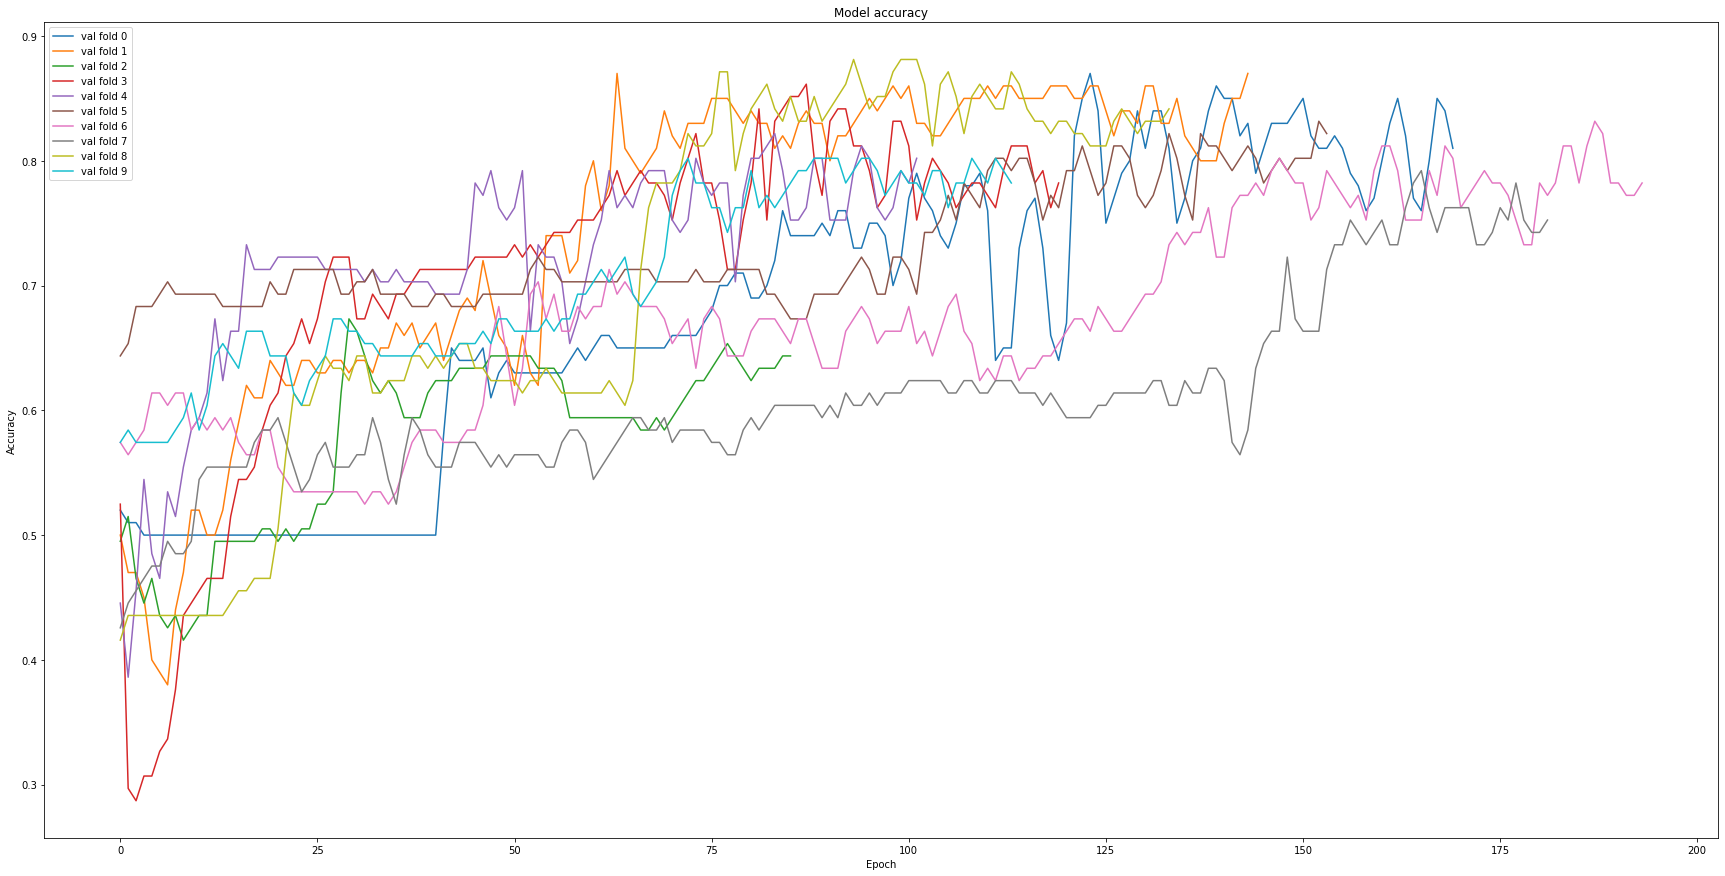

In [6]:
acc_train0 = all_fc_matrices_path_df0['acc_val'].tolist()
acc_train1 = all_fc_matrices_path_df1['acc_val'].tolist()
acc_train2 = all_fc_matrices_path_df2['acc_val'].tolist()
acc_train3 = all_fc_matrices_path_df3['acc_val'].tolist()
acc_train4 = all_fc_matrices_path_df4['acc_val'].tolist()
acc_train5 = all_fc_matrices_path_df5['acc_val'].tolist()
acc_train6 = all_fc_matrices_path_df6['acc_val'].tolist()
acc_train7 = all_fc_matrices_path_df7['acc_val'].tolist()
acc_train8 = all_fc_matrices_path_df8['acc_val'].tolist()
acc_train9 = all_fc_matrices_path_df9['acc_val'].tolist()


acc_train0 = [float(value.split('(')[1].split(')')[0]) for value in acc_train0]
acc_train1 = [float(value.split('(')[1].split(')')[0]) for value in acc_train1]
acc_train2 = [float(value.split('(')[1].split(')')[0]) for value in acc_train2]
acc_train3 = [float(value.split('(')[1].split(')')[0]) for value in acc_train3]
acc_train4 = [float(value.split('(')[1].split(')')[0]) for value in acc_train4]
acc_train5 = [float(value.split('(')[1].split(')')[0]) for value in acc_train5]
acc_train6 = [float(value.split('(')[1].split(')')[0]) for value in acc_train6]
acc_train7 = [float(value.split('(')[1].split(')')[0]) for value in acc_train7]
acc_train8 = [float(value.split('(')[1].split(')')[0]) for value in acc_train8]
acc_train9 = [float(value.split('(')[1].split(')')[0]) for value in acc_train9]



# acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

epochs = range(1, len(acc_train0) + 1)  # Assuming each entry corresponds to one epoch

# Plotting
fig = plt.figure(figsize=(30, 15))  # Adjust dimensions as needed

# Plotting
plt.plot(acc_train0, label='val fold 0')
plt.plot(acc_train1, label='val fold 1')
plt.plot(acc_train2, label='val fold 2')
plt.plot(acc_train3, label='val fold 3')
plt.plot(acc_train4, label='val fold 4')
plt.plot(acc_train5, label='val fold 5')
plt.plot(acc_train6, label='val fold 6')
plt.plot(acc_train7, label='val fold 7')
plt.plot(acc_train8, label='val fold 8')
plt.plot(acc_train9, label='val fold 9')


plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

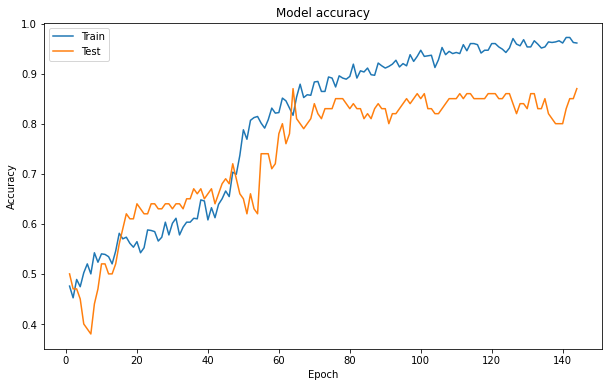

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch

acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, acc_train, label='Train')
plt.plot(epochs, acc_test, label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

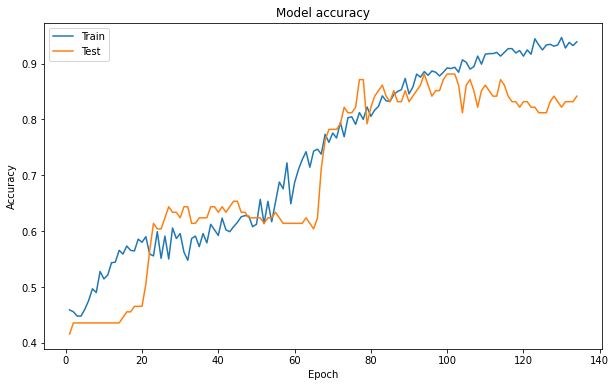

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_8_9_9.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch

acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, acc_train, label='Train')
plt.plot(epochs, acc_test, label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

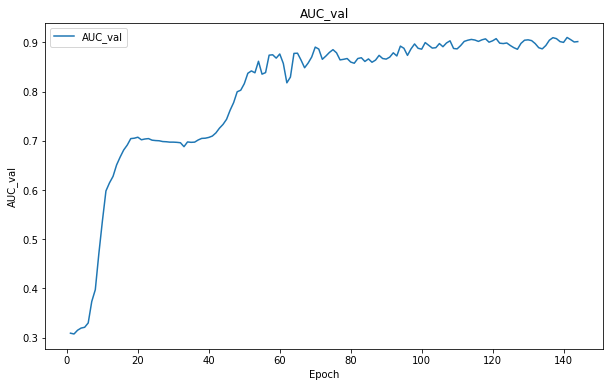

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
AUC_val = all_fc_matrices_path_df['AUC_val'].tolist()

epochs = range(1, len(AUC_val ) + 1)  # Assuming each entry corresponds to one epoch

AUC_val = [float(value.split('(')[1].split(')')[0]) for value in AUC_val]


# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, AUC_val, label='AUC_val')

plt.title('AUC_val')
plt.ylabel('AUC_val')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

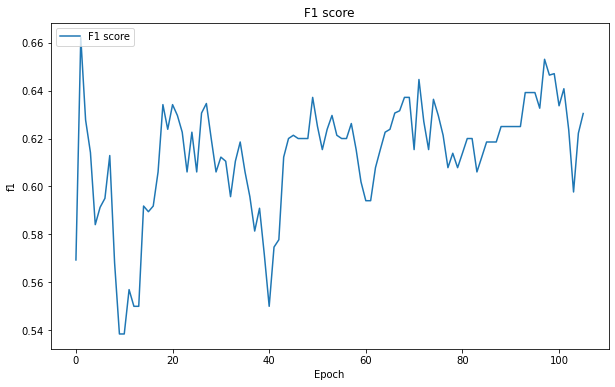

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_ez/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
f1 = all_fc_matrices_path_df['F1_val'].tolist()

epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot( f1, label='F1 score')

plt.title('F1 score')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

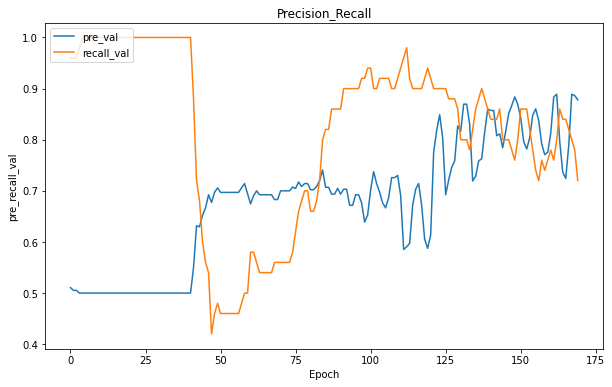

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
pre = all_fc_matrices_path_df['pre_val'].tolist()
recall = all_fc_matrices_path_df['recall_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot( pre, label='pre_val')
plt.plot( recall, label='recall_val')
plt.title('Precision_Recall')
plt.ylabel('pre_recall_val')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

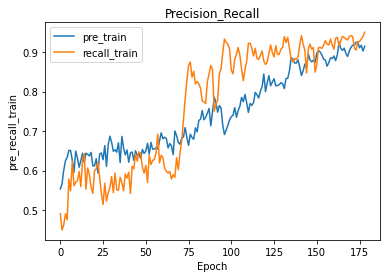

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_ez/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
pre = all_fc_matrices_path_df['pre_train'].tolist()
recall = all_fc_matrices_path_df['recall_train'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
# fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot( pre, label='pre_train')
plt.plot( recall, label='recall_train')
plt.title('Precision_Recall')
plt.ylabel('pre_recall_train')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

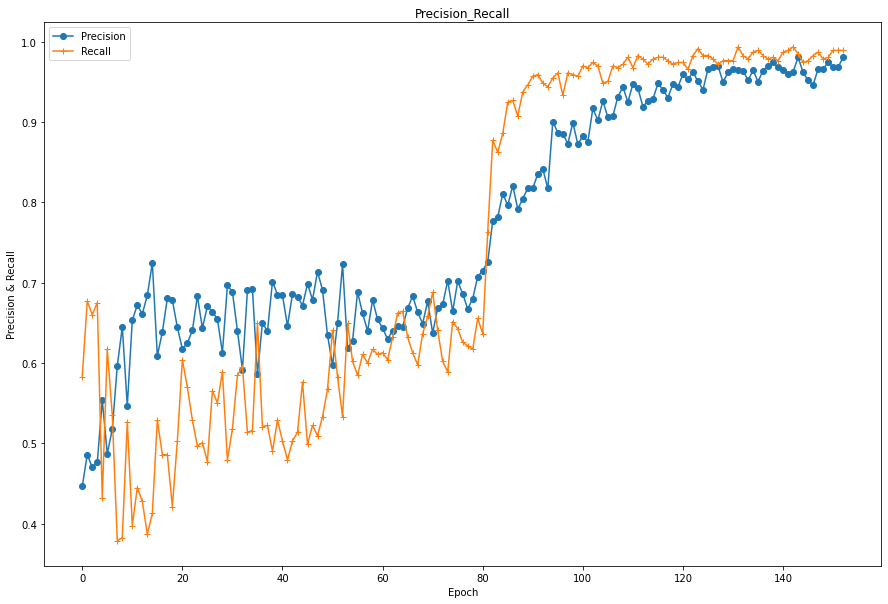

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_seven_32/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
pre = all_fc_matrices_path_df['pre_train'].tolist()
recall = all_fc_matrices_path_df['recall_train'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot( pre, label='Precision',marker='o')
plt.plot( recall, label='Recall',marker='+')
plt.title('Precision_Recall')
plt.ylabel('Precision & Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

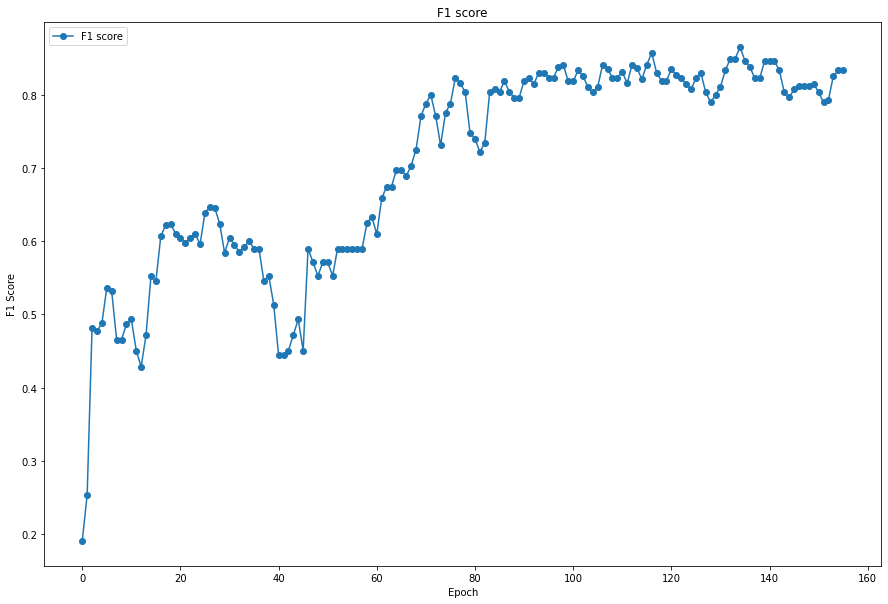

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_seven_32/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
f1 = all_fc_matrices_path_df['F1_val'].tolist()

epochs = range(1, len(f1) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot( f1, label='F1 score',marker='o')

plt.title('F1 score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

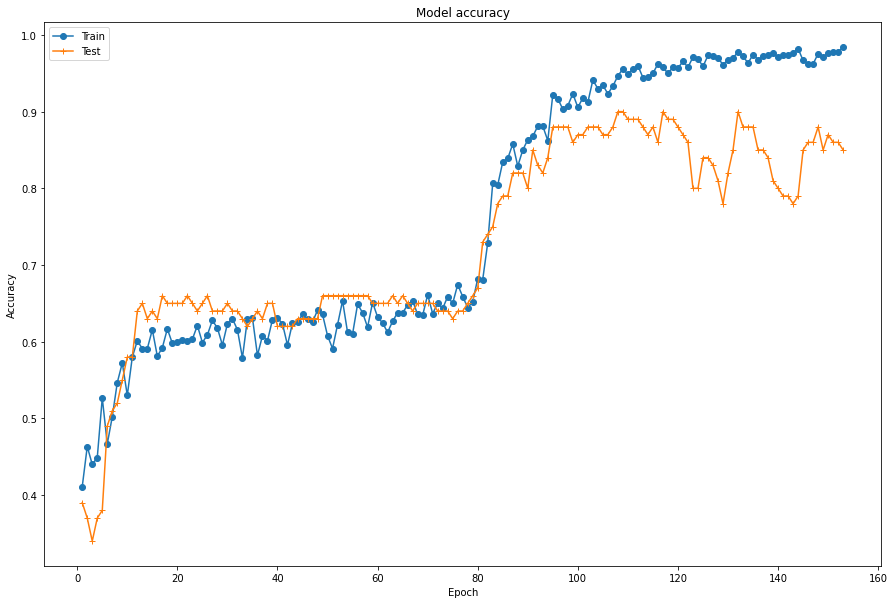

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_seven_32/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch

acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed



# Plotting
plt.plot(epochs, acc_train, label='Train',marker='o')
plt.plot(epochs, acc_test, label='Test',marker='+')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

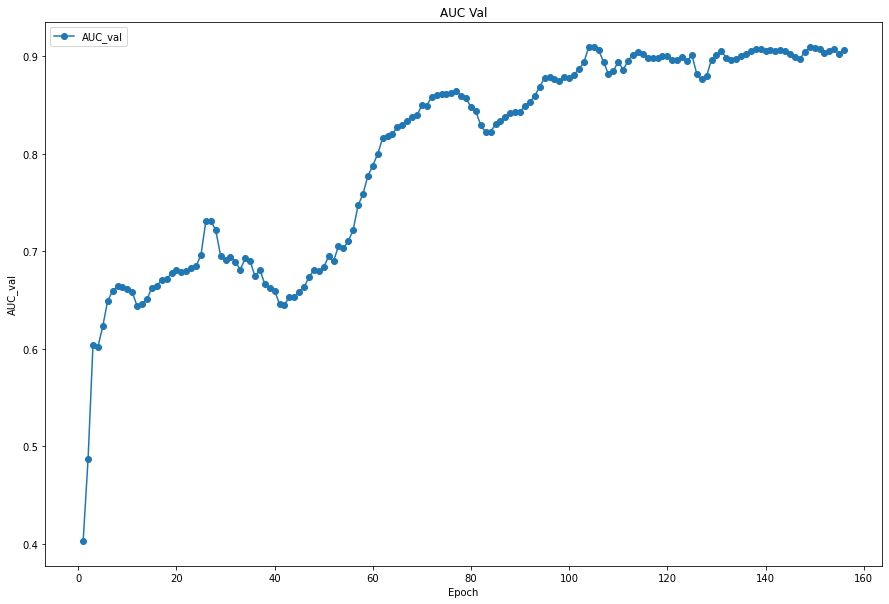

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_seven_32/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
AUC_val = all_fc_matrices_path_df['AUC_val'].tolist()

epochs = range(1, len(AUC_val ) + 1)  # Assuming each entry corresponds to one epoch

AUC_val = [float(value.split('(')[1].split(')')[0]) for value in AUC_val]


# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, AUC_val, label='AUC_val',marker='o')

plt.title('AUC Val')
plt.ylabel('AUC_val')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

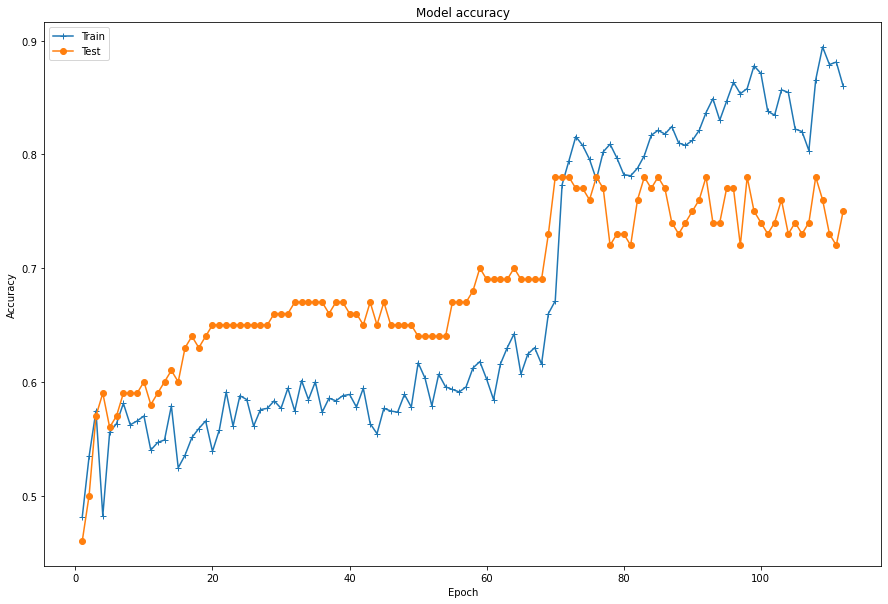

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch

acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot(epochs, acc_train, label='Train',marker='+')
plt.plot(epochs, acc_test, label='Test',marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

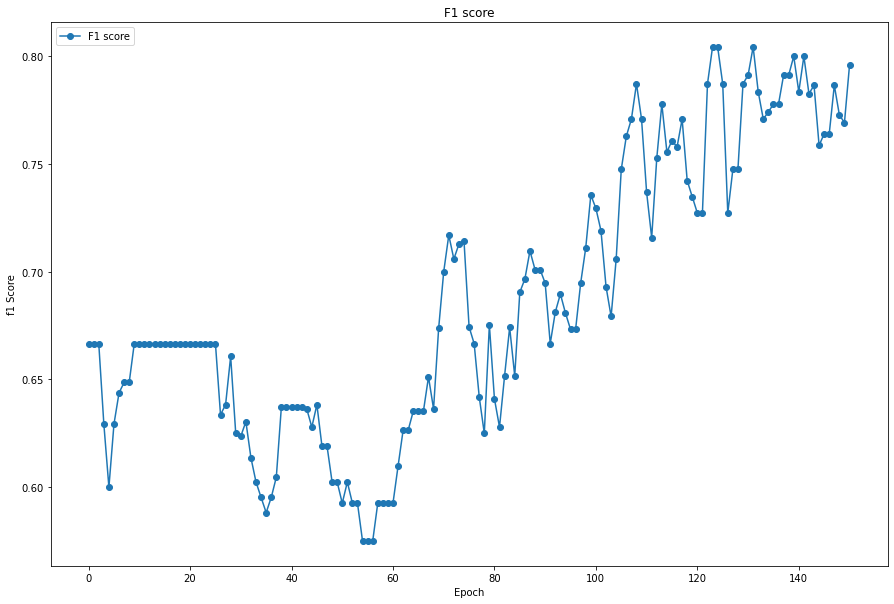

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
f1 = all_fc_matrices_path_df['F1_val'].tolist()

epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot( f1, label='F1 score',marker='o')

plt.title('F1 score')
plt.ylabel('f1 Score')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

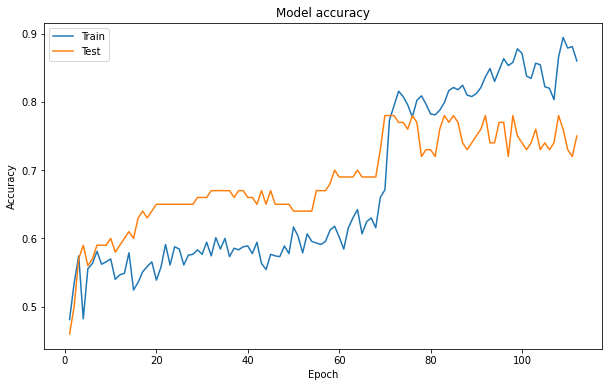

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch

acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

# Set figure size and background color
fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, acc_train, label='Train')
plt.plot(epochs, acc_test, label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

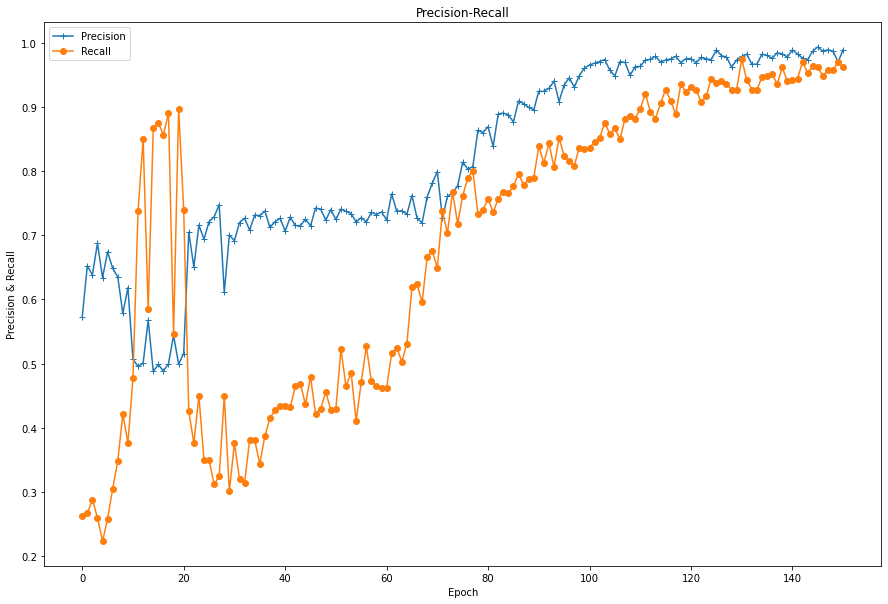

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
pre = all_fc_matrices_path_df['pre_train'].tolist()
recall = all_fc_matrices_path_df['recall_train'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot( pre, label='Precision',marker='+')
plt.plot( recall, label='Recall',marker='o')
plt.title('Precision-Recall')
plt.ylabel('Precision & Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

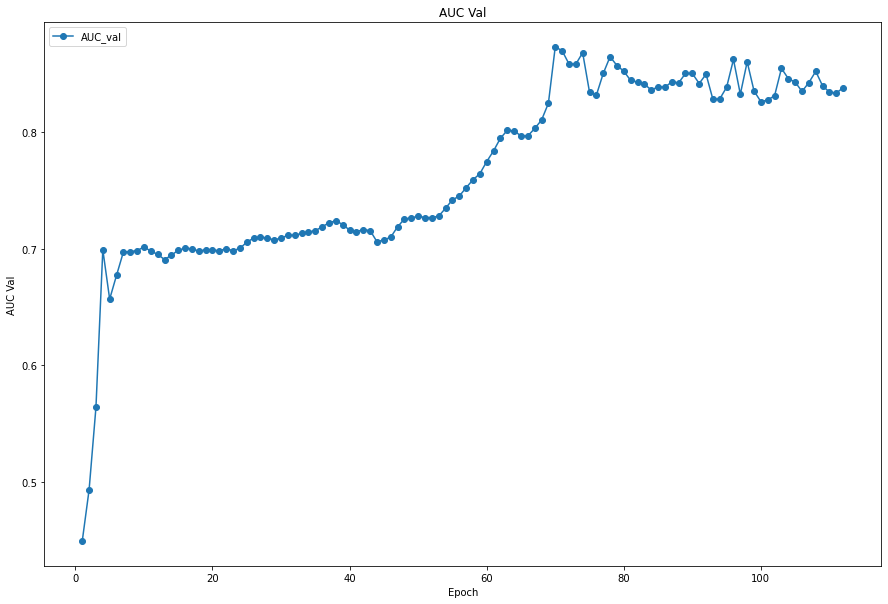

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
AUC_val = all_fc_matrices_path_df['AUC_val'].tolist()

epochs = range(1, len(AUC_val ) + 1)  # Assuming each entry corresponds to one epoch

AUC_val = [float(value.split('(')[1].split(')')[0]) for value in AUC_val]


# Set figure size and background color
fig = plt.figure(figsize=(15, 10))   # Adjust dimensions as needed

# Plotting
plt.plot(epochs, AUC_val, label='AUC_val',marker='o')

plt.title('AUC Val')
plt.ylabel('AUC Val')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


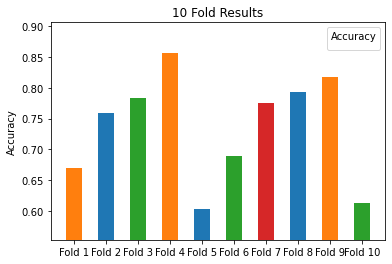

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['Fold 1', 'Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']
counts = [0.6696, 0.7589, 0.7838, 0.8559, 0.6036,0.69, 0.7748, 0.7928, 0.8180,0.6126]
bar_labels = ['orange', 'blue', 'green','orange','blue','green','red','blue','orange','green']
bar_colors = ['tab:orange', 'tab:blue', 'tab:green','tab:orange', 'tab:blue', 'tab:green','tab:red', 'tab:blue','tab:orange', 'tab:green']

ax.bar(fruits, counts, width=0.5, color=bar_colors)
ax.set_ylim(min(counts) - 0.05, max(counts) + 0.05)

ax.set_ylabel('Accuracy')
ax.set_title('10 Fold Results')
ax.legend(title='Accuracy')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['Fold 1', 'Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']
counts = [0.6696, 0.7589, 0.7838, 0.8559, 0.6036,0.69, 0.7748, 0.7928, 0.8180,0.6126]
bar_labels = ['orange', 'blue', 'green','orange','blue','green','red','blue','orange','green']
bar_colors = ['tab:orange', 'tab:blue', 'tab:green','tab:orange', 'tab:blue', 'tab:green','tab:red', 'tab:blue','tab:orange', 'tab:green']

ax.bar(fruits, counts, width=0.5, color=bar_colors)
ax.set_ylim(min(counts) - 0.05, max(counts) + 0.05)

ax.set_ylabel('Accuracy')
ax.set_title('10 Fold Results')
ax.legend(title='Accuracy')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


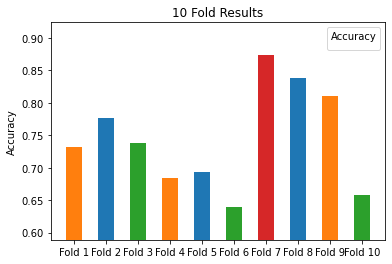

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['Fold 1', 'Fold 2', 'Fold 3','Fold 4','Fold 5','Fold 6','Fold 7','Fold 8','Fold 9','Fold 10']
counts = [0.732, 0.776, 0.7387, 0.684, 0.693, 0.639, 0.8739, 0.8378,0.8108 ,0.6577]
bar_labels = ['orange', 'blue', 'green','orange','blue','green','red','blue','orange','green']
bar_colors = ['tab:orange', 'tab:blue', 'tab:green','tab:orange', 'tab:blue', 'tab:green','tab:red', 'tab:blue','tab:orange', 'tab:green']

ax.bar(fruits, counts, width=0.5, color=bar_colors)
ax.set_ylim(min(counts) - 0.05, max(counts) + 0.05)

ax.set_ylabel('Accuracy')
ax.set_title('10 Fold Results')
ax.legend(title='Accuracy')

plt.show()

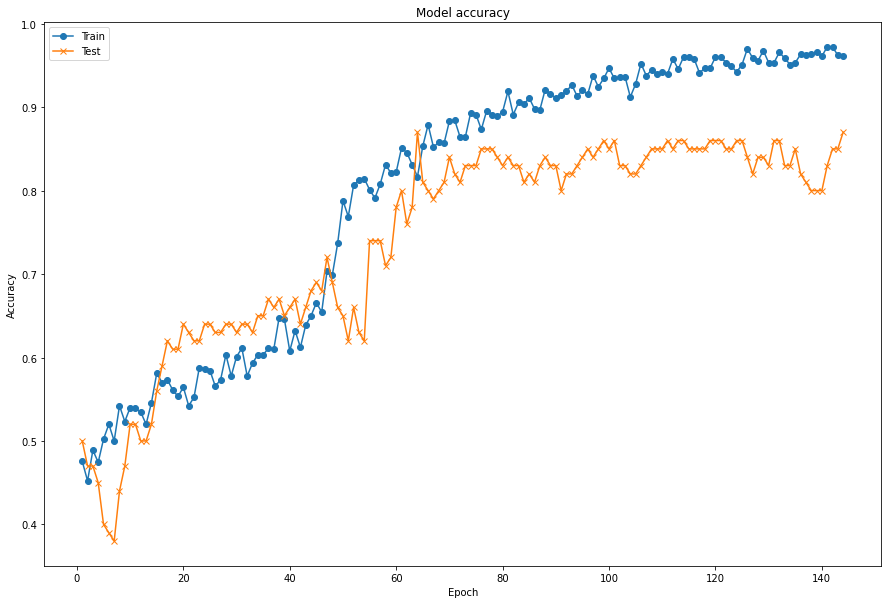

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
acc_test = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch

acc_train = [float(value.split('(')[1].split(')')[0]) for value in acc_train]
acc_test = [float(value.split('(')[1].split(')')[0]) for value in acc_test]

# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, acc_train, label='Train',marker='o')
plt.plot(epochs, acc_test, label='Test',marker='x')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

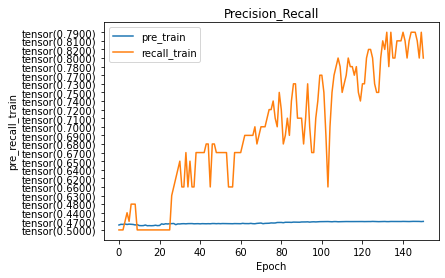

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400_ez_features/file_0_9_1.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
acc_train = all_fc_matrices_path_df['acc_train'].tolist()
recall = all_fc_matrices_path_df['acc_val'].tolist()
epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
# fig = plt.figure(figsize=(10, 6))  # Adjust dimensions as needed

# Plotting
plt.plot( pre, label='pre_train')
plt.plot( recall, label='recall_train')
plt.title('Precision_Recall')
plt.ylabel('pre_recall_train')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

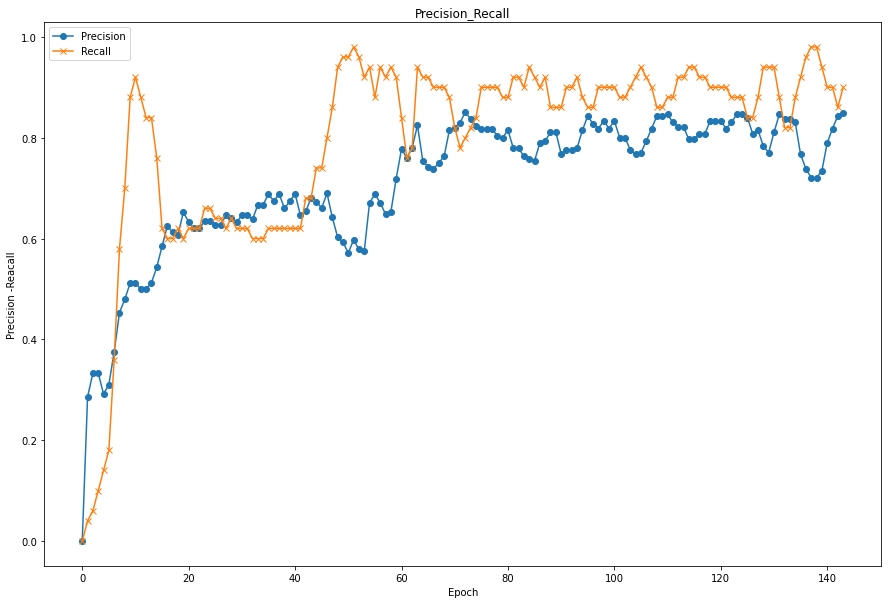

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
pre = all_fc_matrices_path_df['pre_val'].tolist()
recall = all_fc_matrices_path_df['recall_val'].tolist()
epochs = range(1, len(pre) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed

# Plotting
plt.plot( pre, label='Precision',marker='o')
plt.plot( recall, label='Recall',marker='x')
plt.title('Precision_Recall')
plt.ylabel('Precision -Reacall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

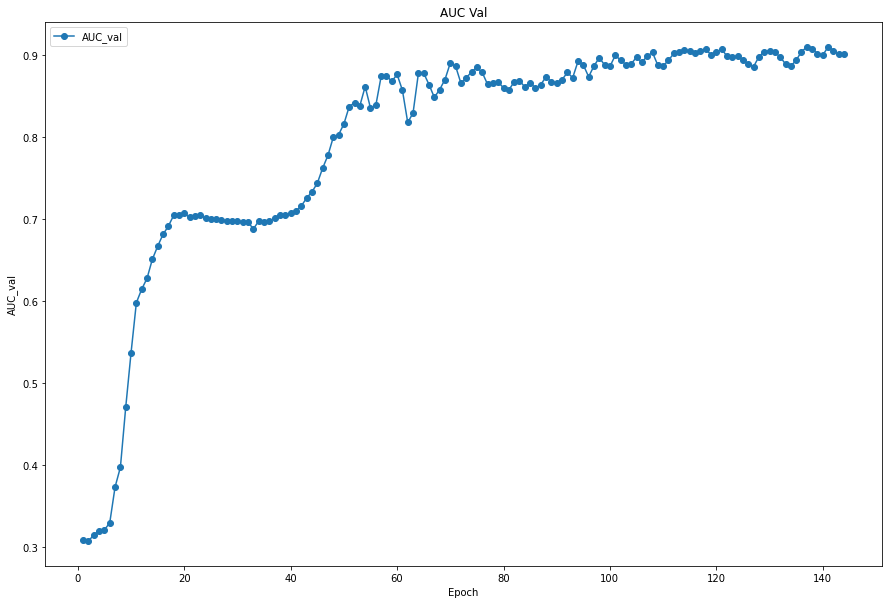

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_cc400/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
AUC_val = all_fc_matrices_path_df['AUC_val'].tolist()

epochs = range(1, len(AUC_val ) + 1)  # Assuming each entry corresponds to one epoch

AUC_val = [float(value.split('(')[1].split(')')[0]) for value in AUC_val]


# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed

# Plotting
plt.plot(epochs, AUC_val, label='AUC_val',marker='o')

plt.title('AUC Val')
plt.ylabel('AUC_val')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

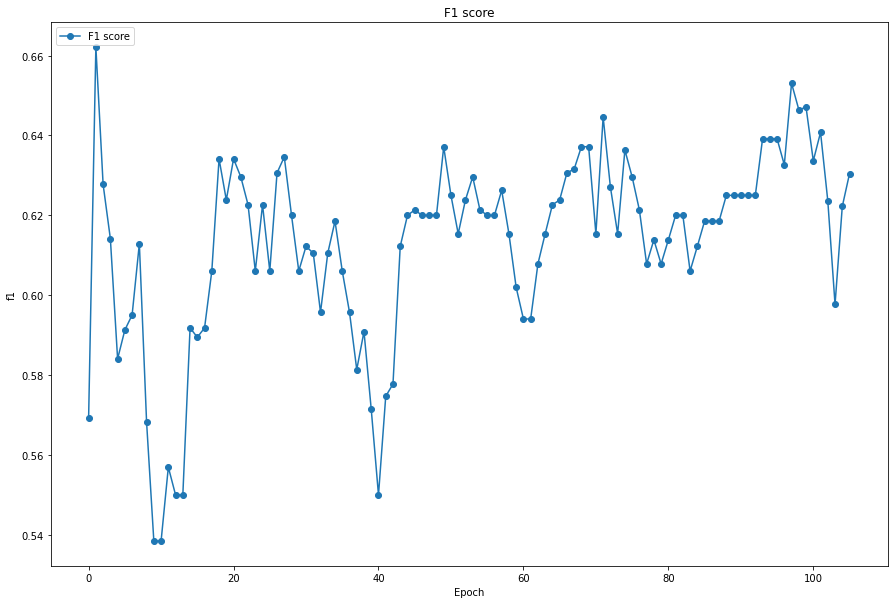

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '../files/rois_ez/file_1_9_2.csv'
all_fc_matrices_path_df = pd.read_csv(csv_file_path)

# Extract data from DataFrame
f1 = all_fc_matrices_path_df['F1_val'].tolist()

epochs = range(1, len(acc_train) + 1)  # Assuming each entry corresponds to one epoch



# Set figure size and background color
fig = plt.figure(figsize=(15, 10))  # Adjust dimensions as needed

# Plotting
plt.plot( f1, label='F1 score',marker='o')

plt.title('F1 score')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()